# Stock Price Prediction Using RNNs

## Objective
The objective of this assignment is to try and predict the stock prices using historical data from four companies IBM (IBM), Google (GOOGL), Amazon (AMZN), and Microsoft (MSFT).

We use four different companies because they belong to the same sector: Technology. Using data from all four companies may improve the performance of the model. This way, we can capture the broader market sentiment.

The problem statement for this assignment can be summarised as follows:

> Given the stock prices of Amazon, Google, IBM, and Microsoft for a set number of days, predict the stock price of these companies after that window.

## Business Value

Data related to stock markets lends itself well to modeling using RNNs due to its sequential nature. We can keep track of opening prices, closing prices, highest prices, and so on for a long period of time as these values are generated every working day. The patterns observed in this data can then be used to predict the future direction in which stock prices are expected to move. Analyzing this data can be interesting in itself, but it also has a financial incentive as accurate predictions can lead to massive profits.

### **Data Description**

You have been provided with four CSV files corresponding to four stocks: AMZN, GOOGL, IBM, and MSFT. The files contain historical data that were gathered from the websites of the stock markets where these companies are listed: NYSE and NASDAQ. The columns in all four files are identical. Let's take a look at them:

- `Date`: The values in this column specify the date on which the values were recorded. In all four files, the dates range from Jaunary 1, 2006 to January 1, 2018.

- `Open`: The values in this column specify the stock price on a given date when the stock market opens.

- `High`: The values in this column specify the highest stock price achieved by a stock on a given date.

- `Low`: The values in this column specify the lowest stock price achieved by a stock on a given date.

- `Close`: The values in this column specify the stock price on a given date when the stock market closes.

- `Volume`: The values in this column specify the total number of shares traded on a given date.

- `Name`: This column gives the official name of the stock as used in the stock market.

There are 3019 records in each data set. The file names are of the format `\<company_name>_stock_data.csv`.

## **1 Data Loading and Preparation** <font color =red> [25 marks] </font>

#### **Import Necessary Libraries**

In [251]:
# Import libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, accuracy_score, r2_score

import warnings
warnings.filterwarnings("ignore")


### **1.1 Data Aggregation** <font color =red> [7 marks] </font>

As we are using the stock data for four different companies, we need to create a new DataFrame that contains the combined data from all four data frames. We will create a function that takes in a list of the file names for the four CSV files, and returns a single data frame. This function performs the following tasks:
- Extract stock names from file names
- Read the CSV files as data frames
- Append the stock names into the columns of their respective data frames
- Drop unnecessary columns
- Join the data frames into one.

#### **1.1.1** <font color =red> [5 marks] </font>
Create the function to join DataFrames and use it to combine the four datasets.

In [148]:
# Define a function to load data and aggregate them
def loadData(filePaths):
    stock_names = []
    dataframe = pd.DataFrame()
    for path in filePaths:
        stock_data = pd.read_csv(path)
        stock_name = stock_data['Name'].unique()
        stock_data.drop(columns=['Name'], axis=1, inplace=True)
        # Renaming all columns except Date
        # stock_data = stock_data.add_suffix(f'_{stock_name[0]}')
        stock_data = stock_data.rename(columns={
            'Open':f'Open_{stock_name[0]}', 
            'High':f'High_{stock_name[0]}', 
            'Low':f'Low_{stock_name[0]}',
            'Close':f'Close_{stock_name[0]}',
            'Volume':f'Volume_{stock_name[0]}'})
        
        if dataframe.empty:
            dataframe =  stock_data.set_index('Date')
            dataframe.rename(columns={'old_name': 'new_name'}, inplace=True)
        else :
            dataframe = dataframe.join(stock_data.set_index('Date'))
        stock_names.append(stock_name[0])
    return dataframe, stock_names;


In [149]:
# Specify the names of the raw data files to be read and use the aggregation function to read the files
google_data_path = './RNN_Stocks_Data/GOOGL_stocks_data.csv'
amazon_data_path = './RNN_Stocks_Data/AMZN_stocks_data.csv'
ibm_data_path = './RNN_Stocks_Data/IBM_stocks_data.csv'
microsoft_data_path = './RNN_Stocks_Data/MSFT_stocks_data.csv'

df, stock_names = loadData([google_data_path, amazon_data_path, ibm_data_path, microsoft_data_path])
df.shape

(3019, 20)

In [150]:
stock_names

['GOOGL', 'AMZN', 'IBM', 'MSFT']

In [151]:
# View specifics of the data
df.head()

Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  Volume_GOOGL  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83      13137450   
2006-01-04      222.17      224.70     220.09       222.84      15292353   
2006-01-05      223.22      226.00     220.97       225.85      10815661   
2006-01-06      228.66      235.49     226.85       233.06      17759521   
2006-01-09      233.44      236.94     230.70       233.68      12795837   

            Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  Open_IBM  \
Date                                                                            
2006-01-03      47.47      47.85     46.25       47.58      7582127     82.45   
2006-01-04      47.48      47.73     46.69       47.25      7440914     82.20   
2006-01-05      47.16      48.20     47.11       47.65      5417258     81.40   
2006-01-06      47.97      48.58     47.32       47.87      6154285     83.95   
2006-01-09      46.55      47.10     46.40       47.08      8945056     84.10   

            High_IBM  Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  \
Date                                                                         
2006-01-03     82.55    80.81      82.06    11715200      26.25      27.00   
2006-01-04     82.50    81.33      81.95     9840600      26.77      27.08   
2006-01-05     82.90    81.00      82.50     7213500      26.96      27.13   
2006-01-06     85.03    83.41      84.95     8197400      26.89      27.00   
2006-01-09     84.25    83.38      83.73     6858200      26.93      27.07   

            Low_MSFT  Close_MSFT  Volume_MSFT  
Date                                           
2006-01-03     26.10       26.84     79974418  
2006-01-04     26.77       26.97     57975661  
2006-01-05     26.91       26.99     48247610  
2006-01-06     26.49       26.91    100969092  
2006-01-09     26.76       26.86     55627836

In [152]:
df.describe()

Open_GOOGL   High_GOOGL    Low_GOOGL  Close_GOOGL  Volume_GOOGL  \
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03   
mean    428.200802   431.835618   424.130275   428.044001  3.551504e+06   
std     236.320026   237.514087   234.923747   236.343238  3.038599e+06   
min     131.390000   134.820000   123.770000   128.850000  5.211410e+05   
25%     247.775000   250.190000   244.035000   247.605000  1.760854e+06   
50%     310.480000   312.810000   307.790000   310.080000  2.517630e+06   
75%     572.140000   575.975000   565.900000   570.770000  4.242182e+06   
max    1083.020000  1086.490000  1072.270000  1085.090000  4.118289e+07   

         Open_AMZN    High_AMZN     Low_AMZN   Close_AMZN   Volume_AMZN  \
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03   
mean    299.335310   302.371163   296.037695   299.376231  5.931712e+06   
std     280.120547   281.826442   277.927134   279.980161  5.122034e+06   
min      26.090000    26.300000    25.760000    26.070000  9.864350e+05   
25%      81.175000    82.580000    79.725000    81.090000  3.137037e+06   
50%     205.330000   208.000000   202.100000   205.440000  4.724100e+06   
75%     375.570000   379.155000   373.000000   375.140000  7.135246e+06   
max    1204.880000  1213.410000  1191.150000  1195.830000  1.044046e+08   

          Open_IBM     High_IBM      Low_IBM    Close_IBM    Volume_IBM  \
count  3018.000000  3019.000000  3018.000000  3019.000000  3.019000e+03   
mean    145.521034   146.687493   144.477203   145.623031  5.773563e+06   
std      37.559958    37.618348    37.482585    37.534272  3.193327e+06   
min      72.740000    73.940000    69.500000    71.740000  2.542560e+05   
25%     116.402500   117.750000   115.480000   116.520000  3.622178e+06   
50%     149.650000   150.410000   148.480000   149.330000  4.926500e+06   
75%     178.452500   179.775000   177.340000   178.690000  6.966642e+06   
max     215.380000   215.900000   214.300000   215.800000  3.077428e+07   

         Open_MSFT    High_MSFT     Low_MSFT   Close_MSFT   Volume_MSFT  
count  3019.000000  3019.000000  3019.000000  3019.000000  3.019000e+03  
mean     36.496817    36.827903    36.173190    36.513412  5.161762e+07  
std      14.683337    14.742483    14.620057    14.694656  3.114958e+07  
min      15.200000    15.620000    14.870000    15.150000  7.425603e+06  
25%      26.785000    27.045000    26.535000    26.835000  3.136557e+07  
50%      29.990000    30.230000    29.780000    30.000000  4.617529e+07  
75%      44.545000    44.980000    44.090000    44.400000  6.322291e+07  
max      87.120000    87.500000    86.230000    86.850000  5.910786e+08

#### **1.1.2** <font color =red> [2 marks] </font>
Identify and handle any missing values.

In [153]:
# Handle Missing Values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3019 entries, 2006-01-03 to 2017-12-29
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open_GOOGL    3019 non-null   float64
 1   High_GOOGL    3019 non-null   float64
 2   Low_GOOGL     3019 non-null   float64
 3   Close_GOOGL   3019 non-null   float64
 4   Volume_GOOGL  3019 non-null   int64  
 5   Open_AMZN     3019 non-null   float64
 6   High_AMZN     3019 non-null   float64
 7   Low_AMZN      3019 non-null   float64
 8   Close_AMZN    3019 non-null   float64
 9   Volume_AMZN   3019 non-null   int64  
 10  Open_IBM      3018 non-null   float64
 11  High_IBM      3019 non-null   float64
 12  Low_IBM       3018 non-null   float64
 13  Close_IBM     3019 non-null   float64
 14  Volume_IBM    3019 non-null   int64  
 15  Open_MSFT     3019 non-null   float64
 16  High_MSFT     3019 non-null   float64
 17  Low_MSFT      3019 non-null   float64
 18  Close_MSFT    3019

In [154]:
df[df['Open_IBM'].isnull()]

Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  Volume_GOOGL  \
Date                                                                       
2017-07-31       960.0      961.19     941.72        945.5       2293389   

            Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  Open_IBM  \
Date                                                                            
2017-07-31    1019.05    1019.05    987.02      987.78      7352063       NaN   

            High_IBM  Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  \
Date                                                                         
2017-07-31    144.93      NaN     144.67     4355718       73.3      73.44   

            Low_MSFT  Close_MSFT  Volume_MSFT  
Date                                           
2017-07-31     72.41        72.7     23600054

On 31st July, 2017, Opening and Low values for IBM stocks are down.
Imputing Low value with minimum of High and Close, and Open with avg of High and Low.

In [155]:
df['Low_IBM'].fillna(df[['High_IBM', 'Close_IBM']].min(axis=1), inplace=True)
df['Open_IBM'].fillna(df[['Low_IBM', 'Low_IBM']].mean(axis=1), inplace=True)

In [156]:
df.isnull().sum()

Open_GOOGL      0
High_GOOGL      0
Low_GOOGL       0
Close_GOOGL     0
Volume_GOOGL    0
Open_AMZN       0
High_AMZN       0
Low_AMZN        0
Close_AMZN      0
Volume_AMZN     0
Open_IBM        0
High_IBM        0
Low_IBM         0
Close_IBM       0
Volume_IBM      0
Open_MSFT       0
High_MSFT       0
Low_MSFT        0
Close_MSFT      0
Volume_MSFT     0
dtype: int64

In [157]:
df.head()

Open_GOOGL  High_GOOGL  Low_GOOGL  Close_GOOGL  Volume_GOOGL  \
Date                                                                       
2006-01-03      211.47      218.05     209.32       217.83      13137450   
2006-01-04      222.17      224.70     220.09       222.84      15292353   
2006-01-05      223.22      226.00     220.97       225.85      10815661   
2006-01-06      228.66      235.49     226.85       233.06      17759521   
2006-01-09      233.44      236.94     230.70       233.68      12795837   

            Open_AMZN  High_AMZN  Low_AMZN  Close_AMZN  Volume_AMZN  Open_IBM  \
Date                                                                            
2006-01-03      47.47      47.85     46.25       47.58      7582127     82.45   
2006-01-04      47.48      47.73     46.69       47.25      7440914     82.20   
2006-01-05      47.16      48.20     47.11       47.65      5417258     81.40   
2006-01-06      47.97      48.58     47.32       47.87      6154285     83.95   
2006-01-09      46.55      47.10     46.40       47.08      8945056     84.10   

            High_IBM  Low_IBM  Close_IBM  Volume_IBM  Open_MSFT  High_MSFT  \
Date                                                                         
2006-01-03     82.55    80.81      82.06    11715200      26.25      27.00   
2006-01-04     82.50    81.33      81.95     9840600      26.77      27.08   
2006-01-05     82.90    81.00      82.50     7213500      26.96      27.13   
2006-01-06     85.03    83.41      84.95     8197400      26.89      27.00   
2006-01-09     84.25    83.38      83.73     6858200      26.93      27.07   

            Low_MSFT  Close_MSFT  Volume_MSFT  
Date                                           
2006-01-03     26.10       26.84     79974418  
2006-01-04     26.77       26.97     57975661  
2006-01-05     26.91       26.99     48247610  
2006-01-06     26.49       26.91    100969092  
2006-01-09     26.76       26.86     55627836

In [158]:
df.reset_index(inplace=True)
df['Date'] = pd.to_datetime(df['Date'])

In [159]:
df = df.sort_values('Date')

### **1.2 Analysis and Visualisation** <font color =red> [5 marks] </font>

#### **1.2.1** <font color =red> [2 marks] </font>
Analyse the frequency distribution of stock volumes of the companies and also see how the volumes vary over time.

In [160]:
def frequency_distribution(column):
    ax = sns.histplot(df[column], bins=50, kde=True)
    plt.title(f'Frequency Distribution ({column})')
    # using custom formatter
    formatter = FuncFormatter(lambda x, _: f'{x/1e6:.0f}M')
    ax.xaxis.set_major_formatter(formatter)
    
    plt.xlabel("Value")
    plt.ylabel("Frequency")
    plt.show()

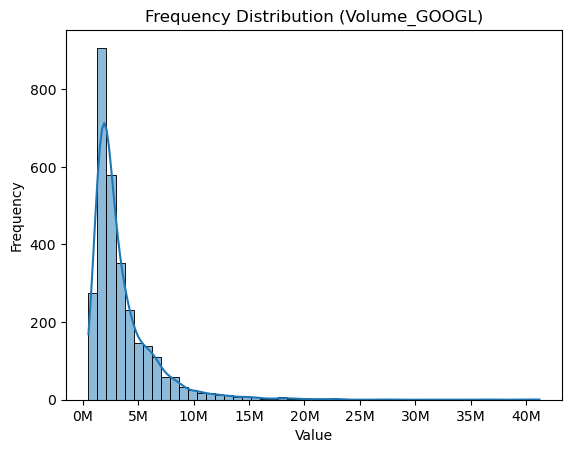

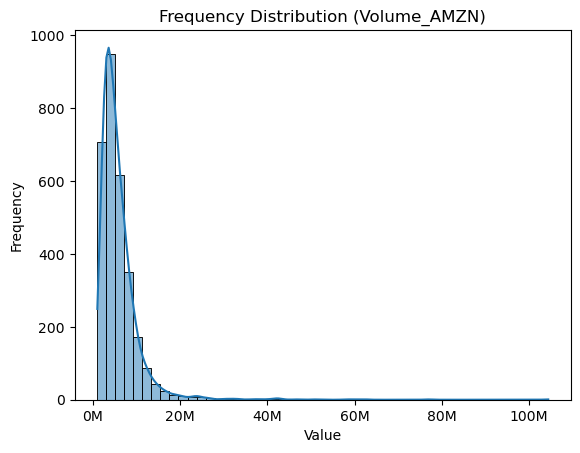

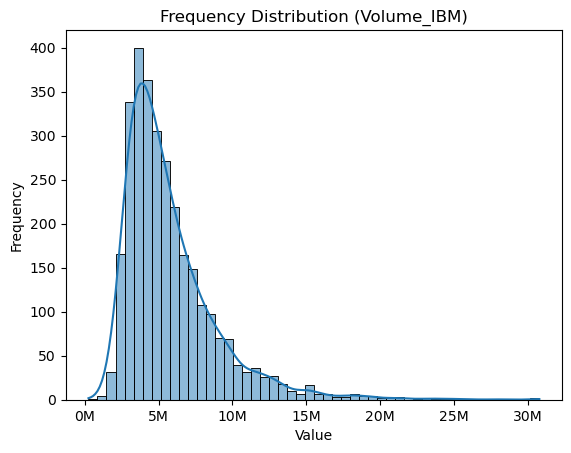

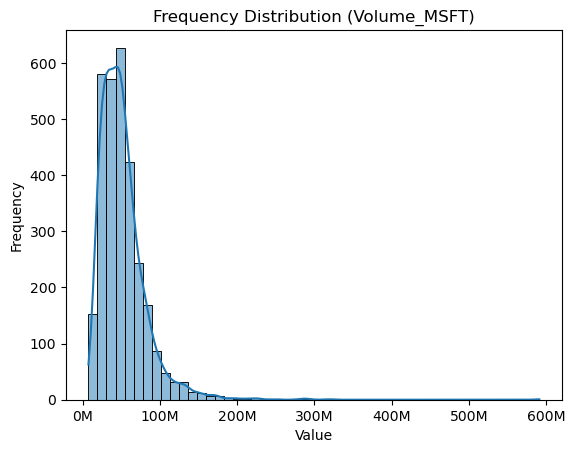

In [161]:
# Frequency distribution of volumes
for stock in stock_names:
    frequency_distribution(f'Volume_{stock}')

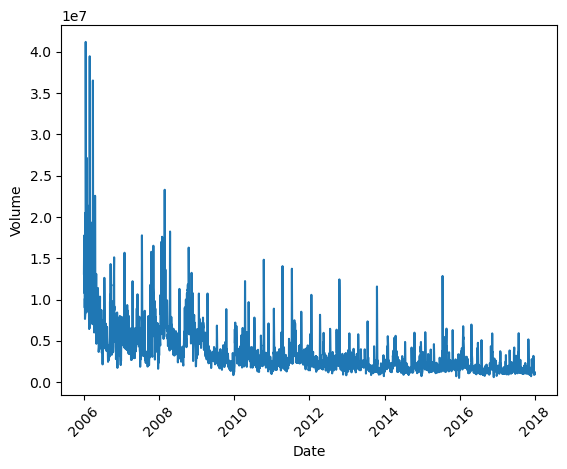

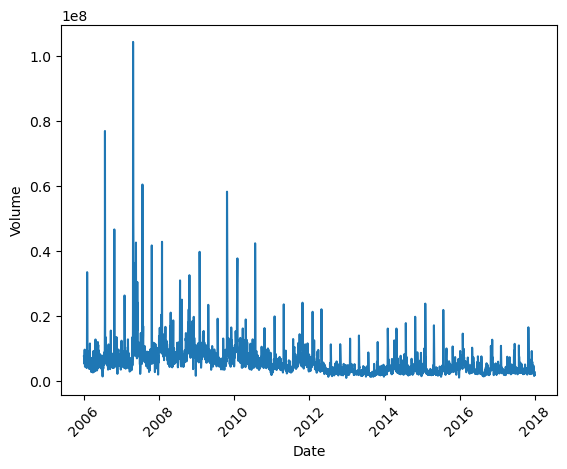

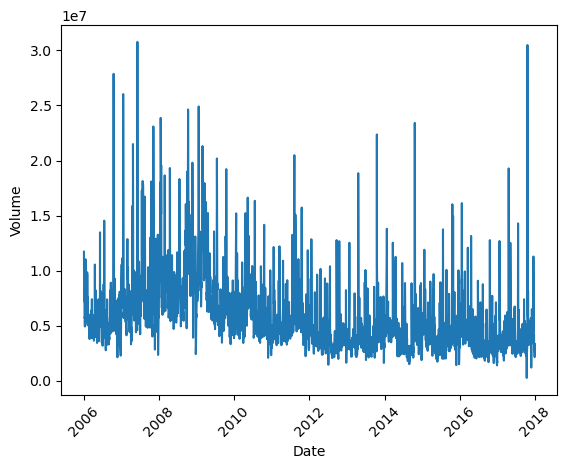

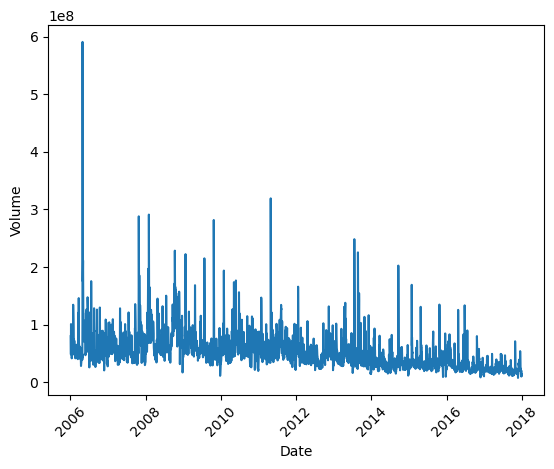

In [162]:
# Stock volume variation over time
for stock in stock_names:
    sns.lineplot(data=df, x='Date', y=f'Volume_{stock}')
    plt.xlabel("Date")
    plt.ylabel("Volume")
    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

Daily frequency distribution doesn't makes a lot of sense, grouping the data weekly.

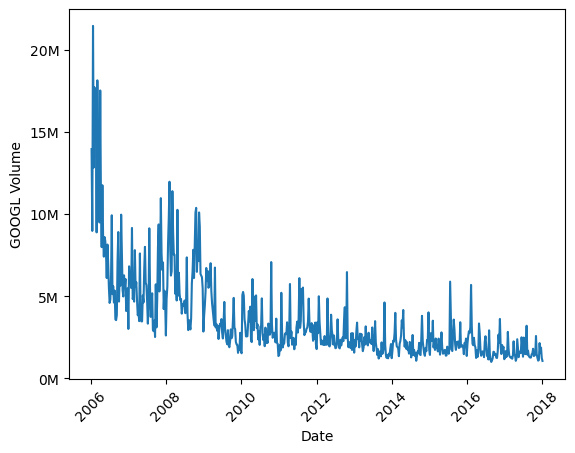

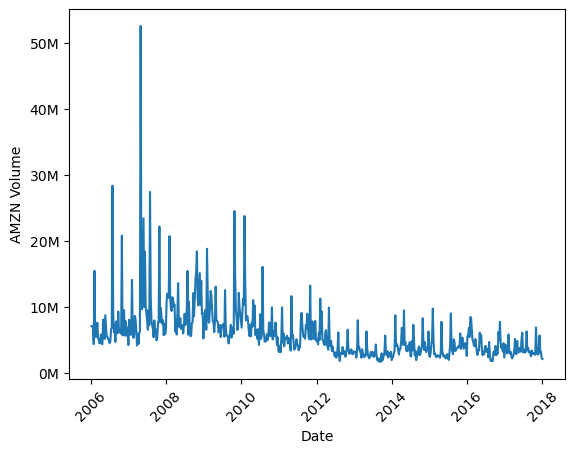

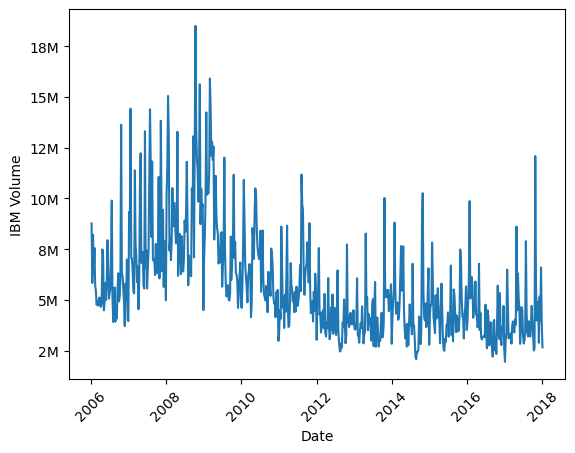

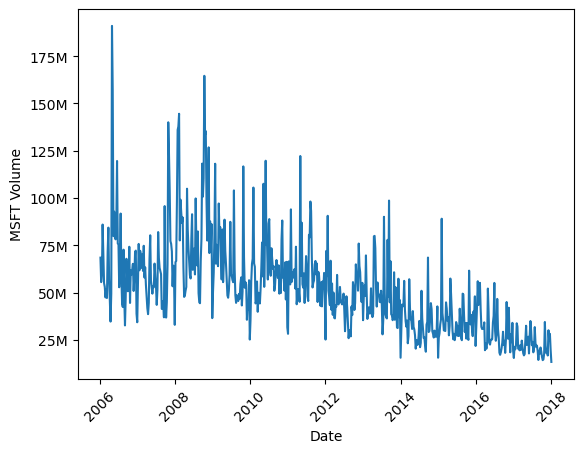

In [163]:
# Resampling data to per week.
df_weekly = df.resample('W-MON', on='Date').mean(numeric_only=True).reset_index()
for stock in stock_names:
    ax = sns.lineplot(data=df_weekly, x='Date', y=f'Volume_{stock}')
    plt.xlabel("Date")
    plt.ylabel(f"{stock} Volume")
    formatter = FuncFormatter(lambda x, _: f'{x/1e6:.0f}M')
    ax.yaxis.set_major_formatter(formatter)
    plt.xticks(rotation=45)
    # plt.tight_layout()
    plt.show()

#### **1.2.2** <font color =red> [3 marks] </font>
Analyse correlations between features.

/var/folders/1k/3qrrh5n144lg22cnq5nt046c0000gr/T/ipykernel_77102/2955236147.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True)


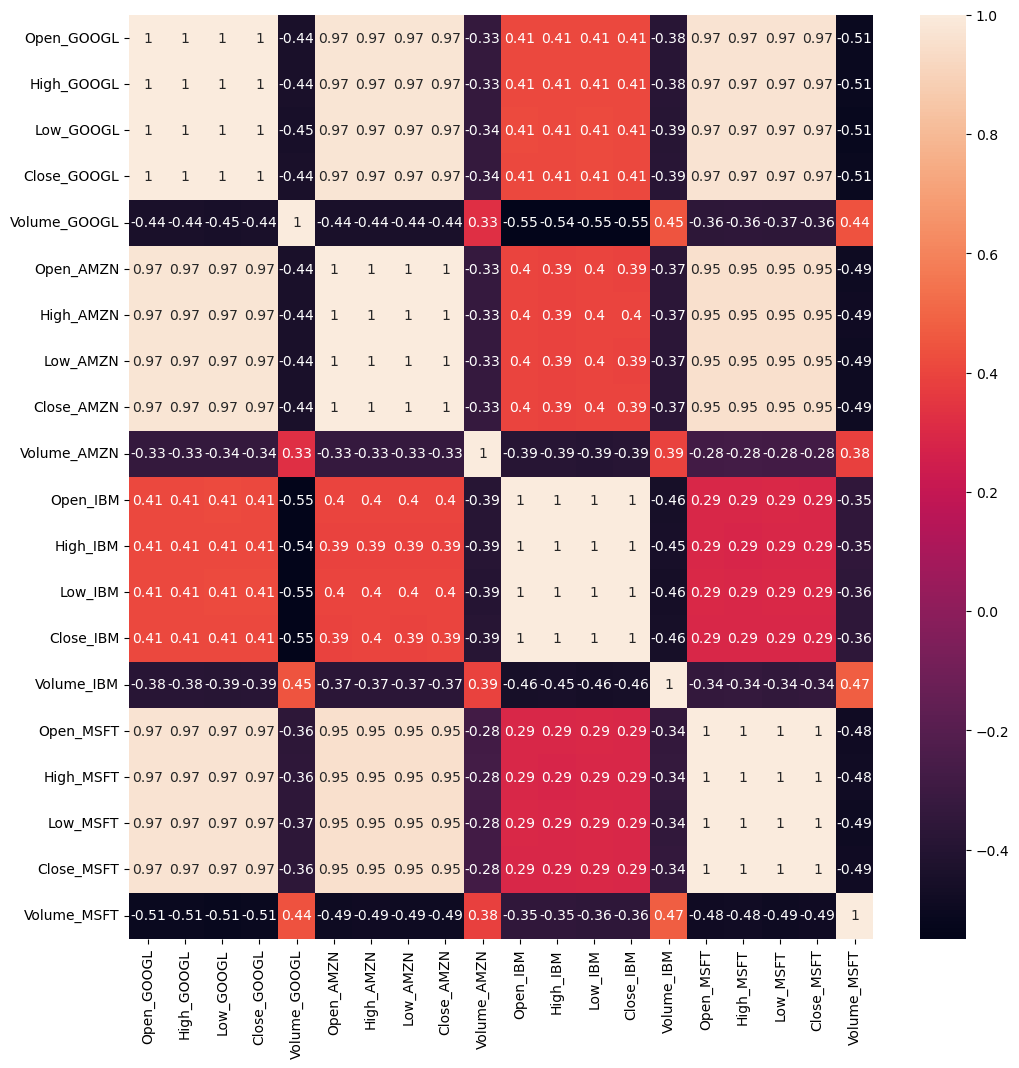

In [164]:
# Analyse correlations
plt.figure(figsize=(12,12))
sns.heatmap(df.corr(), annot=True)
plt.show()

### **1.3 Data Processing** <font color =red> [13 marks] </font>

Next, we need to process the data so that it is ready to be used in recurrent neural networks. You know RNNs are suitable to work with sequential data where patterns repeat at regular intervals.

For this, we need to execute the following steps:
1. Create windows from the master data frame and obtain windowed `X` and corresponding windowed `y` values
2. Perform train-test split on the windowed data
3. Scale the data sets in an appropriate manner

We will define functions for the above steps that finally return training and testing data sets that are ready to be used in recurrent neural networks.

**Hint:** If we use a window of size 3, in the first window, the rows `[0, 1, 2]` will be present and will be used to predict the value of `CloseAMZN` in row `3`. In the second window, rows `[1, 2, 3]` will be used to predict `CloseAMZN` in row `4`.

#### **1.3.1** <font color =red> [3 marks] </font>
Create a function that returns the windowed `X` and `y` data.

From the main DataFrame, this function will create windowed DataFrames, and store those as a list of DataFrames.

Controllable parameters will be window size, step size (window stride length) and target names as a list of the names of stocks whose closing values we wish to predict.

In [165]:
# Define a function that divides the data into windows and generates target variable values for each window

def generate_windowed_data(dataframe, target, window_size, step_size):
    X = []
    y = []
    for i in range(0, len(dataframe) - window_size, step_size):
        target_col_name = f'Close_{target}'
        window = dataframe.iloc[i: i+window_size]
        X.append(window.drop([target_col_name], axis=1))
        y.append(dataframe.iloc[i][target_col_name])

    return (np.array(X), np.array(y))

In [166]:
x,y = generate_windowed_data(df, 'AMZN', 3, 1)
print(x.shape)
print(y.shape)

(3016, 3, 20)
(3016,)


#### **1.3.2** <font color =red> [3 marks] </font>
Create a function to scale the data.

Define a function that will scale the data.

For scaling, we have to look at the whole length of data to find max/min values or standard deviations and means. If we scale the whole data at once, this will lead to data leakage in the windows. This is not necessarily a problem if the model is trained on the complete data with cross-validation.

One way to scale when dealing with windowed data is to use the `partial_fit()` method.
```
scaler.partial_fit(window)
scaler.transform(window)
```
You may use any other suitable way to scale the data properly. Arrive at a reasonable way to scale your data.

In [167]:
# Define a function that scales the windowed data
# The function takes in the windowed data sets and returns the scaled windows

def get_scaled_data_Old(X, scaler):
 
    no_of_windows, window_size, no_of_features = X.shape
    
    X_reshaped = X[:, :, 1:].reshape(-1, no_of_features - 1)
    
    if scaler is None:
        scaler = MinMaxScaler();
        scaler.partial_fit(X_reshaped)

    
    X_reshaped = scaler.transform(X_reshaped).reshape(no_of_windows, window_size, no_of_features - 1)

    X_scaled = np.concatenate([X[:, :, :1], X_reshaped], axis=2)
    return X_scaled, scaler


Next, define the main function that will call the windowing and scaling helper functions.

The input parameters for this function are:
- The joined master data set
- The names of the stocks that we wish to predict the *Close* prices for
- The window size
- The window stride
- The train-test split ratio

The outputs from this function are the scaled dataframes:
- *X_train*
- *y_train*
- *X_test*
- *y_test*

#### **1.3.3** <font color =red> [3 marks] </font>
Define a function to create windows of `window_size` and split the windowed data in to training and validation sets.

The function can take arguments such as list of target names, window size, window stride and split ratio. Use the windowing function here to make windows in the data and then perform scaling and train-test split.

In [168]:
# Define a function to create input and output data points from the master DataFrame
def generate_data(target_col, window_size, window_stride, split_ratio):
    # Generating windowed data
    X, y = generate_windowed_data(df, target_col, window_size, window_stride)
    # Creating Train Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=(1-split_ratio))
    X_train, scaler = get_scaled_data_Old(X_train, None)
    X_test, scaler = get_scaled_data_Old(X_test, scaler)
    
    return X_train, y_train, X_test, y_test, scaler


We can now use these helper functions to create our training and testing data sets. But first we need to decide on a length of windows. As we are doing time series prediction, we want to pick a sequence that shows some repetition of patterns.

For selecting a good sequence length, some business understanding will help us. In financial scenarios, we can either work with business days, weeks (which comprise of 5 working days), months, or quarters (comprising of 13 business weeks). Try looking for some patterns for these periods.

#### **1.3.4** <font color =red> [2 marks] </font>
Identify an appropriate window size.

For this, you can use plots to see how target variable is varying with time. Try dividing it into parts by weeks/months/quarters.

In [181]:
df = df.set_index('Date')

In [182]:
# Creating a subplot for Weeks, Month and Quarters
def plot_stock(dataframe, stock_name):
    target_column = f'Close_{stock_name}'
    fig, ax = plt.subplots(4, 1, figsize = (8, 8))
        
    # Daily
    ax[0].plot(dataframe.index, df[target_column])

    # By Week
    weekly = dataframe.resample('W')[target_column].mean()
    ax[1].plot(weekly.index, weekly.values)

    # By Month
    monthly = dataframe.resample('M')[target_column].mean()
    ax[2].plot(monthly.index, monthly.values)

     # By Quarter
    quarterly = dataframe.resample('Q')[target_column].mean()
    ax[3].plot(quarterly.index, quarterly.values)
    
    plt.show()
    

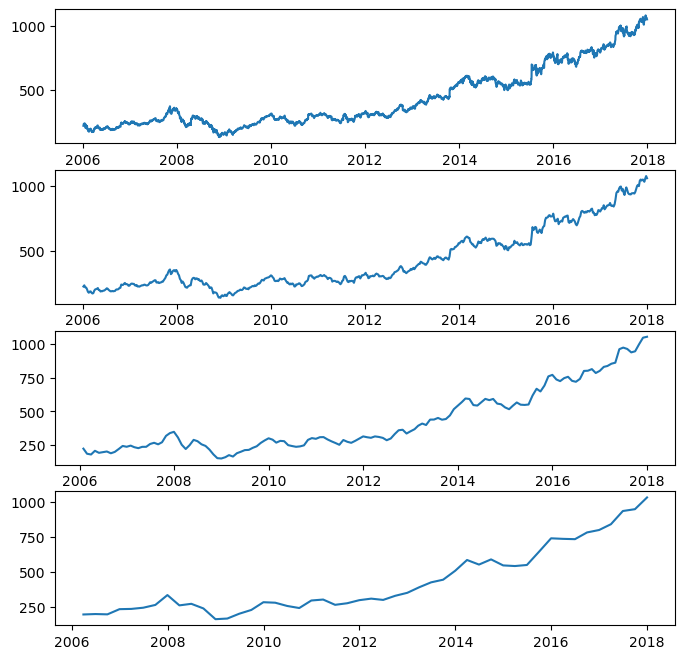

In [184]:
plot_stock(df, 'GOOGL')

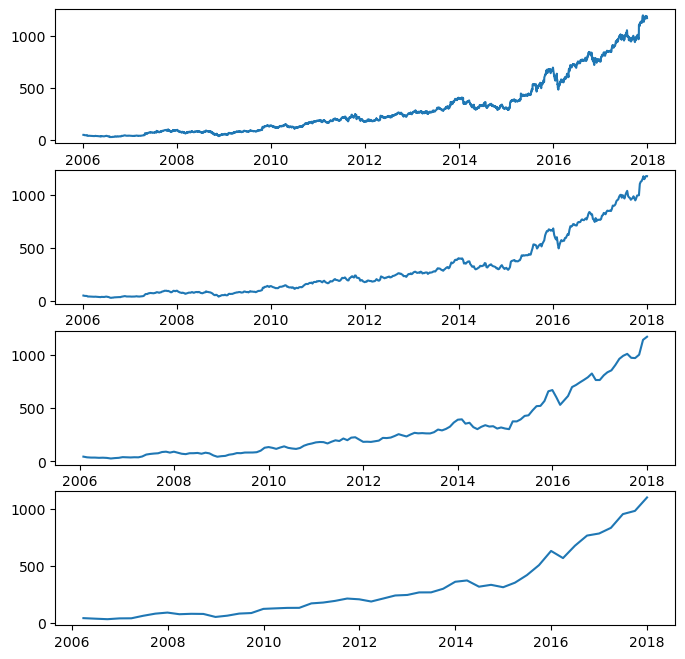

In [185]:
plot_stock(df, 'AMZN')

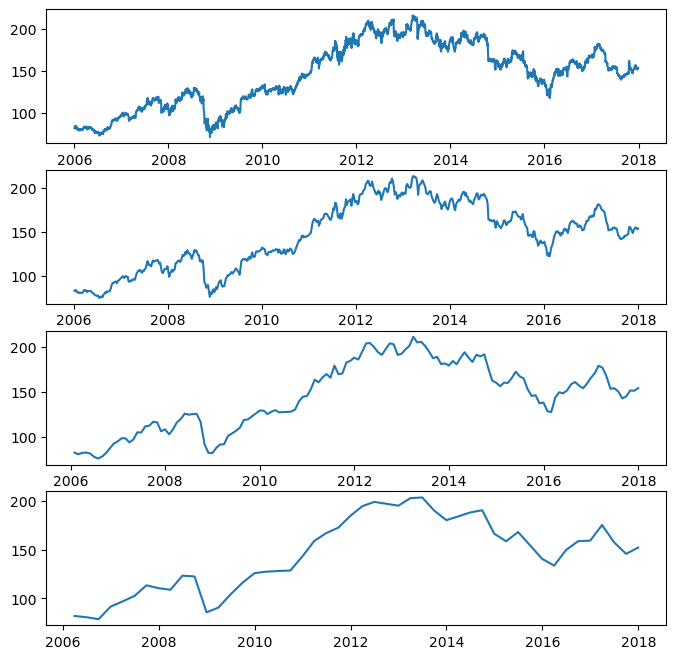

In [186]:
plot_stock(df, 'IBM')

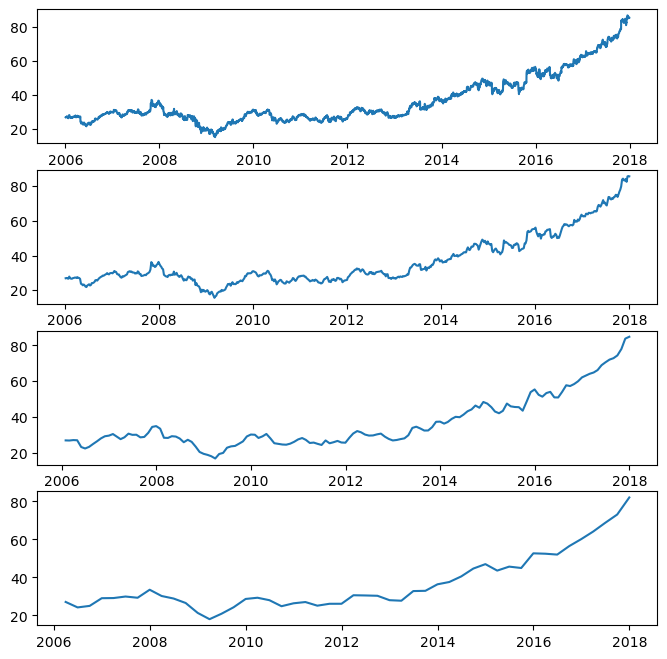

In [187]:
plot_stock(df, 'MSFT')

The distribution of the target variable across all stocks look similar between time slice and they are even comparable between each other except IBM stocks.

#### **1.3.5** <font color =red> [2 marks] </font>
Call the functions to create testing and training instances of predictor and target features.

In [188]:
# Create data instances from the master data frame using decided window size and window stride
data = {}
for stock in stock_names:
    X_train, y_train, X_test, y_test, scaler = generate_data(stock, 3, 1, 0.8)
    data[stock] = {'X_train' : X_train, "y_train": y_train, "X_test": X_test, "y_test": y_test}

In [189]:
# Check the number of data points generated
for key in data:
    print(f"---------{key}--------")
    print(f"X_train: {data[key]['X_train'].shape}")
    print(f"y_train: {data[key]['y_train'].shape}")
    print(f"X_test: {data[key]['X_test'].shape}")
    print(f"y_test: {data[key]['y_test'].shape}")

---------GOOGL--------
X_train: (2412, 3, 19)
y_train: (2412,)
X_test: (604, 3, 19)
y_test: (604,)
---------AMZN--------
X_train: (2412, 3, 19)
y_train: (2412,)
X_test: (604, 3, 19)
y_test: (604,)
---------IBM--------
X_train: (2412, 3, 19)
y_train: (2412,)
X_test: (604, 3, 19)
y_test: (604,)
---------MSFT--------
X_train: (2412, 3, 19)
y_train: (2412,)
X_test: (604, 3, 19)
y_test: (604,)


**Check if the training and testing datasets are in the proper format to feed into neural networks.**

In [190]:
# Check if the datasets are compatible inputs to neural networks
def compatibility_check(data, window_size, feature_count):
    # Extract individual fields
    X_train = data['X_train']
    y_train = data['y_train']
    X_test = data['X_test']
    y_test = data['y_test']

    validation_failures = []
    # Make sure both train and test data sets are numpy array
    if not isinstance(X_train, np.ndarray) or not isinstance(y_train, np.ndarray) or not isinstance(X_test, np.ndarray) or not isinstance(y_test, np.ndarray):
        validation_failures.append('Ensure both train and test data are numpy array')
    
    # Checking for null value
    if np.isnan(X_train).any() or np.isnan(y_train).any() or np.isnan(X_test).any() or np.isnan(y_test).any():
        validation_failures.append('Train and test data must not contain any null values')

    # Both Train and Test data must have constant shape
    if X_train.shape[1:] != X_test.shape[1:]:
        validation_failures.append(f'Ensure both train and test have same shape Train Shape: {X_train.shape[1:]} Test Shape: {X_test.shape[1:]}')

    # Check the shape of X and Y
    if X_train.shape[0] != y_train.shape[0] or X_test.shape[0] != y_test.shape[0]:
        validation_failures.append(f'Ensure both train and test have same shape Train Shape: {X_train.shape[1:]} Test Shape: {X_test.shape[1:]}')
    
    if len(validation_failures) == 0:
        print(f"Compatibility Check Passed")
    else:
        print(validation_failures)


In [191]:
for key in data:
    print(f"------ {key} ------")
    compatibility_check(data[key], 3, 20)

------ GOOGL ------
Compatibility Check Passed
------ AMZN ------
Compatibility Check Passed
------ IBM ------
Compatibility Check Passed
------ MSFT ------
Compatibility Check Passed


## **2 RNN Models** <font color =red> [20 marks] </font>

In this section, we will:
- Define a function that creates a simple RNN
- Tune the RNN for different hyperparameter values
- View the performance of the optimal model on the test data

### **2.1 Simple RNN Model** <font color =red> [10 marks] </font>

#### **2.1.1** <font color =red> [3 marks] </font>
Create a function that builds a simple RNN model based on the layer configuration provided.

In [192]:
# Create a function that creates a simple RNN model according to the model configuration arguments
def create_rnn_model(window_size, num_features, no_of_units=50, dense_units=1, dropout_rate=0.0, l2_regularization=0.0, optimizer='adam', learning_rate=0.001):
    model = Sequential()
    model.add(LSTM(units=no_of_units, activation='relu', input_shape=(window_size, num_features), return_sequences=False, kernel_regularizer=l2(l2_regularization)))
    model.add(Dense(units=dense_units, kernel_regularizer=l2(l2_regularization)))
    model.add(Dense(units=dense_units, activation='linear', kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [196]:
rnn_model = create_rnn_model(window_size=3, num_features=19)
rnn_model.summary()

Model: "sequential_3254"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3252 (LSTM)                │ (None, 50)             │        14,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6502 (Dense)              │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6503 (Dense)              │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,053 (54.89 KB)

 Trainable params: 14,053 (54.89 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.1.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [197]:
def evaluate_model(model, X_test, y_test, window_size):
        try:
            # Make predictions
            predictions = model.predict(X_test)

            # Calculate MSE
            mse = mean_squared_error(y_test, predictions)
            return mse
        except Exception as e:
            print(f"Error during model evaluation: {e}")
            return None

In [212]:
# Find an optimal configuration of simple RNN
def get_optimal_config(X, y, num_features):
    # Hyperparameter Configs
    param_grid = {
        'window_size': [3, 5, 10, 20, 30],
        'no_of_units': [32, 64, 128],
        'dropout_rate': [0.0, 0.2, 0.3],
        'l2_regularization': [0.0, 0.01, 0.001],
        'learning_rate': [0.001, 0.0001],
    }
    grid = ParameterGrid(param_grid)

    best_mse = float('inf')
    best_hyperparameters = None
    best_model = None

    tscv = TimeSeriesSplit(n_splits=3)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for params in grid:
            model = create_rnn_model(window_size=params['window_size'],
                                     num_features=num_features,
                                     no_of_units=params['no_of_units'],
                                     dense_units=1,
                                     dropout_rate=params['dropout_rate'],
                                     l2_regularization=params['l2_regularization'],
                                     optimizer='adam',
                                     learning_rate=params['learning_rate'])

            model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=1)
            mse = evaluate_model(model, X_test, y_test, params['window_size'])
            if mse < best_mse:
                best_mse = mse
                best_hyperparameters = params
                best_model = model

    return best_hyperparameters, best_model

In [208]:
dataset = data['AMZN']
hyperparameters, model = get_optimal_config(dataset['X_train'], dataset['y_train'], 19)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 240315.4531 - val_loss: 154422.4688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173120.2031 - val_loss: 136134.6719
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169581.2969 - val_loss: 129767.4375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159839.4844 - val_loss: 111235.6719
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127161.5312 - val_loss: 83297.7969
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90273.8281 - val_loss: 22975.8691
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27205.0391 - val_loss: 12242.3740
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13698.3750 - val_loss: 9648.6475
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10235.5918 - val_loss: 9106.5586
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7484.2944 - val_loss: 8283.6201
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 157605.4688 - val_loss: 107621.2734
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137677.1719 - val_loss: 77331.9844
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81265.0078 - val_loss: 33016.9570
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42563.9727 - val_loss: 11030.6523
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11714.6084 - val_loss: 11429.0713
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12159.1016 - val_loss: 7366.1274
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7199.2847 - val_loss: 5849.3521
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5904.8813 - val_loss: 6340.8369
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8351.0498 - val_loss: 5289.9248
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8852.7881 - val_loss: 12377.5586
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 186140.8125 - val_loss: 127455.6562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 174843.6875 - val_loss: 73418.1250
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77863.3828 - val_loss: 36098.3789
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43213.5742 - val_loss: 24242.2246
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27546.8984 - val_loss: 16624.8711
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23959.9219 - val_loss: 11124.7988
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14285.9385 - val_loss: 8449.5938
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9273.2314 - val_loss: 6473.8540
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7192.3267 - val_loss: 5246.4346
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5983.4131 - val_loss: 6421.2271
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 146838.4062 - val_loss: 110916.3359
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141364.2031 - val_loss: 105266.2578
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137566.4219 - val_loss: 98837.7344
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136602.1875 - val_loss: 90443.4375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121855.7734 - val_loss: 77215.4609
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89511.4688 - val_loss: 63479.5195
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77529.4453 - val_loss: 47770.4922
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53342.4414 - val_loss: 33883.0117
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39235.4961 - val_loss: 21280.1562
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25769.7266 - val_loss: 13850.2646
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 160402.0469 - val_loss: 131020.1484
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184854.5156 - val_loss: 102390.0625
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121376.9297 - val_loss: 62780.4297
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67780.0234 - val_loss: 12848.7676
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12631.5703 - val_loss: 12274.4609
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12662.7734 - val_loss: 10694.7021
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10879.7363 - val_loss: 6659.4727
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7907.8828 - val_loss: 10235.9766
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8639.2051 - val_loss: 7638.7334
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9759.1328 - val_loss: 8603.5605
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 159402.2031 - val_loss: 94650.0156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110011.4141 - val_loss: 65879.5547
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81823.1250 - val_loss: 29941.0000
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35261.5859 - val_loss: 10817.9688
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12150.4717 - val_loss: 10524.7295
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9950.8838 - val_loss: 6258.5166
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5597.5210 - val_loss: 4670.5469
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4598.8833 - val_loss: 5420.2832
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4330.7739 - val_loss: 6332.0547
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5475.4854 - val_loss: 4593.6758
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163086.2188 - val_loss: 111671.9453
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140897.3438 - val_loss: 75287.1094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84015.5391 - val_loss: 25706.0938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22435.5859 - val_loss: 11386.2324
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11773.0078 - val_loss: 11199.9873
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11785.1133 - val_loss: 9717.4863
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10115.1133 - val_loss: 7010.3335
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7682.4404 - val_loss: 7370.0542
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8944.6191 - val_loss: 5933.0444
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5835.6553 - val_loss: 4998.8687
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 181080.2031 - val_loss: 100542.3125
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117056.0938 - val_loss: 71544.2266
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79317.5859 - val_loss: 18613.0957
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18777.4277 - val_loss: 10222.3984
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10491.7725 - val_loss: 10094.9160
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8670.1123 - val_loss: 6738.4297
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8524.1738 - val_loss: 44460.6133
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22939.9121 - val_loss: 7239.9097
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7384.7241 - val_loss: 6899.4707
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6235.4087 - val_loss: 6254.3286
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 109954.5078 - val_loss: 56194.6094
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67551.5469 - val_loss: 22114.6445
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27081.7871 - val_loss: 12041.1562
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11253.1719 - val_loss: 10558.8027
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10802.6465 - val_loss: 7666.4360
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8064.1929 - val_loss: 6375.2358
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6505.8638 - val_loss: 4823.0825
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4612.6353 - val_loss: 13686.1201
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8190.3350 - val_loss: 9641.0518
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9351.0264 - val_loss: 6297.1299
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 149763.8594 - val_loss: 100014.4062
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126339.8047 - val_loss: 47246.2266
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40256.3242 - val_loss: 10879.8271
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11658.3076 - val_loss: 12803.8555
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9487.3164 - val_loss: 4622.2573
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4233.5181 - val_loss: 3867.9050
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3530.6353 - val_loss: 3249.2170
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3884.6196 - val_loss: 3000.7000
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2878.2104 - val_loss: 5850.4883
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4647.8203 - val_loss: 4198.5005
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 125408.7500 - val_loss: 67272.7656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64383.7148 - val_loss: 14189.9541
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15846.0869 - val_loss: 11294.0283
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11261.7080 - val_loss: 8976.9365
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8898.6836 - val_loss: 6214.1880
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6288.7622 - val_loss: 4537.4995
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5122.1899 - val_loss: 3991.6096
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4042.7632 - val_loss: 4903.5933
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5351.5000 - val_loss: 4257.6538
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5320.9946 - val_loss: 4688.3774
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 137649.9688 - val_loss: 11713.1191
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10753.2520 - val_loss: 10065.2979
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9342.6426 - val_loss: 7345.9863
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6788.2266 - val_loss: 8852.9795
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7063.7861 - val_loss: 6859.4907
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7284.2104 - val_loss: 5920.0181
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5603.1987 - val_loss: 9409.9258
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7684.7837 - val_loss: 17338.9805
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10123.7012 - val_loss: 7523.5728
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6137.0186 - val_loss: 3831.4072
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 159042.8594 - val_loss: 123415.5156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 178044.7812 - val_loss: 110424.7578
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 147569.2812 - val_loss: 54901.0820
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52042.5586 - val_loss: 12180.1631
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14133.9082 - val_loss: 11579.5166
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12502.8086 - val_loss: 10672.5742
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11626.0791 - val_loss: 10347.5596
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11488.4775 - val_loss: 9752.6738
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10299.4941 - val_loss: 10032.0947
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9233.6455 - val_loss: 4662.6387
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 130993.4297 - val_loss: 69095.7031
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 54299.1406 - val_loss: 11469.6533
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14240.7822 - val_loss: 11576.1387
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11742.8838 - val_loss: 13353.7275
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8067.9688 - val_loss: 5285.3491
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5638.1440 - val_loss: 3440.2886
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4362.0576 - val_loss: 5349.6943
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4991.9497 - val_loss: 3680.3010
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3631.9587 - val_loss: 3606.3953
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3618.5669 - val_loss: 5245.5273
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 113535.9141 - val_loss: 25488.8242
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 23241.2012 - val_loss: 12522.0967
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11253.6162 - val_loss: 8855.2832
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10063.9980 - val_loss: 11626.8691
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10168.0010 - val_loss: 6413.5264
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6252.1147 - val_loss: 5649.3394
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5615.3359 - val_loss: 6297.8584
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6767.5498 - val_loss: 4533.3247
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4000.3589 - val_loss: 5136.1880
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3907.4556 - val_loss: 5383.5889
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 161450.9688 - val_loss: 116048.3906
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135654.4062 - val_loss: 115363.7500
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168143.0000 - val_loss: 114657.2969
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153669.3906 - val_loss: 114005.2578
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144636.0312 - val_loss: 113338.7109
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153542.1562 - val_loss: 112635.3516
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154846.7656 - val_loss: 110888.2422
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141964.5156 - val_loss: 103876.7578
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127942.0859 - val_loss: 98897.3906
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127656.3984 - val_loss: 82768.7578
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163711.5312 - val_loss: 125410.7109
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181190.8281 - val_loss: 123497.6484
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154964.7656 - val_loss: 121803.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159813.5312 - val_loss: 119743.4062
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160708.8906 - val_loss: 116027.3125
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154197.3906 - val_loss: 92579.9062
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113415.4453 - val_loss: 79818.9062
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113455.1641 - val_loss: 73171.9141
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97318.7188 - val_loss: 67446.2500
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82717.4922 - val_loss: 57032.1719
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 183075.4219 - val_loss: 139423.7344
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185085.3438 - val_loss: 135214.7344
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180578.8438 - val_loss: 130169.3750
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174280.5781 - val_loss: 129046.4141
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168476.4531 - val_loss: 128560.2969
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166745.1094 - val_loss: 128150.7969
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171142.7500 - val_loss: 127763.1328
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170482.2031 - val_loss: 127372.8281
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183281.9844 - val_loss: 126983.2734
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164988.2969 - val_loss: 126610.8281
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 208477.5469 - val_loss: 159413.5312
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190770.9375 - val_loss: 155443.1562
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 193253.6875 - val_loss: 151478.4688
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 212972.0000 - val_loss: 147544.2812
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 215555.1719 - val_loss: 143851.6719
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 189550.8438 - val_loss: 138751.3281
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163325.8594 - val_loss: 134011.9219
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162870.4062 - val_loss: 131022.5625
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174544.2188 - val_loss: 127958.7344
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170254.9219 - val_loss: 118804.2812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 252351.1875 - val_loss: 169883.9375
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 220672.3281 - val_loss: 149417.3594
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 187744.6250 - val_loss: 146762.4375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184435.3438 - val_loss: 143484.2188
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181182.2031 - val_loss: 141460.4375
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166959.4219 - val_loss: 139502.9375
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 186460.0938 - val_loss: 137751.7656
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184604.7344 - val_loss: 136093.7031
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 197907.2188 - val_loss: 134296.5469
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171420.3750 - val_loss: 131906.7969
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 164368.6094 - val_loss: 120284.5938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172955.5625 - val_loss: 119414.3203
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149629.6250 - val_loss: 118748.6953
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160177.2656 - val_loss: 118064.2656
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161369.4375 - val_loss: 117325.3906
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164271.8750 - val_loss: 116437.3516
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151425.0312 - val_loss: 113947.8438
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152772.9844 - val_loss: 112166.7344
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129208.7031 - val_loss: 108657.5391
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148543.7812 - val_loss: 105927.7656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173381.8594 - val_loss: 129222.5781
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180327.4688 - val_loss: 128560.7344
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174927.5156 - val_loss: 127902.5781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174306.0156 - val_loss: 127202.3984
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169673.7188 - val_loss: 126487.9453
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158958.8281 - val_loss: 125822.0469
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173417.5469 - val_loss: 124143.6172
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166506.2344 - val_loss: 119274.8359
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156171.9688 - val_loss: 118145.7188
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141919.7344 - val_loss: 117152.6484
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 159482.2500 - val_loss: 121658.1250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152333.2656 - val_loss: 120563.9141
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169061.5000 - val_loss: 118527.1406
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150194.7656 - val_loss: 115160.9219
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152628.6719 - val_loss: 112747.1797
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136400.9531 - val_loss: 109554.9609
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147743.9375 - val_loss: 105232.5078
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158650.4219 - val_loss: 99525.1484
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135875.4375 - val_loss: 95792.0781
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130419.8359 - val_loss: 90766.5391
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 185272.0938 - val_loss: 123944.0859
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161959.8750 - val_loss: 123864.3984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155559.3438 - val_loss: 123820.5234
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152270.5000 - val_loss: 123811.6328
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169203.7500 - val_loss: 123803.2734
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168175.0625 - val_loss: 123790.7109
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164292.2500 - val_loss: 123761.8047
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157514.9531 - val_loss: 123689.8359
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150017.4688 - val_loss: 123258.3828
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153772.0625 - val_loss: 122896.9844
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 158322.4062 - val_loss: 120925.2344
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161877.4531 - val_loss: 119143.2344
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149496.8906 - val_loss: 117191.1953
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145448.0156 - val_loss: 114271.6719
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144702.5781 - val_loss: 111814.9531
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140417.0625 - val_loss: 110339.4609
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143070.3281 - val_loss: 108524.1172
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141239.5156 - val_loss: 103905.7969
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144777.9375 - val_loss: 97665.9531
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138679.8281 - val_loss: 88355.0469
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 132965.2500 - val_loss: 91274.1797
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104775.3359 - val_loss: 88503.8672
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111057.8203 - val_loss: 82462.8906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110788.1406 - val_loss: 79368.2031
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111214.5312 - val_loss: 73600.9453
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101919.2656 - val_loss: 65123.1094
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79695.1250 - val_loss: 44703.1875
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61454.1484 - val_loss: 33881.7266
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44313.2617 - val_loss: 23675.9336
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25845.8223 - val_loss: 18633.8379
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 143898.5781 - val_loss: 102681.1328
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130680.5391 - val_loss: 93456.2656
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120623.3906 - val_loss: 76889.6875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82859.7891 - val_loss: 65084.7734
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 88477.4922 - val_loss: 45059.9102
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65635.2344 - val_loss: 37953.6680
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47921.5195 - val_loss: 26412.5273
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34629.4766 - val_loss: 17800.2559
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21109.1719 - val_loss: 14366.9238
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16822.1758 - val_loss: 12235.3340
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 137628.4688 - val_loss: 92417.1719
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113678.5469 - val_loss: 71864.2500
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85329.5938 - val_loss: 64878.7539
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91753.4609 - val_loss: 56618.5547
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67904.3438 - val_loss: 43346.9844
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53474.0000 - val_loss: 31584.2188
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38910.1680 - val_loss: 21177.0938
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28155.5078 - val_loss: 16133.1309
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21699.0430 - val_loss: 13770.8906
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17782.2441 - val_loss: 12119.1768
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 191485.5781 - val_loss: 143251.6719
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 191243.8125 - val_loss: 139064.3125
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 174535.8906 - val_loss: 135019.0625
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 190017.2188 - val_loss: 131873.9219
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 181345.8281 - val_loss: 126579.5547
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170655.2656 - val_loss: 120902.1172
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 157168.3438 - val_loss: 111678.8438
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151257.8125 - val_loss: 96721.1797
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 117452.7266 - val_loss: 69742.6797
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92742.8281 - val_loss: 57391.9453
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 174673.5000 - val_loss: 122688.7656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 161639.8750 - val_loss: 122141.6562
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170642.7969 - val_loss: 121197.3672
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161540.3281 - val_loss: 119899.6797
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148809.0000 - val_loss: 118598.7656
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163352.2188 - val_loss: 116350.3672
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157853.0000 - val_loss: 111988.1953
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140220.5156 - val_loss: 106310.9141
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124657.8594 - val_loss: 101713.9375
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135370.8438 - val_loss: 95488.8906
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 140354.5938 - val_loss: 110428.2188
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145903.0469 - val_loss: 75996.5312
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102601.5625 - val_loss: 48949.0898
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52817.8555 - val_loss: 14932.6592
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15472.3506 - val_loss: 10763.8008
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11373.9443 - val_loss: 10567.2266
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11465.5039 - val_loss: 10155.3945
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10263.4629 - val_loss: 6901.6670
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7936.6929 - val_loss: 6866.4478
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7161.3413 - val_loss: 6783.6685
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 166079.4844 - val_loss: 124526.5391
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159942.7188 - val_loss: 121726.4766
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156644.2812 - val_loss: 112603.6328
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130001.6328 - val_loss: 92645.3828
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118349.5156 - val_loss: 35787.4102
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44624.8086 - val_loss: 12325.1191
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13200.7871 - val_loss: 8243.1074
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7183.9189 - val_loss: 4412.8755
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4169.6230 - val_loss: 8350.6357
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6670.9141 - val_loss: 7288.0122
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 147393.0781 - val_loss: 112777.8672
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128441.0938 - val_loss: 107870.8672
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140574.2188 - val_loss: 91709.1016
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111543.4688 - val_loss: 80338.7266
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102702.9453 - val_loss: 64133.1484
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69205.4297 - val_loss: 31598.4590
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40163.7617 - val_loss: 14713.1016
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15585.0195 - val_loss: 9267.8203
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10469.5156 - val_loss: 9212.9258
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8806.0352 - val_loss: 10960.2148
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 169882.1719 - val_loss: 112434.6484
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145706.4688 - val_loss: 99258.8906
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126594.8828 - val_loss: 83012.2031
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90091.0625 - val_loss: 34429.9492
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34986.3711 - val_loss: 12668.9814
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12894.0967 - val_loss: 15944.1553
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15895.9844 - val_loss: 8609.5371
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9085.8418 - val_loss: 5152.5122
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5699.1177 - val_loss: 5098.9438
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5016.9185 - val_loss: 3576.9536
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 254923.0156 - val_loss: 159127.9688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 192065.5156 - val_loss: 109234.8750
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112086.2812 - val_loss: 34510.7617
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37493.8125 - val_loss: 11882.3564
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13533.9922 - val_loss: 14308.1328
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13135.7100 - val_loss: 8187.0039
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8622.8232 - val_loss: 9623.7393
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9840.6504 - val_loss: 5853.3613
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6230.2275 - val_loss: 4315.2695
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4418.9731 - val_loss: 6010.9761
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 170880.9531 - val_loss: 96798.4141
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102594.6562 - val_loss: 38583.1016
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45762.8555 - val_loss: 13477.8467
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15257.5107 - val_loss: 10454.0576
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9978.1973 - val_loss: 10499.6260
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8613.4209 - val_loss: 7468.2788
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4398.3203 - val_loss: 20812.7031
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10462.5254 - val_loss: 3661.3782
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3602.5134 - val_loss: 5213.1528
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4223.5620 - val_loss: 3440.1282
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 106094.0703 - val_loss: 25516.9375
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27427.2441 - val_loss: 12666.6543
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13540.7734 - val_loss: 10637.2080
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8964.4814 - val_loss: 7743.0010
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7081.1699 - val_loss: 5732.1968
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5752.7637 - val_loss: 3918.0413
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3889.2522 - val_loss: 3872.1084
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3533.7141 - val_loss: 2952.0725
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3651.7063 - val_loss: 3121.6260
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2833.6794 - val_loss: 5624.1929
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 195725.8125 - val_loss: 112226.1172
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152110.1719 - val_loss: 100480.4297
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149596.5156 - val_loss: 72356.2812
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80797.2891 - val_loss: 13793.8701
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15486.6328 - val_loss: 11027.6631
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11841.8027 - val_loss: 10253.3291
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10572.9717 - val_loss: 9162.1416
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11921.7080 - val_loss: 21018.7344
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 16736.0723 - val_loss: 7590.3242
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8538.9561 - val_loss: 7592.2715
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 172458.8281 - val_loss: 103910.7500
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133761.4688 - val_loss: 73264.0234
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90697.7188 - val_loss: 27736.7578
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23941.2812 - val_loss: 10521.8389
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12180.5947 - val_loss: 11327.6777
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12698.3145 - val_loss: 11114.7656
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14730.1357 - val_loss: 10906.2871
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10316.6865 - val_loss: 12174.8721
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12419.8281 - val_loss: 10814.1797
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9895.4346 - val_loss: 8579.4102
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 155502.2500 - val_loss: 113567.4688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156514.8906 - val_loss: 91255.0391
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112407.3281 - val_loss: 64088.0430
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76780.1406 - val_loss: 23000.7969
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22523.7480 - val_loss: 11787.3604
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12876.8057 - val_loss: 10945.4023
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11163.1777 - val_loss: 9314.5938
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9013.4658 - val_loss: 13210.8467
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9957.2842 - val_loss: 9819.6953
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9194.5566 - val_loss: 5855.2397
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 143824.0156 - val_loss: 22056.7891
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21781.9805 - val_loss: 12812.6426
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12471.3740 - val_loss: 9067.3555
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8242.8330 - val_loss: 6023.9692
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5132.0903 - val_loss: 13003.2490
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7873.9844 - val_loss: 3690.5278
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3935.6367 - val_loss: 4006.4854
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4246.3975 - val_loss: 4412.6616
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3798.9946 - val_loss: 4628.8228
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3627.5300 - val_loss: 4256.7705
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163617.5469 - val_loss: 41719.2930
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39720.7852 - val_loss: 11740.9502
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10530.4307 - val_loss: 7598.6396
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8019.8608 - val_loss: 5624.0464
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4784.3604 - val_loss: 6270.3223
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5537.4424 - val_loss: 3599.4648
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3391.7092 - val_loss: 7040.6816
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9065.4727 - val_loss: 4779.3398
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4359.5308 - val_loss: 4207.4673
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4152.7090 - val_loss: 3754.1089
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 147640.8750 - val_loss: 95838.0469
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93411.8516 - val_loss: 42837.2031
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44339.2070 - val_loss: 11202.7480
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13274.6826 - val_loss: 9819.1143
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9911.3457 - val_loss: 7559.9751
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6294.8169 - val_loss: 6658.9502
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6779.2715 - val_loss: 3795.8542
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3852.6885 - val_loss: 3584.1562
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3822.4490 - val_loss: 5614.0991
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5045.9390 - val_loss: 4960.5771
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 120779.8594 - val_loss: 48319.6602
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49648.3281 - val_loss: 10977.9385
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11232.8730 - val_loss: 9162.4521
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10576.7568 - val_loss: 9460.1992
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10046.2861 - val_loss: 45789.5547
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30064.0586 - val_loss: 9870.8525
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9340.6768 - val_loss: 7622.5146
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6628.6465 - val_loss: 3896.9336
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4072.4541 - val_loss: 3136.6423
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3663.3201 - val_loss: 4567.9502
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 147088.6094 - val_loss: 27743.5723
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27953.1094 - val_loss: 13194.6016
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11898.1729 - val_loss: 11287.1914
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7845.9111 - val_loss: 8454.2119
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7389.0752 - val_loss: 6288.6572
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7056.3472 - val_loss: 5319.7070
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5222.8706 - val_loss: 3748.5215
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5477.7368 - val_loss: 8187.1230
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7868.3384 - val_loss: 5825.8657
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3936.5974 - val_loss: 11039.5195
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 178211.2500 - val_loss: 127680.2188
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168099.4062 - val_loss: 126370.0000
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161753.3281 - val_loss: 125063.2578
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161691.7344 - val_loss: 123675.1406
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144602.4375 - val_loss: 121757.3203
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167992.1719 - val_loss: 114107.4922
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148673.5625 - val_loss: 111763.0547
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148858.9531 - val_loss: 110886.7578
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149458.1719 - val_loss: 109911.0859
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133179.7656 - val_loss: 108893.0000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163975.3594 - val_loss: 118649.0938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158140.8906 - val_loss: 117604.1641
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154489.5625 - val_loss: 116547.3359
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148912.6875 - val_loss: 115421.6172
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147455.4219 - val_loss: 113973.5781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152744.1719 - val_loss: 106272.4844
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146265.0781 - val_loss: 104426.7656
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138265.3125 - val_loss: 103480.9453
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133452.8125 - val_loss: 102555.6016
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134667.3438 - val_loss: 101625.4688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 190579.1719 - val_loss: 148017.9531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191692.1250 - val_loss: 144524.5312
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174406.0156 - val_loss: 140362.4375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 189390.7188 - val_loss: 136951.1250
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171770.0312 - val_loss: 134305.8125
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180742.4375 - val_loss: 130138.0391
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151226.1406 - val_loss: 126024.0547
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177558.2188 - val_loss: 123326.9062
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152814.2031 - val_loss: 112183.0547
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145182.8281 - val_loss: 106956.3125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 136532.8906 - val_loss: 109458.5938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153262.8125 - val_loss: 108693.1094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153699.5156 - val_loss: 107938.6641
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122592.2578 - val_loss: 107200.7734
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144481.0781 - val_loss: 106422.1172
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141392.6719 - val_loss: 105633.8203
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142216.7812 - val_loss: 104832.9453
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122923.3125 - val_loss: 104080.9219
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129364.4453 - val_loss: 103229.4219
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132650.7969 - val_loss: 101976.5781
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 201760.1406 - val_loss: 158363.2969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 209250.3281 - val_loss: 155675.0156
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 204339.5938 - val_loss: 149796.9062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 189395.8750 - val_loss: 146079.4375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190213.6094 - val_loss: 141440.0156
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171669.4062 - val_loss: 126719.7812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179020.8438 - val_loss: 123388.3125
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161490.3906 - val_loss: 121309.6641
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174916.4219 - val_loss: 119220.7500
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167481.0938 - val_loss: 116233.7031
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173421.4688 - val_loss: 126595.1562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168185.8438 - val_loss: 125037.0938
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164249.6406 - val_loss: 124088.5469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155922.8438 - val_loss: 123235.4609
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147513.7031 - val_loss: 122439.0391
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157544.6875 - val_loss: 121589.7266
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146850.9531 - val_loss: 120688.7578
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152963.5938 - val_loss: 119193.1094
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167535.7344 - val_loss: 114507.8359
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147853.3906 - val_loss: 111129.2422
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 166473.7656 - val_loss: 136268.9844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173099.6094 - val_loss: 127162.0547
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152985.5938 - val_loss: 118637.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155517.2969 - val_loss: 102639.4219
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123789.4922 - val_loss: 94580.6250
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132366.4375 - val_loss: 86333.7500
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118539.0312 - val_loss: 77888.8203
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105416.5547 - val_loss: 70174.8125
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93878.3125 - val_loss: 60377.9141
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76193.4609 - val_loss: 47179.9766
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 181933.3438 - val_loss: 123695.0312
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158650.6719 - val_loss: 121654.3359
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168864.0781 - val_loss: 118754.9609
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145583.5469 - val_loss: 115650.0234
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165009.6875 - val_loss: 109716.0859
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140702.5312 - val_loss: 100505.7656
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127164.0703 - val_loss: 97880.7578
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132557.2188 - val_loss: 93939.8672
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133996.5312 - val_loss: 91154.9766
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111774.7891 - val_loss: 85511.8594
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 168288.2500 - val_loss: 123243.9141
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150497.1406 - val_loss: 123116.0000
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 186575.9062 - val_loss: 122510.0391
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152104.7812 - val_loss: 121666.0156
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181482.8125 - val_loss: 120979.7109
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160253.4062 - val_loss: 120327.9531
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173100.7969 - val_loss: 119377.7812
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155299.7031 - val_loss: 118362.6641
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164128.1406 - val_loss: 117374.6797
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166438.0625 - val_loss: 116550.5859
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 201542.6875 - val_loss: 135543.5000
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171655.8438 - val_loss: 123547.8984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155697.9375 - val_loss: 119140.4609
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154760.8281 - val_loss: 111585.5156
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155135.8438 - val_loss: 107452.5781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137976.3438 - val_loss: 95212.5156
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119644.1094 - val_loss: 80466.6250
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95353.2734 - val_loss: 57091.6367
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71417.1562 - val_loss: 49918.2852
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65195.1484 - val_loss: 41092.3242
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 160018.9844 - val_loss: 98435.4688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128490.9531 - val_loss: 90287.3203
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114863.3594 - val_loss: 79724.1953
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108189.1172 - val_loss: 69290.0703
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86013.4297 - val_loss: 50738.7344
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66416.8125 - val_loss: 42862.7344
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59555.9922 - val_loss: 25963.5996
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34420.6680 - val_loss: 19237.0215
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27950.2910 - val_loss: 13354.5098
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15363.5850 - val_loss: 10992.6689
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 112643.5312 - val_loss: 77717.8438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99503.1797 - val_loss: 67777.6406
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83287.2188 - val_loss: 61065.5664
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82317.4609 - val_loss: 50973.4688
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64729.3906 - val_loss: 25067.6582
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24721.8398 - val_loss: 13839.1797
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16290.9863 - val_loss: 11226.0039
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13389.2959 - val_loss: 9828.3994
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11245.2920 - val_loss: 8418.7695
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10274.8174 - val_loss: 7010.6309
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 129713.9922 - val_loss: 95026.8984
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 126354.7422 - val_loss: 89696.4688
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126117.5625 - val_loss: 83105.3047
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111852.8828 - val_loss: 71920.5625
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92065.9141 - val_loss: 62884.5664
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78316.0391 - val_loss: 55866.2070
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81783.8672 - val_loss: 48878.0469
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67347.5156 - val_loss: 38701.7266
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54367.2383 - val_loss: 26134.6895
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31213.0098 - val_loss: 20232.3125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 109957.3047 - val_loss: 68226.3828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93325.5234 - val_loss: 56899.7773
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81262.7578 - val_loss: 45421.5273
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61189.3008 - val_loss: 36483.9102
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45559.3906 - val_loss: 22143.1113
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29806.4570 - val_loss: 16858.5273
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19952.6348 - val_loss: 14248.8076
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19958.5918 - val_loss: 12255.7480
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14208.8369 - val_loss: 10646.7871
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13344.3789 - val_loss: 8546.3906
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 161645.3125 - val_loss: 116086.1797
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154520.9844 - val_loss: 101372.0312
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127086.6719 - val_loss: 84360.8438
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111242.4922 - val_loss: 62574.6836
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 80518.3594 - val_loss: 48010.6484
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57456.9883 - val_loss: 27469.5840
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32284.3281 - val_loss: 17021.8184
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23080.1387 - val_loss: 12626.1963
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14537.2188 - val_loss: 10716.2344
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12779.6191 - val_loss: 9467.4590
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 99367.6406 - val_loss: 65041.9570
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69482.4141 - val_loss: 36713.6367
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45014.0312 - val_loss: 20537.6094
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25601.9336 - val_loss: 12057.5518
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14217.2002 - val_loss: 9335.8496
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9869.2236 - val_loss: 9086.7959
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9312.7090 - val_loss: 8781.1738
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8779.5352 - val_loss: 13121.8779
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12081.8105 - val_loss: 14332.1836
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11126.3691 - val_loss: 7503.0020
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 187579.5156 - val_loss: 124213.8750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160136.7969 - val_loss: 123873.7734
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146019.6094 - val_loss: 123796.8125
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178221.2188 - val_loss: 121937.4375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150627.5938 - val_loss: 115841.8672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166887.2500 - val_loss: 90866.9375
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114711.4297 - val_loss: 52764.9844
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48157.2148 - val_loss: 14894.1572
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14015.6934 - val_loss: 13025.7725
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12708.5986 - val_loss: 10355.3135
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 187793.0938 - val_loss: 127775.8359
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151733.9375 - val_loss: 100420.1328
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111566.3281 - val_loss: 40325.5195
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47442.8047 - val_loss: 22272.8711
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25063.9102 - val_loss: 11405.5830
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10933.5830 - val_loss: 8240.9707
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7470.4082 - val_loss: 5550.7524
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5635.5381 - val_loss: 3665.5208
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4083.3538 - val_loss: 3542.5706
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3797.7017 - val_loss: 7068.3491
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 152813.4375 - val_loss: 66158.8984
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73651.0234 - val_loss: 16172.6572
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16379.1611 - val_loss: 9306.6797
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11341.2256 - val_loss: 7623.0874
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7698.3115 - val_loss: 4938.3818
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4066.6919 - val_loss: 3920.8208
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3514.9060 - val_loss: 6602.9624
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4733.9683 - val_loss: 5891.4058
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5477.6533 - val_loss: 4179.4541
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3505.2852 - val_loss: 3520.0874
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 135165.0156 - val_loss: 97913.7500
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134348.3594 - val_loss: 80790.0000
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101101.8672 - val_loss: 11084.0850
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12918.7578 - val_loss: 12105.9170
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11862.2529 - val_loss: 8648.5078
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6763.3984 - val_loss: 9634.2930
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8450.2969 - val_loss: 5542.9399
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5186.2817 - val_loss: 3277.6770
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2999.0920 - val_loss: 4350.3130
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3547.5627 - val_loss: 4222.0483
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 170978.0625 - val_loss: 111352.3750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139673.5000 - val_loss: 93397.6875
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116672.1172 - val_loss: 56408.6523
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32428.7031 - val_loss: 13149.5791
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13380.6963 - val_loss: 12184.6152
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16035.3311 - val_loss: 9744.9336
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10329.9912 - val_loss: 11022.6650
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10839.0879 - val_loss: 9164.0186
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9037.9912 - val_loss: 9811.7520
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9613.5195 - val_loss: 16794.7598
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 206492.1719 - val_loss: 130491.3516
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152897.7344 - val_loss: 89326.1328
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90580.9141 - val_loss: 10857.9395
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11918.6816 - val_loss: 10864.5723
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10191.9844 - val_loss: 7717.8965
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7913.3438 - val_loss: 5680.7686
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4687.1440 - val_loss: 6788.7925
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5892.6382 - val_loss: 4481.9829
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3622.6296 - val_loss: 4685.1982
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3914.8679 - val_loss: 4189.0156
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 226790.5156 - val_loss: 109392.8359
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111712.0781 - val_loss: 10919.4580
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10855.0771 - val_loss: 8806.8428
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7553.8638 - val_loss: 7414.6738
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6524.6670 - val_loss: 9252.5518
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6952.1606 - val_loss: 5251.0405
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6629.5137 - val_loss: 5816.8008
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5717.5664 - val_loss: 3938.6772
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3611.7449 - val_loss: 2864.5532
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2625.8125 - val_loss: 9047.3789
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 140011.0938 - val_loss: 94211.0078
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127272.8281 - val_loss: 64150.9062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67883.0547 - val_loss: 18546.4121
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18630.9258 - val_loss: 13343.7725
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13465.9072 - val_loss: 26620.7559
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33295.6641 - val_loss: 9203.0039
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11894.1992 - val_loss: 24895.5879
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13045.3096 - val_loss: 11495.4971
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11354.0342 - val_loss: 7874.0430
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8964.8516 - val_loss: 6750.6069
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 126460.3594 - val_loss: 87806.9766
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120003.1250 - val_loss: 65232.7695
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73499.1562 - val_loss: 34561.2422
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36780.6719 - val_loss: 11735.4307
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14138.8379 - val_loss: 10239.4971
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12032.3447 - val_loss: 6790.5088
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5622.5454 - val_loss: 4726.8896
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7666.7007 - val_loss: 5225.1406
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7169.6406 - val_loss: 8531.5244
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7450.0771 - val_loss: 9856.7646
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 91708.0703 - val_loss: 38221.7148
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38595.5586 - val_loss: 10793.1982
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11707.9629 - val_loss: 9349.1143
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7738.1704 - val_loss: 7019.2056
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5815.3892 - val_loss: 6472.3135
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6556.1890 - val_loss: 9513.5166
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6650.7632 - val_loss: 4941.7583
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6177.9502 - val_loss: 7395.8535
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7673.7700 - val_loss: 5525.5005
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4511.9741 - val_loss: 9210.3037
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 124259.8594 - val_loss: 26563.8906
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25340.4727 - val_loss: 10740.0332
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10688.8721 - val_loss: 12043.6836
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8770.7803 - val_loss: 7624.1152
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7475.0835 - val_loss: 10804.8457
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10564.5244 - val_loss: 5345.1934
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6054.5767 - val_loss: 10442.2891
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6891.2231 - val_loss: 5990.1313
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5830.4658 - val_loss: 6304.8521
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5907.9185 - val_loss: 4073.3132
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 186935.1250 - val_loss: 118098.2656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158974.7500 - val_loss: 85118.4375
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83694.6406 - val_loss: 14040.8369
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12018.6162 - val_loss: 12216.6797
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12457.0547 - val_loss: 11506.4609
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12550.2100 - val_loss: 9543.9941
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10656.1484 - val_loss: 8750.0664
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10435.7090 - val_loss: 7567.7461
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7246.7568 - val_loss: 4100.2778
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4913.0518 - val_loss: 3772.5251
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 119034.0938 - val_loss: 50471.0898
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46998.8867 - val_loss: 13224.1592
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12954.0322 - val_loss: 10098.8369
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10186.8477 - val_loss: 6972.3027
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7402.3184 - val_loss: 5260.6680
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5630.8013 - val_loss: 8044.1196
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7300.0479 - val_loss: 4964.5498
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5618.1475 - val_loss: 6434.9609
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6243.8965 - val_loss: 12630.2705
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10777.4043 - val_loss: 5961.1401
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 141766.3750 - val_loss: 36964.5547
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33931.9922 - val_loss: 12236.9170
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12216.8516 - val_loss: 9631.8369
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9495.2031 - val_loss: 5103.1250
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4744.9531 - val_loss: 4834.2749
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3602.3157 - val_loss: 3643.1611
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3460.6970 - val_loss: 8233.2070
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5301.6572 - val_loss: 3255.9031
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3240.2903 - val_loss: 4503.1021
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3772.4399 - val_loss: 4209.2129
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 201111.8594 - val_loss: 153483.7344
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 196465.7812 - val_loss: 151177.6562
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185211.4844 - val_loss: 148996.5156
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 194071.4531 - val_loss: 146268.9531
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 214425.0781 - val_loss: 139666.1250
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170838.2344 - val_loss: 134511.8281
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 207370.7656 - val_loss: 130334.2812
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162844.8281 - val_loss: 128700.3359
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161578.3438 - val_loss: 127219.6172
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157623.1250 - val_loss: 125823.0938
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 164344.8594 - val_loss: 119443.1094
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155341.6719 - val_loss: 119065.0234
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150927.2656 - val_loss: 118688.6016
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155227.3594 - val_loss: 118297.1406
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156734.4531 - val_loss: 117924.8594
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165505.1719 - val_loss: 117553.8516
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164151.9219 - val_loss: 117117.7500
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149629.3281 - val_loss: 115051.5312
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162538.2656 - val_loss: 112445.0547
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142259.8125 - val_loss: 111773.0312
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 120000.1562 - val_loss: 90632.0859
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109478.9375 - val_loss: 82575.6094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106706.3359 - val_loss: 68883.1875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83971.5859 - val_loss: 60579.6836
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75783.5547 - val_loss: 58423.0391
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78272.5234 - val_loss: 56652.6523
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76958.2578 - val_loss: 55011.4219
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70325.4531 - val_loss: 53332.5234
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74084.1797 - val_loss: 51814.5195
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64162.3203 - val_loss: 50342.3242
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 138122.2031 - val_loss: 106525.4688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152442.9844 - val_loss: 105546.6641
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134164.4688 - val_loss: 104075.5391
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127391.4844 - val_loss: 97699.3906
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142632.6094 - val_loss: 92499.5547
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119191.2266 - val_loss: 90405.1641
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114131.7812 - val_loss: 88575.2578
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113466.4219 - val_loss: 86891.3828
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100214.8438 - val_loss: 85184.6953
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113003.9141 - val_loss: 83490.7578
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 164805.1250 - val_loss: 128404.4922
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157690.8906 - val_loss: 128061.4375
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171674.6250 - val_loss: 127794.3906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175174.0000 - val_loss: 127582.8281
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154120.3438 - val_loss: 127367.3906
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167803.1406 - val_loss: 126825.7188
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180324.6875 - val_loss: 125234.0625
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166011.4219 - val_loss: 124266.8516
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165943.0469 - val_loss: 121916.2969
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159406.2188 - val_loss: 119822.3984
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 193387.7969 - val_loss: 125962.3438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167471.3281 - val_loss: 121044.3438
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175870.4844 - val_loss: 106156.3516
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143935.1875 - val_loss: 100663.6641
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127865.6406 - val_loss: 98557.4219
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124081.5547 - val_loss: 96297.3984
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128077.5469 - val_loss: 85393.7109
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115963.6875 - val_loss: 79529.6797
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114269.7656 - val_loss: 75585.1172
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88182.3438 - val_loss: 73246.9219
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 187539.3125 - val_loss: 138765.4844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191293.3438 - val_loss: 137514.6094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190502.8594 - val_loss: 136268.5938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184936.0312 - val_loss: 135024.5000
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182389.9688 - val_loss: 133876.0469
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158898.8594 - val_loss: 132204.0625
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169300.8594 - val_loss: 129892.4453
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 192645.9219 - val_loss: 123057.3203
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157571.0625 - val_loss: 112397.3828
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134316.2188 - val_loss: 100306.2578
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 149819.5312 - val_loss: 111675.2500
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146611.7031 - val_loss: 109407.4766
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124552.8047 - val_loss: 105830.8906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149891.9375 - val_loss: 98485.2578
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126981.1250 - val_loss: 88311.0234
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117003.2031 - val_loss: 82810.9141
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109375.3047 - val_loss: 79681.4531
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103528.8984 - val_loss: 75851.1875
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107143.0156 - val_loss: 65436.0273
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84059.9609 - val_loss: 55801.9688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 172905.7656 - val_loss: 120165.8828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154269.9062 - val_loss: 114366.8672
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140956.4531 - val_loss: 107166.6016
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129193.8906 - val_loss: 102128.0859
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138509.4688 - val_loss: 99280.4375
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138452.6875 - val_loss: 97150.2969
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130637.2422 - val_loss: 95197.6875
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121569.7500 - val_loss: 92877.1875
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114845.9688 - val_loss: 89284.6953
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110935.0234 - val_loss: 84785.4531
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 194479.6562 - val_loss: 131292.7031
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169848.0000 - val_loss: 126058.8594
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177597.3438 - val_loss: 119526.6641
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159125.2344 - val_loss: 107635.5859
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141850.1562 - val_loss: 98685.4766
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128528.6172 - val_loss: 83785.7344
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119037.8984 - val_loss: 78401.4297
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104808.8438 - val_loss: 74489.7500
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99347.5703 - val_loss: 70282.7734
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90698.8828 - val_loss: 65189.4688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 125481.1328 - val_loss: 86171.0938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 121821.4531 - val_loss: 76140.2031
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96355.9453 - val_loss: 68167.8906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80318.1016 - val_loss: 61129.8359
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 75985.4141 - val_loss: 47842.8906
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59378.2812 - val_loss: 29357.0586
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 32735.5684 - val_loss: 20058.2773
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22764.6992 - val_loss: 16904.7051
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21033.7773 - val_loss: 13906.7607
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17459.7637 - val_loss: 11778.2168
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 242925.0312 - val_loss: 179966.9531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 209584.1406 - val_loss: 157408.6250
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 196685.0469 - val_loss: 138056.2344
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170128.7031 - val_loss: 116650.5312
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146515.0000 - val_loss: 80510.6641
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94100.2656 - val_loss: 48672.5820
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60638.8867 - val_loss: 19179.7695
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27164.6348 - val_loss: 11134.2744
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14330.6211 - val_loss: 9811.2744
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10086.2012 - val_loss: 8785.6719
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 231096.7031 - val_loss: 165821.2656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 206849.1406 - val_loss: 132609.8438
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 185510.9062 - val_loss: 121021.2812
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 158573.7812 - val_loss: 100838.2656
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130742.5547 - val_loss: 70822.1016
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87931.9219 - val_loss: 49675.4727
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64797.2695 - val_loss: 37961.6680
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46045.1758 - val_loss: 11824.1611
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13517.9111 - val_loss: 10795.2656
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12699.5127 - val_loss: 9712.4473
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 135004.8125 - val_loss: 100417.1172
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 112847.5938 - val_loss: 84656.3672
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102813.9922 - val_loss: 60694.5469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 79466.7812 - val_loss: 42538.5742
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 59344.0117 - val_loss: 25921.8340
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34053.1719 - val_loss: 16527.0195
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20520.9453 - val_loss: 12774.4961
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16746.8457 - val_loss: 11265.9268
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14815.4961 - val_loss: 10264.2139
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10186.9346 - val_loss: 8964.3477
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 168637.4062 - val_loss: 131817.5312
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173092.9688 - val_loss: 129982.9219
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165534.7969 - val_loss: 125708.8594
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178496.0156 - val_loss: 119848.9062
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139107.9375 - val_loss: 105817.1953
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140832.6562 - val_loss: 100936.9531
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129976.9062 - val_loss: 95171.3750
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131368.1875 - val_loss: 89164.9141
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106036.9766 - val_loss: 80184.6484
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118700.3906 - val_loss: 70204.0156
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 176615.0469 - val_loss: 121224.9453
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145638.2344 - val_loss: 116197.4609
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144477.6250 - val_loss: 68510.1797
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87638.1484 - val_loss: 45903.0938
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60180.8281 - val_loss: 27149.9277
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31109.0664 - val_loss: 15504.1572
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18209.9688 - val_loss: 11260.3936
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12816.7725 - val_loss: 11655.6191
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12845.6621 - val_loss: 11337.3721
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12026.5938 - val_loss: 10350.8789
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 184562.5469 - val_loss: 118933.9531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162988.3750 - val_loss: 108260.6875
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145168.9375 - val_loss: 52810.9180
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57426.6680 - val_loss: 23905.8340
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28701.2793 - val_loss: 12942.4707
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13634.6338 - val_loss: 10591.1855
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12507.2002 - val_loss: 10904.7734
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10938.8564 - val_loss: 8923.1055
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12048.9453 - val_loss: 11037.3643
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11115.6055 - val_loss: 9595.5879
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 127005.1328 - val_loss: 65903.3438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86015.2188 - val_loss: 50418.4453
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60946.3125 - val_loss: 31158.6836
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39922.9414 - val_loss: 15802.2441
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17150.1797 - val_loss: 15552.9121
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14567.5137 - val_loss: 10601.8457
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11136.0332 - val_loss: 9741.0908
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11352.3896 - val_loss: 8883.4814
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11113.7734 - val_loss: 11782.4385
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11675.1572 - val_loss: 11351.7227
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 171528.6094 - val_loss: 111958.3906
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151998.2656 - val_loss: 99604.8281
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140555.3906 - val_loss: 80560.3906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98488.2734 - val_loss: 56754.4805
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82954.1016 - val_loss: 35430.4375
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41374.8516 - val_loss: 19258.4277
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22657.3145 - val_loss: 11535.9473
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13224.0615 - val_loss: 10564.0967
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11690.6807 - val_loss: 10840.5361
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11809.3037 - val_loss: 10967.7686
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151715.3125 - val_loss: 105289.2734
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132448.7969 - val_loss: 96828.6484
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127640.5625 - val_loss: 86819.6016
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114712.7031 - val_loss: 65855.3047
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80944.7734 - val_loss: 41004.0938
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45490.4492 - val_loss: 20985.8223
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27977.4824 - val_loss: 12146.4844
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13758.9141 - val_loss: 11481.1221
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11615.3281 - val_loss: 9487.9883
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10213.0762 - val_loss: 11093.7852
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 195463.5781 - val_loss: 127571.8828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156562.3906 - val_loss: 96711.0234
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92892.8906 - val_loss: 27464.3848
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29725.9434 - val_loss: 11826.2119
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12307.6074 - val_loss: 9167.7373
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8440.7793 - val_loss: 9122.5146
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8750.6787 - val_loss: 7550.1318
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7428.5747 - val_loss: 19012.0508
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11895.8408 - val_loss: 6459.8545
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6380.4297 - val_loss: 5548.0469
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 109452.4922 - val_loss: 59360.8438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57737.9961 - val_loss: 13566.5996
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14405.7949 - val_loss: 12558.7910
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13508.8174 - val_loss: 10435.0869
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8532.1377 - val_loss: 6601.2656
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6381.1099 - val_loss: 6334.4175
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6246.1992 - val_loss: 5520.1353
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3780.4651 - val_loss: 5160.4702
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5122.1914 - val_loss: 4609.2695
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4503.2212 - val_loss: 5289.8267
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 187667.8281 - val_loss: 89702.8828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115129.0312 - val_loss: 46876.5156
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50930.0156 - val_loss: 19633.2871
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22124.8926 - val_loss: 10220.6367
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9619.9395 - val_loss: 9034.2158
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9572.2188 - val_loss: 8631.4229
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9688.2988 - val_loss: 8159.9224
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8009.0264 - val_loss: 6856.1416
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5996.6245 - val_loss: 5914.1289
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3995.4858 - val_loss: 4991.1157
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 131703.0625 - val_loss: 91907.8672
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107030.8750 - val_loss: 63796.2812
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72768.6328 - val_loss: 23115.6465
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26089.1562 - val_loss: 11099.8594
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10553.7275 - val_loss: 29748.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18041.0000 - val_loss: 11366.5352
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12378.7021 - val_loss: 9756.3193
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10532.5693 - val_loss: 9052.5996
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9809.3760 - val_loss: 7626.2046
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7453.1582 - val_loss: 9020.9600
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 147812.8438 - val_loss: 85920.0312
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106632.0234 - val_loss: 42883.2148
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48315.8008 - val_loss: 13529.6953
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15163.1250 - val_loss: 9599.2432
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9096.4248 - val_loss: 9330.2842
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8612.5361 - val_loss: 5375.4717
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4964.2563 - val_loss: 6938.4175
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6741.5601 - val_loss: 6535.4092
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6215.2832 - val_loss: 4023.2957
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3646.1018 - val_loss: 3554.9365
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 137809.7500 - val_loss: 72737.0938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74688.9297 - val_loss: 12979.1543
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11572.6338 - val_loss: 11290.7041
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10727.7920 - val_loss: 14574.6533
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9575.8369 - val_loss: 8530.3008
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6735.1958 - val_loss: 7147.8940
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5799.6152 - val_loss: 6854.3491
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6700.3208 - val_loss: 5850.5527
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4920.5146 - val_loss: 9461.2139
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6712.5483 - val_loss: 6659.3999
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 146219.0469 - val_loss: 56945.2891
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52908.5352 - val_loss: 10933.6963
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11574.9277 - val_loss: 11328.2832
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10373.5840 - val_loss: 5281.2324
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4794.2451 - val_loss: 5310.2866
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5300.0859 - val_loss: 4191.6113
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3749.8313 - val_loss: 5473.4443
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5454.0195 - val_loss: 3530.4946
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3194.2747 - val_loss: 3004.5964
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2703.9802 - val_loss: 3854.1008
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 157565.7656 - val_loss: 113862.6797
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 155078.9375 - val_loss: 57308.8594
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 46872.7500 - val_loss: 11907.3809
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12549.5547 - val_loss: 11005.5645
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13091.1582 - val_loss: 10701.9941
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10442.3818 - val_loss: 12099.1973
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10422.8867 - val_loss: 13742.2520
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12419.4824 - val_loss: 6003.2427
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8475.0537 - val_loss: 6995.5117
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7955.1899 - val_loss: 7415.3022
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163245.5781 - val_loss: 120994.5391
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142973.8281 - val_loss: 106965.9141
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135706.9062 - val_loss: 66636.1562
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65677.4531 - val_loss: 11912.2773
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14773.6973 - val_loss: 12761.2207
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13280.2988 - val_loss: 10587.7207
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12269.3057 - val_loss: 10280.7646
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10926.0049 - val_loss: 9247.4277
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9382.9316 - val_loss: 8217.3740
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12031.5127 - val_loss: 9695.6797
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 101192.1172 - val_loss: 30721.4766
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26539.7539 - val_loss: 11505.2959
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10726.8838 - val_loss: 7517.3721
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8286.3574 - val_loss: 7243.0068
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6952.5591 - val_loss: 7674.7222
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8158.4863 - val_loss: 7792.2793
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8373.9814 - val_loss: 5461.2114
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5651.4492 - val_loss: 4132.5508
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4048.5667 - val_loss: 7396.3745
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10585.3857 - val_loss: 5085.1973
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 135920.1250 - val_loss: 109967.3047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151519.3750 - val_loss: 107995.4453
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157331.5781 - val_loss: 106078.7656
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138303.4062 - val_loss: 104445.1328
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142173.2500 - val_loss: 102619.0547
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134668.9844 - val_loss: 100959.8516
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136101.9219 - val_loss: 99577.5938
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135267.2188 - val_loss: 96704.8828
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134822.4688 - val_loss: 87372.0469
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114758.7500 - val_loss: 86157.9844
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 162001.9531 - val_loss: 113545.9766
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134298.3281 - val_loss: 112045.7969
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154000.2344 - val_loss: 110513.0938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141679.0469 - val_loss: 108996.2188
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120448.6484 - val_loss: 107115.8516
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142868.7344 - val_loss: 104408.8906
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145699.7969 - val_loss: 94976.0156
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150001.3750 - val_loss: 91643.4844
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121698.0625 - val_loss: 89000.7812
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118627.1406 - val_loss: 87008.7734
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 115716.6953 - val_loss: 86981.6250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119796.4297 - val_loss: 82200.6562
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110402.4531 - val_loss: 76502.2812
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86491.9609 - val_loss: 71787.7500
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101033.1641 - val_loss: 69456.0469
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106384.5703 - val_loss: 67844.6953
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84438.9062 - val_loss: 66265.3672
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87257.1484 - val_loss: 64650.9922
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83907.4609 - val_loss: 63190.1641
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86619.4062 - val_loss: 61445.6992
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 58967.8750 - val_loss: 32896.3789
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45676.4883 - val_loss: 27801.2891
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35686.7070 - val_loss: 25362.9707
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33903.3750 - val_loss: 24043.7734
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31103.9141 - val_loss: 22797.1133
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32127.4863 - val_loss: 21499.3965
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27255.3047 - val_loss: 20196.5586
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26975.5879 - val_loss: 18825.2070
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26973.1797 - val_loss: 17536.6992
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22201.6367 - val_loss: 16305.5635
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 36467.4961 - val_loss: 18758.4766
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22592.5625 - val_loss: 13865.7090
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20729.3672 - val_loss: 11723.7539
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14529.0674 - val_loss: 10072.3545
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11512.6836 - val_loss: 8927.9902
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9858.0557 - val_loss: 8342.7637
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8889.8975 - val_loss: 8152.0332
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9968.9307 - val_loss: 7289.6396
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7644.3403 - val_loss: 6549.1904
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7202.7007 - val_loss: 6379.2134
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 152733.1406 - val_loss: 115833.1406
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144275.5938 - val_loss: 114788.7109
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149225.4531 - val_loss: 113826.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152370.6406 - val_loss: 112851.7500
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155888.0000 - val_loss: 111723.3203
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174321.8750 - val_loss: 110539.0391
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136913.8750 - val_loss: 108866.0391
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140779.4062 - val_loss: 105741.5859
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151618.2812 - val_loss: 103473.2422
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123961.7578 - val_loss: 96913.7031
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 108589.9375 - val_loss: 84679.8359
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127903.8438 - val_loss: 81892.5625
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108480.1094 - val_loss: 78564.4766
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121069.4922 - val_loss: 75645.3906
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106092.1016 - val_loss: 67779.1250
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90931.4297 - val_loss: 60511.4219
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85275.8281 - val_loss: 51227.1016
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68194.1094 - val_loss: 47876.3086
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57578.4648 - val_loss: 36025.1641
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48987.0078 - val_loss: 25639.3145
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 143772.3594 - val_loss: 110381.2344
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152633.1250 - val_loss: 108877.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133095.2969 - val_loss: 106252.8594
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131296.2500 - val_loss: 102556.7812
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136568.0000 - val_loss: 101159.6719
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134483.4688 - val_loss: 100079.1406
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151971.1562 - val_loss: 98912.1094
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128556.0312 - val_loss: 93403.0391
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118484.8516 - val_loss: 90844.8984
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122806.2031 - val_loss: 88754.1328
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 123007.1094 - val_loss: 91481.9453
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128041.9141 - val_loss: 83310.7656
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118311.3828 - val_loss: 74738.0859
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99115.6328 - val_loss: 70788.3828
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86162.3750 - val_loss: 67801.7500
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89042.7578 - val_loss: 65093.0312
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88291.0234 - val_loss: 62360.7266
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75165.1719 - val_loss: 56547.5625
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74503.1797 - val_loss: 40521.6445
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47059.9453 - val_loss: 25792.0801
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 186895.8281 - val_loss: 132059.9062
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174475.4531 - val_loss: 131205.4531
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152590.2188 - val_loss: 130412.7812
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184098.6875 - val_loss: 129387.7578
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156388.1094 - val_loss: 125781.4453
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157060.1719 - val_loss: 113037.6719
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144080.9844 - val_loss: 106315.5859
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137962.2969 - val_loss: 90448.0312
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122839.8984 - val_loss: 77639.6016
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109418.3516 - val_loss: 64721.8906
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 159123.2344 - val_loss: 119232.3047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 148336.6250 - val_loss: 115257.1641
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140680.5625 - val_loss: 111028.3750
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 142692.5469 - val_loss: 102307.0234
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 151474.0312 - val_loss: 88958.1250
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117285.9141 - val_loss: 80584.1641
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102634.0859 - val_loss: 73942.2344
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107544.2109 - val_loss: 64806.4805
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78013.8984 - val_loss: 56250.3320
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69689.1562 - val_loss: 39643.5938
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 217512.4062 - val_loss: 161533.1875
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 214335.7969 - val_loss: 151876.5156
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 207400.5156 - val_loss: 127795.9375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165844.2500 - val_loss: 118842.4688
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159184.4844 - val_loss: 103204.3359
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122484.3984 - val_loss: 83274.7734
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97054.3281 - val_loss: 58111.1562
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73523.5625 - val_loss: 39273.0586
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49127.5469 - val_loss: 30752.8125
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 40836.2266 - val_loss: 22362.9805
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 194550.2344 - val_loss: 130020.9375
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 172888.0000 - val_loss: 116921.1094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155967.1406 - val_loss: 107671.0391
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140302.5781 - val_loss: 95479.7031
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106270.1875 - val_loss: 82931.8672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112175.4375 - val_loss: 69664.6875
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78549.7891 - val_loss: 43993.1250
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44284.9531 - val_loss: 20212.2422
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24932.4434 - val_loss: 14509.8467
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15575.2363 - val_loss: 10617.7607
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 105656.5859 - val_loss: 71781.3203
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97310.5000 - val_loss: 51676.4805
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 65102.1680 - val_loss: 39002.3789
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50083.0547 - val_loss: 23536.3574
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29515.1953 - val_loss: 17094.5859
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20488.4121 - val_loss: 13907.1182
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15852.3584 - val_loss: 11559.8652
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13716.6084 - val_loss: 10100.4492
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12171.6357 - val_loss: 8778.9385
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9750.8838 - val_loss: 7664.6021
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 138883.5625 - val_loss: 96927.3750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 137545.7031 - val_loss: 91905.5859
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114480.4531 - val_loss: 85503.3047
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107345.3203 - val_loss: 76570.1562
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105676.3594 - val_loss: 61577.7422
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79906.9531 - val_loss: 41939.6641
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64504.0977 - val_loss: 29486.7480
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33915.0195 - val_loss: 20598.7520
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26653.0957 - val_loss: 16693.4062
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19878.3398 - val_loss: 13439.7744
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93318.4453 - val_loss: 63773.0820
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72885.2734 - val_loss: 43176.0195
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50022.5781 - val_loss: 30024.0156
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34184.8125 - val_loss: 19112.3535
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23192.6914 - val_loss: 11341.5928
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16853.9961 - val_loss: 7093.3213
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7561.6196 - val_loss: 7296.7295
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7840.7407 - val_loss: 7099.3105
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6584.3105 - val_loss: 4272.8374
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6431.8223 - val_loss: 6044.1963
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 104113.6250 - val_loss: 71762.1562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100300.8828 - val_loss: 48731.1172
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52630.6602 - val_loss: 24832.4199
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27684.6836 - val_loss: 13104.1475
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14579.6738 - val_loss: 10196.8506
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10297.8018 - val_loss: 9072.3008
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9621.7539 - val_loss: 6040.6177
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7182.1128 - val_loss: 14692.3721
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8869.9912 - val_loss: 6762.3184
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5464.4033 - val_loss: 4815.1187
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151843.0156 - val_loss: 113704.0000
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145134.0312 - val_loss: 88361.3516
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106921.5156 - val_loss: 57872.2305
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73578.5547 - val_loss: 25773.9531
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26189.4629 - val_loss: 11397.8633
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12373.5020 - val_loss: 9485.6680
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7847.7778 - val_loss: 8347.4941
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8250.8164 - val_loss: 7627.6064
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8352.6660 - val_loss: 6658.7739
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6338.5815 - val_loss: 13331.2910
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 195518.5312 - val_loss: 127567.5078
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147384.2188 - val_loss: 90622.9453
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119267.5078 - val_loss: 71241.5781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97582.7812 - val_loss: 58781.8555
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82952.1406 - val_loss: 28324.1699
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31082.7773 - val_loss: 13232.7979
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12467.9355 - val_loss: 9265.2090
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8922.0762 - val_loss: 12358.9824
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15956.3818 - val_loss: 9363.5049
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11145.7773 - val_loss: 7993.9668
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 130453.1250 - val_loss: 110822.7266
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147193.1719 - val_loss: 97960.0781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136775.2969 - val_loss: 80712.6875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97720.5859 - val_loss: 57781.2227
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65105.5312 - val_loss: 40466.8555
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51335.0391 - val_loss: 24373.8164
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32978.7266 - val_loss: 13546.1719
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17719.9141 - val_loss: 9667.0029
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11457.0088 - val_loss: 8702.3096
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16545.9688 - val_loss: 11420.5508
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 152714.7344 - val_loss: 101293.9688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126023.4531 - val_loss: 65348.5117
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68397.9375 - val_loss: 17849.9355
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19785.7793 - val_loss: 10920.6172
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11389.1367 - val_loss: 9585.4043
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10480.2275 - val_loss: 8081.0518
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8681.6025 - val_loss: 8245.7666
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6338.7725 - val_loss: 8709.9326
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8122.0996 - val_loss: 6479.4678
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5493.5693 - val_loss: 6135.6729
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 93645.1641 - val_loss: 34283.0742
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29772.2539 - val_loss: 11040.6689
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12734.9541 - val_loss: 9291.3252
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9303.3145 - val_loss: 7090.9321
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7455.0557 - val_loss: 9743.3203
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10532.5811 - val_loss: 7799.9609
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7860.6982 - val_loss: 6067.1489
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5711.2886 - val_loss: 4856.9077
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4172.6938 - val_loss: 3246.3989
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4290.5225 - val_loss: 3390.9912
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151516.1562 - val_loss: 120830.3750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170023.2656 - val_loss: 112069.3359
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142408.5156 - val_loss: 88993.7422
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115100.7812 - val_loss: 51231.5195
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51093.7852 - val_loss: 12609.9268
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14091.2295 - val_loss: 11431.3350
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11901.6055 - val_loss: 12764.6094
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16561.0684 - val_loss: 10678.6611
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12749.1631 - val_loss: 8124.5840
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7838.8892 - val_loss: 8195.3799
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 175014.4375 - val_loss: 102807.8203
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129187.0156 - val_loss: 80116.0312
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104160.4141 - val_loss: 37577.5781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37276.9688 - val_loss: 15684.4629
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16367.9434 - val_loss: 9492.7314
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9713.7676 - val_loss: 8291.0752
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6228.2300 - val_loss: 4204.5498
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3599.8486 - val_loss: 3365.0122
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3179.2698 - val_loss: 10206.6611
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4969.1157 - val_loss: 3012.1023
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 158755.2969 - val_loss: 91976.2188
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113254.2578 - val_loss: 59912.9102
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72560.6719 - val_loss: 23014.3809
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22330.1504 - val_loss: 9902.5537
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11565.8594 - val_loss: 8388.2031
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8250.0840 - val_loss: 6320.5518
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6875.2778 - val_loss: 8339.9277
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9938.4688 - val_loss: 7922.5073
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8498.6963 - val_loss: 7353.0449
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8849.9297 - val_loss: 5577.0903
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163050.1094 - val_loss: 78088.6719
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 83889.6484 - val_loss: 11027.9893
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12880.9941 - val_loss: 11594.7598
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13513.2090 - val_loss: 9233.1436
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8864.7490 - val_loss: 8006.0073
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7079.3574 - val_loss: 5307.9883
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5590.6709 - val_loss: 5482.3320
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6157.6216 - val_loss: 9265.7305
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7880.1582 - val_loss: 4413.1113
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3930.5479 - val_loss: 3055.6611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 142749.3438 - val_loss: 49675.1289
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 43911.3086 - val_loss: 11818.2939
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12168.5342 - val_loss: 7922.7876
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7068.9082 - val_loss: 5020.0908
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4883.5771 - val_loss: 7843.3657
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7250.4126 - val_loss: 6139.2764
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5931.3052 - val_loss: 3704.6426
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4432.0244 - val_loss: 6681.2783
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5763.4839 - val_loss: 3956.0779
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4476.6348 - val_loss: 5643.5503
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 131166.2969 - val_loss: 60756.1328
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 52941.8711 - val_loss: 11409.0312
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12638.0205 - val_loss: 8813.4150
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8005.5474 - val_loss: 14407.4688
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9241.3232 - val_loss: 6698.7012
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6477.2339 - val_loss: 19112.3242
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11033.0898 - val_loss: 5957.7827
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5694.0732 - val_loss: 4388.3066
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4509.3770 - val_loss: 3399.4890
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3119.0691 - val_loss: 3055.8022
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173550.6875 - val_loss: 111859.8828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 149414.3125 - val_loss: 77266.7656
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 98782.2031 - val_loss: 21798.3887
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21703.7656 - val_loss: 13347.5518
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12678.3379 - val_loss: 11826.0557
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13522.3086 - val_loss: 9502.6484
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11951.9463 - val_loss: 8252.0488
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7580.2168 - val_loss: 5810.8916
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5755.4839 - val_loss: 5066.4224
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5213.1826 - val_loss: 8810.3721
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 155186.2188 - val_loss: 60710.4297
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53153.7070 - val_loss: 11111.6025
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12765.7617 - val_loss: 9242.8203
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9805.7188 - val_loss: 10498.9893
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10423.2461 - val_loss: 6283.2144
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5004.8062 - val_loss: 4387.4248
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6476.3975 - val_loss: 5810.6431
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5441.5146 - val_loss: 4649.8579
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5399.2368 - val_loss: 4571.0532
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3455.8450 - val_loss: 3276.5037
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 175287.3750 - val_loss: 127569.6641
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175418.7656 - val_loss: 127193.5547
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170415.3750 - val_loss: 126880.2500
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169074.2500 - val_loss: 126606.8438
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167254.6719 - val_loss: 126342.4922
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179931.6094 - val_loss: 126081.1875
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164133.4531 - val_loss: 125822.6250
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174384.4531 - val_loss: 125568.5234
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167496.9062 - val_loss: 125347.1406
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149368.1562 - val_loss: 125116.8438
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 144376.5625 - val_loss: 120442.1641
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170934.9844 - val_loss: 117158.3516
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167257.9531 - val_loss: 113972.0625
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148393.9219 - val_loss: 111327.0391
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151969.6250 - val_loss: 108805.1562
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147976.9375 - val_loss: 106472.7109
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124741.3906 - val_loss: 104069.2891
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130542.6406 - val_loss: 101765.3750
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151421.5156 - val_loss: 97014.6562
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116096.9688 - val_loss: 83451.2969
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 130511.0469 - val_loss: 86579.1406
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107132.4531 - val_loss: 83305.1875
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113969.7891 - val_loss: 78193.1406
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111028.2656 - val_loss: 74746.5156
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97096.8047 - val_loss: 71972.7031
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92487.2578 - val_loss: 69343.6562
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96357.3594 - val_loss: 65685.8359
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76229.1250 - val_loss: 62695.3047
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82525.7500 - val_loss: 59803.4219
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81386.1016 - val_loss: 57153.0234
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 123439.3359 - val_loss: 87344.7969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122031.3906 - val_loss: 85710.3125
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121081.5391 - val_loss: 83998.7578
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126030.8359 - val_loss: 82142.8906
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103135.6406 - val_loss: 79439.6328
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105697.1484 - val_loss: 69125.2266
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89482.3438 - val_loss: 61754.2812
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81774.7344 - val_loss: 52959.1836
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70034.5078 - val_loss: 49688.7344
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64397.9180 - val_loss: 46749.6133
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 162393.4844 - val_loss: 110460.3828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141242.6094 - val_loss: 104135.3047
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127748.6328 - val_loss: 95888.7031
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122754.3281 - val_loss: 89353.9688
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123860.3281 - val_loss: 77477.4609
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102750.1953 - val_loss: 65479.8086
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75982.4219 - val_loss: 57685.0742
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75163.9141 - val_loss: 53938.7812
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68583.4375 - val_loss: 47260.3828
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62583.6836 - val_loss: 40851.7539
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 192643.5000 - val_loss: 149961.3125
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 195620.1406 - val_loss: 147925.8750
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 204690.4844 - val_loss: 146111.3125
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 194027.2812 - val_loss: 144447.9062
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180306.7344 - val_loss: 142234.0469
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178947.3438 - val_loss: 132379.4688
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185610.4219 - val_loss: 130557.5625
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164704.8125 - val_loss: 124090.9453
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165028.6250 - val_loss: 120884.9375
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165130.8281 - val_loss: 118249.7266
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 148934.8281 - val_loss: 115618.5469
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141633.5938 - val_loss: 114780.4531
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145519.0469 - val_loss: 113908.2266
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161428.5312 - val_loss: 112308.4453
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148895.9219 - val_loss: 109447.5234
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145057.1562 - val_loss: 108379.5703
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154529.5625 - val_loss: 107349.8984
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143970.5938 - val_loss: 105387.3984
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134914.5000 - val_loss: 100222.0000
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129416.7656 - val_loss: 97432.2500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 171066.8125 - val_loss: 132202.2656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171155.4375 - val_loss: 126736.3984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150515.2031 - val_loss: 118430.5859
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159664.0938 - val_loss: 116530.1641
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136895.3125 - val_loss: 115162.8516
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147352.0781 - val_loss: 113699.2812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135240.0000 - val_loss: 112207.7656
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138152.8281 - val_loss: 108805.3125
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152401.0625 - val_loss: 104573.9375
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147397.3906 - val_loss: 96723.9844
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 165670.6250 - val_loss: 120234.5859
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160069.5469 - val_loss: 118544.6953
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154030.0938 - val_loss: 117642.5469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151722.9688 - val_loss: 115611.5703
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150189.2969 - val_loss: 114498.9219
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159006.9375 - val_loss: 113509.6875
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163670.5000 - val_loss: 111607.6719
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147734.1406 - val_loss: 110268.8906
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163581.2031 - val_loss: 107965.6875
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141375.2344 - val_loss: 104254.2344
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 146185.0156 - val_loss: 105808.0156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137312.7188 - val_loss: 103249.2656
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143130.6562 - val_loss: 93918.1562
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109549.2891 - val_loss: 75095.3438
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91527.7266 - val_loss: 66537.1953
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84177.3047 - val_loss: 61582.9922
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90171.5234 - val_loss: 57864.6016
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85758.4062 - val_loss: 54469.4531
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75265.4688 - val_loss: 48672.2070
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69599.1250 - val_loss: 34581.8789
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 164781.5156 - val_loss: 120473.6875
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169239.0625 - val_loss: 118589.4141
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171367.3750 - val_loss: 116992.9609
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154705.4219 - val_loss: 114411.4922
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158030.0156 - val_loss: 109897.1953
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148028.5781 - val_loss: 104741.4062
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133292.0312 - val_loss: 96782.1641
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114516.3984 - val_loss: 88195.8672
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111158.8750 - val_loss: 77999.8516
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96802.2578 - val_loss: 65636.0312
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 139022.1250 - val_loss: 88411.2578
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119419.4922 - val_loss: 79493.0000
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 101422.1953 - val_loss: 67047.6172
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86715.6797 - val_loss: 57595.5664
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 71417.2188 - val_loss: 48442.0430
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61416.0547 - val_loss: 36711.0781
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50642.3711 - val_loss: 25664.7109
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35054.4688 - val_loss: 18810.3477
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26036.8672 - val_loss: 15812.4922
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20845.8652 - val_loss: 12987.4434
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 112029.7734 - val_loss: 72472.3438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105382.7031 - val_loss: 64616.8867
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83582.3750 - val_loss: 48342.3086
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58655.5586 - val_loss: 26540.8516
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36459.8750 - val_loss: 19491.9082
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23457.3184 - val_loss: 15198.0078
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20981.1074 - val_loss: 12527.3730
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16317.3809 - val_loss: 10290.5098
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11284.3643 - val_loss: 8698.9033
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11825.6406 - val_loss: 7265.6577
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173780.9531 - val_loss: 123166.8125
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 178839.7812 - val_loss: 116061.1875
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 134007.8594 - val_loss: 109911.2422
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145113.5938 - val_loss: 92344.0469
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121752.0625 - val_loss: 72682.8047
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84319.0078 - val_loss: 63165.9883
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80690.1797 - val_loss: 50331.2734
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54756.9258 - val_loss: 14225.4531
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19395.2715 - val_loss: 10815.4473
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11994.8604 - val_loss: 9747.1621
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 114658.0859 - val_loss: 83284.5312
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113913.4844 - val_loss: 75544.7109
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 105129.5859 - val_loss: 70642.6875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96714.3984 - val_loss: 63861.6211
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86636.4609 - val_loss: 55730.0586
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83090.6328 - val_loss: 46015.7188
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58503.5703 - val_loss: 24452.8340
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28531.0840 - val_loss: 19055.4355
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28119.6602 - val_loss: 15104.8037
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19251.9141 - val_loss: 11971.5303
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 225898.7031 - val_loss: 133316.7656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153730.6250 - val_loss: 91736.1094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117706.6953 - val_loss: 59944.4180
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78280.4375 - val_loss: 30122.0293
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28515.9805 - val_loss: 9658.9541
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9731.8613 - val_loss: 11357.6621
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10160.6855 - val_loss: 7141.4902
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8007.8730 - val_loss: 7438.8242
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7420.3740 - val_loss: 9599.1367
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8569.0146 - val_loss: 6577.3901
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 172352.7031 - val_loss: 126609.8750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155123.6562 - val_loss: 125329.8125
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163605.1719 - val_loss: 122993.3828
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176063.7969 - val_loss: 119417.5625
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159559.2656 - val_loss: 113587.8594
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150615.6875 - val_loss: 96426.9531
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131303.2812 - val_loss: 70761.1719
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77938.6953 - val_loss: 25943.3340
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25807.2539 - val_loss: 11712.9629
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12051.3672 - val_loss: 10004.9951
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 188419.5938 - val_loss: 132208.0781
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155059.4531 - val_loss: 115220.7188
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137898.6406 - val_loss: 96317.5938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126489.3047 - val_loss: 75663.6250
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92392.1016 - val_loss: 52672.4062
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54852.0234 - val_loss: 30216.0859
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36444.1250 - val_loss: 14522.2959
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14618.3604 - val_loss: 20930.3340
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14545.2002 - val_loss: 12125.9473
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10953.6807 - val_loss: 8426.0889
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 204750.9688 - val_loss: 141539.5938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 195790.8125 - val_loss: 137863.9062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172131.2188 - val_loss: 123565.7188
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139428.8594 - val_loss: 81072.3281
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101380.1328 - val_loss: 65449.7656
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90093.1719 - val_loss: 42472.5742
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45438.9219 - val_loss: 20411.9727
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21737.7520 - val_loss: 10482.9951
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10827.1338 - val_loss: 9556.0312
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9981.7295 - val_loss: 7057.7573
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151279.1875 - val_loss: 74286.2969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82039.7188 - val_loss: 35881.2461
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43362.4336 - val_loss: 19097.7598
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20820.6719 - val_loss: 11513.6299
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10812.8398 - val_loss: 7355.8452
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9165.0869 - val_loss: 8231.1270
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8518.5283 - val_loss: 8077.6768
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9332.8584 - val_loss: 8158.3584
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7773.9644 - val_loss: 7059.1157
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5823.7944 - val_loss: 5058.0557
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 129884.7656 - val_loss: 105073.6250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133000.3906 - val_loss: 79744.3047
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100646.0078 - val_loss: 40464.3281
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42820.4102 - val_loss: 12068.2568
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11963.2129 - val_loss: 12030.5918
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12516.8711 - val_loss: 13378.5645
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16230.8135 - val_loss: 10243.6611
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11954.6387 - val_loss: 8564.1768
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8268.4424 - val_loss: 4872.9141
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4528.7256 - val_loss: 4027.6973
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 150272.5312 - val_loss: 83998.6250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89684.0938 - val_loss: 28988.1191
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31652.6797 - val_loss: 10993.5889
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10385.4482 - val_loss: 8406.3672
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6560.2954 - val_loss: 5853.5366
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5408.1211 - val_loss: 7054.7822
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4519.3452 - val_loss: 3155.4717
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2756.7825 - val_loss: 3028.3062
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2837.4204 - val_loss: 2924.7524
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2640.4980 - val_loss: 3695.2822
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 158707.9375 - val_loss: 122303.3906
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163231.5469 - val_loss: 119820.0938
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170809.9531 - val_loss: 110983.6797
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151238.9844 - val_loss: 90473.7031
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119415.0156 - val_loss: 52053.3711
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51392.9805 - val_loss: 12129.5938
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11583.6299 - val_loss: 13712.3350
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13464.0527 - val_loss: 17591.8496
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21570.2129 - val_loss: 10082.3965
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11784.2832 - val_loss: 8559.1621
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 158017.1406 - val_loss: 118751.1953
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159997.7812 - val_loss: 108853.0547
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123284.0938 - val_loss: 61051.8008
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56925.5312 - val_loss: 14190.6826
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14831.0039 - val_loss: 9513.5186
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9775.7998 - val_loss: 9515.3848
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9382.5938 - val_loss: 8255.2471
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5944.6558 - val_loss: 5008.9644
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3843.3416 - val_loss: 4329.4199
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5830.7422 - val_loss: 6871.2397
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 108423.3594 - val_loss: 69585.6797
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 98508.2578 - val_loss: 39303.0000
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37066.4102 - val_loss: 13892.5225
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15719.7256 - val_loss: 8898.1904
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9494.3799 - val_loss: 7718.1436
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7828.8052 - val_loss: 6188.7646
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6740.5967 - val_loss: 6286.2490
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7591.1694 - val_loss: 8383.4229
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9975.7734 - val_loss: 5781.2046
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5458.0835 - val_loss: 4200.2568
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 148000.2812 - val_loss: 90491.9531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111679.2969 - val_loss: 34801.0391
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35749.4492 - val_loss: 12540.9980
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12068.6016 - val_loss: 9135.7441
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7886.7881 - val_loss: 7029.2251
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5206.9180 - val_loss: 3568.4609
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4190.9604 - val_loss: 5626.4482
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5553.4531 - val_loss: 5010.1094
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3768.9297 - val_loss: 6381.2056
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5280.3843 - val_loss: 6857.1343
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 197871.9219 - val_loss: 101072.5234
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111039.6641 - val_loss: 11203.4980
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13750.7041 - val_loss: 12057.8477
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12746.0508 - val_loss: 8865.2539
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9415.4014 - val_loss: 7913.2241
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8047.5752 - val_loss: 5965.2964
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6397.2212 - val_loss: 4657.7964
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4382.5039 - val_loss: 4583.5029
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5233.0278 - val_loss: 4694.5259
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4309.8999 - val_loss: 2980.3511
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 140407.4375 - val_loss: 123741.3125
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162345.5156 - val_loss: 120976.8438
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173826.3594 - val_loss: 95669.6328
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97736.9531 - val_loss: 15263.8057
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16577.4590 - val_loss: 11606.1914
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11816.6377 - val_loss: 10833.1279
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12277.5908 - val_loss: 11061.7354
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12085.3203 - val_loss: 8743.2793
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9313.1582 - val_loss: 8185.4819
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7628.1597 - val_loss: 5912.2637
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 165254.6719 - val_loss: 110075.3828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 134324.5625 - val_loss: 76871.9375
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78301.5312 - val_loss: 16140.7637
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16965.3086 - val_loss: 11987.6855
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12698.4385 - val_loss: 10426.5469
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11005.0488 - val_loss: 11060.3867
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14608.1895 - val_loss: 9233.2607
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9388.9160 - val_loss: 7160.7192
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8871.4531 - val_loss: 9860.5078
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7703.6353 - val_loss: 3794.4746
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 185682.5469 - val_loss: 108442.5234
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126358.0000 - val_loss: 23552.6484
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22665.8770 - val_loss: 11873.3242
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11823.4180 - val_loss: 8595.6260
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6958.0659 - val_loss: 4031.2795
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3499.3630 - val_loss: 3797.9846
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3431.4048 - val_loss: 4346.3242
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3421.7761 - val_loss: 3906.6396
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2967.1282 - val_loss: 3138.2983
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2910.3923 - val_loss: 4032.5564
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 212152.7656 - val_loss: 169839.8750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 202312.3594 - val_loss: 165888.9219
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 219971.0938 - val_loss: 162720.4688
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 206094.6875 - val_loss: 159857.3750
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 211625.6406 - val_loss: 157203.2344
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 195642.3906 - val_loss: 154791.9062
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 221572.8125 - val_loss: 151923.4688
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190255.5469 - val_loss: 143367.3125
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163607.6094 - val_loss: 87749.6953
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117081.0000 - val_loss: 80690.9375
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 176449.3750 - val_loss: 122048.3438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169298.6562 - val_loss: 121797.4609
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170113.5000 - val_loss: 121588.1719
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154996.1094 - val_loss: 121376.9844
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163488.8906 - val_loss: 121138.0859
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159246.7031 - val_loss: 120892.7812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156072.0781 - val_loss: 120553.1797
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146686.0000 - val_loss: 118855.0156
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159886.3750 - val_loss: 117773.1484
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150804.3438 - val_loss: 115933.9688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151891.8125 - val_loss: 121328.9531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155465.6094 - val_loss: 120401.5547
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158385.0312 - val_loss: 119570.6641
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154399.5312 - val_loss: 118841.0156
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137734.1719 - val_loss: 118115.0547
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153445.4219 - val_loss: 117334.6797
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151383.9062 - val_loss: 116448.9844
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151358.9375 - val_loss: 115303.1094
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159073.2812 - val_loss: 114205.0391
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145180.5000 - val_loss: 113251.3906
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 162826.7500 - val_loss: 113829.3438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149585.8750 - val_loss: 112040.2344
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160042.0938 - val_loss: 111016.2734
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135241.4375 - val_loss: 109991.7344
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137246.4688 - val_loss: 108946.3438
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140987.7188 - val_loss: 107785.4844
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153366.6719 - val_loss: 106710.4922
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136923.3125 - val_loss: 105603.1562
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139704.6406 - val_loss: 104278.3438
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143283.9219 - val_loss: 102847.4141
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 166225.8906 - val_loss: 125198.1641
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177383.0938 - val_loss: 125020.5703
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173209.9688 - val_loss: 124638.6641
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172771.0156 - val_loss: 121963.7344
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146620.4844 - val_loss: 121476.2812
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157794.1406 - val_loss: 121217.3516
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157527.1406 - val_loss: 120970.6875
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168633.7188 - val_loss: 120718.3438
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171807.3594 - val_loss: 120467.0391
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161257.7188 - val_loss: 120210.7266
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 144729.3281 - val_loss: 103072.0547
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136578.3594 - val_loss: 97729.5078
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133866.2656 - val_loss: 92696.8984
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113039.3047 - val_loss: 89139.8750
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110761.5703 - val_loss: 85938.4531
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119147.5625 - val_loss: 76898.4922
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105350.6797 - val_loss: 71548.4219
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102693.3906 - val_loss: 67211.3594
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91249.3359 - val_loss: 61032.0273
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90173.6250 - val_loss: 55195.2422
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 182205.4219 - val_loss: 140340.6250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185198.2656 - val_loss: 135262.4531
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159603.4844 - val_loss: 126502.1953
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162341.5469 - val_loss: 121437.8516
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146524.4844 - val_loss: 114392.3281
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148596.4062 - val_loss: 105409.8047
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123981.1250 - val_loss: 99855.7031
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143972.1250 - val_loss: 91333.6328
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124927.4766 - val_loss: 83814.4219
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111468.1797 - val_loss: 72689.4844
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151351.1719 - val_loss: 123961.0312
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165303.7031 - val_loss: 123822.6953
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162310.2031 - val_loss: 123762.1406
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168849.9688 - val_loss: 123723.2500
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174133.8594 - val_loss: 123688.1719
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167368.2969 - val_loss: 123651.5938
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153445.7656 - val_loss: 123600.0547
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150921.6562 - val_loss: 123535.7344
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167279.8594 - val_loss: 123446.6484
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141167.3750 - val_loss: 121969.8203
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173784.9844 - val_loss: 133703.3594
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164554.3438 - val_loss: 131059.8984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169061.1875 - val_loss: 129970.8594
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156967.8906 - val_loss: 129176.5312
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160396.4688 - val_loss: 126252.7266
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157753.3438 - val_loss: 120905.4688
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166787.0469 - val_loss: 114448.6719
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151973.7656 - val_loss: 107445.4844
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141698.3906 - val_loss: 104707.0156
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123365.1250 - val_loss: 93258.0859
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 134223.9844 - val_loss: 100768.6250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130152.9922 - val_loss: 97280.9688
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138269.3438 - val_loss: 94970.5312
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134473.9062 - val_loss: 78825.0234
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103052.7344 - val_loss: 73072.9922
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96706.5625 - val_loss: 67912.3672
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89371.1406 - val_loss: 64684.7930
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85731.2031 - val_loss: 59907.7188
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85012.8750 - val_loss: 54331.6953
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68803.8984 - val_loss: 47060.8984
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 116001.5078 - val_loss: 71664.1172
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 96898.4688 - val_loss: 66179.9141
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96329.4453 - val_loss: 60067.1250
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 78074.0156 - val_loss: 47239.2305
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61251.0469 - val_loss: 29766.4336
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37912.0742 - val_loss: 22182.6191
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28487.5410 - val_loss: 17251.3262
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22514.3203 - val_loss: 14955.4307
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19209.5137 - val_loss: 12983.9727
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17085.7031 - val_loss: 11220.6963
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 165403.7188 - val_loss: 121501.4688
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169014.6719 - val_loss: 120183.4375
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165488.5156 - val_loss: 117273.9375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147391.7812 - val_loss: 114047.5938
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157168.9375 - val_loss: 111653.3359
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168823.2344 - val_loss: 108137.1875
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139186.4219 - val_loss: 101994.3672
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145463.3750 - val_loss: 93412.2891
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106626.5938 - val_loss: 80621.1016
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111044.5859 - val_loss: 72727.8281
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 176127.3281 - val_loss: 124576.1641
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173638.3125 - val_loss: 122460.0391
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 160756.1094 - val_loss: 119329.1094
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 173202.7500 - val_loss: 115402.3984
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149114.6250 - val_loss: 109703.8672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144105.6562 - val_loss: 102536.7969
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142455.0625 - val_loss: 93379.4375
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116924.6250 - val_loss: 77688.2812
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104674.0781 - val_loss: 60500.4141
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 69097.7188 - val_loss: 43939.7734
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151269.0781 - val_loss: 111241.8906
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 153642.6875 - val_loss: 105485.4297
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135726.5625 - val_loss: 100395.5156
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 137494.6719 - val_loss: 91045.2578
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119219.7109 - val_loss: 84077.7344
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 116922.4844 - val_loss: 79605.4219
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106152.5000 - val_loss: 61026.7617
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79066.5156 - val_loss: 52859.8086
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70996.7344 - val_loss: 42305.3047
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51505.7109 - val_loss: 27738.7129
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 164958.8438 - val_loss: 117956.9453
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146770.8281 - val_loss: 113560.8516
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 146736.7656 - val_loss: 109064.5703
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 152274.1719 - val_loss: 102196.2344
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 120077.9609 - val_loss: 99892.2734
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131169.0000 - val_loss: 97315.5469
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132962.7500 - val_loss: 91251.4297
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111249.9688 - val_loss: 83899.0547
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106918.7891 - val_loss: 71706.9453
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 94956.0859 - val_loss: 52248.3867
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 168165.6406 - val_loss: 127384.3047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175681.4531 - val_loss: 125423.4062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169760.2812 - val_loss: 115348.4297
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149484.9375 - val_loss: 107622.8438
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137577.1406 - val_loss: 89331.5391
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93008.2188 - val_loss: 63095.4141
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71615.1484 - val_loss: 29228.4062
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29624.7012 - val_loss: 10630.2822
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11958.8574 - val_loss: 10785.2041
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10974.9502 - val_loss: 9577.1855
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 161025.1562 - val_loss: 106292.6953
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127279.0469 - val_loss: 95024.1250
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129168.0781 - val_loss: 72119.1875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78699.1875 - val_loss: 38195.5586
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41961.2812 - val_loss: 12525.3867
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15235.9785 - val_loss: 10996.9355
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12240.5205 - val_loss: 10502.6299
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10789.0049 - val_loss: 8302.8594
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8306.1826 - val_loss: 6700.2954
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5855.0093 - val_loss: 5000.3896
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 152324.5156 - val_loss: 89712.1875
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116974.6016 - val_loss: 69368.6250
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89955.1953 - val_loss: 43744.7695
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55090.2266 - val_loss: 23862.3574
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30133.0996 - val_loss: 12708.9316
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14514.5957 - val_loss: 11281.1602
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10978.8467 - val_loss: 10529.6465
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12298.7090 - val_loss: 10876.5107
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12478.0859 - val_loss: 10021.6885
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9992.7422 - val_loss: 9106.6777
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 222224.6719 - val_loss: 159899.4375
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 200167.1562 - val_loss: 142387.5000
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169557.3906 - val_loss: 106914.7969
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102938.9688 - val_loss: 35553.7891
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40159.0703 - val_loss: 16929.4902
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17076.8105 - val_loss: 12015.2959
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12994.8291 - val_loss: 8786.7686
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11516.0039 - val_loss: 13703.6357
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16785.6113 - val_loss: 9537.8037
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11392.4365 - val_loss: 6074.5972
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 170999.0781 - val_loss: 123919.8672
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162250.2969 - val_loss: 123820.8984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154178.6719 - val_loss: 123742.5938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158534.3125 - val_loss: 123240.1875
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151604.8750 - val_loss: 119425.5938
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149911.0469 - val_loss: 114711.5703
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148345.9219 - val_loss: 95184.5312
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133884.9219 - val_loss: 77319.0469
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90574.7969 - val_loss: 48021.8750
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46598.2070 - val_loss: 21450.4258
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 150159.4375 - val_loss: 119944.4609
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170022.6406 - val_loss: 103427.4297
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116075.6172 - val_loss: 76078.8125
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88396.6484 - val_loss: 25837.7266
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21505.1367 - val_loss: 12152.4873
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12975.0371 - val_loss: 11109.4043
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11422.5137 - val_loss: 10806.8740
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11930.9365 - val_loss: 9602.3545
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10135.7578 - val_loss: 12783.5039
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19287.7168 - val_loss: 8086.9194
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 160384.3125 - val_loss: 124463.0859
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147008.4219 - val_loss: 89959.1719
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98737.4141 - val_loss: 21458.7070
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22786.4844 - val_loss: 11856.4941
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12200.0039 - val_loss: 10796.2373
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11072.9043 - val_loss: 10521.4521
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9985.1396 - val_loss: 7883.1299
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7461.0640 - val_loss: 5275.0298
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4429.6299 - val_loss: 5351.1963
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5284.7866 - val_loss: 3724.2190
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 127640.2422 - val_loss: 70234.8281
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83561.7734 - val_loss: 22264.2402
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21371.4531 - val_loss: 12133.2363
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11753.4375 - val_loss: 9410.1914
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12539.1602 - val_loss: 8003.9268
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8130.6099 - val_loss: 7383.3784
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7824.3315 - val_loss: 6658.3247
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7535.5503 - val_loss: 6981.7671
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8528.5518 - val_loss: 5551.5928
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7194.2427 - val_loss: 8417.4365
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 189063.6250 - val_loss: 80015.3906
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77061.5312 - val_loss: 19989.6484
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19980.6172 - val_loss: 11726.0215
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12674.0312 - val_loss: 11450.1943
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13329.7031 - val_loss: 8301.1973
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8220.9990 - val_loss: 5501.6709
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6805.2163 - val_loss: 10931.6904
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10626.0986 - val_loss: 7392.5249
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6964.3608 - val_loss: 5189.1602
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5217.3843 - val_loss: 4132.8403
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 142173.1875 - val_loss: 82868.3828
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85094.8438 - val_loss: 22647.6621
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18530.8262 - val_loss: 11547.7100
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11765.9775 - val_loss: 10683.4248
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11632.4941 - val_loss: 6877.7935
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6183.6504 - val_loss: 6156.5820
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5563.8267 - val_loss: 5487.9248
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5250.9380 - val_loss: 3957.7703
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3541.7483 - val_loss: 3527.6128
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2975.0762 - val_loss: 4054.2571
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 142145.2031 - val_loss: 71770.2266
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 77326.2109 - val_loss: 12073.2539
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13518.5498 - val_loss: 11261.0928
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12221.6436 - val_loss: 11882.9004
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12283.1543 - val_loss: 8800.4814
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7744.9937 - val_loss: 9599.1533
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8728.5459 - val_loss: 7265.2324
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6254.7808 - val_loss: 5845.7803
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5652.8735 - val_loss: 5827.0688
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7078.7432 - val_loss: 7390.5039
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 162743.2812 - val_loss: 82069.7969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102908.2266 - val_loss: 12991.2979
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15826.7559 - val_loss: 10962.3613
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11091.3311 - val_loss: 11273.3096
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10471.8242 - val_loss: 8205.6455
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6220.9116 - val_loss: 4903.1704
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5441.8496 - val_loss: 7845.5381
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7795.8486 - val_loss: 6265.9053
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8062.6094 - val_loss: 6872.3018
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6325.6631 - val_loss: 4817.6260
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 162725.6875 - val_loss: 106243.3750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 145418.1094 - val_loss: 52714.6328
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56105.3320 - val_loss: 11327.8408
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12283.5391 - val_loss: 12932.9189
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12341.4912 - val_loss: 10277.4512
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10319.2510 - val_loss: 12150.2178
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13464.9688 - val_loss: 8241.4219
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7849.5464 - val_loss: 5128.8462
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5942.3232 - val_loss: 5508.1016
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5343.6895 - val_loss: 4705.6636
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 153962.3281 - val_loss: 85163.8438
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92081.1094 - val_loss: 11323.9346
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13194.6992 - val_loss: 10867.6670
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11606.4004 - val_loss: 10291.8740
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9249.1475 - val_loss: 7367.0732
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7697.1025 - val_loss: 6374.9399
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5248.9492 - val_loss: 7425.5928
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6235.0884 - val_loss: 4591.0562
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5038.4414 - val_loss: 7066.1362
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5276.8438 - val_loss: 6128.1240
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 169247.6406 - val_loss: 124151.2891
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 162193.8594 - val_loss: 114232.4219
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 145346.5938 - val_loss: 77524.0938
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87937.5703 - val_loss: 17658.0117
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22483.8027 - val_loss: 12889.0225
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12891.9707 - val_loss: 10781.9971
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12683.0938 - val_loss: 10302.6104
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10324.4912 - val_loss: 8819.6729
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9652.1904 - val_loss: 8923.8936
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7846.6616 - val_loss: 6497.3022
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 154441.4219 - val_loss: 124211.9609
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170543.7656 - val_loss: 124031.8828
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170009.5469 - val_loss: 123860.5625
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171752.8438 - val_loss: 123696.5859
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169976.7969 - val_loss: 123546.2812
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154950.4844 - val_loss: 123448.8516
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164666.7344 - val_loss: 123341.7812
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182938.4844 - val_loss: 123228.3281
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178970.2500 - val_loss: 123102.9922
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155033.3281 - val_loss: 122970.6484
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 207411.8594 - val_loss: 158744.0156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 217491.7188 - val_loss: 154480.1250
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 211075.5000 - val_loss: 150576.5000
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178252.9219 - val_loss: 143052.9219
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 202305.2188 - val_loss: 137574.9531
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191094.0781 - val_loss: 133803.8906
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170848.3438 - val_loss: 128125.8984
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156082.4688 - val_loss: 102379.0547
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129218.4766 - val_loss: 96439.6797
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115716.7812 - val_loss: 92752.3125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 148089.9844 - val_loss: 107640.6328
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141388.9531 - val_loss: 106470.5781
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143844.9531 - val_loss: 105523.5703
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140977.9219 - val_loss: 104602.2891
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150159.8281 - val_loss: 103622.6094
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141630.0625 - val_loss: 102660.5469
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137000.8438 - val_loss: 101558.3672
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135707.5156 - val_loss: 100405.5156
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140301.3438 - val_loss: 99409.7734
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127589.2812 - val_loss: 97545.5391
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 172808.1094 - val_loss: 147250.0000
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191041.0938 - val_loss: 145559.2344
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191340.1094 - val_loss: 141846.9062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 184296.4688 - val_loss: 137663.2500
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190402.7031 - val_loss: 136265.9844
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177315.6719 - val_loss: 134920.9375
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166933.5469 - val_loss: 132202.5000
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171392.7031 - val_loss: 114966.9453
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142679.3281 - val_loss: 110708.9922
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153328.5156 - val_loss: 106971.6328
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 185564.4062 - val_loss: 137866.7812
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167401.2969 - val_loss: 131212.2031
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171191.2344 - val_loss: 127816.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164314.5938 - val_loss: 118568.8281
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158433.3750 - val_loss: 83786.8281
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100796.9688 - val_loss: 79928.9922
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100885.0781 - val_loss: 76851.1875
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103012.7969 - val_loss: 74177.6172
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107796.6250 - val_loss: 71690.8906
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90482.2578 - val_loss: 69421.1406
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 162032.4531 - val_loss: 123225.4766
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168580.4531 - val_loss: 123066.1172
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145382.7812 - val_loss: 122920.4141
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167334.1094 - val_loss: 122764.7812
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170475.3750 - val_loss: 122583.6953
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152870.7969 - val_loss: 122316.2891
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154137.7344 - val_loss: 120824.3281
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169018.4844 - val_loss: 119951.7500
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140189.5000 - val_loss: 119133.4766
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147513.4219 - val_loss: 118264.8672
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151395.4375 - val_loss: 115802.2812
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172389.5938 - val_loss: 114552.5391
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137873.4062 - val_loss: 113698.8125
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158836.1094 - val_loss: 109312.4375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144546.6250 - val_loss: 105202.5156
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138082.5781 - val_loss: 102793.3906
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128348.7031 - val_loss: 99693.0469
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120963.5234 - val_loss: 94531.0938
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129498.7422 - val_loss: 88862.9922
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112463.2969 - val_loss: 80034.0469
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 160672.1562 - val_loss: 128854.3281
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191957.3438 - val_loss: 127967.3828
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158212.2656 - val_loss: 127056.9922
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 191732.3125 - val_loss: 125981.3516
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160963.2812 - val_loss: 124001.4453
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156305.7344 - val_loss: 121527.5391
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149053.2500 - val_loss: 115752.8594
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146657.3281 - val_loss: 113916.2656
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158725.3438 - val_loss: 112607.1172
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146074.7031 - val_loss: 109798.1562
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 144136.2188 - val_loss: 114414.0469
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156253.1250 - val_loss: 114054.6328
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151544.0938 - val_loss: 113672.5312
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153741.7188 - val_loss: 113103.5859
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147750.4844 - val_loss: 112474.2188
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161384.9844 - val_loss: 111945.0625
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170297.3594 - val_loss: 111368.0000
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143715.3438 - val_loss: 110830.8594
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138717.8125 - val_loss: 110194.4844
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142093.1562 - val_loss: 108503.8047
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 81725.2422 - val_loss: 52938.3711
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65757.4531 - val_loss: 50012.0586
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69268.5000 - val_loss: 46811.0508
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60420.1250 - val_loss: 41487.4375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52569.1016 - val_loss: 30958.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36831.2539 - val_loss: 21691.2656
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25198.4883 - val_loss: 19228.4512
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28986.8320 - val_loss: 17861.9395
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23957.5430 - val_loss: 16568.6836
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21909.3809 - val_loss: 15196.6846
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 168335.6406 - val_loss: 111514.5938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143485.3906 - val_loss: 95803.3906
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 109939.6016 - val_loss: 82438.1641
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 114779.1719 - val_loss: 67034.4844
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 92134.3438 - val_loss: 57456.0430
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70991.8594 - val_loss: 46239.6406
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 61069.8477 - val_loss: 30619.5469
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43381.2539 - val_loss: 22868.1680
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25966.3770 - val_loss: 18479.3496
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25012.3086 - val_loss: 15814.9795
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 160373.5469 - val_loss: 115365.9844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 157811.5000 - val_loss: 107842.2500
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 127188.1328 - val_loss: 100461.4062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 139943.1094 - val_loss: 89973.3516
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 113032.0312 - val_loss: 81028.0469
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98239.0234 - val_loss: 65901.5391
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84814.4375 - val_loss: 32000.5078
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35644.7773 - val_loss: 16296.7578
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16985.1836 - val_loss: 11597.7168
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15061.1670 - val_loss: 10258.6045
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 145393.9531 - val_loss: 100262.7969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124327.6094 - val_loss: 97404.9531
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122621.5938 - val_loss: 86274.1875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105695.6797 - val_loss: 79567.0781
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 97673.2266 - val_loss: 66593.6953
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88359.4531 - val_loss: 54209.3672
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73385.6094 - val_loss: 25740.7246
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32307.1777 - val_loss: 17070.4375
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19406.4512 - val_loss: 12215.6807
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15778.7637 - val_loss: 11035.0098
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 85498.4922 - val_loss: 49094.4023
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64286.0820 - val_loss: 39360.3125
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 53748.4023 - val_loss: 31527.4160
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 33186.3750 - val_loss: 23811.8711
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 30432.2734 - val_loss: 17589.4922
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19519.0801 - val_loss: 14916.3779
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19064.7676 - val_loss: 12840.7783
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15812.9648 - val_loss: 11685.0000
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14794.5508 - val_loss: 10583.5430
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14979.7715 - val_loss: 9441.2627
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 161270.4375 - val_loss: 121981.6250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 173297.5781 - val_loss: 119656.3203
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170399.2812 - val_loss: 117306.9453
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 141425.8906 - val_loss: 112413.1250
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155388.1719 - val_loss: 104705.0078
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 139216.0312 - val_loss: 99790.5547
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132252.5469 - val_loss: 94045.6797
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115552.0234 - val_loss: 80035.4609
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99715.2578 - val_loss: 72107.2266
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102417.6875 - val_loss: 60132.6484
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 144334.3906 - val_loss: 108877.3359
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143459.4219 - val_loss: 104137.6016
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145785.1562 - val_loss: 98261.5547
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114576.6719 - val_loss: 46323.1172
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49046.9922 - val_loss: 11420.9648
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12142.4424 - val_loss: 10180.6758
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9966.7197 - val_loss: 6049.3716
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4962.1782 - val_loss: 7040.5972
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6265.3887 - val_loss: 4677.9771
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4133.1538 - val_loss: 3982.5105
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 153209.1875 - val_loss: 91150.7578
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114838.5781 - val_loss: 58488.7539
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67568.5625 - val_loss: 18405.1523
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 24003.3398 - val_loss: 12602.7500
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13866.1748 - val_loss: 11229.5791
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11795.1680 - val_loss: 9462.9355
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11815.5234 - val_loss: 8636.3291
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10045.6289 - val_loss: 9089.3203
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8719.1895 - val_loss: 8508.4453
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9325.6113 - val_loss: 7727.4604
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 157713.4062 - val_loss: 125198.9375
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165795.6250 - val_loss: 41557.8750
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54906.1758 - val_loss: 31529.8008
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40447.8633 - val_loss: 21585.4551
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32841.2656 - val_loss: 15605.8252
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16768.0273 - val_loss: 12708.9814
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15099.5918 - val_loss: 10660.8896
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13445.5195 - val_loss: 10268.6152
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11484.1240 - val_loss: 10714.5312
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9700.9434 - val_loss: 7620.7617
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 184697.8125 - val_loss: 125264.3359
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159862.8906 - val_loss: 111769.1484
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161851.4531 - val_loss: 95946.1719
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120019.1953 - val_loss: 30358.5391
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29349.8027 - val_loss: 13431.3115
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17598.3867 - val_loss: 13053.1426
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11390.9404 - val_loss: 8999.9814
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8799.0244 - val_loss: 7617.8330
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7344.2466 - val_loss: 10111.3965
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7665.2803 - val_loss: 7275.3154
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 174601.5938 - val_loss: 88475.7109
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89838.9609 - val_loss: 61797.2227
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75465.4297 - val_loss: 24713.5742
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29033.8926 - val_loss: 11687.5479
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11601.2178 - val_loss: 8060.7969
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9503.1797 - val_loss: 7956.2847
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7629.0889 - val_loss: 5052.2012
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5704.9414 - val_loss: 9317.8535
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8145.5068 - val_loss: 4902.5415
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5659.7778 - val_loss: 4602.5454
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 118925.5938 - val_loss: 50819.8477
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54152.2578 - val_loss: 13762.1084
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15444.5576 - val_loss: 9738.3789
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9822.8105 - val_loss: 5932.5239
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8064.3613 - val_loss: 6860.8140
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6231.1294 - val_loss: 5777.8027
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7212.5898 - val_loss: 5340.8398
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4517.6768 - val_loss: 4565.0444
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7069.9888 - val_loss: 4937.6704
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3391.7178 - val_loss: 4244.2524
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 73004.0781 - val_loss: 31747.6367
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33152.8789 - val_loss: 12808.0771
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14147.7188 - val_loss: 13061.2959
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12029.2129 - val_loss: 12222.7852
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10667.3857 - val_loss: 5923.8110
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6386.5723 - val_loss: 3899.5391
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3465.1982 - val_loss: 3654.8965
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3894.6401 - val_loss: 11935.2705
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7418.1167 - val_loss: 3400.6416
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3242.1267 - val_loss: 3614.2397
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 218693.4062 - val_loss: 127911.8984
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137460.0469 - val_loss: 53697.2656
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53747.1992 - val_loss: 12070.7510
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11421.5254 - val_loss: 10363.7002
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10790.2090 - val_loss: 9052.0059
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9542.8926 - val_loss: 6081.8394
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10062.4111 - val_loss: 9555.8691
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8558.2139 - val_loss: 7252.2461
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9518.6045 - val_loss: 7003.2075
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7340.1992 - val_loss: 9773.2275
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 167975.0312 - val_loss: 98157.1016
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134182.5625 - val_loss: 69719.9688
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64963.6523 - val_loss: 10759.2607
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11432.8271 - val_loss: 10665.6904
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9729.7822 - val_loss: 6512.4175
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7030.9805 - val_loss: 6199.8027
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7258.7500 - val_loss: 6143.4976
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6051.2144 - val_loss: 4019.6162
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3744.4998 - val_loss: 4523.5391
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4112.1548 - val_loss: 5073.5703
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 152194.4844 - val_loss: 110496.7656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147373.9219 - val_loss: 70979.4062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94708.3203 - val_loss: 45512.4062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57932.2188 - val_loss: 18995.2402
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17607.6016 - val_loss: 9983.7676
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10391.0762 - val_loss: 10745.3174
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12960.3350 - val_loss: 8770.5781
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9229.6670 - val_loss: 8803.7979
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8019.1665 - val_loss: 6836.3267
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6694.8638 - val_loss: 8095.6724
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 126836.9141 - val_loss: 33962.2266
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 35669.1250 - val_loss: 11388.4756
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11496.1270 - val_loss: 11983.0645
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9910.4297 - val_loss: 7033.2642
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6609.0317 - val_loss: 4903.9175
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4796.7314 - val_loss: 4424.5967
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4683.7012 - val_loss: 3075.6411
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4045.2378 - val_loss: 8375.8057
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5786.0781 - val_loss: 3881.7898
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3472.3223 - val_loss: 3224.0176
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 158596.5312 - val_loss: 113956.5391
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 138875.8750 - val_loss: 78878.8281
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 74194.1094 - val_loss: 14283.6025
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13142.1914 - val_loss: 11962.6768
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12416.1641 - val_loss: 10505.8594
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11143.7256 - val_loss: 10380.8887
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10074.3389 - val_loss: 7798.3174
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9039.6816 - val_loss: 4123.9814
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7261.7832 - val_loss: 6172.3584
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6241.4985 - val_loss: 6452.2734
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 138773.8750 - val_loss: 78725.8047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 82720.9453 - val_loss: 14124.4619
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14565.9111 - val_loss: 10722.0869
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11340.1914 - val_loss: 9244.1533
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7910.3354 - val_loss: 4452.9814
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4407.4009 - val_loss: 7646.0454
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5587.2383 - val_loss: 4949.3232
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3613.5674 - val_loss: 13233.3828
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9839.2793 - val_loss: 9812.1895
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7668.9336 - val_loss: 3828.9736
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 114914.7812 - val_loss: 31567.9609
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22083.6855 - val_loss: 13031.5068
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10734.2588 - val_loss: 7282.3242
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6532.4478 - val_loss: 6200.2539
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5279.2407 - val_loss: 5972.0215
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6466.4692 - val_loss: 5723.6709
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4640.2808 - val_loss: 6807.1646
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6885.2793 - val_loss: 8338.7490
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8250.8779 - val_loss: 5353.9082
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8489.7803 - val_loss: 5845.9766
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 181881.3125 - val_loss: 94177.6172
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100190.1641 - val_loss: 17589.6699
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19057.3496 - val_loss: 11990.1055
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11757.9326 - val_loss: 9213.3682
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10547.4609 - val_loss: 6232.9175
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6927.2993 - val_loss: 7178.1431
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6965.0322 - val_loss: 3511.0266
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2831.5376 - val_loss: 4489.1816
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4494.8418 - val_loss: 4004.4045
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3868.4648 - val_loss: 3770.6565
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 114094.7969 - val_loss: 86909.8672
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109464.9844 - val_loss: 85216.4062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115909.8672 - val_loss: 78157.4375
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100982.1016 - val_loss: 72623.7344
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94658.4688 - val_loss: 71529.5938
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104858.0781 - val_loss: 70667.8750
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93454.7188 - val_loss: 69938.5859
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94992.1250 - val_loss: 69136.8984
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85463.4688 - val_loss: 68418.4375
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90670.5000 - val_loss: 67671.8750
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 117246.1094 - val_loss: 94267.5234
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128966.2031 - val_loss: 93409.5859
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126759.1797 - val_loss: 92575.4531
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123101.4375 - val_loss: 91699.4766
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112223.9062 - val_loss: 90787.0234
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129483.3906 - val_loss: 89715.4844
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124740.7969 - val_loss: 88757.5469
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111219.0078 - val_loss: 87847.7734
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129757.1641 - val_loss: 86868.2500
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110553.9453 - val_loss: 85923.4297
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 161167.2344 - val_loss: 126172.1094
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167263.0000 - val_loss: 125806.0469
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167335.1250 - val_loss: 125557.9219
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164961.4219 - val_loss: 125325.7188
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158514.2500 - val_loss: 125027.4062
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151257.3281 - val_loss: 123932.1797
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172929.0938 - val_loss: 122923.5078
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155891.2656 - val_loss: 122600.1016
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155770.3906 - val_loss: 122321.2188
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155796.4062 - val_loss: 122047.4219
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 200465.6875 - val_loss: 148585.0156
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 185178.4688 - val_loss: 145858.7656
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 190397.9375 - val_loss: 142746.3750
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 188015.1250 - val_loss: 134063.2812
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175570.8438 - val_loss: 131337.8438
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176612.0312 - val_loss: 129074.1641
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166105.4688 - val_loss: 124639.1250
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152784.5781 - val_loss: 121586.1953
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165127.6875 - val_loss: 119707.3750
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162874.9688 - val_loss: 115190.4531
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 116003.5547 - val_loss: 84238.0547
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117121.9531 - val_loss: 83394.7031
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101336.8906 - val_loss: 82621.1875
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109495.6875 - val_loss: 81870.1953
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107337.9219 - val_loss: 81093.0781
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101111.6797 - val_loss: 80327.6719
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108945.5781 - val_loss: 79572.4141
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100341.5000 - val_loss: 78810.7188
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101936.7812 - val_loss: 78019.3438
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104901.4297 - val_loss: 77231.2812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 102681.7656 - val_loss: 63300.7695
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86773.7734 - val_loss: 57313.6758
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77697.4922 - val_loss: 52190.3242
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72146.4688 - val_loss: 49140.9023
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65047.1953 - val_loss: 46007.7031
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74437.7656 - val_loss: 41040.6602
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54023.0312 - val_loss: 38085.2812
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50386.7617 - val_loss: 30778.1914
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34813.4375 - val_loss: 23482.0820
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30218.3945 - val_loss: 21428.6934
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 108518.6484 - val_loss: 70681.2734
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94519.2188 - val_loss: 56434.2461
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73123.3750 - val_loss: 48042.1094
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64926.8125 - val_loss: 41459.5469
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55999.4492 - val_loss: 37129.8789
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52635.9570 - val_loss: 34110.2812
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53283.8320 - val_loss: 31054.8574
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42831.7070 - val_loss: 28026.2598
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36042.5977 - val_loss: 25168.6406
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29993.5879 - val_loss: 23043.4023
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 149724.5156 - val_loss: 109278.1484
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 164739.4844 - val_loss: 106653.7578
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160190.8906 - val_loss: 103792.2188
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131636.6406 - val_loss: 101744.2656
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136037.3594 - val_loss: 98222.3672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129018.8906 - val_loss: 95434.8906
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128180.8594 - val_loss: 88539.6094
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119370.5000 - val_loss: 82342.0312
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101235.6328 - val_loss: 75996.4141
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95444.0156 - val_loss: 63935.4805
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 136967.5938 - val_loss: 95927.1250
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135302.9375 - val_loss: 92123.9453
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115607.9609 - val_loss: 84376.9062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 122123.4453 - val_loss: 80671.2578
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104115.9219 - val_loss: 78389.2188
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95793.5781 - val_loss: 74384.0000
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104266.8281 - val_loss: 67419.4531
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82932.9297 - val_loss: 63413.0195
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90222.0234 - val_loss: 59778.4180
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72054.5625 - val_loss: 56246.2305
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173987.7031 - val_loss: 124138.2656
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166661.0156 - val_loss: 122838.2500
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170685.5000 - val_loss: 121547.2656
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147674.4531 - val_loss: 120025.0234
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156565.5469 - val_loss: 117690.2969
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167984.4531 - val_loss: 116125.6172
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137828.4688 - val_loss: 112362.9219
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137689.3750 - val_loss: 99555.1406
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138776.4844 - val_loss: 94909.7031
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124843.3984 - val_loss: 85788.6562
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 209930.0312 - val_loss: 154170.1562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 195567.8125 - val_loss: 142802.2188
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 186665.9844 - val_loss: 132225.9688
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 162786.9062 - val_loss: 107053.2344
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 129019.8828 - val_loss: 84675.9531
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 104897.6484 - val_loss: 62077.7031
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88268.9922 - val_loss: 48557.9336
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67321.1484 - val_loss: 28942.0508
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38590.6641 - val_loss: 16444.6934
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22061.6484 - val_loss: 13794.3252
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 106384.5391 - val_loss: 65975.6016
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 86640.1172 - val_loss: 57550.2734
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 67934.1484 - val_loss: 46926.9180
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 60567.6172 - val_loss: 32112.4961
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38781.2188 - val_loss: 25645.4551
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 34214.2578 - val_loss: 20621.8730
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25379.8672 - val_loss: 17574.4219
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 28702.6152 - val_loss: 14995.8193
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19417.3047 - val_loss: 13151.5010
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 15484.9902 - val_loss: 11509.6230
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 170725.9219 - val_loss: 138663.4531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 179879.2188 - val_loss: 131741.7812
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 193620.0625 - val_loss: 123842.2500
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 169011.0625 - val_loss: 119415.3438
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 154550.4688 - val_loss: 96950.4062
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115045.4844 - val_loss: 79530.3125
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 103746.7891 - val_loss: 67951.0547
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92024.0469 - val_loss: 60295.8789
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86248.0234 - val_loss: 50982.7109
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 63584.5039 - val_loss: 38510.2617
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 128578.7266 - val_loss: 81405.5547
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118763.6016 - val_loss: 55390.4805
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 81065.6562 - val_loss: 44716.1250
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55150.9766 - val_loss: 35513.2969
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 38212.9062 - val_loss: 27904.3223
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37344.5859 - val_loss: 22936.8105
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30809.3730 - val_loss: 20270.3066
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25720.3809 - val_loss: 18045.4121
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23642.7520 - val_loss: 15941.7188
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 20111.3691 - val_loss: 13954.6494
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 174711.6562 - val_loss: 131343.1562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 165891.1250 - val_loss: 123722.9922
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 162810.5000 - val_loss: 116547.1250
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 138803.5625 - val_loss: 110172.0859
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 122655.8672 - val_loss: 95625.1406
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118166.3438 - val_loss: 67103.8281
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89726.8672 - val_loss: 53198.3984
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 70728.9062 - val_loss: 38644.4766
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54536.0625 - val_loss: 25360.4883
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31098.6953 - val_loss: 14248.9707
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 98623.2109 - val_loss: 43172.3984
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60639.0000 - val_loss: 29617.2637
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38873.6172 - val_loss: 19391.9688
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22436.0723 - val_loss: 12566.1299
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15229.9316 - val_loss: 9377.8311
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9622.1436 - val_loss: 7264.0088
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7757.5371 - val_loss: 5880.4424
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5575.9692 - val_loss: 5739.5547
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6469.0664 - val_loss: 5162.7651
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4396.3008 - val_loss: 4335.1436
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 247866.9844 - val_loss: 130556.0859
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158928.9844 - val_loss: 54760.3047
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69738.7500 - val_loss: 27799.2148
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28167.1348 - val_loss: 13785.9639
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17634.8730 - val_loss: 10657.2422
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12148.9648 - val_loss: 9103.3740
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11061.2773 - val_loss: 7218.1943
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8234.6611 - val_loss: 5484.2554
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6171.7080 - val_loss: 8386.5586
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7309.8550 - val_loss: 4930.4341
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 139544.1562 - val_loss: 83955.6875
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101615.4375 - val_loss: 43509.0742
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38822.8867 - val_loss: 10896.6494
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11628.9082 - val_loss: 11697.1387
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13492.6396 - val_loss: 11336.5557
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10318.1436 - val_loss: 9284.2539
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9046.9375 - val_loss: 6564.0391
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5904.6519 - val_loss: 5591.0552
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4884.0439 - val_loss: 4073.0471
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3967.9790 - val_loss: 7875.8804
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 266412.6250 - val_loss: 179023.8750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 211695.4531 - val_loss: 125874.0859
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133418.1875 - val_loss: 39780.0703
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43814.6016 - val_loss: 18490.7812
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20481.2441 - val_loss: 11878.8750
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13703.6885 - val_loss: 8771.3867
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9402.5029 - val_loss: 6757.9360
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6558.4204 - val_loss: 5669.6362
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5738.1313 - val_loss: 3707.1230
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5186.6274 - val_loss: 3971.8616
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 125963.8359 - val_loss: 77884.7188
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103855.3047 - val_loss: 58926.6523
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83384.7422 - val_loss: 38564.9727
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50025.4531 - val_loss: 24509.7441
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30436.4922 - val_loss: 15970.1133
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17103.4375 - val_loss: 11122.0947
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13288.1445 - val_loss: 10470.4883
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11775.9287 - val_loss: 9859.2539
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10260.0371 - val_loss: 10763.5127
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13125.1865 - val_loss: 6150.4980
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 141907.9062 - val_loss: 61290.1211
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71286.3047 - val_loss: 22275.5410
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22648.3438 - val_loss: 10543.5967
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10410.9277 - val_loss: 7983.5229
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8292.8154 - val_loss: 7885.7114
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10357.2598 - val_loss: 12962.4727
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13177.7998 - val_loss: 6876.9893
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8044.5522 - val_loss: 5663.3804
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4384.4014 - val_loss: 15939.3164
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11936.8105 - val_loss: 14902.1562
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 175901.9688 - val_loss: 108906.8281
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134972.8594 - val_loss: 70141.5703
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85860.6562 - val_loss: 24211.0547
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22471.7637 - val_loss: 11774.1914
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11671.8525 - val_loss: 10091.6572
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10862.2480 - val_loss: 9778.5000
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10467.7490 - val_loss: 7917.9028
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7252.7026 - val_loss: 7401.1187
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6764.2642 - val_loss: 6767.5479
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5764.7397 - val_loss: 13020.1182
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 140938.0156 - val_loss: 100577.6016
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130002.8906 - val_loss: 78982.5234
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92151.8516 - val_loss: 35583.7539
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30093.3457 - val_loss: 11157.5059
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11868.1035 - val_loss: 8885.0898
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9066.5820 - val_loss: 8888.1631
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11322.8916 - val_loss: 10249.8760
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9866.2764 - val_loss: 5888.0166
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5787.7939 - val_loss: 6116.2036
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5309.1953 - val_loss: 4209.1343
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 176313.1719 - val_loss: 124707.4844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141998.0938 - val_loss: 120914.6562
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157433.2500 - val_loss: 117231.0781
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151044.5781 - val_loss: 96211.9922
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136038.0625 - val_loss: 49473.6250
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54215.3789 - val_loss: 11228.8447
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12183.5176 - val_loss: 12144.1133
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12159.3613 - val_loss: 10181.9971
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11957.8408 - val_loss: 9124.1689
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12463.1562 - val_loss: 10298.5381
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 125273.1172 - val_loss: 24647.2734
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24720.7852 - val_loss: 12000.3330
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11894.8887 - val_loss: 10214.9023
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10501.3584 - val_loss: 9933.1660
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9920.9092 - val_loss: 6278.2305
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6115.1221 - val_loss: 6088.7061
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4390.6592 - val_loss: 5184.1772
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8031.2974 - val_loss: 5780.3228
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5074.1855 - val_loss: 3632.4985
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3328.7483 - val_loss: 9293.9053
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151449.0781 - val_loss: 79015.2969
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 93609.6406 - val_loss: 27062.2070
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29686.4043 - val_loss: 11404.0195
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10610.6523 - val_loss: 9744.9854
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 8284.1035 - val_loss: 8659.9326
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7280.5015 - val_loss: 4348.6899
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6490.5420 - val_loss: 7138.3418
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 7257.1553 - val_loss: 5811.2656
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4901.8818 - val_loss: 4372.5161
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3889.6416 - val_loss: 3122.0051
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 154231.5781 - val_loss: 94473.8672
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112821.7891 - val_loss: 29188.0410
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29219.8711 - val_loss: 11221.8564
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12079.5781 - val_loss: 10071.2041
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12273.9941 - val_loss: 11834.9561
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11433.6279 - val_loss: 9820.1270
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11831.5479 - val_loss: 15472.4668
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 14673.6846 - val_loss: 14582.9414
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9816.2852 - val_loss: 7065.6421
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6678.5854 - val_loss: 5032.5703
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 144483.1250 - val_loss: 103158.9922
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 111367.7500 - val_loss: 35245.1016
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 29747.3223 - val_loss: 12556.9727
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12436.0615 - val_loss: 9654.8174
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9168.1689 - val_loss: 7648.1543
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6712.5850 - val_loss: 7955.5337
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5598.7417 - val_loss: 4811.3511
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5023.1846 - val_loss: 4572.0220
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3823.1086 - val_loss: 3261.4158
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2873.1709 - val_loss: 5887.6709
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 104244.2812 - val_loss: 25221.4531
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19957.3926 - val_loss: 9131.8467
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9338.3096 - val_loss: 5111.8667
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5337.9277 - val_loss: 7192.1465
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5516.2017 - val_loss: 4427.9907
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3201.2097 - val_loss: 3108.7163
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2550.8494 - val_loss: 7854.4482
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6150.1836 - val_loss: 7355.2202
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 9355.8066 - val_loss: 7251.7148
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5973.8306 - val_loss: 5346.5278
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 140509.4219 - val_loss: 13719.4727
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12269.3838 - val_loss: 10607.3369
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 10522.3457 - val_loss: 6080.2441
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5880.6211 - val_loss: 6985.2012
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5922.5215 - val_loss: 5763.3394
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6186.3696 - val_loss: 4834.7905
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4608.9185 - val_loss: 3837.0879
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2729.3210 - val_loss: 3518.5867
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3429.5908 - val_loss: 2706.8672
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2432.4182 - val_loss: 5554.5142
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 168912.1562 - val_loss: 133296.2812
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179353.2969 - val_loss: 132709.0156
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161449.0000 - val_loss: 131344.1562
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 194432.9375 - val_loss: 127749.7734
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167044.0000 - val_loss: 125234.8281
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178945.7344 - val_loss: 124623.7266
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169714.6406 - val_loss: 124452.2266
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164306.8281 - val_loss: 124369.1094
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161275.7656 - val_loss: 124312.1797
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157819.2500 - val_loss: 124266.5938
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 124507.9766 - val_loss: 94298.4844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129546.1719 - val_loss: 91974.6875
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127387.1250 - val_loss: 89135.2891
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119708.6172 - val_loss: 75531.1719
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100370.9844 - val_loss: 62270.4453
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88280.5391 - val_loss: 58621.7930
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79198.0391 - val_loss: 55280.6875
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79866.7344 - val_loss: 52605.9766
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69168.0781 - val_loss: 50180.0859
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64763.2422 - val_loss: 47299.1641
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151989.3438 - val_loss: 123252.8672
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151171.8125 - val_loss: 122798.8984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170071.6250 - val_loss: 122340.4062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161880.4219 - val_loss: 122091.9453
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165111.8125 - val_loss: 121982.3359
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153863.5312 - val_loss: 121890.7422
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152812.6250 - val_loss: 121795.3047
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169722.8906 - val_loss: 121700.8281
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146531.7188 - val_loss: 121603.5234
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162592.1406 - val_loss: 121482.4219
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 223836.0938 - val_loss: 155914.5938
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 242430.3906 - val_loss: 118150.8906
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144999.3125 - val_loss: 100982.3125
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135029.3438 - val_loss: 94209.7656
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120834.1719 - val_loss: 87851.1719
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121120.2656 - val_loss: 72981.8047
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94528.7422 - val_loss: 59934.0859
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84714.0781 - val_loss: 56047.9922
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70861.3438 - val_loss: 48082.4102
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64341.4180 - val_loss: 37338.3828
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 163790.7031 - val_loss: 117199.9922
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162116.6094 - val_loss: 111386.1094
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153372.5156 - val_loss: 107626.5703
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138862.1094 - val_loss: 105836.6250
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155196.6562 - val_loss: 104555.8672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141160.7031 - val_loss: 103083.8359
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134326.9219 - val_loss: 96574.1562
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120112.9141 - val_loss: 92081.3906
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127639.2188 - val_loss: 90259.5391
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128923.9688 - val_loss: 88321.3984
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 178285.5312 - val_loss: 135321.1094
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 179707.3125 - val_loss: 129359.4062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177408.6875 - val_loss: 126334.9219
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153944.1406 - val_loss: 122713.8828
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157794.7188 - val_loss: 118327.4766
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153434.3125 - val_loss: 115236.6250
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150858.5469 - val_loss: 112583.0547
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146916.0781 - val_loss: 107796.8828
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152781.3125 - val_loss: 104207.1016
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118454.3750 - val_loss: 101128.9766
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 151882.9531 - val_loss: 115001.0391
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157457.9844 - val_loss: 108985.8984
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137979.5000 - val_loss: 105561.6719
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139787.2188 - val_loss: 102949.7188
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137234.5000 - val_loss: 97355.7188
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119108.3281 - val_loss: 88784.5391
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114136.5547 - val_loss: 80794.0469
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99024.9766 - val_loss: 73936.9609
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94666.5156 - val_loss: 68067.9141
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94448.1719 - val_loss: 60416.4297
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 170464.7031 - val_loss: 116914.7500
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150400.2344 - val_loss: 110013.9844
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142284.7656 - val_loss: 93618.9844
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117209.4297 - val_loss: 87160.3906
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113228.2578 - val_loss: 81880.7031
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102049.2500 - val_loss: 74687.0938
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91424.0859 - val_loss: 67288.6719
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97429.0156 - val_loss: 63245.4180
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81574.6953 - val_loss: 60084.5820
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85919.2109 - val_loss: 56706.9492
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 178825.0625 - val_loss: 128738.1406
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163577.2969 - val_loss: 126889.4062
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152422.7031 - val_loss: 125039.8594
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177511.4062 - val_loss: 122233.4375
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163470.9375 - val_loss: 114988.9531
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153759.7969 - val_loss: 110124.5312
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154727.3906 - val_loss: 108597.9844
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153103.2500 - val_loss: 106646.2188
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163093.9531 - val_loss: 101399.7344
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123945.4141 - val_loss: 96740.4141
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 173213.9688 - val_loss: 126789.8750
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161962.5625 - val_loss: 124160.0625
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158594.6875 - val_loss: 123721.5469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159593.6719 - val_loss: 123501.5156
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150332.2969 - val_loss: 123297.9141
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165801.1875 - val_loss: 123024.7656
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165734.5625 - val_loss: 122642.1406
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167772.5156 - val_loss: 122426.7266
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167129.0625 - val_loss: 121960.5391
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161608.7969 - val_loss: 120104.9219
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 143945.2656 - val_loss: 110988.6094
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 132784.6406 - val_loss: 99543.1406
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 139913.8125 - val_loss: 85622.6172
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 107034.9141 - val_loss: 73276.7969
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 91586.1562 - val_loss: 47829.6016
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64432.1016 - val_loss: 34081.1914
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 48267.1562 - val_loss: 20333.4258
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 22726.4805 - val_loss: 15019.6904
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 19606.9863 - val_loss: 12089.4580
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13338.7959 - val_loss: 10310.4346
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 146892.8750 - val_loss: 113117.1094
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 148088.5938 - val_loss: 106003.2422
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 143722.1719 - val_loss: 89744.5469
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 110219.6641 - val_loss: 78674.9922
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102380.0078 - val_loss: 67719.8359
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 87065.4609 - val_loss: 53884.7539
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 64497.9180 - val_loss: 38271.8438
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 49117.8828 - val_loss: 27385.9512
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29946.9062 - val_loss: 16220.1221
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 21237.1035 - val_loss: 12569.5820
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 157111.8438 - val_loss: 125923.4844
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 177517.4531 - val_loss: 121606.5312
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 175403.9688 - val_loss: 118098.8906
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 170540.7031 - val_loss: 113985.1016
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 140324.2188 - val_loss: 99386.5078
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 119408.5781 - val_loss: 83185.2344
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 99384.0312 - val_loss: 71142.1094
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 102961.1797 - val_loss: 58507.1406
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75501.0078 - val_loss: 44033.3711
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 55203.7930 - val_loss: 29711.5000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 146323.2656 - val_loss: 97835.3047
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 136942.3281 - val_loss: 94277.7266
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 123195.5469 - val_loss: 90087.4062
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 118128.4062 - val_loss: 80992.3125
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 100663.4922 - val_loss: 64070.8672
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 95275.7422 - val_loss: 45547.5195
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 68376.2578 - val_loss: 35798.4961
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 50880.0703 - val_loss: 26747.2734
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37898.5625 - val_loss: 20571.4219
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27103.6738 - val_loss: 17218.3672
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 185041.2969 - val_loss: 140501.1562
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 164664.2031 - val_loss: 130204.1875
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 171175.3281 - val_loss: 112163.8281
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 135835.9219 - val_loss: 95788.8828
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 125849.7109 - val_loss: 69145.2969
Epoch 6/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 85660.6641 - val_loss: 42114.8711
Epoch 7/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56723.1875 - val_loss: 25353.2520
Epoch 8/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 27743.9570 - val_loss: 13464.8682
Epoch 9/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 17012.8984 - val_loss: 11149.8340
Epoch 10/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 13579.2041 - val_loss: 9959.5020
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 177666.2344 - val_loss: 135756.2656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137730.6250 - val_loss: 115485.4219
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105019.7344 - val_loss: 40366.5820
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36098.5547 - val_loss: 14473.6533
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14757.2031 - val_loss: 9475.3350
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9628.0605 - val_loss: 5793.3721
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6210.8604 - val_loss: 8609.4629
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6132.7334 - val_loss: 4774.7026
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3907.5115 - val_loss: 3153.0164
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3238.5835 - val_loss: 1877.3645
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160979.2344 - val_loss: 127981.3281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130026.3281 - val_loss: 38580.6758
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25924.3594 - val_loss: 10320.6934
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9753.8867 - val_loss: 5488.7832
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6847.8413 - val_loss: 4577.1973
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7030.8794 - val_loss: 4206.7036
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3834.6938 - val_loss: 3691.6626
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3422.9993 - val_loss: 3878.3708
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3551.7039 - val_loss: 10661.3594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7986.5542 - val_loss: 4383.9473
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171559.1250 - val_loss: 154743.3281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 175154.6562 - val_loss: 127613.4062
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123357.5078 - val_loss: 73762.6797
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60587.5312 - val_loss: 18832.6484
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17588.1680 - val_loss: 12744.5049
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12218.1377 - val_loss: 10803.2295
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9787.2119 - val_loss: 8768.0098
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9551.1943 - val_loss: 7760.9702
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6946.6924 - val_loss: 7973.6543
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5340.0405 - val_loss: 3747.2046
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 85517.0391 - val_loss: 14432.4961
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13500.2148 - val_loss: 7390.4546
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6670.7334 - val_loss: 7790.3159
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8594.6631 - val_loss: 6060.6992
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5561.3740 - val_loss: 10082.2627
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7143.6826 - val_loss: 3507.3521
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3315.9270 - val_loss: 5258.8379
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6297.7578 - val_loss: 3838.2739
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3624.5403 - val_loss: 5862.6182
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4612.7295 - val_loss: 3041.3887
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 234365.9844 - val_loss: 101404.3984
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96596.3828 - val_loss: 14833.2607
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12393.6689 - val_loss: 11950.8701
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11189.2002 - val_loss: 9313.8623
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7370.1460 - val_loss: 6685.5630
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9112.7773 - val_loss: 9513.7832
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8856.3691 - val_loss: 9060.0664
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8389.2686 - val_loss: 5425.9341
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5653.0879 - val_loss: 4731.8521
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5003.1895 - val_loss: 4608.9805
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 139937.8438 - val_loss: 73463.3750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63665.8633 - val_loss: 16612.7207
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14495.3965 - val_loss: 6877.8892
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7088.2163 - val_loss: 6045.4990
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8913.0254 - val_loss: 7105.7886
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5806.8828 - val_loss: 6115.3823
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5242.5698 - val_loss: 8975.3555
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7210.0947 - val_loss: 3140.9033
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3611.7095 - val_loss: 3409.5901
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2613.8613 - val_loss: 2179.3962
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154380.9531 - val_loss: 150120.9375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155860.9062 - val_loss: 111560.4141
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103051.2891 - val_loss: 18705.7695
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15602.2207 - val_loss: 12453.9502
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12392.8447 - val_loss: 30972.1504
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18675.5957 - val_loss: 13059.1494
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11599.6445 - val_loss: 12788.2891
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12425.9902 - val_loss: 12633.9541
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10742.2500 - val_loss: 17390.6992
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10167.1729 - val_loss: 7935.2793
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 154912.8750 - val_loss: 119369.4609
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89021.6172 - val_loss: 15699.2500
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12524.0645 - val_loss: 11716.2744
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10819.5732 - val_loss: 10979.0127
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10328.8271 - val_loss: 8146.7280
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6883.1099 - val_loss: 11208.9062
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9108.2119 - val_loss: 3375.4846
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3644.5093 - val_loss: 1953.1393
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3656.0747 - val_loss: 3607.7939
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3086.5583 - val_loss: 1985.4874
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154427.1406 - val_loss: 114839.1406
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105359.8672 - val_loss: 25044.9297
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16276.3828 - val_loss: 11460.8926
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10748.5352 - val_loss: 11746.1689
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10586.0674 - val_loss: 6047.6738
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8293.1445 - val_loss: 9239.5576
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8651.5508 - val_loss: 5105.0894
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7164.1489 - val_loss: 4906.5112
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5170.5049 - val_loss: 4410.2231
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5610.2559 - val_loss: 2595.0903
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142615.8281 - val_loss: 124967.2266
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116394.3750 - val_loss: 51621.9727
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44086.4531 - val_loss: 12076.4229
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12772.2373 - val_loss: 11780.9346
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11098.0186 - val_loss: 12636.4766
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13076.2002 - val_loss: 10045.9863
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10428.7578 - val_loss: 6273.6934
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7420.1636 - val_loss: 11750.0225
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18792.5469 - val_loss: 11457.9473
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11753.6641 - val_loss: 10007.2139
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 133395.9219 - val_loss: 22717.9043
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13232.7500 - val_loss: 8849.6807
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8883.3945 - val_loss: 9651.5684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10369.2793 - val_loss: 11095.6758
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7213.5728 - val_loss: 3546.6953
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4406.3188 - val_loss: 3639.9028
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4647.5425 - val_loss: 4239.2646
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3225.8962 - val_loss: 2263.5466
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3388.9336 - val_loss: 2143.5757
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3126.4126 - val_loss: 3881.6006
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 146093.5938 - val_loss: 38818.2969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21638.6816 - val_loss: 10714.7715
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9859.1133 - val_loss: 2963.2004
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3501.6270 - val_loss: 3442.6890
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4411.8364 - val_loss: 2227.4902
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3776.4634 - val_loss: 2243.9885
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2438.7134 - val_loss: 5058.3364
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3885.6523 - val_loss: 1859.1405
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2347.0154 - val_loss: 2016.8549
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2334.2522 - val_loss: 2513.9189
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 108195.3750 - val_loss: 13381.3857
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12683.5283 - val_loss: 10945.4229
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9723.0039 - val_loss: 4328.9536
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6315.6260 - val_loss: 6126.7617
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5416.8325 - val_loss: 3660.5105
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3639.0532 - val_loss: 2230.1597
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2644.9670 - val_loss: 3220.6157
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3429.9619 - val_loss: 2895.9883
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3385.8303 - val_loss: 4859.6396
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3059.6814 - val_loss: 1862.2126
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 169667.2031 - val_loss: 104491.2500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71137.2188 - val_loss: 12551.2461
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10840.1641 - val_loss: 6568.1240
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7675.4136 - val_loss: 15204.9629
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10323.7539 - val_loss: 5713.5483
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5233.2822 - val_loss: 7714.8647
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6724.0854 - val_loss: 4630.4985
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4902.8530 - val_loss: 5046.1440
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5063.1440 - val_loss: 2250.6594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2849.2568 - val_loss: 4211.4468
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 112152.7188 - val_loss: 13166.7168
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11369.4941 - val_loss: 6854.2280
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7930.3896 - val_loss: 5292.9199
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4954.6284 - val_loss: 9206.0518
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6430.5093 - val_loss: 3028.4788
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3780.5735 - val_loss: 2255.1379
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3096.7549 - val_loss: 3753.8162
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2483.2029 - val_loss: 3330.5242
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3009.6714 - val_loss: 2874.4375
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4360.8008 - val_loss: 2129.4893
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153866.3594 - val_loss: 140894.2656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142667.4688 - val_loss: 128398.3828
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146752.8594 - val_loss: 111600.0234
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121188.3906 - val_loss: 100407.5625
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103737.5625 - val_loss: 62910.6094
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67221.4531 - val_loss: 39640.7812
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45881.0273 - val_loss: 33614.3125
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34846.5000 - val_loss: 29247.1113
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31187.8652 - val_loss: 25438.9707
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28586.6094 - val_loss: 22152.9180
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153874.6719 - val_loss: 152179.0625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168336.0469 - val_loss: 150691.9531
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167944.2344 - val_loss: 149332.9219
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151663.1250 - val_loss: 142169.9844
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158476.8281 - val_loss: 138875.4688
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155150.8750 - val_loss: 135868.3281
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151133.8281 - val_loss: 133484.7344
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142720.1406 - val_loss: 130241.4688
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135779.7188 - val_loss: 127262.2031
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130943.2266 - val_loss: 124596.3438
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 156078.8281 - val_loss: 139733.1719
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149524.4219 - val_loss: 136643.3125
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147605.5625 - val_loss: 114224.6875
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130275.6328 - val_loss: 110334.6484
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118409.7500 - val_loss: 105872.5312
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118367.7422 - val_loss: 98758.4219
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110209.3203 - val_loss: 93142.5312
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107504.8359 - val_loss: 89333.0312
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95969.3438 - val_loss: 85990.6797
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100108.1797 - val_loss: 82549.3125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160236.4531 - val_loss: 150446.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159342.5156 - val_loss: 149973.0156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169971.2812 - val_loss: 149464.0156
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160820.5156 - val_loss: 148645.8438
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148192.8594 - val_loss: 131851.9844
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129721.5312 - val_loss: 129284.2969
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151498.7500 - val_loss: 126915.4062
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141084.0156 - val_loss: 124641.6641
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137095.4219 - val_loss: 122352.0469
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141646.3594 - val_loss: 117701.5078
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 167383.5000 - val_loss: 153238.3438
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177829.1875 - val_loss: 153233.6094
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166534.8906 - val_loss: 153228.8594
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155542.9219 - val_loss: 153224.0156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 174924.7031 - val_loss: 153218.8906
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160821.6719 - val_loss: 153210.3281
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 185835.0625 - val_loss: 153117.5938
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160993.9375 - val_loss: 146323.9688
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161675.3125 - val_loss: 143212.8750
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157311.0156 - val_loss: 141045.5469
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 156878.7812 - val_loss: 131632.5781
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141757.4375 - val_loss: 122262.2812
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127757.9922 - val_loss: 98983.0156
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91509.6797 - val_loss: 75303.2812
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75077.8906 - val_loss: 59535.9961
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55951.3906 - val_loss: 19535.2949
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21023.4277 - val_loss: 15754.9893
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15621.5674 - val_loss: 13137.3848
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13101.9473 - val_loss: 10912.0479
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12160.6045 - val_loss: 9218.5059
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159728.9688 - val_loss: 123390.4531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126257.9531 - val_loss: 78623.8281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77011.2500 - val_loss: 57934.1016
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64408.1641 - val_loss: 34365.8477
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35872.0898 - val_loss: 21926.6738
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23490.1855 - val_loss: 17868.0840
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19875.8613 - val_loss: 15029.2695
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16247.2920 - val_loss: 12929.9434
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13696.7539 - val_loss: 10466.6963
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10019.9922 - val_loss: 8584.0898
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 144121.8750 - val_loss: 125316.2578
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132637.9688 - val_loss: 120152.9922
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135355.8125 - val_loss: 112897.1875
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128735.3281 - val_loss: 107839.5391
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114049.0156 - val_loss: 84935.6094
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96741.7031 - val_loss: 72115.2344
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80228.2109 - val_loss: 57400.5117
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59329.2461 - val_loss: 37080.9922
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40974.7656 - val_loss: 30152.6172
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30567.3555 - val_loss: 24911.4590
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 167896.6719 - val_loss: 152371.0938
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160522.4219 - val_loss: 150637.7188
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169138.1719 - val_loss: 147771.9844
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155346.8906 - val_loss: 145256.3281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162352.1406 - val_loss: 141321.6562
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144835.8594 - val_loss: 121578.0781
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130093.2422 - val_loss: 117354.5469
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127073.1016 - val_loss: 99581.6719
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108255.0781 - val_loss: 89339.6719
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92313.7812 - val_loss: 74985.0078
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159079.1250 - val_loss: 136718.7656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163497.2969 - val_loss: 128138.7969
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137670.0156 - val_loss: 123531.5859
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141038.2969 - val_loss: 113017.7500
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123242.4609 - val_loss: 101691.1406
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100521.6953 - val_loss: 81735.9844
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82619.5078 - val_loss: 39418.8398
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36347.5156 - val_loss: 27767.5391
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28722.6172 - val_loss: 22492.8633
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22832.1328 - val_loss: 13947.2520
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142994.1562 - val_loss: 130593.0625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134433.2969 - val_loss: 121963.7422
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131423.3750 - val_loss: 108476.3438
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109028.2578 - val_loss: 82814.5781
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76922.6797 - val_loss: 40660.5781
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31350.3691 - val_loss: 18904.3535
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17809.7695 - val_loss: 12330.8672
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12198.8926 - val_loss: 8191.6885
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8394.3535 - val_loss: 5879.5342
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5513.7988 - val_loss: 4605.8579
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 209055.1250 - val_loss: 170848.7656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182703.6562 - val_loss: 153613.7500
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163551.1719 - val_loss: 89183.0469
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91710.6641 - val_loss: 34097.3086
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32689.8867 - val_loss: 14133.8320
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16038.1709 - val_loss: 10071.9648
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9758.8301 - val_loss: 7368.4785
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7869.2251 - val_loss: 5295.5845
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5509.2773 - val_loss: 3755.7812
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4334.0474 - val_loss: 3108.0854
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 178761.4531 - val_loss: 145466.1250
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144267.0625 - val_loss: 120520.9609
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 124629.2812 - val_loss: 84391.4844
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87885.5547 - val_loss: 39044.8672
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22996.0898 - val_loss: 10357.5010
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10202.6807 - val_loss: 7358.3931
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7714.5112 - val_loss: 5350.4585
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5303.8462 - val_loss: 3702.4451
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3789.0339 - val_loss: 2946.1265
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3179.8262 - val_loss: 2823.2737
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153427.4688 - val_loss: 148034.2188
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161796.5312 - val_loss: 141655.3125
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144954.9844 - val_loss: 135388.5000
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149307.6719 - val_loss: 120638.3516
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140512.3906 - val_loss: 96541.4453
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87179.3906 - val_loss: 78695.7344
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 80701.7188 - val_loss: 50645.0430
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48418.6758 - val_loss: 25892.6504
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27775.0703 - val_loss: 16159.8975
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17858.0352 - val_loss: 11511.9160
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 239365.7656 - val_loss: 174577.8438
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165448.1875 - val_loss: 135289.7188
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140369.0312 - val_loss: 83891.7031
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87311.1719 - val_loss: 45307.9141
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 41048.9648 - val_loss: 20599.9121
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19835.8848 - val_loss: 13139.0742
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13860.7090 - val_loss: 9302.1396
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9002.8770 - val_loss: 7004.0229
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6757.9736 - val_loss: 4870.3965
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5112.9204 - val_loss: 3787.8403
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 106360.2500 - val_loss: 44622.5117
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35185.9883 - val_loss: 17546.5566
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13870.6533 - val_loss: 7276.7417
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6855.4927 - val_loss: 5167.9824
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5358.1616 - val_loss: 3620.3718
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4513.0605 - val_loss: 11967.8682
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8432.5225 - val_loss: 6321.3804
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6017.6021 - val_loss: 3596.4717
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3753.8425 - val_loss: 3116.6760
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2844.6597 - val_loss: 1977.6621
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 223386.0000 - val_loss: 53281.1367
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30147.9316 - val_loss: 8236.7646
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7367.7871 - val_loss: 5564.5405
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6337.5664 - val_loss: 6145.9585
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5808.1123 - val_loss: 3926.1152
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4253.1426 - val_loss: 2237.6277
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3168.7537 - val_loss: 2223.9438
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2902.8594 - val_loss: 13333.2959
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8984.1885 - val_loss: 11903.8389
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10214.2227 - val_loss: 6374.7192
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 175649.6406 - val_loss: 154674.2344
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147102.3281 - val_loss: 15415.1719
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11958.0850 - val_loss: 4732.4351
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4539.4248 - val_loss: 2607.3901
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3301.9590 - val_loss: 4258.1768
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4608.8101 - val_loss: 3444.8333
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4674.4595 - val_loss: 2969.1606
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2733.5544 - val_loss: 2002.6138
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2201.8879 - val_loss: 1885.0043
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2237.0906 - val_loss: 1940.1041
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 168828.7500 - val_loss: 114788.9609
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107550.3750 - val_loss: 24812.7148
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21624.2188 - val_loss: 8208.7891
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7534.8760 - val_loss: 4284.3213
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4212.4604 - val_loss: 2772.7329
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3333.1328 - val_loss: 2754.6243
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3428.5308 - val_loss: 2463.7019
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2635.3350 - val_loss: 2175.1431
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2695.4958 - val_loss: 3308.9409
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2541.4453 - val_loss: 2308.9270
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 186058.9688 - val_loss: 156124.3594
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152219.1094 - val_loss: 131054.0156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134084.7812 - val_loss: 80628.8594
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58562.1641 - val_loss: 15298.6299
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15589.2061 - val_loss: 11845.3857
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11198.1846 - val_loss: 10075.8242
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10881.9434 - val_loss: 8265.8701
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7433.9326 - val_loss: 8823.6973
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6196.0146 - val_loss: 2983.3313
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3215.5193 - val_loss: 8718.8359
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 130198.5625 - val_loss: 74361.1953
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47921.9883 - val_loss: 9949.1523
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8388.0879 - val_loss: 4970.0215
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6120.8867 - val_loss: 5091.2061
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5224.8164 - val_loss: 7608.0425
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4385.0728 - val_loss: 3342.6099
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3134.6526 - val_loss: 2175.1877
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3082.3789 - val_loss: 2568.4377
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2435.6890 - val_loss: 3690.4412
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2771.9958 - val_loss: 2500.4631
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142989.0156 - val_loss: 23830.1406
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16715.5840 - val_loss: 4482.9771
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4841.2480 - val_loss: 2345.8796
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3516.1836 - val_loss: 2451.4863
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2707.6597 - val_loss: 9875.1465
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6794.3867 - val_loss: 3297.4763
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3301.5051 - val_loss: 1893.2094
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2466.2368 - val_loss: 7831.1978
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7697.3970 - val_loss: 5071.5698
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4803.3062 - val_loss: 2426.9226
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 161053.3906 - val_loss: 144377.9531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162684.5625 - val_loss: 80673.9609
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56309.7617 - val_loss: 12920.1094
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12761.7246 - val_loss: 7940.7056
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7785.9917 - val_loss: 7554.8311
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6365.2148 - val_loss: 6533.7485
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4083.6836 - val_loss: 6393.0767
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5634.6504 - val_loss: 7272.2153
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5373.9214 - val_loss: 5543.8550
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7174.6113 - val_loss: 5300.3135
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 167573.7969 - val_loss: 152474.2500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169699.2969 - val_loss: 139640.2969
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124852.7266 - val_loss: 60192.4531
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37988.4258 - val_loss: 17315.8730
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13196.6973 - val_loss: 6265.0195
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11020.6963 - val_loss: 3615.9399
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7364.7979 - val_loss: 13967.4629
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11817.8477 - val_loss: 10941.9902
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11239.4199 - val_loss: 13395.5576
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11617.8223 - val_loss: 12013.3613
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 103779.0625 - val_loss: 27039.9316
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18624.3242 - val_loss: 10969.5742
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10895.9609 - val_loss: 6259.6787
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11987.5137 - val_loss: 8115.7314
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7392.5933 - val_loss: 2994.0701
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3462.6401 - val_loss: 2782.7190
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2791.6506 - val_loss: 2416.4316
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2671.4958 - val_loss: 2263.5833
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2704.6597 - val_loss: 1748.1947
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2549.6335 - val_loss: 3397.5264
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 125653.7344 - val_loss: 13790.3604
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13258.8770 - val_loss: 7421.5322
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5938.5562 - val_loss: 2666.5083
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2915.2676 - val_loss: 3858.3315
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4264.9136 - val_loss: 2507.7861
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2947.8191 - val_loss: 2592.4792
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2710.1985 - val_loss: 2847.1990
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2990.1152 - val_loss: 2880.4292
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3057.4746 - val_loss: 2439.3672
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2456.6292 - val_loss: 1788.0801
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 135336.8594 - val_loss: 25934.6895
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16166.1348 - val_loss: 11694.4971
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10510.9043 - val_loss: 6593.4492
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7570.2065 - val_loss: 6748.0156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7238.2295 - val_loss: 5436.6870
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5006.7827 - val_loss: 3800.7385
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4310.6309 - val_loss: 4385.7334
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3820.1951 - val_loss: 4424.8057
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3359.6836 - val_loss: 2380.0598
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3744.8247 - val_loss: 3838.1255
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 140156.2969 - val_loss: 19143.0781
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12537.4502 - val_loss: 9389.4443
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8012.2485 - val_loss: 7905.3345
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5087.8828 - val_loss: 4131.6743
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3170.4316 - val_loss: 6112.9097
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4834.8506 - val_loss: 2582.7732
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2903.4885 - val_loss: 5525.4927
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3909.2715 - val_loss: 2764.7148
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2909.8889 - val_loss: 3650.4231
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5015.2866 - val_loss: 2606.8560
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165731.0625 - val_loss: 13915.8027
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13243.0039 - val_loss: 6529.0620
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6889.7378 - val_loss: 2990.9355
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4809.3633 - val_loss: 4880.2427
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5768.2500 - val_loss: 5221.7251
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4454.0469 - val_loss: 2830.8357
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3554.8999 - val_loss: 2114.1763
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2601.3677 - val_loss: 2066.4424
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2845.9531 - val_loss: 2121.9900
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2643.3914 - val_loss: 5841.4502
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 162081.7969 - val_loss: 61466.2852
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35185.5469 - val_loss: 11996.7188
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11252.4746 - val_loss: 10080.5225
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8938.5068 - val_loss: 4090.6421
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3176.3667 - val_loss: 2471.1511
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2955.2122 - val_loss: 5296.5166
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4353.1177 - val_loss: 2654.1296
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3203.3811 - val_loss: 2502.5894
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2492.9966 - val_loss: 5987.2476
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4913.1851 - val_loss: 3877.4028
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 162031.9844 - val_loss: 150163.8750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152100.0781 - val_loss: 148591.9688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154622.6094 - val_loss: 146286.9062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152586.4688 - val_loss: 143412.9219
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156434.5938 - val_loss: 138929.3594
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138877.9219 - val_loss: 135762.1562
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156942.0000 - val_loss: 131695.1094
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136623.8438 - val_loss: 109866.1406
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110103.5469 - val_loss: 86497.3438
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87507.6719 - val_loss: 65291.6289
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 180690.3750 - val_loss: 163561.7344
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182901.7969 - val_loss: 160980.4688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 174402.2500 - val_loss: 156332.6562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162636.7031 - val_loss: 142389.0156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148983.7188 - val_loss: 131940.7812
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132743.5625 - val_loss: 81287.8125
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83156.7812 - val_loss: 75341.2734
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75272.6719 - val_loss: 70496.2422
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76046.7578 - val_loss: 65879.4922
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69558.8203 - val_loss: 61144.3633
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165002.1875 - val_loss: 144630.4375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142231.6719 - val_loss: 141843.4844
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159829.1094 - val_loss: 139187.6562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137087.5312 - val_loss: 136680.0156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156131.2344 - val_loss: 134051.6406
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153152.9844 - val_loss: 131433.0781
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148424.0469 - val_loss: 127869.6484
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147884.6562 - val_loss: 123211.0156
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151955.8281 - val_loss: 117115.1719
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102919.9453 - val_loss: 100126.0625
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 91279.9766 - val_loss: 81715.0859
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89120.0938 - val_loss: 75713.3750
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83580.4922 - val_loss: 67004.6562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72373.4219 - val_loss: 60211.3516
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60268.3477 - val_loss: 53838.2812
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58025.6719 - val_loss: 48264.4805
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49414.0703 - val_loss: 43164.7109
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48027.1328 - val_loss: 38416.8047
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41766.4648 - val_loss: 34382.9453
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40104.6719 - val_loss: 30525.7383
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153109.0000 - val_loss: 144553.3281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153918.9219 - val_loss: 138708.0625
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141208.7500 - val_loss: 136222.7812
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149399.3438 - val_loss: 134624.4375
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149803.4531 - val_loss: 132241.6562
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147665.0000 - val_loss: 128726.3516
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139085.0156 - val_loss: 124246.7422
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134918.8438 - val_loss: 116264.5938
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136984.5469 - val_loss: 105671.6250
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110281.1484 - val_loss: 100503.6797
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 163547.6875 - val_loss: 151816.8906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162204.0312 - val_loss: 150292.7969
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150748.9219 - val_loss: 147635.4531
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162889.9688 - val_loss: 138996.6406
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148561.8906 - val_loss: 121143.3672
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124672.6172 - val_loss: 99162.1406
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106148.9375 - val_loss: 64697.3711
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65436.5781 - val_loss: 43236.0312
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42564.3359 - val_loss: 31656.6621
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31856.6191 - val_loss: 20224.1621
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142261.6562 - val_loss: 132545.6406
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145561.0781 - val_loss: 130318.8047
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133106.9688 - val_loss: 124918.9062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129334.3125 - val_loss: 119791.1719
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137933.7812 - val_loss: 115991.3281
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122400.6016 - val_loss: 103581.5234
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114493.7656 - val_loss: 80953.7031
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78671.0938 - val_loss: 48875.2891
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50396.1484 - val_loss: 37352.9258
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45799.7812 - val_loss: 27247.8672
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 184770.0156 - val_loss: 159622.1562
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180867.5000 - val_loss: 155100.8906
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162195.2031 - val_loss: 150737.7344
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163396.7188 - val_loss: 147957.3281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151018.1406 - val_loss: 114607.7422
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129355.2656 - val_loss: 60792.5312
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54951.9453 - val_loss: 31559.5996
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29989.4004 - val_loss: 20669.3594
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21326.0059 - val_loss: 16190.7871
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17095.5566 - val_loss: 13222.3145
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 242375.8750 - val_loss: 205215.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 213150.1250 - val_loss: 175419.9219
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178989.0781 - val_loss: 118850.9688
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122389.4062 - val_loss: 100767.8203
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101842.6016 - val_loss: 71063.3906
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78141.4453 - val_loss: 29956.2148
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25862.0684 - val_loss: 12342.7441
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12257.5625 - val_loss: 9796.5410
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10166.2686 - val_loss: 7278.0684
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7649.0312 - val_loss: 5644.7212
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 184611.3594 - val_loss: 144316.8750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153793.7969 - val_loss: 115882.5469
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116648.5781 - val_loss: 84880.6328
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72372.4766 - val_loss: 46708.1523
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47046.4844 - val_loss: 37248.9961
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38174.1562 - val_loss: 30486.3105
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31820.5918 - val_loss: 24790.3984
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32426.9609 - val_loss: 19678.4023
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21216.4375 - val_loss: 15729.0508
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17263.2617 - val_loss: 12414.6924
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 194023.2344 - val_loss: 151977.7344
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148246.7656 - val_loss: 109312.5156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98997.7031 - val_loss: 40412.4414
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30954.1816 - val_loss: 17024.7891
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15066.2539 - val_loss: 10625.0205
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10109.5303 - val_loss: 7044.1719
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7018.6299 - val_loss: 4994.6826
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4469.5244 - val_loss: 3488.9324
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3752.0684 - val_loss: 2748.6257
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2814.9480 - val_loss: 2652.6477
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154348.3438 - val_loss: 131016.5234
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 146493.2031 - val_loss: 112225.4609
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104611.7578 - val_loss: 71921.2734
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62762.4062 - val_loss: 38623.7461
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37006.4922 - val_loss: 20047.3594
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17738.6914 - val_loss: 11953.3457
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12967.1191 - val_loss: 8079.9385
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7636.3462 - val_loss: 5780.4126
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5644.6685 - val_loss: 3753.5503
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3903.2056 - val_loss: 3126.8228
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 156981.0781 - val_loss: 144387.5312
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158104.3438 - val_loss: 135804.0781
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117361.0547 - val_loss: 102767.1953
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94890.9062 - val_loss: 67218.5625
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68568.4844 - val_loss: 42254.0781
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47047.4805 - val_loss: 29688.5449
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29432.6855 - val_loss: 21719.8203
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22196.7988 - val_loss: 15788.5068
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16856.1523 - val_loss: 11003.1934
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11263.0703 - val_loss: 7692.7251
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 180269.2969 - val_loss: 164762.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156934.2344 - val_loss: 139639.8281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157508.3594 - val_loss: 117128.0625
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125772.1094 - val_loss: 98173.7656
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90888.8984 - val_loss: 53254.3828
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 46869.4492 - val_loss: 25311.0977
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26715.5645 - val_loss: 15021.7637
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14558.6436 - val_loss: 10304.8340
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10321.7734 - val_loss: 7128.7070
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7156.8589 - val_loss: 5062.0591
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 215082.6875 - val_loss: 154520.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158871.4375 - val_loss: 108260.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97675.3750 - val_loss: 48799.7383
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39378.2500 - val_loss: 10748.5205
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10245.4697 - val_loss: 6966.6572
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7333.4834 - val_loss: 4932.7852
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5837.1523 - val_loss: 3892.3718
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5073.7524 - val_loss: 3530.7048
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4080.4214 - val_loss: 2944.6619
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3617.3726 - val_loss: 2820.8218
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 131486.5469 - val_loss: 84341.0781
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76704.2656 - val_loss: 12069.9971
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11729.8789 - val_loss: 9047.9844
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6701.3369 - val_loss: 7456.1895
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5950.1201 - val_loss: 7858.8667
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18877.3340 - val_loss: 10450.7979
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7450.0400 - val_loss: 6604.8726
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5265.6904 - val_loss: 3013.5393
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5877.2866 - val_loss: 6837.7495
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4634.3989 - val_loss: 2009.3065
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 91432.8906 - val_loss: 19290.3984
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14282.1768 - val_loss: 10964.4512
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9329.5859 - val_loss: 6791.8467
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7486.6318 - val_loss: 11702.6680
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9129.6416 - val_loss: 6908.9883
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9569.1201 - val_loss: 7369.3018
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8864.5107 - val_loss: 6939.9619
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5644.8140 - val_loss: 2732.0159
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3402.7795 - val_loss: 2365.9355
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2950.5522 - val_loss: 5275.8481
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 184385.5781 - val_loss: 102579.9531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114025.0781 - val_loss: 79103.0156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84543.8906 - val_loss: 32774.7266
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21225.0781 - val_loss: 6630.8164
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6680.0562 - val_loss: 11958.0391
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9208.1533 - val_loss: 6040.5913
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5052.9375 - val_loss: 7367.9790
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9404.0596 - val_loss: 5660.7866
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5903.3486 - val_loss: 7961.5093
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4644.2271 - val_loss: 3153.5623
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 136654.5000 - val_loss: 52395.2734
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25343.6523 - val_loss: 12137.2646
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11030.6758 - val_loss: 7190.2964
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6360.7002 - val_loss: 4653.8760
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4763.8018 - val_loss: 5291.3066
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3823.7729 - val_loss: 6236.3535
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6468.0078 - val_loss: 3415.8928
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4202.9658 - val_loss: 8064.8853
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5971.9878 - val_loss: 4392.2310
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4960.3438 - val_loss: 5831.5605
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 128394.5703 - val_loss: 65577.1328
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50433.3242 - val_loss: 15673.8496
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12582.6729 - val_loss: 9010.4502
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8693.8271 - val_loss: 4920.0903
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6130.9556 - val_loss: 5057.7080
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4550.4702 - val_loss: 2930.0217
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3376.9829 - val_loss: 3189.1248
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4496.6270 - val_loss: 2954.4312
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3118.1021 - val_loss: 7525.7705
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7421.5928 - val_loss: 6351.0615
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 94699.3438 - val_loss: 26130.0273
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20894.9609 - val_loss: 11500.2695
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9816.1123 - val_loss: 4897.4517
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6398.7407 - val_loss: 9684.0029
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6366.9326 - val_loss: 2653.4695
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5429.3188 - val_loss: 3676.8037
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3597.8579 - val_loss: 2232.4414
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2839.9553 - val_loss: 4095.1348
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2920.8096 - val_loss: 2437.6658
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3080.7324 - val_loss: 3291.4087
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 449s 4ms/step - loss: 72882.2734 - val_loss: 12349.5371
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11618.7090 - val_loss: 9390.9365
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7135.5166 - val_loss: 2852.6077
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4379.6729 - val_loss: 4443.9932
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4658.3862 - val_loss: 4535.5996
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3513.1287 - val_loss: 3715.2007
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2743.0784 - val_loss: 2258.1064
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2460.6389 - val_loss: 2170.6921
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2148.0386 - val_loss: 1809.1643
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4581.6294 - val_loss: 4867.3662
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 182456.3594 - val_loss: 70765.1016
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47141.1602 - val_loss: 11316.5527
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9626.0781 - val_loss: 10230.7930
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7703.7197 - val_loss: 7161.4795
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5712.5664 - val_loss: 3469.9873
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4312.4878 - val_loss: 2298.5232
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3116.3779 - val_loss: 2403.6145
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3777.4114 - val_loss: 2722.6350
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2581.5764 - val_loss: 2021.6024
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2347.8657 - val_loss: 10111.0117
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 127549.1250 - val_loss: 17209.9277
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13881.5352 - val_loss: 6680.8960
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6753.2446 - val_loss: 6707.0942
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7808.3022 - val_loss: 4619.5278
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5213.9023 - val_loss: 3805.8403
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3245.3840 - val_loss: 8966.9102
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6729.4624 - val_loss: 8073.0542
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5850.5938 - val_loss: 2272.4150
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3227.7607 - val_loss: 3702.0972
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3911.4907 - val_loss: 1726.5870
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 133231.1406 - val_loss: 82729.9062
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60670.9297 - val_loss: 12415.6582
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10813.8623 - val_loss: 8627.4785
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8787.8848 - val_loss: 8559.0479
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5916.9414 - val_loss: 5650.0859
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8918.8789 - val_loss: 7074.3110
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6388.9155 - val_loss: 7836.6733
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6335.3076 - val_loss: 6974.9282
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5798.4604 - val_loss: 3201.8174
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2877.7324 - val_loss: 3506.7827
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 160672.5469 - val_loss: 17780.5059
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12611.5371 - val_loss: 20014.2754
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10043.1162 - val_loss: 8659.2314
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6405.7188 - val_loss: 7917.2061
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5377.2578 - val_loss: 2538.2046
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3686.4526 - val_loss: 1967.7418
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3251.8899 - val_loss: 2180.6985
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2342.9934 - val_loss: 2094.8503
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2205.2920 - val_loss: 2324.4463
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2733.4905 - val_loss: 1945.7391
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 118343.6562 - val_loss: 26187.2285
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18790.9707 - val_loss: 7812.7241
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8535.2598 - val_loss: 3352.5852
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4433.0142 - val_loss: 2325.1619
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2928.2339 - val_loss: 2328.2432
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2436.5881 - val_loss: 4206.1309
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3248.2600 - val_loss: 2095.5427
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2017.6019 - val_loss: 2492.8284
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4185.9946 - val_loss: 1974.6455
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2349.3540 - val_loss: 1877.7632
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 127627.6172 - val_loss: 13564.5850
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11948.8438 - val_loss: 8757.1016
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5623.5503 - val_loss: 3327.9963
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3172.6487 - val_loss: 5458.8887
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3890.1353 - val_loss: 3380.4126
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3213.6482 - val_loss: 2184.9204
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2505.3704 - val_loss: 2020.0726
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2706.1196 - val_loss: 4412.3599
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3120.3772 - val_loss: 6634.3560
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4547.2944 - val_loss: 2115.8787
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 143818.6875 - val_loss: 22681.1191
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14900.0293 - val_loss: 12280.9316
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10830.4346 - val_loss: 7536.4399
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6574.7368 - val_loss: 6016.6465
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3999.1018 - val_loss: 2081.8328
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3881.6104 - val_loss: 4681.2563
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5968.6426 - val_loss: 4632.5596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4571.9385 - val_loss: 5714.4038
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4140.2983 - val_loss: 2741.8098
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2417.2400 - val_loss: 2636.5430
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 170438.5156 - val_loss: 135690.8906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124356.6094 - val_loss: 12653.9424
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14616.2812 - val_loss: 9747.9111
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10809.3535 - val_loss: 7874.3936
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7892.3921 - val_loss: 4788.1709
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5519.3887 - val_loss: 6036.9072
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4054.3757 - val_loss: 2577.9360
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2829.6643 - val_loss: 2601.9102
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3012.7903 - val_loss: 3503.1306
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4240.8823 - val_loss: 3841.2737
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 195110.1875 - val_loss: 177569.3906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 181840.3281 - val_loss: 169287.3906
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161345.2031 - val_loss: 143595.1094
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149226.6719 - val_loss: 140889.6250
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160233.1250 - val_loss: 138465.5000
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148709.5781 - val_loss: 136171.5469
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153057.9844 - val_loss: 133861.2500
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137664.9062 - val_loss: 119917.0234
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122163.1250 - val_loss: 116968.5703
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123014.4219 - val_loss: 114970.9922
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 50124.7109 - val_loss: 42116.4805
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43678.1250 - val_loss: 37723.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44193.6797 - val_loss: 33764.0703
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36926.5117 - val_loss: 30198.9512
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33323.8984 - val_loss: 26816.4023
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32166.9570 - val_loss: 23964.4355
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27393.9941 - val_loss: 21328.6875
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24910.4297 - val_loss: 19181.0723
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20663.6113 - val_loss: 17291.8164
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17729.7207 - val_loss: 15045.8965
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 287888.7812 - val_loss: 254016.6094
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 263804.6875 - val_loss: 245404.7344
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 244280.0625 - val_loss: 241268.6406
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 256038.1719 - val_loss: 237738.6094
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 239038.9062 - val_loss: 234191.5312
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 255132.7656 - val_loss: 211018.5312
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 198511.5469 - val_loss: 149375.4531
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131911.4062 - val_loss: 47724.8086
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47447.2969 - val_loss: 40096.3008
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42526.4180 - val_loss: 33883.6992
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 161480.1875 - val_loss: 142926.8906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163542.5938 - val_loss: 138951.7344
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139905.4688 - val_loss: 121018.6016
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125767.7656 - val_loss: 114779.0547
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118945.7266 - val_loss: 106051.1406
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113544.5859 - val_loss: 87660.1797
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92581.6328 - val_loss: 82127.7969
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86537.6016 - val_loss: 65595.9141
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72694.8125 - val_loss: 59474.8867
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57844.3828 - val_loss: 51532.2773
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 150123.8906 - val_loss: 142500.4844
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150834.5312 - val_loss: 141187.6094
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164814.3281 - val_loss: 139766.3906
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172482.3281 - val_loss: 138292.6562
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143776.9375 - val_loss: 136686.5469
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157878.9062 - val_loss: 134625.6094
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141872.4219 - val_loss: 129238.2031
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140911.5469 - val_loss: 120500.4219
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132385.6875 - val_loss: 116550.1172
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112734.9766 - val_loss: 112744.4609
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 167118.2812 - val_loss: 152317.6406
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166423.5000 - val_loss: 149979.4688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164305.5312 - val_loss: 149115.0156
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161694.0625 - val_loss: 148305.5469
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160947.6719 - val_loss: 147392.0938
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 175686.8906 - val_loss: 146403.3438
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156336.4062 - val_loss: 144975.3594
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169630.3438 - val_loss: 139894.5625
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146577.0000 - val_loss: 123717.7969
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129650.7031 - val_loss: 104945.6016
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154189.0312 - val_loss: 141583.9062
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145772.8125 - val_loss: 135376.7031
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153115.8594 - val_loss: 128665.3984
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149440.4375 - val_loss: 116265.9453
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112128.6562 - val_loss: 56971.1484
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53975.0391 - val_loss: 27655.0957
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26565.7910 - val_loss: 15446.3457
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16264.8125 - val_loss: 11181.8184
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10869.9492 - val_loss: 8546.6885
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8850.6113 - val_loss: 6858.7383
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 182442.8594 - val_loss: 143538.1875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152114.7812 - val_loss: 130868.4609
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134533.9375 - val_loss: 113748.0469
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110099.4766 - val_loss: 85421.0156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84571.7031 - val_loss: 58253.4414
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55980.6211 - val_loss: 39243.3438
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39793.8398 - val_loss: 29414.4844
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27721.7129 - val_loss: 24211.9746
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26699.1016 - val_loss: 19963.3184
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21746.7930 - val_loss: 16550.9688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 172903.2500 - val_loss: 157495.0156
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166800.8438 - val_loss: 155587.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174088.9531 - val_loss: 154054.6406
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165800.6094 - val_loss: 150740.9062
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163997.5625 - val_loss: 140608.5938
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155100.9375 - val_loss: 131096.5312
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145687.1562 - val_loss: 122554.6562
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119036.8281 - val_loss: 105257.0000
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110165.6406 - val_loss: 94305.3672
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 98510.8984 - val_loss: 77203.7031
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 164484.7969 - val_loss: 136866.8906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142393.1094 - val_loss: 118685.2500
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117779.2812 - val_loss: 101328.0781
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100037.1641 - val_loss: 83382.8984
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84922.8516 - val_loss: 71017.5156
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75848.8906 - val_loss: 47889.8438
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46557.9297 - val_loss: 36652.7969
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39239.9023 - val_loss: 29806.3262
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30917.3066 - val_loss: 24419.2500
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26787.6289 - val_loss: 19793.0586
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 156769.8125 - val_loss: 129968.9844
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133130.7031 - val_loss: 105907.3281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116412.3203 - val_loss: 73764.7109
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71891.3672 - val_loss: 38363.8828
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34489.6836 - val_loss: 21907.9414
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23472.7402 - val_loss: 14166.7744
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13814.8760 - val_loss: 10521.3066
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10187.4395 - val_loss: 7826.2271
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7735.9268 - val_loss: 4874.5229
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5397.2153 - val_loss: 3754.4856
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 175465.3594 - val_loss: 143119.6719
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143979.4219 - val_loss: 104471.7578
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113879.3984 - val_loss: 65993.5078
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62245.9375 - val_loss: 15336.2812
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11748.9961 - val_loss: 6232.7646
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5538.2847 - val_loss: 3953.2815
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4445.3857 - val_loss: 2751.1135
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3190.0625 - val_loss: 2517.1082
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2902.8499 - val_loss: 2129.0681
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2371.5308 - val_loss: 2000.9210
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 172131.5156 - val_loss: 153046.9531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 182565.4375 - val_loss: 151955.3125
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169096.3906 - val_loss: 148835.9375
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160102.7969 - val_loss: 140995.9531
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147283.8594 - val_loss: 129472.0234
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142024.1562 - val_loss: 116953.5391
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126422.3281 - val_loss: 96320.9062
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101971.7812 - val_loss: 73044.6719
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75897.7500 - val_loss: 41158.5781
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36896.1602 - val_loss: 19980.3242
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 112663.7031 - val_loss: 88893.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93502.9219 - val_loss: 75020.1797
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76091.4453 - val_loss: 50802.8242
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48352.5078 - val_loss: 27695.4961
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26225.4023 - val_loss: 17023.8809
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19411.2812 - val_loss: 11075.0928
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11016.2578 - val_loss: 7120.1504
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7507.0371 - val_loss: 5841.6558
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5524.8237 - val_loss: 4367.2427
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4408.5635 - val_loss: 3425.1013
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 133822.9844 - val_loss: 103061.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110669.7266 - val_loss: 77657.3203
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87597.8906 - val_loss: 46202.3516
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42079.6367 - val_loss: 23684.8145
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22328.4727 - val_loss: 15525.1689
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13897.3682 - val_loss: 9161.4893
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9381.1670 - val_loss: 6002.6968
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6167.9126 - val_loss: 4384.6592
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4109.2407 - val_loss: 3375.4299
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3452.7185 - val_loss: 2696.8562
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 197787.6562 - val_loss: 127221.8594
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122544.2266 - val_loss: 38568.5820
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37680.5000 - val_loss: 17582.3574
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16122.4326 - val_loss: 10910.4443
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10413.5537 - val_loss: 7501.8940
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7052.9604 - val_loss: 4778.6655
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6187.9697 - val_loss: 5153.9180
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4150.8574 - val_loss: 3916.0483
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3297.8855 - val_loss: 4159.1968
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4658.3784 - val_loss: 2366.7024
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 113443.2734 - val_loss: 66498.6172
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55956.7539 - val_loss: 21721.9219
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16858.7930 - val_loss: 8057.0923
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9235.1289 - val_loss: 11000.9453
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9278.6494 - val_loss: 8660.4590
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6697.7949 - val_loss: 9237.1279
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9942.4727 - val_loss: 7618.7979
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5446.1475 - val_loss: 12800.3740
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10466.1289 - val_loss: 7888.8140
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7320.9253 - val_loss: 5051.0239
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 183944.6719 - val_loss: 154529.6094
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158320.7969 - val_loss: 131909.8594
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124859.2266 - val_loss: 61087.5938
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46797.1250 - val_loss: 12528.3477
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11856.4512 - val_loss: 11887.8525
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12599.8047 - val_loss: 12325.4033
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12620.0566 - val_loss: 12614.6465
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10830.7002 - val_loss: 33414.0078
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26873.0234 - val_loss: 17628.7559
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13586.7354 - val_loss: 9467.8213
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 158571.1250 - val_loss: 110542.6953
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104250.4766 - val_loss: 51815.2969
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38206.1641 - val_loss: 10507.0596
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10255.9561 - val_loss: 11449.0020
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9147.7734 - val_loss: 7354.6401
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6790.3984 - val_loss: 4726.2319
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4945.0337 - val_loss: 5028.7822
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4355.5435 - val_loss: 2430.2729
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2829.2729 - val_loss: 2022.2211
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2644.5320 - val_loss: 1878.9086
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 195266.3125 - val_loss: 144339.0938
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132742.8906 - val_loss: 68169.9219
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48925.0469 - val_loss: 12145.3242
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12649.7412 - val_loss: 11138.7178
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12659.7627 - val_loss: 12050.5830
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12179.0322 - val_loss: 10123.6104
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12275.1914 - val_loss: 11589.4834
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9964.2832 - val_loss: 6535.9575
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7534.1958 - val_loss: 6414.4341
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5773.1455 - val_loss: 6727.8530
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160491.3594 - val_loss: 96296.0547
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79692.2266 - val_loss: 18010.0371
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16055.4766 - val_loss: 11923.1719
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11418.9814 - val_loss: 12043.0107
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12673.0127 - val_loss: 10291.7207
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11523.9023 - val_loss: 32454.8086
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18538.7715 - val_loss: 10313.2373
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9754.1592 - val_loss: 15814.9541
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12320.7041 - val_loss: 5671.1709
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5480.4834 - val_loss: 3072.1528
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 185996.8281 - val_loss: 28150.1836
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21855.3906 - val_loss: 11857.5439
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9558.0547 - val_loss: 4962.3862
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5025.0977 - val_loss: 3918.1306
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3141.2170 - val_loss: 2381.7019
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3177.6824 - val_loss: 3944.8977
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3198.3647 - val_loss: 2657.0549
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6055.7832 - val_loss: 3154.6487
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2797.9624 - val_loss: 3267.0457
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3112.4907 - val_loss: 2515.7627
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154058.4219 - val_loss: 87636.3047
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75113.9141 - val_loss: 14674.3496
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11157.5771 - val_loss: 12379.0293
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12092.2930 - val_loss: 12481.1650
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11980.7227 - val_loss: 12251.7881
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12352.3398 - val_loss: 10521.7539
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12864.8955 - val_loss: 11667.4570
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10193.5566 - val_loss: 6974.8276
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7262.5435 - val_loss: 5927.2271
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8197.4590 - val_loss: 5546.1709
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 132964.4688 - val_loss: 23455.9551
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18023.6094 - val_loss: 10634.2471
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10325.2275 - val_loss: 4157.2334
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5348.2061 - val_loss: 5593.2285
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3921.7336 - val_loss: 5016.1665
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4514.4917 - val_loss: 4928.1387
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3218.5078 - val_loss: 3158.8508
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2674.2920 - val_loss: 4059.1311
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3231.3657 - val_loss: 1688.5289
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2081.0996 - val_loss: 1412.2144
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 101810.1875 - val_loss: 28406.9590
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19961.8125 - val_loss: 10082.0127
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10169.2051 - val_loss: 9333.8164
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7496.1519 - val_loss: 4120.8340
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4296.9355 - val_loss: 5142.1064
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4722.1289 - val_loss: 3036.6372
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3364.5815 - val_loss: 4084.2913
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3263.2605 - val_loss: 1945.9200
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3168.7451 - val_loss: 4644.7935
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3904.7725 - val_loss: 2953.1970
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 125947.9922 - val_loss: 20866.1387
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16551.4570 - val_loss: 9946.9463
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10314.0684 - val_loss: 17342.6504
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10118.1143 - val_loss: 5126.7910
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4726.1646 - val_loss: 3402.2234
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3920.8911 - val_loss: 2337.9282
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4577.8701 - val_loss: 4099.6992
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2789.2151 - val_loss: 3041.0972
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3611.2739 - val_loss: 4452.8569
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4050.9958 - val_loss: 5252.8105
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 123125.9375 - val_loss: 16788.8008
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14678.0947 - val_loss: 11313.9043
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7568.4844 - val_loss: 5541.9360
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5839.9429 - val_loss: 6753.9487
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7574.5703 - val_loss: 3259.9014
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5492.9336 - val_loss: 2911.9463
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2991.7168 - val_loss: 2376.6565
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3789.8875 - val_loss: 3042.1011
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3162.0195 - val_loss: 3592.5718
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2720.4966 - val_loss: 2479.8491
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 167735.7188 - val_loss: 99026.1719
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 67531.8047 - val_loss: 14312.1230
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13524.0820 - val_loss: 12703.1240
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10386.0225 - val_loss: 6724.9780
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7283.2700 - val_loss: 6116.6606
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7340.3398 - val_loss: 11396.8428
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13543.9844 - val_loss: 8069.5107
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8375.1895 - val_loss: 7615.3770
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6253.2759 - val_loss: 3024.9119
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4048.4939 - val_loss: 3849.8813
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148360.7812 - val_loss: 19789.0586
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13176.9473 - val_loss: 12934.0439
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12456.2197 - val_loss: 8121.1704
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6855.2197 - val_loss: 3196.9329
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3879.1052 - val_loss: 2893.1882
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2685.7114 - val_loss: 7102.6104
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5929.5264 - val_loss: 2530.8926
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3488.4785 - val_loss: 2383.0579
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2647.1462 - val_loss: 2851.2771
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2469.0667 - val_loss: 1711.2302
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 108302.6406 - val_loss: 12790.5049
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11274.0762 - val_loss: 6988.1094
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7455.2568 - val_loss: 4704.0840
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5072.1807 - val_loss: 5611.1924
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4526.6270 - val_loss: 3137.7319
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4026.0747 - val_loss: 2847.4573
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3749.0547 - val_loss: 3506.1995
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3160.3743 - val_loss: 1788.6113
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2835.2852 - val_loss: 2062.9873
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2562.4861 - val_loss: 4166.9175
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 178088.3906 - val_loss: 147169.2188
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 153569.7031 - val_loss: 138121.2656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150153.5156 - val_loss: 116075.1641
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125527.1719 - val_loss: 108422.0234
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118495.0156 - val_loss: 98822.9062
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108257.2812 - val_loss: 88025.5234
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87471.1484 - val_loss: 15516.7158
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15370.5566 - val_loss: 10892.5605
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11793.2891 - val_loss: 9058.3506
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9170.7402 - val_loss: 7940.3481
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 196534.7969 - val_loss: 160233.3906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171360.9844 - val_loss: 157290.0781
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 178734.9062 - val_loss: 156164.7656
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159334.8125 - val_loss: 155248.2500
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 177851.1250 - val_loss: 154150.3594
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172414.6562 - val_loss: 140390.5000
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144005.9219 - val_loss: 125901.9531
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140381.6562 - val_loss: 122221.4062
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136211.6406 - val_loss: 119066.0000
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124532.3125 - val_loss: 106999.5625
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 138800.5938 - val_loss: 140660.6406
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144071.1875 - val_loss: 138757.8906
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147489.4688 - val_loss: 136970.2344
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151693.9219 - val_loss: 134890.7812
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145747.1250 - val_loss: 114584.6953
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118439.5469 - val_loss: 110050.7969
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121430.0938 - val_loss: 106619.2422
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117616.9062 - val_loss: 101754.0547
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117490.0391 - val_loss: 97128.5859
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111224.5391 - val_loss: 94006.8047
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 166380.4219 - val_loss: 152473.4062
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157778.1562 - val_loss: 132167.1250
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135218.3750 - val_loss: 99393.0469
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109588.5859 - val_loss: 91825.8984
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95954.3984 - val_loss: 82533.3281
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87386.0078 - val_loss: 76121.6875
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83808.0859 - val_loss: 65748.2656
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73662.9453 - val_loss: 57910.1250
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56365.2305 - val_loss: 52357.1953
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57061.3828 - val_loss: 47066.0234
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 166806.2812 - val_loss: 151640.6562
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167120.1562 - val_loss: 151207.4219
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159307.1250 - val_loss: 150811.1562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160480.2656 - val_loss: 150370.4531
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166526.6094 - val_loss: 149764.3594
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168467.1094 - val_loss: 149077.2188
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157776.7812 - val_loss: 148054.2031
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165052.2188 - val_loss: 147199.1719
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172948.9688 - val_loss: 146238.5156
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156651.2969 - val_loss: 139039.7656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 134264.7344 - val_loss: 136780.9375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144486.7969 - val_loss: 131014.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143138.7812 - val_loss: 126420.6016
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138653.7812 - val_loss: 113121.6797
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132923.7500 - val_loss: 102134.8281
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105877.7266 - val_loss: 93968.7812
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100912.2500 - val_loss: 84820.1797
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86075.1328 - val_loss: 72225.9844
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76705.9844 - val_loss: 64484.6836
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71580.4766 - val_loss: 43516.2812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 125431.8281 - val_loss: 114702.9453
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123235.8906 - val_loss: 110099.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106214.3984 - val_loss: 104847.3203
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114453.1953 - val_loss: 84311.8359
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87357.9375 - val_loss: 72865.8047
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83048.8281 - val_loss: 61165.6484
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61468.1914 - val_loss: 42335.1836
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44633.4922 - val_loss: 35964.4102
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39559.8828 - val_loss: 30756.4531
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37258.5156 - val_loss: 25888.1621
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 153695.0938 - val_loss: 140126.2344
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156750.7812 - val_loss: 133272.1875
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139446.6562 - val_loss: 123466.9688
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134674.4062 - val_loss: 96682.1641
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107461.5312 - val_loss: 74976.8984
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83156.1875 - val_loss: 67789.1172
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70660.2188 - val_loss: 46575.5234
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50522.4180 - val_loss: 31160.3379
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29222.5176 - val_loss: 24800.5547
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26750.7188 - val_loss: 20424.4414
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 138273.4219 - val_loss: 131424.4688
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154867.7188 - val_loss: 122614.3281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124292.2656 - val_loss: 115279.9844
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122624.1875 - val_loss: 105132.0625
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100660.2969 - val_loss: 84046.7656
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81084.0312 - val_loss: 55017.1094
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59039.2695 - val_loss: 47129.3906
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48927.3984 - val_loss: 27568.4570
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29073.5215 - val_loss: 16618.8008
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16496.3984 - val_loss: 12592.4922
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 28896.5352 - val_loss: 19717.0742
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24828.8789 - val_loss: 16202.0811
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16619.0859 - val_loss: 13004.2188
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14148.0322 - val_loss: 9883.9648
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9816.1133 - val_loss: 7643.9141
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8534.2500 - val_loss: 6157.0381
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6597.4561 - val_loss: 4605.8696
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4749.1538 - val_loss: 3499.7048
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4175.1963 - val_loss: 3242.6160
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3452.0952 - val_loss: 2571.9268
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 131888.8906 - val_loss: 125366.1172
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130744.0156 - val_loss: 112235.6328
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114158.9922 - val_loss: 78480.9219
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70853.7266 - val_loss: 39414.1016
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42266.1133 - val_loss: 27692.0117
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31587.4961 - val_loss: 21184.4199
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21064.4043 - val_loss: 15315.4092
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15483.9824 - val_loss: 10732.1250
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10431.7256 - val_loss: 8081.8892
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8011.5781 - val_loss: 4739.9175
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 175940.6406 - val_loss: 161793.4062
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 180968.7031 - val_loss: 158969.4844
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175499.2344 - val_loss: 150865.4375
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156610.2031 - val_loss: 124504.7969
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129557.8984 - val_loss: 105177.1797
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112019.3594 - val_loss: 70935.2344
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66039.2578 - val_loss: 34577.2695
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33378.7305 - val_loss: 22302.2051
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23509.1211 - val_loss: 14431.1719
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15070.8848 - val_loss: 10326.6523
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 116284.4453 - val_loss: 93815.1250
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 98775.7578 - val_loss: 79106.1953
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81181.2109 - val_loss: 36552.9609
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35265.3359 - val_loss: 20612.3125
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20490.3066 - val_loss: 14286.0645
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15624.4307 - val_loss: 10207.9688
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10376.6973 - val_loss: 7925.0508
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7571.0259 - val_loss: 5515.6665
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5571.1836 - val_loss: 3948.0657
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4047.2637 - val_loss: 3752.3850
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165556.1562 - val_loss: 153571.5000
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165281.4375 - val_loss: 153272.3906
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172442.6094 - val_loss: 152726.8750
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164626.1250 - val_loss: 150970.7031
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149129.6875 - val_loss: 144650.8594
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144029.0000 - val_loss: 132432.2969
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126303.2734 - val_loss: 120892.8828
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118596.4297 - val_loss: 100427.7812
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103236.8906 - val_loss: 76048.6953
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81201.1562 - val_loss: 48139.9141
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 238657.4062 - val_loss: 193131.2188
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 200285.7344 - val_loss: 120338.3203
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110787.1250 - val_loss: 61875.7812
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57941.2031 - val_loss: 16633.8184
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15559.0039 - val_loss: 10727.4082
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11104.3174 - val_loss: 8410.6279
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8386.3125 - val_loss: 6218.2969
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6429.5674 - val_loss: 4395.8584
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4254.1245 - val_loss: 3715.1392
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3472.7642 - val_loss: 3012.9500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 88158.4766 - val_loss: 37901.9609
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33818.2422 - val_loss: 16871.4453
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15522.9775 - val_loss: 8021.7842
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6831.5781 - val_loss: 4769.9526
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4028.9771 - val_loss: 6664.3379
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5904.5171 - val_loss: 3717.5898
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4020.6292 - val_loss: 2581.5640
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3013.2366 - val_loss: 2922.1548
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3193.7800 - val_loss: 1993.9065
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2607.0186 - val_loss: 1886.2717
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 101984.2656 - val_loss: 21979.3672
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17842.7637 - val_loss: 8589.8350
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6943.2817 - val_loss: 3615.2375
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4334.6914 - val_loss: 2848.3987
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3287.6616 - val_loss: 2005.6134
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3379.0791 - val_loss: 1699.0201
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2430.4392 - val_loss: 3408.4141
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2791.3801 - val_loss: 2195.4331
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2405.5664 - val_loss: 4392.2417
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3270.8669 - val_loss: 2137.9949
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 157309.5938 - val_loss: 128129.9375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106609.7812 - val_loss: 46811.9727
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35020.6758 - val_loss: 11851.5654
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11983.4775 - val_loss: 10452.1846
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9666.3965 - val_loss: 9321.9229
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10254.9014 - val_loss: 9706.0195
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9749.2881 - val_loss: 8547.3271
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6735.2705 - val_loss: 3779.8025
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4369.9097 - val_loss: 4202.9517
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4690.6792 - val_loss: 4133.1489
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 136128.7969 - val_loss: 126439.9141
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126523.8906 - val_loss: 58175.4883
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43890.9141 - val_loss: 12892.5039
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13110.7295 - val_loss: 10440.5078
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8868.8477 - val_loss: 6838.3462
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7611.3994 - val_loss: 11088.7295
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8705.7920 - val_loss: 5529.9707
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6794.9146 - val_loss: 6171.5762
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7512.4932 - val_loss: 7360.3271
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7007.7617 - val_loss: 3302.5911
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 146641.4375 - val_loss: 119107.1094
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140484.3281 - val_loss: 87383.0469
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76769.5234 - val_loss: 17514.6738
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15655.7676 - val_loss: 13528.7920
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16673.1562 - val_loss: 11611.2256
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12857.2656 - val_loss: 6019.8979
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7927.0923 - val_loss: 10648.9502
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9504.1826 - val_loss: 6933.1611
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5623.6323 - val_loss: 8025.1533
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8458.0273 - val_loss: 3959.9917
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154696.4531 - val_loss: 113927.9844
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 87488.2422 - val_loss: 12344.6270
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10644.3789 - val_loss: 4427.5093
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3997.1865 - val_loss: 3028.4580
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3688.6082 - val_loss: 14453.9365
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6969.1812 - val_loss: 3971.6375
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4287.6440 - val_loss: 3286.2261
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3152.1533 - val_loss: 2030.9926
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3570.0686 - val_loss: 3566.8999
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3181.8201 - val_loss: 2628.8149
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 101670.4922 - val_loss: 25302.8984
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18793.7344 - val_loss: 8003.5947
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9131.8809 - val_loss: 4983.9521
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6299.0356 - val_loss: 8249.3340
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8314.7920 - val_loss: 7400.0879
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5435.5347 - val_loss: 3814.3149
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4774.3950 - val_loss: 2561.0869
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3669.3945 - val_loss: 7595.3755
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8688.8115 - val_loss: 4081.3010
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4163.1040 - val_loss: 3425.2642
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 114634.9297 - val_loss: 28981.7480
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20177.3457 - val_loss: 6742.2271
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8796.8115 - val_loss: 5935.6704
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5740.7183 - val_loss: 4290.1191
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4602.3066 - val_loss: 3870.7563
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3112.8315 - val_loss: 5053.7334
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3315.6824 - val_loss: 2043.4103
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2785.2161 - val_loss: 2239.2678
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4039.2341 - val_loss: 5374.4292
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4279.4653 - val_loss: 6192.2412
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148706.7188 - val_loss: 46964.6680
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34982.7344 - val_loss: 9083.7256
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8335.8096 - val_loss: 6917.6631
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5082.8867 - val_loss: 5377.3232
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6020.8994 - val_loss: 2236.5742
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3083.9622 - val_loss: 3506.1008
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3539.1138 - val_loss: 4183.0244
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3315.1001 - val_loss: 1883.1289
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2473.5510 - val_loss: 4993.1890
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3022.6658 - val_loss: 3698.9089
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 157854.0938 - val_loss: 148857.5000
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142288.8281 - val_loss: 26978.0820
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16795.3047 - val_loss: 11453.6104
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 11509.7246 - val_loss: 6304.3359
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6221.8462 - val_loss: 6152.7339
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6142.5122 - val_loss: 9242.4766
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7380.2925 - val_loss: 5660.5425
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11658.3252 - val_loss: 4367.1763
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4675.6323 - val_loss: 5046.5640
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5683.7759 - val_loss: 2887.6309
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 119359.1484 - val_loss: 13583.6885
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11065.6133 - val_loss: 9214.5498
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5840.1274 - val_loss: 5248.4482
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6547.8555 - val_loss: 2179.2524
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2860.1287 - val_loss: 2963.5232
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3427.7297 - val_loss: 3140.0110
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2721.2644 - val_loss: 3922.1416
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3473.7388 - val_loss: 2540.3428
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2983.0042 - val_loss: 3897.4927
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 2413.9143 - val_loss: 1754.1630
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 87326.9922 - val_loss: 10357.0293
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6223.4810 - val_loss: 12845.6309
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6368.2061 - val_loss: 6059.3857
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5581.5596 - val_loss: 4167.2471
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3879.7632 - val_loss: 5345.4829
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3851.0945 - val_loss: 2677.2412
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3755.6467 - val_loss: 2238.6401
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2210.4609 - val_loss: 3423.0356
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2875.9084 - val_loss: 1944.0601
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2410.0266 - val_loss: 1532.5414
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 167338.8125 - val_loss: 51338.1953
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32373.9512 - val_loss: 10872.0508
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8926.6133 - val_loss: 11038.0684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7157.1377 - val_loss: 4975.3833
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4386.2808 - val_loss: 4453.4224
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4619.8032 - val_loss: 2250.3499
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2111.0801 - val_loss: 19125.3359
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11794.7812 - val_loss: 4872.1133
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5749.5630 - val_loss: 2845.8481
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3527.2874 - val_loss: 5406.9839
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 134489.6875 - val_loss: 19128.7539
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14822.4414 - val_loss: 9117.8291
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7594.8271 - val_loss: 4971.3022
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4323.6021 - val_loss: 2188.3608
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3942.4883 - val_loss: 3882.3774
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4215.8794 - val_loss: 2540.0125
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3067.9963 - val_loss: 2743.6113
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2474.4238 - val_loss: 5028.5815
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3550.3855 - val_loss: 2944.5110
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3095.3408 - val_loss: 3931.7793
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 108548.3203 - val_loss: 13742.0322
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13292.0508 - val_loss: 6364.1758
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5575.4922 - val_loss: 6184.5942
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5933.8726 - val_loss: 2887.3120
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3273.5164 - val_loss: 3253.7568
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3149.9019 - val_loss: 3065.8689
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2599.3938 - val_loss: 2352.6687
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2246.5103 - val_loss: 1883.9592
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2172.1191 - val_loss: 1684.7715
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1974.1732 - val_loss: 1803.6973
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 167334.8125 - val_loss: 153382.9375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164741.3438 - val_loss: 153245.4844
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158586.4062 - val_loss: 153119.6250
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170940.9531 - val_loss: 152924.3594
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161250.7031 - val_loss: 152470.8750
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171766.9375 - val_loss: 152170.3281
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164248.0156 - val_loss: 151775.9688
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158373.9375 - val_loss: 151241.8750
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161854.0156 - val_loss: 150547.9375
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163403.2656 - val_loss: 149398.6719
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 186893.9531 - val_loss: 163655.0469
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171392.8594 - val_loss: 162669.7344
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 191124.2188 - val_loss: 160801.5312
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171155.0781 - val_loss: 159314.2656
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 175508.2344 - val_loss: 157582.0625
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158332.6875 - val_loss: 149988.3281
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161833.4688 - val_loss: 141604.8281
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132846.4844 - val_loss: 101762.2812
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97398.6094 - val_loss: 72843.4062
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76947.2109 - val_loss: 63846.2969
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142807.9062 - val_loss: 122219.3984
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124411.0078 - val_loss: 114358.5625
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112472.7266 - val_loss: 105737.8750
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120180.3906 - val_loss: 98393.2578
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91762.6406 - val_loss: 89721.7422
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93457.7344 - val_loss: 63715.6016
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69347.2109 - val_loss: 56504.5117
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61768.5078 - val_loss: 50161.7891
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54284.1797 - val_loss: 44139.6602
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45713.7500 - val_loss: 38723.9219
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 168435.9062 - val_loss: 158311.9375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155192.9688 - val_loss: 156905.9688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158059.3750 - val_loss: 148050.9062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171871.4375 - val_loss: 143196.0312
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142638.1406 - val_loss: 139838.4062
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142127.8906 - val_loss: 125315.9219
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130524.9297 - val_loss: 119535.5859
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129290.0625 - val_loss: 115117.4844
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133019.1562 - val_loss: 106074.1484
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110699.7812 - val_loss: 97678.2734
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 198856.5312 - val_loss: 173338.0000
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181574.8750 - val_loss: 171149.0625
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 176124.0469 - val_loss: 155322.4531
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170507.4531 - val_loss: 154787.3438
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160572.1562 - val_loss: 154442.4844
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163932.0938 - val_loss: 154263.9531
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162556.0781 - val_loss: 152360.7812
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149768.2656 - val_loss: 141229.2344
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165694.2031 - val_loss: 138943.9375
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145884.4062 - val_loss: 136753.4844
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 164996.1250 - val_loss: 150990.2031
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156280.4062 - val_loss: 150241.4375
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162424.0781 - val_loss: 148708.0312
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163381.5625 - val_loss: 144190.2344
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153347.3594 - val_loss: 141049.3281
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159161.0938 - val_loss: 137975.2969
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153234.3125 - val_loss: 135326.1719
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143475.0156 - val_loss: 131431.3438
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145993.5938 - val_loss: 121693.8984
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132492.4062 - val_loss: 109391.4453
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148546.7188 - val_loss: 134154.7500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150914.6562 - val_loss: 129410.7188
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130631.6328 - val_loss: 100600.6250
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104387.7344 - val_loss: 77928.8516
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 77096.7500 - val_loss: 56272.1602
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55026.5781 - val_loss: 26649.2402
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25694.4297 - val_loss: 15920.7871
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17897.2617 - val_loss: 12786.6045
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13337.2393 - val_loss: 10083.3916
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9952.3281 - val_loss: 7965.8481
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 93622.9531 - val_loss: 71607.7422
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76797.4141 - val_loss: 60237.1445
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63380.5156 - val_loss: 32985.7930
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31416.0723 - val_loss: 25388.3066
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26606.2969 - val_loss: 21174.8184
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21475.6562 - val_loss: 17855.9277
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19996.4980 - val_loss: 15051.0811
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16159.7490 - val_loss: 12329.0381
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14179.1211 - val_loss: 10199.7324
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11198.6279 - val_loss: 8574.5322
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 162457.9062 - val_loss: 149019.9219
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158656.2344 - val_loss: 148219.8750
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 183658.6875 - val_loss: 145924.3281
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148965.6875 - val_loss: 142976.9219
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146521.7031 - val_loss: 137464.4844
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142874.3125 - val_loss: 134003.1719
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 145109.0469 - val_loss: 130483.9609
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146831.2656 - val_loss: 123643.2969
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130386.1328 - val_loss: 111494.3281
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119813.2656 - val_loss: 103332.3438
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 176657.6562 - val_loss: 100905.1641
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112492.7812 - val_loss: 75153.0234
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69093.0781 - val_loss: 55092.1758
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56962.9141 - val_loss: 35341.2461
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37690.3945 - val_loss: 27493.4062
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30935.4336 - val_loss: 20668.3477
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19393.5879 - val_loss: 16306.6611
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17155.5078 - val_loss: 12944.7256
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14181.2646 - val_loss: 10290.9707
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10133.9141 - val_loss: 8571.0596
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 204922.4375 - val_loss: 159640.4844
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167698.5000 - val_loss: 125407.9375
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138557.4062 - val_loss: 107273.9219
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111322.1797 - val_loss: 76238.8125
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79905.8594 - val_loss: 56362.0586
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56912.1758 - val_loss: 37372.5430
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37061.3633 - val_loss: 24785.9570
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25679.1445 - val_loss: 13941.8467
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12390.9883 - val_loss: 8913.1611
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8659.5967 - val_loss: 6179.3213
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160227.7500 - val_loss: 143161.0938
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147048.9531 - val_loss: 136084.4375
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149191.2031 - val_loss: 124893.0312
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128822.8047 - val_loss: 110360.4766
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 112082.3203 - val_loss: 82705.9453
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72843.7656 - val_loss: 43928.4219
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35692.9805 - val_loss: 17516.7988
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15000.5684 - val_loss: 10923.0869
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10157.2881 - val_loss: 7655.0083
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8120.2734 - val_loss: 4997.0884
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 169911.9844 - val_loss: 153170.2500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162465.2656 - val_loss: 152932.5625
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170364.9844 - val_loss: 152409.1094
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161331.6562 - val_loss: 150991.6719
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171032.6719 - val_loss: 147126.5312
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160311.8438 - val_loss: 140090.6094
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159500.2500 - val_loss: 128431.4844
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 135693.6719 - val_loss: 104861.3047
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100298.9688 - val_loss: 76148.2891
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 74646.0391 - val_loss: 39441.5117
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99417.6172 - val_loss: 83525.2734
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 86617.7109 - val_loss: 59504.3281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68149.2734 - val_loss: 34347.1484
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32228.9434 - val_loss: 19901.0820
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19133.8691 - val_loss: 12368.7666
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12487.8643 - val_loss: 7849.4307
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8198.5557 - val_loss: 5984.1138
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6103.5908 - val_loss: 4843.6621
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4888.4980 - val_loss: 4110.0991
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3625.3691 - val_loss: 2622.9124
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 152212.6094 - val_loss: 132490.7656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152729.9062 - val_loss: 105481.6875
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116411.9219 - val_loss: 88534.8438
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94490.8984 - val_loss: 54134.1680
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 52854.9062 - val_loss: 29108.6699
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29543.2363 - val_loss: 18677.5195
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19695.8730 - val_loss: 12154.7666
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11385.6064 - val_loss: 7618.0229
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8431.9893 - val_loss: 5186.1938
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5829.7017 - val_loss: 3728.4382
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142238.7344 - val_loss: 99127.0625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99685.2500 - val_loss: 38670.8555
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30535.6055 - val_loss: 9602.9795
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9888.8701 - val_loss: 4796.3867
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6484.3945 - val_loss: 3808.3875
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4153.9692 - val_loss: 3436.3120
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3663.9111 - val_loss: 7899.5903
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10089.6768 - val_loss: 2430.6982
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9206.8701 - val_loss: 10869.0010
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10942.6133 - val_loss: 17277.6035
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152113.7500 - val_loss: 153208.0625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154742.6250 - val_loss: 139157.5938
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135919.3281 - val_loss: 61327.3320
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41250.6289 - val_loss: 12920.2842
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12853.7764 - val_loss: 12673.6650
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11364.5488 - val_loss: 9151.8350
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8127.2886 - val_loss: 9966.4062
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14282.2988 - val_loss: 10956.1826
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9346.4756 - val_loss: 7096.8887
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6600.1919 - val_loss: 7024.1343
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 161555.2500 - val_loss: 131330.4375
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133240.2812 - val_loss: 96843.6562
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93695.0391 - val_loss: 48722.0664
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40170.6992 - val_loss: 12300.9639
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12156.7070 - val_loss: 7003.4526
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11011.1582 - val_loss: 9402.4883
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9021.2236 - val_loss: 11683.5049
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7800.1045 - val_loss: 7367.6572
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7740.5532 - val_loss: 7720.5078
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7628.6025 - val_loss: 7232.9058
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 105263.9062 - val_loss: 67960.9219
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63044.4961 - val_loss: 39762.4688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37071.5273 - val_loss: 21575.6504
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20370.1348 - val_loss: 11256.3408
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13123.3965 - val_loss: 6588.2832
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8273.2061 - val_loss: 6774.2041
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6419.0034 - val_loss: 4246.7100
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4775.4468 - val_loss: 6364.6997
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4561.4312 - val_loss: 2465.3560
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3215.4302 - val_loss: 5648.4263
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152535.9688 - val_loss: 65563.3203
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41970.1953 - val_loss: 11627.3916
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11104.9453 - val_loss: 10899.8711
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10664.7988 - val_loss: 56692.4336
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18019.1562 - val_loss: 6449.5186
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7423.1211 - val_loss: 12426.1094
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11250.7939 - val_loss: 8862.9092
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8594.7422 - val_loss: 6239.0762
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5906.6270 - val_loss: 5111.9219
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4597.3794 - val_loss: 4806.0767
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165289.0000 - val_loss: 146134.7031
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142956.8750 - val_loss: 95901.6797
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78483.8281 - val_loss: 12698.0186
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13748.2900 - val_loss: 12595.6855
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13400.0078 - val_loss: 11047.8223
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11715.7529 - val_loss: 8960.3867
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8505.4414 - val_loss: 7577.1182
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8220.0391 - val_loss: 4062.1992
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4636.1924 - val_loss: 3756.8406
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4447.4722 - val_loss: 5778.9277
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152712.4688 - val_loss: 109155.9141
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94310.5547 - val_loss: 14125.7959
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12319.2246 - val_loss: 9363.5723
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8473.8887 - val_loss: 6402.9722
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7397.4619 - val_loss: 6661.7827
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5176.2749 - val_loss: 3393.8030
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4610.7510 - val_loss: 3368.9819
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3837.5002 - val_loss: 4106.1216
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3907.7488 - val_loss: 2435.6484
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2776.5774 - val_loss: 1852.6547
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 204897.7188 - val_loss: 68147.3359
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 53648.4688 - val_loss: 8336.2637
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6612.4277 - val_loss: 3900.5024
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3858.4304 - val_loss: 6265.7085
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7394.1880 - val_loss: 3961.6206
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3783.3647 - val_loss: 4112.1880
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3384.8633 - val_loss: 9736.3984
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6132.0347 - val_loss: 5664.6582
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4133.3423 - val_loss: 4144.0103
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3147.7532 - val_loss: 1993.5917
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 123053.6953 - val_loss: 18594.3594
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13118.8135 - val_loss: 7247.1045
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6905.6509 - val_loss: 12069.7393
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8110.6240 - val_loss: 7402.2207
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5702.4883 - val_loss: 2546.0984
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2664.5488 - val_loss: 3329.1948
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3895.5146 - val_loss: 5894.3853
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3244.7451 - val_loss: 3669.6499
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2838.1934 - val_loss: 1784.1420
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1960.3350 - val_loss: 2554.4719
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154158.2969 - val_loss: 116073.1875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 116309.3750 - val_loss: 66277.7344
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51416.4922 - val_loss: 12111.4346
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11817.1660 - val_loss: 11093.5205
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12271.2363 - val_loss: 7697.6621
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7535.3599 - val_loss: 2693.2251
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4231.8159 - val_loss: 2801.8762
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3370.6033 - val_loss: 11476.7168
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10161.4453 - val_loss: 7213.2676
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6255.9351 - val_loss: 11814.4111
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 99636.8047 - val_loss: 12832.9668
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12074.9414 - val_loss: 8806.8740
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7164.4150 - val_loss: 5556.7480
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4909.7021 - val_loss: 2343.6953
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2892.1013 - val_loss: 2595.4182
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2809.4099 - val_loss: 1932.4026
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3445.9539 - val_loss: 6460.8740
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5264.4541 - val_loss: 3285.8926
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2482.9092 - val_loss: 2737.7898
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5275.7285 - val_loss: 3808.7153
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 131285.0156 - val_loss: 13970.6152
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12466.0127 - val_loss: 10138.1396
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9045.3262 - val_loss: 9020.5684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7604.3052 - val_loss: 3638.2246
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4563.6646 - val_loss: 3427.8176
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4777.4189 - val_loss: 3518.0474
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3785.8342 - val_loss: 4241.4917
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3148.9985 - val_loss: 2122.4644
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2422.5469 - val_loss: 5786.8140
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5042.1294 - val_loss: 3844.3484
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 85862.5938 - val_loss: 14785.7500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12193.6377 - val_loss: 5412.7593
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5698.9009 - val_loss: 3699.4473
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3730.6912 - val_loss: 3063.1738
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3999.7261 - val_loss: 2815.7385
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2950.2395 - val_loss: 1979.8511
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3045.7202 - val_loss: 2148.3779
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2747.0068 - val_loss: 1959.0527
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2214.4104 - val_loss: 2370.3093
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2609.1658 - val_loss: 7295.2329
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 157682.7188 - val_loss: 14925.4102
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13223.8076 - val_loss: 8234.2920
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8374.1318 - val_loss: 5833.0576
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5919.0879 - val_loss: 4070.2463
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3920.4001 - val_loss: 4901.9585
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3087.6780 - val_loss: 2146.1375
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2452.6575 - val_loss: 2715.1802
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3795.5098 - val_loss: 3981.4922
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3160.6575 - val_loss: 1907.5278
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3748.8123 - val_loss: 3896.7139
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152245.8594 - val_loss: 68937.8047
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45439.6680 - val_loss: 12509.9033
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13757.8799 - val_loss: 11654.1660
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9299.6748 - val_loss: 7044.3296
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6697.1528 - val_loss: 7355.5444
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6270.7192 - val_loss: 2850.0305
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3546.9702 - val_loss: 2802.6223
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2831.4966 - val_loss: 3753.8523
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3180.9172 - val_loss: 2624.8110
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3121.7114 - val_loss: 2311.3171
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 77515.7031 - val_loss: 67039.2734
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65405.8633 - val_loss: 63460.3047
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67711.7344 - val_loss: 60063.1172
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64337.7422 - val_loss: 56952.7695
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66868.5781 - val_loss: 53861.4297
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60079.5273 - val_loss: 51078.0117
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59189.2109 - val_loss: 48277.9141
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55680.5391 - val_loss: 45547.7891
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48645.1719 - val_loss: 43136.2969
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50657.5742 - val_loss: 40747.1953
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 238135.2656 - val_loss: 214603.3750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 250663.0781 - val_loss: 208857.0312
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 225981.4844 - val_loss: 201906.3125
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 219636.4688 - val_loss: 158961.2969
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162592.2812 - val_loss: 137079.2188
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141077.0156 - val_loss: 117903.3516
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128544.1562 - val_loss: 112377.7344
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120493.9375 - val_loss: 107489.8125
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116517.3594 - val_loss: 89548.3438
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104102.5469 - val_loss: 84032.5391
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154371.5938 - val_loss: 150815.3125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166384.4219 - val_loss: 150581.0312
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161082.5156 - val_loss: 150330.1250
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158092.7188 - val_loss: 150057.8281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166897.9531 - val_loss: 149746.3750
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172096.1562 - val_loss: 148931.7188
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159747.3438 - val_loss: 147658.0469
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167561.7344 - val_loss: 144380.7031
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135874.2812 - val_loss: 138461.2344
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153750.9062 - val_loss: 136397.6250
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 162723.3281 - val_loss: 153611.6094
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 176430.5938 - val_loss: 153472.2500
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 178552.9531 - val_loss: 153370.9062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163468.7344 - val_loss: 153246.2031
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 173305.2969 - val_loss: 153181.0625
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151487.9219 - val_loss: 153028.5625
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154977.2500 - val_loss: 152797.7188
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162801.9219 - val_loss: 152473.9062
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155108.7344 - val_loss: 151886.4062
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161612.3125 - val_loss: 151332.4375
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 183511.9219 - val_loss: 157096.9531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165950.9219 - val_loss: 152605.0312
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158564.5625 - val_loss: 129161.5859
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142349.9062 - val_loss: 117387.4219
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118373.3906 - val_loss: 110184.7422
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117466.8047 - val_loss: 105121.3047
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103934.3281 - val_loss: 98346.0938
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110648.3750 - val_loss: 93411.0469
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89969.2344 - val_loss: 88984.3984
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93524.3359 - val_loss: 82614.9609
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 156706.9844 - val_loss: 151399.6250
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149708.7969 - val_loss: 150459.1875
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174366.4688 - val_loss: 146779.4688
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148797.0625 - val_loss: 140140.3281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143919.0469 - val_loss: 129315.7266
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144085.0000 - val_loss: 117753.8828
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130164.8125 - val_loss: 110761.2969
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 118090.6719 - val_loss: 96355.5156
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 94215.7891 - val_loss: 81904.9922
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82886.8828 - val_loss: 65866.2188
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 173393.7031 - val_loss: 150403.4688
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163538.5312 - val_loss: 130760.4297
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150156.8594 - val_loss: 121292.0938
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129866.3672 - val_loss: 113025.1953
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116331.9297 - val_loss: 97761.2266
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110634.2656 - val_loss: 84874.9375
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91587.8984 - val_loss: 76773.9766
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75361.5391 - val_loss: 66081.3281
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68513.0625 - val_loss: 22000.9512
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22634.8301 - val_loss: 17705.1738
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 181420.1875 - val_loss: 153142.6406
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 174214.9375 - val_loss: 149720.3125
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166749.5156 - val_loss: 148096.7344
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158726.9688 - val_loss: 146307.7500
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152470.7500 - val_loss: 137826.9062
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143210.6875 - val_loss: 124194.2578
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134691.3281 - val_loss: 99722.9766
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107351.9609 - val_loss: 77438.5156
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83365.3984 - val_loss: 56648.2148
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 60960.9375 - val_loss: 46085.9023
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 144398.6562 - val_loss: 125568.2656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124886.9219 - val_loss: 115969.4375
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131372.0625 - val_loss: 100831.9141
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113829.7891 - val_loss: 95698.8281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102731.5391 - val_loss: 90679.8594
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101881.6406 - val_loss: 76162.7031
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79730.6719 - val_loss: 61266.4492
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54331.1406 - val_loss: 38986.0078
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 40765.1250 - val_loss: 29821.9863
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33587.9922 - val_loss: 25226.1953
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 128513.5078 - val_loss: 106597.0625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102626.4141 - val_loss: 91490.5703
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85330.5234 - val_loss: 61752.2070
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 73134.7344 - val_loss: 55136.6328
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56959.7773 - val_loss: 35604.1094
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35592.9492 - val_loss: 24404.3320
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25427.5742 - val_loss: 20844.7285
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23082.6914 - val_loss: 16293.9541
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18171.9805 - val_loss: 12645.8584
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13887.6523 - val_loss: 10146.7529
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 124851.1406 - val_loss: 104844.1016
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 105601.7578 - val_loss: 81330.7188
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84525.1719 - val_loss: 35779.6875
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28984.1406 - val_loss: 14895.6963
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14924.3838 - val_loss: 10162.9424
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9995.8652 - val_loss: 6742.4277
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6093.8164 - val_loss: 4754.8242
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4884.8721 - val_loss: 3416.3879
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3331.1121 - val_loss: 2732.6958
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2905.9355 - val_loss: 2276.9543
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 158149.2188 - val_loss: 143175.0938
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150007.3594 - val_loss: 134087.2656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 142340.3281 - val_loss: 128309.5859
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128803.1250 - val_loss: 114704.7812
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127048.0625 - val_loss: 94950.0547
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100784.0859 - val_loss: 69891.7344
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65397.0859 - val_loss: 33401.3477
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34716.2422 - val_loss: 18992.9590
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20119.1191 - val_loss: 12199.3496
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11664.9766 - val_loss: 8647.8740
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 146014.1094 - val_loss: 129638.2969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129250.6328 - val_loss: 120495.5547
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126617.5781 - val_loss: 104360.0312
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108076.6719 - val_loss: 61740.8359
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55051.2539 - val_loss: 30868.8105
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27534.1523 - val_loss: 14854.0352
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13989.5303 - val_loss: 9862.9941
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9258.1523 - val_loss: 7412.0605
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7464.3770 - val_loss: 5464.7300
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5252.6436 - val_loss: 3572.8145
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 170369.8906 - val_loss: 155744.2500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162776.0312 - val_loss: 142981.6562
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150175.5469 - val_loss: 123949.7031
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124874.9219 - val_loss: 94039.0234
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92704.8438 - val_loss: 56469.8047
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55705.9883 - val_loss: 34097.7852
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 36889.1367 - val_loss: 24491.1836
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 25093.7773 - val_loss: 17364.0605
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21264.9551 - val_loss: 12595.7656
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13136.0156 - val_loss: 9055.8652
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 127015.0312 - val_loss: 92249.2188
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 91174.7422 - val_loss: 68252.5156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68145.7422 - val_loss: 41708.7656
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30395.2578 - val_loss: 10223.2188
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10543.6172 - val_loss: 7299.0352
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7171.5146 - val_loss: 4210.3960
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4526.7847 - val_loss: 3796.0298
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3853.0381 - val_loss: 2818.4641
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3102.1758 - val_loss: 2960.2451
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3368.1248 - val_loss: 3109.1260
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 199917.9844 - val_loss: 145174.6719
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121429.9766 - val_loss: 78729.4844
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59410.0703 - val_loss: 18054.9512
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15070.5059 - val_loss: 9875.0674
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11223.6729 - val_loss: 9343.2402
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8140.1890 - val_loss: 4809.1172
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5182.7803 - val_loss: 5665.7393
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4737.6313 - val_loss: 7421.2861
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5658.1382 - val_loss: 3862.5957
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5708.2778 - val_loss: 4262.3618
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 195949.8281 - val_loss: 106348.8125
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99267.9141 - val_loss: 73150.2969
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61337.5820 - val_loss: 20529.1699
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17421.3848 - val_loss: 11853.6035
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10451.9883 - val_loss: 6725.8872
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11584.1748 - val_loss: 12436.1045
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11423.0049 - val_loss: 6538.2583
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6729.1689 - val_loss: 4808.2148
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4861.1172 - val_loss: 4893.9595
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6170.8340 - val_loss: 6780.5342
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160453.9219 - val_loss: 126524.8906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130753.8359 - val_loss: 86792.2500
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84654.4297 - val_loss: 25402.0938
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21618.1582 - val_loss: 13496.3867
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13134.8711 - val_loss: 11623.6406
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12710.9043 - val_loss: 11563.6963
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12030.8730 - val_loss: 8681.2832
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11643.1504 - val_loss: 10844.0293
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9745.9717 - val_loss: 8511.4043
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8036.9062 - val_loss: 4610.3184
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 83960.8438 - val_loss: 20374.3730
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17756.9844 - val_loss: 7849.0947
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8599.7793 - val_loss: 7638.9214
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4732.5942 - val_loss: 2398.1619
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2486.9377 - val_loss: 5975.3027
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3916.8679 - val_loss: 1945.3440
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2847.1938 - val_loss: 1740.1248
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2927.0715 - val_loss: 2138.9673
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2357.9697 - val_loss: 1690.1592
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2314.4097 - val_loss: 1909.4996
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 28381.4141 - val_loss: 9773.4902
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9544.5850 - val_loss: 6829.2925
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6378.2070 - val_loss: 6967.6064
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8657.5811 - val_loss: 9025.6426
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8570.0361 - val_loss: 6990.7241
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7536.4946 - val_loss: 5811.3296
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6101.1587 - val_loss: 6351.5405
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6314.9185 - val_loss: 5802.1055
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4136.3711 - val_loss: 2552.6252
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2760.6572 - val_loss: 2694.8198
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 79602.8203 - val_loss: 15841.7061
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11392.3203 - val_loss: 9103.2598
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8211.9326 - val_loss: 5030.1519
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6203.0869 - val_loss: 5539.4336
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4834.7495 - val_loss: 3340.1060
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4596.1621 - val_loss: 11817.7158
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6716.5728 - val_loss: 3863.8000
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4340.9048 - val_loss: 5717.5571
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6114.6377 - val_loss: 2891.1580
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3338.5977 - val_loss: 2181.5261
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 168717.2188 - val_loss: 105348.9531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95872.7109 - val_loss: 33684.9688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25689.8574 - val_loss: 12010.7783
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12553.3623 - val_loss: 4699.4336
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7616.2993 - val_loss: 5192.7451
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6176.0127 - val_loss: 4541.3569
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6888.7744 - val_loss: 6598.1421
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6238.6675 - val_loss: 5251.2319
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5657.9639 - val_loss: 4379.2998
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3550.7158 - val_loss: 3997.9497
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 136198.3594 - val_loss: 35852.6914
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23314.9082 - val_loss: 11211.8701
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8191.9717 - val_loss: 4823.0332
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4876.3467 - val_loss: 7065.7314
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5587.9766 - val_loss: 3803.3193
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4508.6499 - val_loss: 3813.8867
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2948.3691 - val_loss: 3149.9849
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2846.1799 - val_loss: 3904.6990
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3110.6238 - val_loss: 2830.1033
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2895.5354 - val_loss: 2093.7048
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39824.1719 - val_loss: 8703.3594
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6269.8779 - val_loss: 4663.2139
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4198.1143 - val_loss: 4854.8926
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4541.3218 - val_loss: 3084.1074
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2945.3413 - val_loss: 2590.5134
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2390.5916 - val_loss: 1909.3726
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2205.8250 - val_loss: 1979.5010
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1997.1046 - val_loss: 1936.2500
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2039.3210 - val_loss: 3085.8970
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3180.9941 - val_loss: 1878.6378
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148852.9062 - val_loss: 134654.7500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133164.6875 - val_loss: 48816.7852
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 37492.4375 - val_loss: 12387.2920
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10268.5859 - val_loss: 8565.6689
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7662.6592 - val_loss: 6373.5591
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5658.4971 - val_loss: 3610.7810
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3261.3042 - val_loss: 5713.6855
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11640.3174 - val_loss: 7481.3418
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5996.1289 - val_loss: 7148.4585
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6027.1060 - val_loss: 4203.4102
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 105013.4766 - val_loss: 13481.8936
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10988.3330 - val_loss: 5236.1943
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4000.1089 - val_loss: 2122.9695
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3279.9834 - val_loss: 7987.9297
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5310.6479 - val_loss: 2919.6013
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4698.4893 - val_loss: 3391.1157
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2793.8909 - val_loss: 4608.0171
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3030.6382 - val_loss: 2063.0310
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3149.6450 - val_loss: 3017.2502
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3087.7471 - val_loss: 2410.2517
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 136732.9844 - val_loss: 11997.8535
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12106.7529 - val_loss: 5854.1484
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6500.3145 - val_loss: 7425.2109
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9212.4541 - val_loss: 7002.1499
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4343.2456 - val_loss: 2593.6270
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2824.4119 - val_loss: 2258.7893
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2826.6875 - val_loss: 4652.9937
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4492.0132 - val_loss: 2281.5608
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4033.4392 - val_loss: 4667.0259
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3247.3477 - val_loss: 2916.4680
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152017.7344 - val_loss: 99021.0625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72063.5859 - val_loss: 13079.4160
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13061.8350 - val_loss: 11754.4209
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11348.9287 - val_loss: 8247.8643
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8693.0371 - val_loss: 8051.9648
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6165.5884 - val_loss: 4698.6616
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4069.7056 - val_loss: 3754.0081
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3724.6277 - val_loss: 2585.8716
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4128.5015 - val_loss: 5332.7251
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4562.2104 - val_loss: 6388.5039
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 125378.5703 - val_loss: 13724.6748
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 12271.5078 - val_loss: 6967.7046
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6124.0596 - val_loss: 2665.3992
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3815.8418 - val_loss: 2672.3911
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4475.6699 - val_loss: 3277.6667
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5198.4897 - val_loss: 2247.8096
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3799.6304 - val_loss: 2146.5750
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2578.5125 - val_loss: 3401.5068
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2716.4604 - val_loss: 1858.6820
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2005.6598 - val_loss: 2797.1824
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 124012.3359 - val_loss: 13130.6562
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11805.1826 - val_loss: 6157.1445
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6142.5371 - val_loss: 4478.2520
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5487.6372 - val_loss: 3382.5542
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4576.8140 - val_loss: 5430.9224
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4878.1196 - val_loss: 4395.6963
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3750.6362 - val_loss: 7699.3726
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7085.8872 - val_loss: 4034.9268
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3884.1260 - val_loss: 2973.5610
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3323.2341 - val_loss: 5207.2881
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 137546.7031 - val_loss: 126382.3750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146457.3125 - val_loss: 122999.9609
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137495.9844 - val_loss: 120606.7422
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131094.0469 - val_loss: 117694.1328
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127529.5469 - val_loss: 115486.0625
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127365.7500 - val_loss: 113252.3359
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125936.8828 - val_loss: 108959.9375
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114922.7578 - val_loss: 104618.5391
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125732.2812 - val_loss: 101417.7188
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104791.0391 - val_loss: 91477.8047
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160167.4219 - val_loss: 151832.0312
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172136.6094 - val_loss: 150988.8438
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156042.4219 - val_loss: 150334.4062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153077.8281 - val_loss: 149419.6406
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165316.5625 - val_loss: 147097.0938
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164738.5000 - val_loss: 146041.4219
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150620.6719 - val_loss: 144830.7031
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158042.6250 - val_loss: 141352.5156
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150695.5000 - val_loss: 135879.2812
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141780.1250 - val_loss: 133177.9688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 180102.6406 - val_loss: 160106.8281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 175255.7031 - val_loss: 156322.8906
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171075.5312 - val_loss: 143643.4375
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155883.7969 - val_loss: 128377.4766
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150803.8125 - val_loss: 125615.6641
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137509.3438 - val_loss: 85839.0078
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89300.9141 - val_loss: 73592.6250
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80575.5156 - val_loss: 65977.6797
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69290.2500 - val_loss: 58512.7461
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62413.2852 - val_loss: 47790.8242
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 194764.2031 - val_loss: 156676.1875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161423.8594 - val_loss: 146372.5938
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157356.6406 - val_loss: 135223.1875
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150385.2188 - val_loss: 126937.4375
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136811.2188 - val_loss: 105493.1875
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104783.3594 - val_loss: 96052.2422
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107125.3984 - val_loss: 89165.4766
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88945.8438 - val_loss: 76901.8750
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 83303.3594 - val_loss: 71349.4375
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69613.5000 - val_loss: 64680.3555
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 163263.6406 - val_loss: 153057.7344
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172067.8438 - val_loss: 152981.8750
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161478.0938 - val_loss: 152920.0938
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161588.1719 - val_loss: 152868.3281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171623.4531 - val_loss: 152776.3750
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172365.5469 - val_loss: 148618.0156
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134367.3594 - val_loss: 147368.0000
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147853.7656 - val_loss: 144253.9688
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150537.8594 - val_loss: 141924.0938
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150389.0469 - val_loss: 133510.3281
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 166017.8125 - val_loss: 143768.6094
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 159202.7344 - val_loss: 131557.1562
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144230.6875 - val_loss: 120529.0625
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121451.8281 - val_loss: 95901.4531
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97715.0000 - val_loss: 69115.0781
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66308.1562 - val_loss: 47058.2539
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47867.1953 - val_loss: 35848.1953
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36644.3828 - val_loss: 29916.1660
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31975.8984 - val_loss: 25023.8105
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28018.6035 - val_loss: 20671.1523
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 172811.7031 - val_loss: 154191.7812
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177579.6562 - val_loss: 150880.8906
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 168572.0781 - val_loss: 145823.1875
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150504.5000 - val_loss: 129074.0547
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132056.5625 - val_loss: 118892.0938
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137114.8125 - val_loss: 111628.8281
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 116256.6484 - val_loss: 46007.1953
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50436.9531 - val_loss: 38190.7266
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46004.8008 - val_loss: 31697.8105
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30149.9824 - val_loss: 23468.1445
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159802.8438 - val_loss: 148175.3906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157050.5312 - val_loss: 144105.5156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156118.4219 - val_loss: 141552.1562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153009.6094 - val_loss: 140427.9688
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156311.0156 - val_loss: 137437.8750
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142798.7812 - val_loss: 123224.4375
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135104.0625 - val_loss: 119216.2500
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124085.6094 - val_loss: 116143.7500
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130093.1328 - val_loss: 99662.8594
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104925.3203 - val_loss: 74917.8516
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 157816.7344 - val_loss: 135958.1250
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155084.6562 - val_loss: 127908.1328
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131065.8906 - val_loss: 116906.8672
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111288.7891 - val_loss: 111398.5156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128862.6562 - val_loss: 90541.8906
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94355.2344 - val_loss: 78527.2500
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73751.2891 - val_loss: 69151.0156
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74546.5703 - val_loss: 57453.0234
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56595.5156 - val_loss: 45041.0312
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 48609.5469 - val_loss: 36619.2070
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121778.5078 - val_loss: 103208.4453
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110169.2344 - val_loss: 91930.8125
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 104013.4062 - val_loss: 79409.9141
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 88958.5547 - val_loss: 70955.4062
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76737.1797 - val_loss: 59482.0547
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62115.8906 - val_loss: 35621.0430
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36715.8359 - val_loss: 23552.6113
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24780.6992 - val_loss: 18339.7363
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17229.7871 - val_loss: 14499.3877
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14727.3252 - val_loss: 10481.9922
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 174693.0938 - val_loss: 152541.5625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157993.1250 - val_loss: 131556.6562
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127141.3281 - val_loss: 107343.6016
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113017.4453 - val_loss: 53462.7734
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 43021.2812 - val_loss: 33833.3438
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35309.5586 - val_loss: 19141.7031
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18776.6055 - val_loss: 10810.4795
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11897.0586 - val_loss: 7146.5059
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6890.0444 - val_loss: 5006.7749
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5020.2661 - val_loss: 3787.2334
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 138179.0469 - val_loss: 116098.2578
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123755.1562 - val_loss: 104523.6250
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109839.3203 - val_loss: 67054.2891
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61944.2773 - val_loss: 33273.9727
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 30928.2383 - val_loss: 19371.1328
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19710.7031 - val_loss: 12038.6406
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11115.2656 - val_loss: 7622.3960
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7922.4805 - val_loss: 5217.7876
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5249.5347 - val_loss: 3855.1033
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3675.3757 - val_loss: 2505.9658
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 173203.6875 - val_loss: 150455.8750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 172837.4688 - val_loss: 140158.0156
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 151412.4219 - val_loss: 126293.3906
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120206.2344 - val_loss: 102056.8516
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99935.7500 - val_loss: 71348.5391
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70537.4062 - val_loss: 37575.3555
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32452.1406 - val_loss: 22776.7559
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21589.4590 - val_loss: 13298.1182
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13070.5811 - val_loss: 9326.0703
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8950.8906 - val_loss: 7079.1724
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 184737.5938 - val_loss: 157245.7969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164615.4062 - val_loss: 122533.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128251.5312 - val_loss: 104136.3047
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99716.7891 - val_loss: 44044.0586
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35467.3047 - val_loss: 10651.4541
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11455.5078 - val_loss: 8080.2393
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7849.1938 - val_loss: 5497.2471
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4871.2939 - val_loss: 3488.3188
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3539.9485 - val_loss: 2561.1392
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2825.4766 - val_loss: 2333.8047
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 172700.1562 - val_loss: 139116.6875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148924.5000 - val_loss: 114737.1250
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 125142.7266 - val_loss: 104899.3359
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 103994.2500 - val_loss: 73975.1875
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63768.8047 - val_loss: 38415.9883
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 35552.7930 - val_loss: 22326.2168
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19716.2461 - val_loss: 15969.1084
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16046.6104 - val_loss: 11284.2305
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12097.1318 - val_loss: 8022.9814
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9085.8242 - val_loss: 6097.2773
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 145793.3438 - val_loss: 79017.6875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65846.7656 - val_loss: 25536.9414
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22431.2031 - val_loss: 11342.4062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10654.2998 - val_loss: 6429.9678
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6252.1973 - val_loss: 6231.4185
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4910.5093 - val_loss: 5258.3325
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5417.9272 - val_loss: 3513.3577
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3527.8394 - val_loss: 2095.3162
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2916.4810 - val_loss: 3261.8137
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2828.4363 - val_loss: 1993.7328
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165311.3125 - val_loss: 136295.7969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136215.2500 - val_loss: 96219.2812
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87290.8906 - val_loss: 15413.5303
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13110.1748 - val_loss: 12489.3652
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11629.9600 - val_loss: 11247.0547
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9965.5176 - val_loss: 6613.7148
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8636.9434 - val_loss: 4126.5474
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5061.3223 - val_loss: 4571.8315
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10021.8975 - val_loss: 4960.6592
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4417.6816 - val_loss: 3763.3159
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 163341.9688 - val_loss: 139025.0312
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143439.5000 - val_loss: 116231.4609
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97910.4531 - val_loss: 58897.3906
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45250.2578 - val_loss: 18349.5117
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11831.9004 - val_loss: 11560.7734
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10875.1963 - val_loss: 13139.9141
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12364.7354 - val_loss: 9592.2002
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10771.7852 - val_loss: 6811.1455
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7490.0210 - val_loss: 6537.3120
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9377.7969 - val_loss: 12809.6094
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95944.2656 - val_loss: 37147.4102
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33231.0273 - val_loss: 12646.0674
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12587.2207 - val_loss: 11015.0068
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10183.1650 - val_loss: 8150.5103
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6798.0728 - val_loss: 7174.2437
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6369.5557 - val_loss: 4744.4175
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3371.4832 - val_loss: 4610.1113
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3986.4177 - val_loss: 2251.2271
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3364.0681 - val_loss: 2281.8462
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3057.6653 - val_loss: 2173.6294
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 188432.0938 - val_loss: 138668.9062
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126096.1250 - val_loss: 52462.0273
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42509.8203 - val_loss: 13424.6533
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13758.6660 - val_loss: 12573.6836
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11776.7988 - val_loss: 9117.6924
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12021.0508 - val_loss: 12201.0645
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12623.5381 - val_loss: 13115.0078
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12475.9883 - val_loss: 10425.3936
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11424.4365 - val_loss: 11742.6797
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9667.2900 - val_loss: 4186.8926
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 159986.9375 - val_loss: 104314.4688
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87697.4688 - val_loss: 15369.5020
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14169.2676 - val_loss: 12456.9668
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10228.0449 - val_loss: 6538.0249
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6359.1074 - val_loss: 2830.0444
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3701.6282 - val_loss: 2476.5193
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2703.9951 - val_loss: 2004.8567
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3071.6550 - val_loss: 5301.4927
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4105.6641 - val_loss: 2360.4370
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2738.0291 - val_loss: 3918.7825
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 138743.5781 - val_loss: 29384.2891
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20351.5391 - val_loss: 12388.5820
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8175.0762 - val_loss: 8266.8506
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4676.5439 - val_loss: 3254.9885
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2802.4858 - val_loss: 2792.6233
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5087.1514 - val_loss: 2259.2358
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3410.2466 - val_loss: 5116.3013
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5543.0571 - val_loss: 7084.1436
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5732.9624 - val_loss: 2790.4155
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2722.4556 - val_loss: 1779.6154
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 92104.2969 - val_loss: 30280.5156
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22821.8867 - val_loss: 9157.4951
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11579.4697 - val_loss: 8879.0684
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7780.5981 - val_loss: 6486.8628
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4265.3193 - val_loss: 5315.7998
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4241.4727 - val_loss: 5313.1191
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4342.4868 - val_loss: 2765.6621
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3212.8682 - val_loss: 3544.2512
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3741.5938 - val_loss: 2142.3032
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3291.7532 - val_loss: 1910.2804
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 169097.9531 - val_loss: 129114.6328
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119157.5234 - val_loss: 29140.1934
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20827.9648 - val_loss: 9452.2148
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9279.8301 - val_loss: 14829.1543
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8863.7422 - val_loss: 6622.4502
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6960.5015 - val_loss: 6694.9502
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5315.3975 - val_loss: 7872.5181
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5149.3643 - val_loss: 5496.3008
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4996.6470 - val_loss: 2993.6365
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2950.7227 - val_loss: 2021.2262
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 29275.0547 - val_loss: 8742.9209
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8176.8906 - val_loss: 5203.7222
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4755.2021 - val_loss: 6300.6362
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6130.9463 - val_loss: 2754.0828
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3576.5403 - val_loss: 4249.4575
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3926.1499 - val_loss: 2733.7634
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2405.6287 - val_loss: 2288.1614
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2479.9194 - val_loss: 3318.4453
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2546.9163 - val_loss: 1805.0990
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2239.8564 - val_loss: 2090.6592
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 149277.6875 - val_loss: 37325.7891
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25972.2910 - val_loss: 12651.8398
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7946.3149 - val_loss: 12280.6064
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8546.5625 - val_loss: 2477.3831
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3056.3877 - val_loss: 5511.4561
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6005.8984 - val_loss: 2512.4236
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2710.3992 - val_loss: 2511.5596
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3984.6514 - val_loss: 1939.5201
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2983.9656 - val_loss: 2922.9377
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3065.1704 - val_loss: 3247.9268
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 141009.2500 - val_loss: 14708.1152
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11133.0918 - val_loss: 5826.8281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4558.4126 - val_loss: 4436.3721
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3483.5503 - val_loss: 2030.2084
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3216.7122 - val_loss: 2521.1833
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2278.5664 - val_loss: 2634.0515
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2760.7244 - val_loss: 1707.8430
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2900.4712 - val_loss: 1900.4851
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2302.3450 - val_loss: 2210.5791
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2512.1370 - val_loss: 2442.2429
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 95338.0234 - val_loss: 12194.7969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9272.4902 - val_loss: 4081.2930
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3955.1841 - val_loss: 3336.0815
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3650.1016 - val_loss: 1987.7484
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3453.7139 - val_loss: 2671.5295
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2843.5535 - val_loss: 1932.3892
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2209.5029 - val_loss: 6480.9941
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7463.5322 - val_loss: 8120.9785
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9590.6426 - val_loss: 2799.2461
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8861.8291 - val_loss: 6271.5464
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 87536.7266 - val_loss: 8593.0420
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7324.0044 - val_loss: 3488.2126
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3858.6182 - val_loss: 5125.5391
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8253.8203 - val_loss: 4473.7021
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4634.3223 - val_loss: 8529.9795
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4936.3169 - val_loss: 2865.3081
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2928.2166 - val_loss: 3610.1650
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2924.6045 - val_loss: 4891.7837
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3603.2971 - val_loss: 1908.7981
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2660.8965 - val_loss: 1639.9949
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 110638.7500 - val_loss: 12452.2686
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11097.9756 - val_loss: 4384.1553
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4943.9722 - val_loss: 4458.7251
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3470.9419 - val_loss: 2698.6077
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3147.1860 - val_loss: 4878.7397
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4500.6323 - val_loss: 1994.7208
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3142.3254 - val_loss: 2822.2637
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2985.7424 - val_loss: 2014.0947
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2821.7883 - val_loss: 2378.6880
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2900.9897 - val_loss: 1516.4824
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 109384.8125 - val_loss: 86289.6797
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 104653.2266 - val_loss: 82157.9766
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90212.6328 - val_loss: 78655.8984
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89711.9297 - val_loss: 75042.8828
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85009.4297 - val_loss: 65107.8516
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57849.1172 - val_loss: 50199.6680
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57055.0156 - val_loss: 45553.7070
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49834.7266 - val_loss: 33686.3594
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35364.9766 - val_loss: 27976.0020
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29340.4648 - val_loss: 24105.7734
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171851.0156 - val_loss: 154102.9531
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170182.7656 - val_loss: 150215.7031
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148993.2656 - val_loss: 146369.6562
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162000.6250 - val_loss: 139026.5469
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158403.3281 - val_loss: 128794.2812
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125084.8594 - val_loss: 103662.0781
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93961.2500 - val_loss: 53267.6680
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61701.3164 - val_loss: 47203.0938
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50926.3203 - val_loss: 42799.7188
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47169.1016 - val_loss: 38901.4414
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 121252.0703 - val_loss: 108661.1875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105213.3203 - val_loss: 85354.6641
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86481.0625 - val_loss: 77782.3828
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 77730.8516 - val_loss: 70948.1562
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73820.0078 - val_loss: 61977.2305
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66735.9844 - val_loss: 53450.1680
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59577.6641 - val_loss: 47840.9961
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 49934.7852 - val_loss: 42088.1914
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45103.1602 - val_loss: 36471.3516
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41049.7734 - val_loss: 31742.5996
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 217862.8438 - val_loss: 156521.4688
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161004.9375 - val_loss: 142383.1562
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148508.3281 - val_loss: 117711.8203
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90821.3438 - val_loss: 51763.0117
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52506.2500 - val_loss: 45970.3750
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50902.3477 - val_loss: 39227.4297
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42696.4688 - val_loss: 28241.3906
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30143.8633 - val_loss: 23478.0547
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24167.4180 - val_loss: 18809.2090
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21688.9434 - val_loss: 16248.1387
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 156093.5781 - val_loss: 142138.7500
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152751.2031 - val_loss: 141192.5625
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 164004.6094 - val_loss: 140336.2344
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144766.6094 - val_loss: 139465.5312
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152493.6875 - val_loss: 138552.1875
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153694.8594 - val_loss: 130972.5156
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132646.2656 - val_loss: 107782.3125
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119764.6406 - val_loss: 101732.7422
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112041.4922 - val_loss: 96626.9609
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108690.9609 - val_loss: 91948.5625
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 88618.5781 - val_loss: 76146.8359
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75679.2422 - val_loss: 64848.4727
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64221.9297 - val_loss: 50952.9102
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51514.9531 - val_loss: 28682.5449
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31063.0273 - val_loss: 22948.3262
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23045.8594 - val_loss: 18714.4961
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20601.3398 - val_loss: 15201.9639
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15713.2090 - val_loss: 12265.2451
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14148.9160 - val_loss: 10045.4424
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11079.2266 - val_loss: 8483.1318
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 122044.9219 - val_loss: 109771.5859
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110983.0000 - val_loss: 106690.4219
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120625.7656 - val_loss: 103102.7812
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112494.4297 - val_loss: 99599.7812
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103153.6719 - val_loss: 89128.1875
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97612.3906 - val_loss: 80134.4297
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76480.7266 - val_loss: 72532.1250
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81824.3281 - val_loss: 61254.8516
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61327.9453 - val_loss: 38710.2891
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43935.3320 - val_loss: 27239.8379
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 162487.7969 - val_loss: 136239.0781
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131550.1250 - val_loss: 122076.8281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131416.4844 - val_loss: 99797.2188
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93556.2266 - val_loss: 73446.0234
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78681.1172 - val_loss: 47966.1484
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43005.2773 - val_loss: 21847.6777
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20180.0527 - val_loss: 13620.7148
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13130.8438 - val_loss: 7756.6289
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7472.2461 - val_loss: 5350.8491
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5336.9434 - val_loss: 3569.4229
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 130445.2500 - val_loss: 112689.9141
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115097.8047 - val_loss: 94702.3438
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99295.0625 - val_loss: 84188.4375
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91680.4922 - val_loss: 79175.6016
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88601.5312 - val_loss: 72948.6016
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70739.7344 - val_loss: 53962.4922
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59860.0195 - val_loss: 36705.8906
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40498.5273 - val_loss: 28394.9082
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28125.5449 - val_loss: 23234.9238
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25453.2891 - val_loss: 19032.7637
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171295.2500 - val_loss: 151913.8750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163027.3281 - val_loss: 150386.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161122.8750 - val_loss: 148786.4062
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152917.6406 - val_loss: 146873.8906
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157187.9219 - val_loss: 140935.4375
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160027.3281 - val_loss: 133688.1562
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160680.5156 - val_loss: 126302.6484
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139334.1562 - val_loss: 119845.8984
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138043.1562 - val_loss: 106573.5391
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109211.8984 - val_loss: 90434.5781
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 162457.5625 - val_loss: 151848.9219
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 154107.4531 - val_loss: 149493.5312
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150310.3281 - val_loss: 147780.4844
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148772.5469 - val_loss: 140979.5312
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160403.2656 - val_loss: 126649.9141
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 133929.8438 - val_loss: 105174.5703
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102067.3750 - val_loss: 86746.7656
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 90636.8516 - val_loss: 61000.1172
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55398.4531 - val_loss: 34746.4609
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33741.7930 - val_loss: 17185.6738
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 170529.7969 - val_loss: 143860.5625
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 149186.2812 - val_loss: 137407.8750
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136341.9688 - val_loss: 102837.1250
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 101181.5859 - val_loss: 67617.1172
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51487.0391 - val_loss: 17499.0000
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18787.2148 - val_loss: 10891.2695
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10401.8340 - val_loss: 8148.2495
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8213.4121 - val_loss: 5695.8359
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5859.5020 - val_loss: 4292.3350
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4351.1040 - val_loss: 3258.8386
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 140989.9844 - val_loss: 137857.8281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148255.6250 - val_loss: 132076.4688
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141267.3125 - val_loss: 123843.6953
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131354.5625 - val_loss: 100711.1641
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106575.0234 - val_loss: 72467.6875
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 69980.5625 - val_loss: 34612.4492
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29249.9531 - val_loss: 15637.2295
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15764.8516 - val_loss: 10391.4834
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10579.5850 - val_loss: 7810.0317
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7226.2661 - val_loss: 5514.3721
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 166685.4375 - val_loss: 153696.5938
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165446.5469 - val_loss: 153303.8125
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 177421.0469 - val_loss: 153165.7188
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171103.6719 - val_loss: 152835.5000
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165549.2656 - val_loss: 151487.1562
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 158584.6719 - val_loss: 148067.0625
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 170842.9375 - val_loss: 142128.8281
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148450.8906 - val_loss: 131541.8750
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137314.4531 - val_loss: 112545.5469
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108530.8828 - val_loss: 83148.7422
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 152046.0625 - val_loss: 121526.5234
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131001.8594 - val_loss: 74516.2422
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62367.9414 - val_loss: 45054.7188
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44595.3867 - val_loss: 17506.7715
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13251.8418 - val_loss: 8993.2188
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8607.3516 - val_loss: 5717.8320
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5484.8540 - val_loss: 3990.6511
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4009.7058 - val_loss: 4029.3220
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3766.6650 - val_loss: 2602.8350
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2703.3523 - val_loss: 2689.6560
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 124604.0547 - val_loss: 48138.4141
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34489.7109 - val_loss: 11091.4834
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10676.6143 - val_loss: 5533.6240
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5844.5000 - val_loss: 4659.7241
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5084.2900 - val_loss: 4102.8838
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5354.7725 - val_loss: 7000.2617
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4859.3628 - val_loss: 3709.0337
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2736.7935 - val_loss: 4810.2500
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3212.1570 - val_loss: 2352.9116
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2582.2017 - val_loss: 1990.9062
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 105034.8750 - val_loss: 57149.1172
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42518.5352 - val_loss: 10420.9766
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10615.2549 - val_loss: 6540.6841
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5234.1270 - val_loss: 4796.7622
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4546.1782 - val_loss: 2972.5996
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3736.0159 - val_loss: 2109.8267
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3321.2195 - val_loss: 4425.3462
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3680.6106 - val_loss: 2129.2827
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4232.2007 - val_loss: 3536.6482
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4453.8955 - val_loss: 2516.3413
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 143569.5625 - val_loss: 74467.9688
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70559.3516 - val_loss: 22229.7090
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17815.7168 - val_loss: 6007.0278
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4943.1870 - val_loss: 3053.3176
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3914.5027 - val_loss: 2548.4731
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2895.5281 - val_loss: 4991.6343
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6556.0244 - val_loss: 4936.7388
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16158.5186 - val_loss: 2310.9250
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3704.7708 - val_loss: 2750.8423
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2936.3772 - val_loss: 5315.8628
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 197637.3750 - val_loss: 134404.8750
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140754.2969 - val_loss: 68158.0703
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64674.2852 - val_loss: 32476.0781
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25990.9375 - val_loss: 9848.7793
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8886.0156 - val_loss: 4084.0610
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5187.9536 - val_loss: 4064.6499
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3885.8208 - val_loss: 2725.9690
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2914.4282 - val_loss: 7005.6787
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5522.4761 - val_loss: 3971.8755
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4637.9209 - val_loss: 2637.3010
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 177062.3594 - val_loss: 141178.2188
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126152.6797 - val_loss: 16777.3398
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16450.1191 - val_loss: 11167.3740
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8277.5684 - val_loss: 2858.2371
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3284.9431 - val_loss: 2115.6458
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2471.8079 - val_loss: 3181.3818
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2805.5627 - val_loss: 2031.5975
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1909.4270 - val_loss: 2276.1624
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2157.3098 - val_loss: 1288.8325
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2015.7859 - val_loss: 1936.5601
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 207922.2656 - val_loss: 110128.0312
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77609.4922 - val_loss: 13136.6084
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12365.1357 - val_loss: 4850.8276
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6127.0869 - val_loss: 5124.1982
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5875.8521 - val_loss: 7071.2925
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8809.8330 - val_loss: 6427.8174
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5786.7637 - val_loss: 5897.9590
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4875.7485 - val_loss: 2900.3376
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2835.1042 - val_loss: 2308.7903
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2367.0259 - val_loss: 2971.3120
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 141027.4531 - val_loss: 69201.0234
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45343.1328 - val_loss: 12164.1992
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10701.8955 - val_loss: 6036.9072
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5337.3174 - val_loss: 4609.1870
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3685.9983 - val_loss: 3830.4099
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2934.4744 - val_loss: 2200.5054
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2642.1074 - val_loss: 2724.9363
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2665.3391 - val_loss: 2857.2065
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2676.3853 - val_loss: 1844.7987
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2593.1370 - val_loss: 4555.9146
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 211927.1406 - val_loss: 98588.1641
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44450.0430 - val_loss: 10646.9854
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9307.2461 - val_loss: 23501.1484
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8523.4775 - val_loss: 5272.9272
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5387.8740 - val_loss: 3749.6838
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8285.1953 - val_loss: 4872.8560
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5259.1304 - val_loss: 7446.5010
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5066.2598 - val_loss: 2103.1343
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2727.2031 - val_loss: 2100.2639
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2580.9138 - val_loss: 4253.0952
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 172650.8281 - val_loss: 149825.3281
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129831.2422 - val_loss: 56437.1406
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 39777.6094 - val_loss: 10693.9541
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8625.7979 - val_loss: 5053.3735
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4591.3018 - val_loss: 6458.4717
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7135.7539 - val_loss: 3110.4526
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4981.1196 - val_loss: 5830.8799
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6919.6118 - val_loss: 4766.8818
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8169.7036 - val_loss: 7357.8906
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9357.8125 - val_loss: 9971.8184
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 170193.3125 - val_loss: 144575.0312
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163494.4688 - val_loss: 105909.7812
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95870.8125 - val_loss: 16827.6309
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14628.8643 - val_loss: 11564.7891
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10261.1240 - val_loss: 4429.0879
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4751.2495 - val_loss: 3453.1108
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7194.6650 - val_loss: 11842.1973
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10928.8857 - val_loss: 3358.2319
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8360.4766 - val_loss: 11900.5020
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7543.6836 - val_loss: 4177.0879
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 153445.5312 - val_loss: 17217.4512
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12832.6191 - val_loss: 28667.0000
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12362.5039 - val_loss: 4545.0249
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6364.7515 - val_loss: 4236.5146
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4804.9463 - val_loss: 2895.7812
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3308.1636 - val_loss: 2056.3933
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3175.9548 - val_loss: 2863.0461
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3024.7996 - val_loss: 2498.4265
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2188.1313 - val_loss: 2016.9165
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3225.3137 - val_loss: 2195.8347
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 146958.2969 - val_loss: 17500.0234
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14022.4883 - val_loss: 5201.6230
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4345.8750 - val_loss: 5487.2666
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5049.6343 - val_loss: 6423.8545
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6217.3022 - val_loss: 2925.6284
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4178.9600 - val_loss: 5131.2363
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3396.9397 - val_loss: 2000.2916
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2501.4814 - val_loss: 2460.8901
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2547.0288 - val_loss: 2949.7329
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3190.5471 - val_loss: 3118.1326
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 79277.3516 - val_loss: 11001.1455
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8104.0996 - val_loss: 11973.5098
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5473.4771 - val_loss: 7789.8652
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4490.3633 - val_loss: 2116.3198
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2512.7686 - val_loss: 2065.0081
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2583.9199 - val_loss: 2273.6438
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2764.3894 - val_loss: 3031.3953
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3596.2375 - val_loss: 3034.3923
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2875.7056 - val_loss: 1972.2732
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2122.1963 - val_loss: 1588.9375
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 96757.1016 - val_loss: 14466.3359
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12492.1211 - val_loss: 18387.4570
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10362.9189 - val_loss: 4691.3955
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4966.1987 - val_loss: 3907.0757
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3189.5669 - val_loss: 1934.2640
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2800.1619 - val_loss: 1842.2028
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3338.5876 - val_loss: 6893.4673
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4415.3691 - val_loss: 6949.0605
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7541.8481 - val_loss: 5461.0098
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4489.0557 - val_loss: 1938.8215
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142464.4688 - val_loss: 22516.9570
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14813.7588 - val_loss: 6383.3145
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6474.2710 - val_loss: 4484.7539
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4152.3867 - val_loss: 5191.9175
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4003.3867 - val_loss: 3476.0977
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3764.4890 - val_loss: 3135.3694
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3876.6880 - val_loss: 9465.5303
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3984.1265 - val_loss: 2848.0483
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3497.4553 - val_loss: 2573.9402
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2454.3296 - val_loss: 4030.5486
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 142688.6406 - val_loss: 152658.9844
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 174391.6875 - val_loss: 152262.3750
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163133.2812 - val_loss: 151889.5000
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160141.6406 - val_loss: 151459.2656
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159196.3906 - val_loss: 150796.0156
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163019.5625 - val_loss: 150184.6719
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 178186.6719 - val_loss: 147163.9688
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145497.1562 - val_loss: 146182.8750
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160807.9375 - val_loss: 144848.1094
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157915.2500 - val_loss: 143479.5469
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 205256.6562 - val_loss: 185475.6562
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 206159.6719 - val_loss: 178865.1406
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 199562.2656 - val_loss: 150809.8906
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167260.1875 - val_loss: 119876.1250
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129748.0469 - val_loss: 111974.4141
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113218.7969 - val_loss: 105920.7812
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112873.8984 - val_loss: 96313.9219
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96651.1406 - val_loss: 89765.2578
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105738.0781 - val_loss: 82324.8828
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93793.8594 - val_loss: 76929.0469
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 151983.8906 - val_loss: 153907.6719
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 173458.2031 - val_loss: 152687.4531
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 172857.2656 - val_loss: 150965.5938
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148000.2656 - val_loss: 149999.7969
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160770.8438 - val_loss: 147496.0469
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166490.5156 - val_loss: 146309.0156
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164790.8906 - val_loss: 141665.2969
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147477.2500 - val_loss: 128934.6328
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140215.9375 - val_loss: 113195.8359
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120078.2188 - val_loss: 106977.7812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 200610.0625 - val_loss: 182213.0469
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 189347.5781 - val_loss: 173519.8281
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 178199.4844 - val_loss: 170740.9375
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182454.2344 - val_loss: 168326.8438
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182257.6250 - val_loss: 161452.9531
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 179992.2344 - val_loss: 157201.7031
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162470.9688 - val_loss: 143739.8750
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143847.1562 - val_loss: 138113.1406
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135129.4844 - val_loss: 70916.9922
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71350.8438 - val_loss: 62474.1914
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 139599.7500 - val_loss: 122568.0234
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129970.7422 - val_loss: 120449.8828
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132032.7656 - val_loss: 118340.8594
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126192.0859 - val_loss: 116015.3047
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125259.1016 - val_loss: 109750.7734
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119826.4844 - val_loss: 100042.9531
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87035.5156 - val_loss: 65346.2227
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71824.1406 - val_loss: 59147.3242
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64736.4766 - val_loss: 53891.6445
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60928.7383 - val_loss: 49069.6406
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 174749.0781 - val_loss: 152580.3906
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 181409.4531 - val_loss: 152067.6562
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 171596.1719 - val_loss: 151080.0938
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 174229.7812 - val_loss: 149132.3438
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162720.6562 - val_loss: 146121.8438
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157857.4688 - val_loss: 143464.7344
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145124.2031 - val_loss: 136764.3438
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134621.3750 - val_loss: 127857.4062
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135509.9219 - val_loss: 114428.1328
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128624.0938 - val_loss: 100298.3750
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 132533.5312 - val_loss: 113124.7422
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124360.4375 - val_loss: 101843.7656
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102867.1797 - val_loss: 81556.9688
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84966.2734 - val_loss: 69485.1562
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74642.9531 - val_loss: 58138.5312
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55347.1992 - val_loss: 27765.2520
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29725.1484 - val_loss: 19818.0254
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21957.7344 - val_loss: 16226.0049
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15547.2793 - val_loss: 12622.8711
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13973.7051 - val_loss: 10251.6553
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 155304.4062 - val_loss: 133826.7656
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136164.9688 - val_loss: 124851.6172
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 132653.6719 - val_loss: 93088.3750
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94639.2031 - val_loss: 82321.8438
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97028.9219 - val_loss: 74655.1250
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82450.6641 - val_loss: 58799.5586
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 49779.0508 - val_loss: 27170.5293
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24671.8887 - val_loss: 18127.0879
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16491.5723 - val_loss: 14716.9463
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13866.6748 - val_loss: 10667.0127
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 148779.7344 - val_loss: 138195.7969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150072.5625 - val_loss: 121372.0312
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138461.4688 - val_loss: 106058.1875
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99822.0234 - val_loss: 83689.8281
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90517.2969 - val_loss: 73284.0312
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71752.3516 - val_loss: 59629.4805
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43773.4570 - val_loss: 24191.2969
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23171.0020 - val_loss: 18407.8770
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19340.2773 - val_loss: 14812.0000
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16003.8633 - val_loss: 11818.9795
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 208675.7344 - val_loss: 188948.1875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 202105.1875 - val_loss: 183197.2188
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 200593.5312 - val_loss: 177384.2656
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 196672.0625 - val_loss: 170414.9219
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 183134.5312 - val_loss: 162216.7344
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 174777.5625 - val_loss: 147551.6875
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162713.8125 - val_loss: 133099.8281
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141626.5000 - val_loss: 100329.9062
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97563.8047 - val_loss: 80150.2344
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84759.5000 - val_loss: 57955.4805
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160703.1875 - val_loss: 144070.1875
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166281.3125 - val_loss: 132008.9375
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126764.2812 - val_loss: 119820.8672
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 120514.7734 - val_loss: 108847.1875
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113575.6250 - val_loss: 68870.8203
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71092.3281 - val_loss: 45976.7969
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42532.4609 - val_loss: 24493.1523
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27081.6348 - val_loss: 15176.0137
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14930.2354 - val_loss: 10110.6943
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9523.6094 - val_loss: 6409.6064
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 171030.4219 - val_loss: 147843.5312
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 156838.0000 - val_loss: 126223.8984
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121767.3281 - val_loss: 85515.8359
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79151.6641 - val_loss: 38754.3008
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38489.0820 - val_loss: 17479.6270
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18735.5957 - val_loss: 9885.3623
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9399.5918 - val_loss: 6286.1465
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6550.5049 - val_loss: 4176.0059
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4461.3062 - val_loss: 3154.3584
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3405.7104 - val_loss: 2639.9421
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 130997.7734 - val_loss: 112630.5156
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 122915.9453 - val_loss: 101806.0469
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102108.0547 - val_loss: 92895.1094
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89709.3125 - val_loss: 80720.0156
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71334.9375 - val_loss: 37916.1484
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 38791.3008 - val_loss: 24711.4316
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23989.5352 - val_loss: 16582.4492
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16403.6035 - val_loss: 12244.6475
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12846.5410 - val_loss: 8379.4004
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9007.3418 - val_loss: 5831.5103
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 195788.3125 - val_loss: 169929.2969
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 194020.2344 - val_loss: 153863.7031
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 160679.2812 - val_loss: 127074.7656
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139142.4531 - val_loss: 101203.8672
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100315.3750 - val_loss: 48741.0430
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37687.1367 - val_loss: 10414.5840
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9460.8184 - val_loss: 6986.6221
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6798.0796 - val_loss: 4776.0728
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4695.4165 - val_loss: 3524.5708
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3806.6602 - val_loss: 3922.1814
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 97469.6016 - val_loss: 64466.7188
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64441.1641 - val_loss: 48456.4805
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47943.5547 - val_loss: 34134.0820
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33781.9570 - val_loss: 20369.6426
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23239.6328 - val_loss: 14092.8613
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14791.0264 - val_loss: 9875.5781
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11118.5527 - val_loss: 7213.4795
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7401.4331 - val_loss: 5698.5698
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5983.0991 - val_loss: 4251.6885
Epoch 10/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4811.9648 - val_loss: 3172.8704
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158042.1875 - val_loss: 171092.6562
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152866.5156 - val_loss: 139995.7344
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113661.5859 - val_loss: 63007.6641
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38187.5703 - val_loss: 20122.8457
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17542.6445 - val_loss: 13140.9658
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12159.2490 - val_loss: 13141.1475
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12279.3154 - val_loss: 11781.0674
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 11073.1924 - val_loss: 19354.5117
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14807.7236 - val_loss: 12492.5400
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11671.2539 - val_loss: 12298.7969
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 119206.8047 - val_loss: 32403.3477
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17928.3105 - val_loss: 14973.3242
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9226.9844 - val_loss: 9086.6494
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7212.3594 - val_loss: 5131.0742
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4659.6699 - val_loss: 3695.4058
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4000.5264 - val_loss: 4062.7822
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4978.6313 - val_loss: 4562.6113
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3839.4011 - val_loss: 3039.1592
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 3299.4290 - val_loss: 3881.0322
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3885.0757 - val_loss: 3834.1492
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 174901.4531 - val_loss: 64708.8945
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14955.2148 - val_loss: 41376.5781
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12253.2334 - val_loss: 8783.2705
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 8895.5996 - val_loss: 7308.2886
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5642.3037 - val_loss: 3376.6794
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4235.0063 - val_loss: 6245.2563
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5386.4819 - val_loss: 3754.7319
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4097.3555 - val_loss: 3811.6523
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3830.2551 - val_loss: 3004.9497
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3144.6528 - val_loss: 2869.3315
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 293005.4688 - val_loss: 165790.7188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80521.2969 - val_loss: 11851.8877
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9680.6465 - val_loss: 5486.8730
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4135.1084 - val_loss: 4179.7275
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4133.9829 - val_loss: 3016.1689
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3149.5168 - val_loss: 6167.9355
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4227.4238 - val_loss: 3037.0828
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2726.7959 - val_loss: 2186.3088
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2102.9990 - val_loss: 3476.5549
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3925.3586 - val_loss: 3716.5691
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160988.3906 - val_loss: 150657.5156
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 127961.6328 - val_loss: 65476.8125
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42511.7344 - val_loss: 13114.9277
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10752.9795 - val_loss: 12110.2930
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9416.0078 - val_loss: 5444.9453
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4571.8086 - val_loss: 5726.8647
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4525.5420 - val_loss: 3137.8652
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3751.3308 - val_loss: 3308.8164
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3069.9375 - val_loss: 6177.1978
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3715.1838 - val_loss: 3225.2808
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93159.2891 - val_loss: 12567.1006
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9889.9336 - val_loss: 7925.0986
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7361.1533 - val_loss: 5269.1943
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4614.2358 - val_loss: 4984.2153
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3848.2878 - val_loss: 5567.1597
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4202.0181 - val_loss: 3908.4360
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3232.5476 - val_loss: 2439.0842
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2739.5969 - val_loss: 2265.9070
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2698.9763 - val_loss: 2496.5308
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3143.2913 - val_loss: 1693.3313
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 156213.7812 - val_loss: 90170.3594
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48592.7070 - val_loss: 12681.6855
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12102.0381 - val_loss: 13917.9141
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9093.2363 - val_loss: 12708.7793
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8593.5664 - val_loss: 10803.8623
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7546.6431 - val_loss: 11866.3105
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10797.3994 - val_loss: 13966.3623
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9083.4570 - val_loss: 4275.4419
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4665.1938 - val_loss: 4091.6482
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2864.6487 - val_loss: 3002.1418
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 64022.3867 - val_loss: 17253.4629
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12115.9385 - val_loss: 6728.5913
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6897.1953 - val_loss: 8101.2666
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6972.7427 - val_loss: 3916.6736
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4040.1150 - val_loss: 2806.4160
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3227.6008 - val_loss: 2562.0867
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2752.8281 - val_loss: 2570.5906
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2854.8740 - val_loss: 3096.9614
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2328.4458 - val_loss: 2801.3367
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2138.3418 - val_loss: 1818.3795
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117014.3906 - val_loss: 16180.5811
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12008.4785 - val_loss: 4749.6577
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6687.3198 - val_loss: 7367.0479
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4713.9785 - val_loss: 2554.7510
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2656.1533 - val_loss: 3129.1855
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2745.4097 - val_loss: 3157.6719
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5947.5293 - val_loss: 5859.9248
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6447.3501 - val_loss: 4218.1104
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5619.8467 - val_loss: 1877.0070
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2656.0913 - val_loss: 1803.9562
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 154749.5156 - val_loss: 13367.9375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11458.5068 - val_loss: 12673.8965
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7612.3047 - val_loss: 6062.8711
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6538.4780 - val_loss: 7015.2065
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6887.0361 - val_loss: 6123.3965
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5156.3940 - val_loss: 3679.3547
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2595.2046 - val_loss: 4137.1689
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3904.9807 - val_loss: 2702.3669
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2880.3269 - val_loss: 2406.2512
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2615.3250 - val_loss: 2111.9736
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 151323.6719 - val_loss: 14548.0811
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12174.7910 - val_loss: 6285.7363
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6244.0913 - val_loss: 4234.4233
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3745.0923 - val_loss: 3782.9519
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4211.9111 - val_loss: 2408.3977
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2738.3086 - val_loss: 2875.2390
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2312.6101 - val_loss: 3115.3625
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3237.8757 - val_loss: 2226.2581
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2278.1233 - val_loss: 5990.7803
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4903.6699 - val_loss: 2908.3098
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 115147.6250 - val_loss: 12352.6865
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10096.5029 - val_loss: 3147.8433
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3490.1455 - val_loss: 3075.9810
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3095.2012 - val_loss: 2971.5356
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4129.1255 - val_loss: 3105.5491
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2941.5544 - val_loss: 3078.7134
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4419.3950 - val_loss: 2508.3696
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2345.7195 - val_loss: 2686.0989
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3512.1995 - val_loss: 3228.7234
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2683.1143 - val_loss: 3531.2876
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 92129.1641 - val_loss: 8911.8867
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7605.1255 - val_loss: 3989.9800
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3813.9473 - val_loss: 3077.8674
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3110.9187 - val_loss: 2856.8901
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3442.7625 - val_loss: 4588.9795
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3359.2075 - val_loss: 3550.5684
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3270.0830 - val_loss: 1954.7017
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2071.5166 - val_loss: 1727.0037
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1874.5498 - val_loss: 1671.7804
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1938.9891 - val_loss: 4060.9819
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117460.6641 - val_loss: 12752.3027
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10330.9189 - val_loss: 4683.7339
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4354.8291 - val_loss: 4905.0088
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4545.2192 - val_loss: 2310.6555
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2770.3928 - val_loss: 2964.6536
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5383.6982 - val_loss: 5183.2319
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5190.3809 - val_loss: 2861.9084
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2529.9009 - val_loss: 2004.4524
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3710.7480 - val_loss: 5884.4795
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4137.9956 - val_loss: 3811.9883
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 135725.7656 - val_loss: 13667.4639
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10111.8711 - val_loss: 7476.3105
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7859.1909 - val_loss: 5595.0942
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5627.4448 - val_loss: 2754.0500
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2987.4221 - val_loss: 2998.0681
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3033.3564 - val_loss: 2559.7209
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3869.3901 - val_loss: 2093.9436
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2125.8628 - val_loss: 2024.1404
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2347.9954 - val_loss: 3736.3391
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2978.9224 - val_loss: 2151.8538
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160512.7500 - val_loss: 174008.3281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160780.0469 - val_loss: 170246.5312
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161109.1250 - val_loss: 169181.1250
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 172208.0156 - val_loss: 168164.2031
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 147165.8125 - val_loss: 162767.6719
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145757.2969 - val_loss: 151731.3281
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 144004.1406 - val_loss: 147052.8906
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132022.7969 - val_loss: 135856.2500
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131788.2656 - val_loss: 122044.2578
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115441.3516 - val_loss: 109062.2656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 154495.7031 - val_loss: 174423.6094
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166088.5469 - val_loss: 174076.3281
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154777.6094 - val_loss: 173775.8125
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160546.7031 - val_loss: 173381.0781
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161867.0000 - val_loss: 148325.5312
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134338.1250 - val_loss: 144312.2188
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130813.5859 - val_loss: 141272.8438
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126930.9219 - val_loss: 127484.5781
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110285.5703 - val_loss: 122762.5625
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117959.1406 - val_loss: 118303.7422
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149592.1562 - val_loss: 165478.0938
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149081.5156 - val_loss: 146581.1562
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138464.0938 - val_loss: 137757.2188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115976.9062 - val_loss: 120831.2734
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108411.6406 - val_loss: 107175.9766
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99584.6094 - val_loss: 96409.7266
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95532.4531 - val_loss: 87880.9922
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 76600.9297 - val_loss: 79539.6562
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69171.5938 - val_loss: 71242.7578
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65186.8477 - val_loss: 63175.1055
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158480.9688 - val_loss: 151340.1250
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124499.0234 - val_loss: 124119.7031
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115314.0391 - val_loss: 112797.6562
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95915.2891 - val_loss: 92613.3203
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80310.3438 - val_loss: 71422.5547
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55583.7656 - val_loss: 49796.7734
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43890.7070 - val_loss: 40806.9570
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35139.0117 - val_loss: 33591.4297
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 27765.0488 - val_loss: 27478.1133
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24078.3555 - val_loss: 22705.8398
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163628.2656 - val_loss: 174324.9688
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 175744.8125 - val_loss: 174320.4844
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153036.8750 - val_loss: 174315.9219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162458.3438 - val_loss: 174311.3125
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162255.0156 - val_loss: 174306.1250
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161539.7812 - val_loss: 174284.1250
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163331.8438 - val_loss: 161034.7812
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128382.0938 - val_loss: 80834.3672
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70482.3281 - val_loss: 64614.3086
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56952.2188 - val_loss: 52304.2227
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 156340.1562 - val_loss: 168971.3438
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166718.7500 - val_loss: 165550.0938
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145725.5625 - val_loss: 162143.6719
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152243.2031 - val_loss: 150247.7344
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144456.3281 - val_loss: 126664.6328
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120105.8672 - val_loss: 98321.0625
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73274.3594 - val_loss: 54651.1719
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48440.8086 - val_loss: 39444.3125
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31787.7090 - val_loss: 28208.1934
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28149.1699 - val_loss: 20363.6465
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160748.3438 - val_loss: 174118.2812
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161462.0938 - val_loss: 172617.4844
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157563.0625 - val_loss: 171653.4844
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161193.8906 - val_loss: 169669.8906
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152186.0938 - val_loss: 164999.4531
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162288.6250 - val_loss: 159637.7500
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149905.9531 - val_loss: 152809.1250
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136472.2969 - val_loss: 143890.5000
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128753.5391 - val_loss: 130634.7422
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120101.0781 - val_loss: 116537.9453
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 157533.4375 - val_loss: 158247.7969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146586.2500 - val_loss: 97003.6094
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86709.5391 - val_loss: 82278.3203
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74440.8359 - val_loss: 37363.9219
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25006.5586 - val_loss: 15934.6035
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13230.2627 - val_loss: 11758.2568
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10106.1865 - val_loss: 8150.3130
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7424.6240 - val_loss: 5646.0889
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4502.8354 - val_loss: 3498.4644
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3037.7676 - val_loss: 2614.1270
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 139769.5000 - val_loss: 160053.3281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165707.5938 - val_loss: 156334.9219
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149662.6250 - val_loss: 152332.2656
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139584.7031 - val_loss: 140602.2656
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132646.0312 - val_loss: 120732.3516
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 98423.4844 - val_loss: 95023.3125
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84411.7344 - val_loss: 42421.5234
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31503.5547 - val_loss: 19530.5703
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15874.7471 - val_loss: 13807.1709
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12281.2607 - val_loss: 9442.7871
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 144081.8438 - val_loss: 145813.5156
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130719.4766 - val_loss: 130962.3906
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121274.7969 - val_loss: 94936.1953
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64140.5195 - val_loss: 28190.7598
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20104.4297 - val_loss: 16468.2949
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13875.5703 - val_loss: 10815.7959
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8618.1826 - val_loss: 6740.9399
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5549.6772 - val_loss: 4467.3628
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3902.5771 - val_loss: 3263.7114
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2881.0549 - val_loss: 2611.6406
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 160308.5625 - val_loss: 152005.4219
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128361.3281 - val_loss: 99092.0469
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76029.6641 - val_loss: 28653.5938
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23051.1816 - val_loss: 13090.5908
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11370.2393 - val_loss: 6933.3545
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5404.0161 - val_loss: 4294.8115
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3737.6501 - val_loss: 3613.6125
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3104.4663 - val_loss: 2462.4587
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2384.9463 - val_loss: 2483.4268
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2492.8379 - val_loss: 2047.8447
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 158295.8438 - val_loss: 145587.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129875.2188 - val_loss: 108829.2266
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 89685.6172 - val_loss: 58945.4023
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 47381.9062 - val_loss: 27283.0215
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18709.0273 - val_loss: 12184.6426
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9584.9961 - val_loss: 6679.3833
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5460.1816 - val_loss: 3827.8901
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3145.0166 - val_loss: 2933.9832
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2615.9709 - val_loss: 2798.6418
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2445.6724 - val_loss: 2126.0085
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 155529.5938 - val_loss: 165679.0781
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157997.3750 - val_loss: 153959.8750
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121680.7031 - val_loss: 96177.8906
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 77440.6406 - val_loss: 39205.3203
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29774.8398 - val_loss: 22432.9492
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17658.8574 - val_loss: 13508.6865
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10372.0918 - val_loss: 7802.4819
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6709.5674 - val_loss: 4592.6499
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4256.7246 - val_loss: 3704.2378
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3388.6677 - val_loss: 3117.3850
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165577.1094 - val_loss: 142068.1875
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 123157.3359 - val_loss: 114097.7266
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97343.9062 - val_loss: 81809.4219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57542.3984 - val_loss: 33513.3359
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 27378.6855 - val_loss: 14160.0488
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11296.5645 - val_loss: 8859.2637
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7186.8867 - val_loss: 5433.3008
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4866.7524 - val_loss: 3908.6877
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3135.8979 - val_loss: 2806.4707
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2633.3232 - val_loss: 2474.1482
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 153352.3438 - val_loss: 150756.3281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 137901.6406 - val_loss: 135691.6094
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121303.4922 - val_loss: 89216.7422
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 66020.1719 - val_loss: 25696.3066
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17986.7695 - val_loss: 13137.8311
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10180.9082 - val_loss: 7307.4282
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5539.4189 - val_loss: 5512.8237
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4444.8276 - val_loss: 3020.7349
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2549.4990 - val_loss: 2452.3740
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2466.9431 - val_loss: 2934.5798
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165919.1875 - val_loss: 119119.4375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72460.1406 - val_loss: 17337.4238
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12039.9297 - val_loss: 10718.8594
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11949.6406 - val_loss: 6278.8398
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5744.7178 - val_loss: 8206.8506
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5235.3730 - val_loss: 3049.4915
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5131.7725 - val_loss: 5944.1450
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4664.6499 - val_loss: 2229.0876
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2403.6013 - val_loss: 4997.1113
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4071.0669 - val_loss: 2274.7371
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 70927.5625 - val_loss: 18971.9316
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13522.9482 - val_loss: 5628.5654
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5345.3047 - val_loss: 2819.3755
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3073.7964 - val_loss: 3860.0027
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3396.0320 - val_loss: 2153.6660
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2149.7141 - val_loss: 1997.1030
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2305.7788 - val_loss: 2059.0742
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2832.6143 - val_loss: 2114.1260
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2276.1162 - val_loss: 2097.0569
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1770.7703 - val_loss: 1699.9520
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 164993.9062 - val_loss: 25157.1445
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17570.9453 - val_loss: 17605.3105
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12263.8857 - val_loss: 5861.9951
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 5318.0439 - val_loss: 3952.4919
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 6485.2021 - val_loss: 3638.5911
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 3743.4021 - val_loss: 3914.2783
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 3923.5515 - val_loss: 2767.8894
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 3025.3489 - val_loss: 2355.5256
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2651.1782 - val_loss: 3119.4441
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 3142.7891 - val_loss: 4476.9336
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 110751.0625 - val_loss: 40775.9375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20522.5156 - val_loss: 5620.6484
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7611.7549 - val_loss: 4651.6553
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7547.5220 - val_loss: 3002.1826
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4214.2197 - val_loss: 3952.5742
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4566.9307 - val_loss: 3559.4709
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3613.4133 - val_loss: 3187.4958
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2516.2998 - val_loss: 3837.5693
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3034.8621 - val_loss: 2705.5618
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2074.9150 - val_loss: 1824.6541
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 188044.6406 - val_loss: 125396.0859
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 88680.5312 - val_loss: 12615.2988
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7672.5322 - val_loss: 4859.6587
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4093.1870 - val_loss: 6642.4204
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5287.8081 - val_loss: 3806.0757
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 3573.1812 - val_loss: 2542.6772
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 2694.7983 - val_loss: 3325.7576
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 963us/step - loss: 2474.3108 - val_loss: 2116.7266
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 2547.7820 - val_loss: 2240.3953
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2364.3135 - val_loss: 2267.4402
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143344.5625 - val_loss: 23101.4297
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11380.7617 - val_loss: 5803.1797
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4449.3096 - val_loss: 5599.4692
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7782.3115 - val_loss: 3563.1318
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11224.1172 - val_loss: 3725.3940
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2988.4502 - val_loss: 6470.7749
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4555.2393 - val_loss: 2567.6123
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3307.8804 - val_loss: 1481.1443
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2187.5859 - val_loss: 1984.0635
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2126.5598 - val_loss: 2214.2664
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 189467.5781 - val_loss: 124256.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58085.4883 - val_loss: 9542.5625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7190.7231 - val_loss: 5834.6006
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4403.2437 - val_loss: 2914.0242
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2402.0447 - val_loss: 2244.3052
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2580.3152 - val_loss: 5532.7388
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5465.7090 - val_loss: 3047.6594
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3593.7043 - val_loss: 2173.1321
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2044.4409 - val_loss: 1922.4924
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1819.7328 - val_loss: 1673.4828
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 156699.0156 - val_loss: 111157.4609
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75661.2344 - val_loss: 7450.9839
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6222.9941 - val_loss: 3415.2925
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3745.3459 - val_loss: 4821.0088
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4452.2427 - val_loss: 3123.8123
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2817.1765 - val_loss: 2198.6726
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2461.4255 - val_loss: 2690.4297
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3931.2764 - val_loss: 6123.1401
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5800.2896 - val_loss: 6704.8735
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5379.2046 - val_loss: 2443.7581
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 186103.2344 - val_loss: 49787.8789
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25112.9824 - val_loss: 3690.5332
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4644.4648 - val_loss: 6762.7329
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7178.8066 - val_loss: 4610.9419
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3814.8770 - val_loss: 3595.9817
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4033.1169 - val_loss: 2718.2119
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4490.4019 - val_loss: 3247.6636
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2896.9470 - val_loss: 2958.0027
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2480.4917 - val_loss: 1953.7867
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2051.1104 - val_loss: 1813.2859
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 152560.7969 - val_loss: 47900.3750
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22606.6641 - val_loss: 12146.2803
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6528.7261 - val_loss: 2682.7590
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3272.7124 - val_loss: 3213.9561
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3518.6370 - val_loss: 4365.6470
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3715.8035 - val_loss: 1611.5049
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2020.6532 - val_loss: 2177.1289
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2036.2570 - val_loss: 1837.1936
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1973.2858 - val_loss: 2994.9282
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2220.1055 - val_loss: 2292.0723
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 78087.4844 - val_loss: 11406.8877
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7502.4585 - val_loss: 3843.9348
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3814.2661 - val_loss: 3011.8794
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3780.2139 - val_loss: 5778.9307
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3822.8582 - val_loss: 7435.4346
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4626.1201 - val_loss: 2699.7622
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2432.1685 - val_loss: 1824.9385
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2142.5007 - val_loss: 1580.3334
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1878.4937 - val_loss: 1657.4857
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2584.7922 - val_loss: 5474.6035
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 137537.2031 - val_loss: 16142.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9885.5889 - val_loss: 5840.4448
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5124.2441 - val_loss: 5071.3848
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4741.8799 - val_loss: 5660.9551
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3948.6370 - val_loss: 2882.5796
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2256.3892 - val_loss: 2751.4114
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1930.6858 - val_loss: 4344.7544
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3351.9329 - val_loss: 1939.0259
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2067.8809 - val_loss: 2530.1794
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2380.1709 - val_loss: 1877.7688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 130878.6406 - val_loss: 13610.3271
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11962.5986 - val_loss: 5880.9229
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4911.7227 - val_loss: 2700.2866
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2563.3552 - val_loss: 2281.7708
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3274.3699 - val_loss: 4088.9424
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2978.4541 - val_loss: 2844.2480
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2493.0879 - val_loss: 2220.2009
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3641.0339 - val_loss: 6529.2969
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3162.0881 - val_loss: 2682.2715
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2597.2820 - val_loss: 6136.4736
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 97082.6250 - val_loss: 14662.8340
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8092.1289 - val_loss: 6595.8315
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4729.6855 - val_loss: 2410.9048
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2770.6792 - val_loss: 2304.2490
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2460.2109 - val_loss: 2316.4451
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2627.4084 - val_loss: 1999.0667
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2275.4521 - val_loss: 3509.1577
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2803.1526 - val_loss: 2552.0923
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2062.1729 - val_loss: 1564.0826
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1674.5123 - val_loss: 1904.0009
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 118288.0234 - val_loss: 12263.6631
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11324.3564 - val_loss: 8433.7627
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3870.7283 - val_loss: 2652.9417
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3675.5352 - val_loss: 3344.0627
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3146.0291 - val_loss: 3066.7520
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3140.5745 - val_loss: 1910.4796
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2210.6907 - val_loss: 4313.8257
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2967.5769 - val_loss: 2694.0203
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2218.3474 - val_loss: 2583.7405
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4149.5908 - val_loss: 6317.3662
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 70117.0000 - val_loss: 50059.0703
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45574.2500 - val_loss: 43072.7500
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 39400.3281 - val_loss: 37106.0234
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 35229.5273 - val_loss: 31731.9141
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 31857.7500 - val_loss: 27097.4336
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 24214.2832 - val_loss: 22842.8027
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 19807.0977 - val_loss: 19060.6875
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17587.3047 - val_loss: 16059.2178
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 14209.4570 - val_loss: 13944.5967
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 12486.2168 - val_loss: 11695.2529
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166729.0000 - val_loss: 174152.0938
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169801.1719 - val_loss: 174071.6719
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165598.5625 - val_loss: 173984.6406
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 166524.7656 - val_loss: 173860.2500
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 176973.6406 - val_loss: 170792.5156
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 153804.0312 - val_loss: 170143.4531
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 152890.5469 - val_loss: 169467.9062
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 153241.2031 - val_loss: 167716.0469
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 154042.6875 - val_loss: 150438.8438
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 136194.1250 - val_loss: 123871.8203
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162315.9062 - val_loss: 139150.9844
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133416.0625 - val_loss: 136135.7031
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 121298.8672 - val_loss: 129183.2266
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110835.5859 - val_loss: 121915.2188
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 110134.0156 - val_loss: 116230.1875
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 102565.2500 - val_loss: 108773.2344
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 96701.3203 - val_loss: 97334.9609
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 89720.8828 - val_loss: 91922.6797
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 89594.6016 - val_loss: 83880.7578
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78175.6641 - val_loss: 78528.2578
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162532.6094 - val_loss: 170390.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154444.8281 - val_loss: 169942.1562
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152147.4688 - val_loss: 169462.1094
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163003.1875 - val_loss: 168422.3438
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152009.0469 - val_loss: 150974.2031
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138835.7188 - val_loss: 147079.5000
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 132952.2656 - val_loss: 138597.1719
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 119670.9219 - val_loss: 106871.9219
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 100463.9375 - val_loss: 96195.6875
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 78280.1016 - val_loss: 65043.3320
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165478.5781 - val_loss: 177756.2031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170694.2812 - val_loss: 175280.0156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 170327.1406 - val_loss: 172950.4219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 166983.9688 - val_loss: 158887.1094
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 149002.9219 - val_loss: 153866.3750
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 138919.6562 - val_loss: 148971.6719
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 132096.7969 - val_loss: 136782.8281
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 123794.2656 - val_loss: 113102.3438
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93532.1406 - val_loss: 74822.7812
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 60228.3359 - val_loss: 53842.7773
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 284322.6250 - val_loss: 252112.4844
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 205695.7031 - val_loss: 170546.8281
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132599.5156 - val_loss: 101009.3359
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91584.8125 - val_loss: 54722.7852
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41053.5078 - val_loss: 38761.8828
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31706.4766 - val_loss: 31667.1934
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28038.9121 - val_loss: 25385.7734
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23167.8105 - val_loss: 20291.7129
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17239.5918 - val_loss: 16300.1826
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14454.1621 - val_loss: 12323.5078
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 221678.9531 - val_loss: 227321.5312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 181027.2812 - val_loss: 168708.7656
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148711.3438 - val_loss: 142426.4688
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130631.0391 - val_loss: 94846.7734
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 71554.1641 - val_loss: 35683.8242
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30763.7793 - val_loss: 20213.1855
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16366.2900 - val_loss: 13221.7764
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12381.8457 - val_loss: 8983.3135
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7303.6382 - val_loss: 6225.1870
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5114.2383 - val_loss: 4246.7876
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162923.9219 - val_loss: 168581.4375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153524.7500 - val_loss: 166075.9688
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154454.6562 - val_loss: 157914.2031
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145627.2969 - val_loss: 126886.5547
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 124207.3516 - val_loss: 113534.0547
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107516.0000 - val_loss: 99365.0391
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97192.1094 - val_loss: 78242.5547
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70088.0391 - val_loss: 52581.0430
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45852.8008 - val_loss: 34683.1289
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30327.5020 - val_loss: 22833.1465
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 124951.8906 - val_loss: 131488.5312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122261.8203 - val_loss: 120789.3047
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107554.6172 - val_loss: 103468.1328
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90863.7031 - val_loss: 85260.8750
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66194.4844 - val_loss: 52040.0664
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46098.8281 - val_loss: 40609.5430
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35299.5742 - val_loss: 31990.0410
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27919.5801 - val_loss: 24588.9473
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20105.1270 - val_loss: 15852.6602
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11995.9727 - val_loss: 7684.5005
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150522.9844 - val_loss: 164745.7812
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156278.1562 - val_loss: 156323.0000
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141322.6875 - val_loss: 141965.1094
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125906.9844 - val_loss: 128795.6484
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 103357.6406 - val_loss: 101479.1172
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84526.1875 - val_loss: 85465.1406
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74432.2266 - val_loss: 57968.1055
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46480.3164 - val_loss: 39409.4297
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33674.6211 - val_loss: 27977.0977
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25238.8281 - val_loss: 19888.2031
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150880.3125 - val_loss: 153378.2344
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143795.2344 - val_loss: 142971.3125
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127697.9531 - val_loss: 114450.0781
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99692.7031 - val_loss: 72414.9688
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 61561.7461 - val_loss: 44058.9805
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36655.1445 - val_loss: 23732.6875
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18938.4414 - val_loss: 12006.8174
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10223.8662 - val_loss: 7285.8350
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7218.1709 - val_loss: 5197.5039
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4493.6470 - val_loss: 3805.9336
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93222.4609 - val_loss: 75920.3047
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71297.4922 - val_loss: 30657.5996
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23372.2910 - val_loss: 14833.6064
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11714.8086 - val_loss: 8195.7520
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6677.2832 - val_loss: 5058.0122
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4248.6001 - val_loss: 5517.5903
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3631.0603 - val_loss: 2753.6743
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2625.0007 - val_loss: 2308.6169
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2309.2454 - val_loss: 2814.8315
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2448.8650 - val_loss: 2127.9768
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 119931.4688 - val_loss: 102010.2188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 84096.8359 - val_loss: 53380.4375
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31571.8496 - val_loss: 14237.5625
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10022.6943 - val_loss: 7794.7964
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6457.3120 - val_loss: 5111.7437
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4433.6860 - val_loss: 3886.7156
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3497.0073 - val_loss: 2986.4036
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2901.4744 - val_loss: 3105.7490
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2754.9097 - val_loss: 2606.9768
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2704.9951 - val_loss: 2504.9956
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 173862.8438 - val_loss: 175232.6250
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 163810.0000 - val_loss: 137941.4531
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121735.4844 - val_loss: 90302.2734
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79389.9453 - val_loss: 35170.7500
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25043.8320 - val_loss: 13175.3643
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10553.3789 - val_loss: 6000.2231
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5103.3208 - val_loss: 3609.8733
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3083.4338 - val_loss: 2645.5869
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2448.5491 - val_loss: 2689.8264
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2592.5386 - val_loss: 2473.1165
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 181069.1250 - val_loss: 174001.3750
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 165449.7344 - val_loss: 147048.5000
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 107661.8750 - val_loss: 84869.8125
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72073.0625 - val_loss: 42813.7773
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 32405.7383 - val_loss: 23453.5000
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19703.0176 - val_loss: 13746.7930
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10736.1465 - val_loss: 7860.1768
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6566.5278 - val_loss: 4692.6016
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4494.5737 - val_loss: 3409.5798
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3120.9607 - val_loss: 2835.6206
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 127952.3750 - val_loss: 77002.7266
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48471.3594 - val_loss: 10627.5791
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 10567.2188 - val_loss: 8627.6973
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7646.9429 - val_loss: 4204.3823
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7411.9565 - val_loss: 4648.3960
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 4565.4443 - val_loss: 2686.6270
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 3690.6714 - val_loss: 4858.6104
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 2999.8335 - val_loss: 3093.3689
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2868.9741 - val_loss: 2920.0984
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 958us/step - loss: 2713.7749 - val_loss: 1969.3354
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 77792.9141 - val_loss: 18269.4141
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11830.9766 - val_loss: 6127.9385
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5880.3237 - val_loss: 5427.8813
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 5178.5625 - val_loss: 4058.4968
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 3952.0779 - val_loss: 4221.4946
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 4261.2114 - val_loss: 4419.3804
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3966.0740 - val_loss: 3004.8916
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3653.8892 - val_loss: 3331.6040
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 2961.7803 - val_loss: 2159.6465
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 2539.6919 - val_loss: 2255.9077
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140209.0625 - val_loss: 76881.0859
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43694.7930 - val_loss: 8483.9541
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6439.3794 - val_loss: 5032.2666
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 5201.5449 - val_loss: 3628.3853
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 3789.4292 - val_loss: 2355.8826
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 2809.2085 - val_loss: 4478.1650
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3774.2305 - val_loss: 3531.7410
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 2411.8484 - val_loss: 2335.4636
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 960us/step - loss: 2152.6501 - val_loss: 1597.4192
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 2012.6614 - val_loss: 1653.5166
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 181140.2969 - val_loss: 175719.4375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 159210.8594 - val_loss: 100188.5156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 61957.5586 - val_loss: 11328.4707
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 9592.8877 - val_loss: 9924.1494
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 7147.1455 - val_loss: 3320.7439
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 3476.1624 - val_loss: 3630.0503
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3185.3223 - val_loss: 7316.7637
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 6659.2554 - val_loss: 12188.1709
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 10309.5811 - val_loss: 11466.3193
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 957us/step - loss: 10363.3105 - val_loss: 7803.4829
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 118390.7969 - val_loss: 45356.6602
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25358.4375 - val_loss: 9325.6709
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7252.2817 - val_loss: 9346.8828
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6782.8091 - val_loss: 3307.9902
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4458.3691 - val_loss: 2008.3296
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6496.0542 - val_loss: 30040.5195
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11969.8125 - val_loss: 2841.4329
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2700.0159 - val_loss: 2278.6372
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3213.0457 - val_loss: 2160.0598
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 2526.5452 - val_loss: 2181.9106
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 145254.2344 - val_loss: 31179.5859
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16480.0977 - val_loss: 11949.0137
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8641.0410 - val_loss: 4638.5239
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5107.8188 - val_loss: 2871.8335
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3326.3486 - val_loss: 2905.8281
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2555.4927 - val_loss: 1882.2555
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2219.3242 - val_loss: 2503.0137
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2103.6479 - val_loss: 1866.3004
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2216.0464 - val_loss: 1899.6058
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2114.1123 - val_loss: 3091.5085
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 190368.2812 - val_loss: 11946.6377
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8827.3350 - val_loss: 4095.0139
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4936.6851 - val_loss: 4456.1538
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4246.9883 - val_loss: 9770.7109
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4529.6035 - val_loss: 2294.0615
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2294.3481 - val_loss: 4535.8848
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3868.2615 - val_loss: 1889.1578
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2360.9976 - val_loss: 1605.5796
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2061.4136 - val_loss: 3130.0542
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3095.7283 - val_loss: 1873.9839
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 91723.5703 - val_loss: 10235.3438
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9721.6455 - val_loss: 7199.1548
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8718.2803 - val_loss: 6908.9229
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4542.4634 - val_loss: 8044.1587
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9932.8721 - val_loss: 7438.0288
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5694.1377 - val_loss: 4320.3120
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3698.2310 - val_loss: 2609.2490
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2759.4790 - val_loss: 2302.9463
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2370.0498 - val_loss: 2256.0398
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2520.9258 - val_loss: 2486.5322
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 74068.3984 - val_loss: 7951.7212
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6320.4624 - val_loss: 5226.3496
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4611.5151 - val_loss: 4518.6387
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3655.4121 - val_loss: 2963.6191
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2162.4851 - val_loss: 2168.7361
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2435.3274 - val_loss: 1954.6958
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2378.1851 - val_loss: 2099.5229
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3484.8784 - val_loss: 1522.4103
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2223.7754 - val_loss: 1575.2439
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2031.6849 - val_loss: 1379.9200
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 112146.5000 - val_loss: 21141.9277
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14090.8926 - val_loss: 6076.5005
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4544.4331 - val_loss: 4359.4395
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4173.3047 - val_loss: 2339.8171
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3004.9124 - val_loss: 4063.7161
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3009.5642 - val_loss: 4231.9897
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2795.1270 - val_loss: 2368.3066
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1912.9043 - val_loss: 6352.7222
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3170.6985 - val_loss: 1522.3451
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1777.1674 - val_loss: 3083.2744
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140962.2344 - val_loss: 13015.1191
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12820.5264 - val_loss: 13375.0811
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8926.5850 - val_loss: 5293.0205
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4958.3950 - val_loss: 3857.7866
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5115.7144 - val_loss: 5528.3340
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5057.6851 - val_loss: 5237.8062
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5948.8076 - val_loss: 3299.3108
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3932.1577 - val_loss: 6189.8828
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5301.7041 - val_loss: 3620.6799
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3367.5535 - val_loss: 2011.3787
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 127569.4453 - val_loss: 12160.6738
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8776.1084 - val_loss: 5878.9971
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4101.2046 - val_loss: 9428.6895
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5581.1162 - val_loss: 2084.1453
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2617.2544 - val_loss: 2164.9514
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2778.5706 - val_loss: 3821.6091
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2908.9492 - val_loss: 2199.2598
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3099.5330 - val_loss: 1717.2278
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2440.0544 - val_loss: 3455.6616
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4008.2517 - val_loss: 1522.9155
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 106558.7422 - val_loss: 12105.8799
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8416.3320 - val_loss: 6205.2979
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6645.8481 - val_loss: 3437.6809
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3668.3025 - val_loss: 2631.2268
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2503.9143 - val_loss: 1987.2664
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2411.5430 - val_loss: 4736.5420
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4694.5146 - val_loss: 2886.4871
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4347.4624 - val_loss: 1963.6925
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2555.3506 - val_loss: 2450.8894
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2905.5889 - val_loss: 1830.0172
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 86640.0625 - val_loss: 7730.9248
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6966.2559 - val_loss: 6918.4453
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4566.9844 - val_loss: 2261.0059
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2715.4949 - val_loss: 2747.0391
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3905.5103 - val_loss: 5768.4629
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5292.8892 - val_loss: 3679.9102
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3137.8384 - val_loss: 2016.8684
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1942.5972 - val_loss: 2605.3662
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2264.2412 - val_loss: 1579.1296
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1760.5959 - val_loss: 2339.7651
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 105570.2344 - val_loss: 10781.3066
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7561.5171 - val_loss: 3403.4395
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4330.2778 - val_loss: 3635.5098
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2949.4336 - val_loss: 2792.2510
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2503.5137 - val_loss: 2315.8955
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2260.0208 - val_loss: 1936.0850
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2255.7512 - val_loss: 1700.1407
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1889.7942 - val_loss: 1830.1309
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1720.6798 - val_loss: 1296.5148
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1925.7433 - val_loss: 1315.6533
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147125.3125 - val_loss: 153383.2031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136901.8125 - val_loss: 150741.0312
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135064.3438 - val_loss: 146157.9219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 129508.0625 - val_loss: 140282.0625
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 137209.1406 - val_loss: 131370.5156
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 119336.1328 - val_loss: 122238.1406
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 105850.1562 - val_loss: 112322.7656
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96285.7266 - val_loss: 97796.3125
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84803.8125 - val_loss: 74281.2188
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70488.0156 - val_loss: 56012.8125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158960.4375 - val_loss: 168505.0469
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162455.8750 - val_loss: 166502.0938
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165915.0469 - val_loss: 163701.7188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150481.8438 - val_loss: 144591.8594
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125332.8906 - val_loss: 127204.4062
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118359.2734 - val_loss: 100246.4297
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 84486.2188 - val_loss: 91099.8672
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 84785.7031 - val_loss: 82943.6953
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 71989.5625 - val_loss: 60516.2969
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 45108.3750 - val_loss: 44433.4141
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 157691.9375 - val_loss: 176281.5312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168235.9531 - val_loss: 175415.9062
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 178614.4531 - val_loss: 174750.5000
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 153333.9062 - val_loss: 174292.0469
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167135.3438 - val_loss: 172791.6406
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 161553.2500 - val_loss: 163577.7969
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 152749.0000 - val_loss: 157565.7969
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141497.5625 - val_loss: 144446.8750
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121682.2891 - val_loss: 128799.5000
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 117913.9609 - val_loss: 120450.1875
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 193295.3594 - val_loss: 194241.3281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 180796.8594 - val_loss: 189380.3594
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169088.4688 - val_loss: 176938.7500
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153194.3281 - val_loss: 122736.0547
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110366.3516 - val_loss: 110641.1250
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93203.9766 - val_loss: 88427.8516
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 74001.7578 - val_loss: 54831.4180
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 45577.7305 - val_loss: 40566.7266
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35942.3047 - val_loss: 32274.4121
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 28225.4883 - val_loss: 25589.9590
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150135.7812 - val_loss: 172357.0312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161966.8906 - val_loss: 171823.1875
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163011.7969 - val_loss: 170349.4844
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 146510.0938 - val_loss: 167019.7344
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146883.2969 - val_loss: 164263.7969
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151732.9844 - val_loss: 161936.1406
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153093.6719 - val_loss: 159381.7969
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155694.0469 - val_loss: 156500.1406
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139292.2969 - val_loss: 151244.2188
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 144790.9375 - val_loss: 146443.4375
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 183615.2656 - val_loss: 144910.0312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133166.3594 - val_loss: 129686.3906
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110074.8438 - val_loss: 72976.4219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59316.0234 - val_loss: 45044.4961
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41664.9961 - val_loss: 32436.1211
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25122.1953 - val_loss: 23208.2480
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18167.4258 - val_loss: 14333.1475
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12151.8301 - val_loss: 9402.5293
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7243.6562 - val_loss: 6457.7251
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5095.6724 - val_loss: 4620.1548
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 153898.7969 - val_loss: 154670.8906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143795.5469 - val_loss: 136191.4531
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125601.9453 - val_loss: 111906.6094
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82606.1719 - val_loss: 33487.1445
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26719.9863 - val_loss: 24393.0645
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21480.4922 - val_loss: 18203.2578
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16009.1572 - val_loss: 13316.4199
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11442.1172 - val_loss: 9734.0342
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8070.1050 - val_loss: 6836.2266
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5832.6689 - val_loss: 5225.8438
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 182153.0781 - val_loss: 177486.8438
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168224.4688 - val_loss: 172414.0625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164077.5312 - val_loss: 162778.2656
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147700.1406 - val_loss: 146373.7969
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126756.7266 - val_loss: 129740.2578
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111473.3281 - val_loss: 116130.5000
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101031.7266 - val_loss: 89958.5625
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74310.1562 - val_loss: 49638.7852
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44571.9180 - val_loss: 31116.8184
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22838.6133 - val_loss: 18595.0645
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 172198.7656 - val_loss: 182478.6406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170520.7500 - val_loss: 154371.0625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122090.7109 - val_loss: 80118.6641
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66822.7891 - val_loss: 69602.6875
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54926.6562 - val_loss: 36736.8750
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20363.3320 - val_loss: 11760.2227
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9550.7324 - val_loss: 7021.9736
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6752.2383 - val_loss: 4742.4248
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4106.9614 - val_loss: 3569.7922
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3662.1729 - val_loss: 3212.5586
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 170150.2188 - val_loss: 170580.2500
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163602.7656 - val_loss: 168574.2188
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161399.5156 - val_loss: 163522.1250
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156869.7969 - val_loss: 158862.3438
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143636.6406 - val_loss: 139956.4219
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115870.3828 - val_loss: 120115.0391
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107996.5859 - val_loss: 94622.8203
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79168.3750 - val_loss: 63265.8242
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51105.7656 - val_loss: 42130.2305
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34446.0195 - val_loss: 27148.1855
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143096.2031 - val_loss: 143103.8281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121665.1406 - val_loss: 121634.0234
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 115699.8047 - val_loss: 81844.4844
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50521.5508 - val_loss: 20554.0547
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15977.2676 - val_loss: 10939.4873
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8372.0752 - val_loss: 5652.5044
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4642.7778 - val_loss: 4048.9226
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3228.5828 - val_loss: 2569.5693
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2664.5740 - val_loss: 2225.9448
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2593.9338 - val_loss: 2210.3665
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 144813.8906 - val_loss: 143685.1875
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 126202.8438 - val_loss: 106165.1797
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 85920.6797 - val_loss: 36631.9258
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26343.3867 - val_loss: 14990.8457
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10970.8340 - val_loss: 9395.1504
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8101.9907 - val_loss: 5876.5967
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5187.9565 - val_loss: 3945.2390
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3386.7908 - val_loss: 3010.8835
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2987.4465 - val_loss: 2772.7832
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2564.6135 - val_loss: 2406.5454
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 164636.7500 - val_loss: 165881.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161676.3125 - val_loss: 158197.9062
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140182.1094 - val_loss: 129664.0547
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113851.1953 - val_loss: 77651.6250
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56640.0195 - val_loss: 30733.8926
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23364.6133 - val_loss: 15129.4990
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11704.4131 - val_loss: 8147.2915
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6667.7422 - val_loss: 4922.7861
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4295.5156 - val_loss: 3054.6365
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2808.4360 - val_loss: 2729.7969
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 140338.1875 - val_loss: 138292.5469
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 121625.6406 - val_loss: 83808.5000
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63128.4844 - val_loss: 35651.2695
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 29058.5781 - val_loss: 18430.3047
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14704.3457 - val_loss: 10937.7119
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8597.8193 - val_loss: 7169.8862
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5393.4287 - val_loss: 3858.5139
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3265.1257 - val_loss: 2762.5369
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2542.1965 - val_loss: 2586.4495
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2517.5381 - val_loss: 2215.5435
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143930.3281 - val_loss: 111452.5000
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 99663.1953 - val_loss: 73206.9609
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58442.5781 - val_loss: 41977.2461
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 33218.6289 - val_loss: 23578.0137
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18631.3574 - val_loss: 12536.0234
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10401.3486 - val_loss: 7530.4111
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6512.1680 - val_loss: 4774.2607
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4395.6152 - val_loss: 3440.6602
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3234.6543 - val_loss: 2761.3198
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2814.1572 - val_loss: 2433.5505
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 201715.9844 - val_loss: 20118.4141
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13152.3730 - val_loss: 8965.0391
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7451.4551 - val_loss: 7425.2495
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 3516.7034 - val_loss: 2565.5186
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 3596.4285 - val_loss: 2514.5938
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 2614.0310 - val_loss: 2283.1541
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2637.5879 - val_loss: 3107.7817
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2942.7273 - val_loss: 2289.4089
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 2100.9707 - val_loss: 1838.3766
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 1977.7571 - val_loss: 1778.3453
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 144278.5469 - val_loss: 138051.9375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109657.3672 - val_loss: 34856.2500
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19388.0996 - val_loss: 13147.2129
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11133.0752 - val_loss: 12244.3076
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12418.2324 - val_loss: 11035.6006
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 9468.1475 - val_loss: 11704.8594
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12043.2500 - val_loss: 13019.4795
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 12787.3789 - val_loss: 12973.8408
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 12682.4541 - val_loss: 12686.3535
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 12342.2012 - val_loss: 12786.7695
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 154878.1406 - val_loss: 161811.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129663.8672 - val_loss: 86213.9375
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50283.1875 - val_loss: 12963.3633
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11816.1055 - val_loss: 12252.6709
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 11871.5156 - val_loss: 11821.6309
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11075.2305 - val_loss: 12425.9902
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 10954.6543 - val_loss: 9408.2842
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 8022.1426 - val_loss: 3625.4900
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 4039.8472 - val_loss: 3405.6277
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 4792.0820 - val_loss: 3795.6689
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 171764.5312 - val_loss: 166226.5156
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136742.1406 - val_loss: 98272.1641
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 50086.2578 - val_loss: 12590.0361
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11793.4590 - val_loss: 12816.9727
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11768.8066 - val_loss: 11313.0723
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10531.2061 - val_loss: 11248.6016
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11070.5244 - val_loss: 10377.0244
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 11590.8516 - val_loss: 8859.8125
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 7768.6763 - val_loss: 4409.3350
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 4819.0044 - val_loss: 3416.6572
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 167964.8906 - val_loss: 171465.5312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151182.2656 - val_loss: 149264.9219
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128974.8984 - val_loss: 62568.0234
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39639.8516 - val_loss: 13292.4170
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12794.4775 - val_loss: 11422.5664
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11716.3076 - val_loss: 11745.5830
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11349.7168 - val_loss: 11481.5576
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 10550.7822 - val_loss: 10497.5078
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 10113.3213 - val_loss: 9882.1523
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 9843.2607 - val_loss: 10798.9512
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 126844.8672 - val_loss: 14960.4424
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11732.0977 - val_loss: 7909.8037
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6360.8779 - val_loss: 10701.8398
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8500.2686 - val_loss: 5927.2266
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5100.2637 - val_loss: 2770.9944
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2860.0986 - val_loss: 2796.9417
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2605.4077 - val_loss: 2569.5249
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2320.4568 - val_loss: 6953.6079
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4068.3989 - val_loss: 4994.1851
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2862.7910 - val_loss: 2565.5256
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 126720.3047 - val_loss: 30918.4316
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16196.4639 - val_loss: 12235.4258
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9659.3828 - val_loss: 5010.1206
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4017.0247 - val_loss: 3794.1841
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5367.6948 - val_loss: 2632.1704
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3151.4761 - val_loss: 2214.9653
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4607.8901 - val_loss: 8281.9121
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7208.7705 - val_loss: 3091.6431
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3008.1294 - val_loss: 7222.7954
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8791.7002 - val_loss: 7381.6235
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 203660.5625 - val_loss: 12514.5000
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10865.1719 - val_loss: 9016.1807
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7093.6777 - val_loss: 5622.7466
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4906.0918 - val_loss: 5861.1069
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5819.1880 - val_loss: 5175.8320
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3653.6868 - val_loss: 3742.4592
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2958.9104 - val_loss: 3924.7808
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2705.4275 - val_loss: 1864.3300
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2278.0576 - val_loss: 3083.8347
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2476.8884 - val_loss: 1507.2880
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 118552.6953 - val_loss: 14321.6797
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13502.6182 - val_loss: 7174.4966
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6393.8101 - val_loss: 6169.7803
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5662.1270 - val_loss: 23640.9453
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6926.2515 - val_loss: 3552.1377
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2843.2439 - val_loss: 2640.7673
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2418.2156 - val_loss: 2121.6270
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2470.0884 - val_loss: 1994.0824
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2055.5510 - val_loss: 1862.3842
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2611.6699 - val_loss: 2004.4330
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 133366.4219 - val_loss: 15585.5195
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11565.7402 - val_loss: 9825.5947
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9111.3604 - val_loss: 7653.6421
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6751.5093 - val_loss: 7501.5513
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6414.0210 - val_loss: 8578.5469
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5641.1577 - val_loss: 4831.3672
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3820.8015 - val_loss: 2337.4233
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3280.4641 - val_loss: 2129.2498
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2589.1902 - val_loss: 1782.0736
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2034.5575 - val_loss: 1888.8463
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 112470.7422 - val_loss: 13925.3193
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12201.1621 - val_loss: 5895.6816
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6510.9683 - val_loss: 6440.8789
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4758.8638 - val_loss: 3523.6724
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3563.1453 - val_loss: 2875.8369
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2894.3113 - val_loss: 6077.2461
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3526.3140 - val_loss: 2662.3320
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3922.5166 - val_loss: 3189.4314
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2322.2354 - val_loss: 1879.6021
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2472.7925 - val_loss: 2011.9399
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148292.2500 - val_loss: 61691.1172
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23460.5527 - val_loss: 12345.2168
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10284.1328 - val_loss: 8802.6504
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6540.3003 - val_loss: 9874.1045
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6239.4004 - val_loss: 6377.3667
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5388.9438 - val_loss: 14312.4805
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8853.0098 - val_loss: 4633.5229
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7033.8311 - val_loss: 5226.1978
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4158.9731 - val_loss: 3655.2341
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3007.9207 - val_loss: 1825.1122
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 120783.1953 - val_loss: 13173.8301
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10158.2178 - val_loss: 4082.2100
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4580.8691 - val_loss: 2734.4275
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3429.9675 - val_loss: 2718.5635
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2763.0427 - val_loss: 2075.5718
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2327.8894 - val_loss: 1954.4609
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2345.6848 - val_loss: 2583.8220
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2204.2146 - val_loss: 7521.3799
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3111.2737 - val_loss: 2012.1791
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2664.8918 - val_loss: 2422.6370
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 102939.7109 - val_loss: 10339.7529
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8712.9102 - val_loss: 6722.3286
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5923.6875 - val_loss: 3149.1331
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4705.6313 - val_loss: 3167.2385
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4076.6936 - val_loss: 2566.9890
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3165.6946 - val_loss: 2551.5925
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4380.5513 - val_loss: 5965.3428
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6192.4570 - val_loss: 4284.6997
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4747.7632 - val_loss: 2836.0918
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2789.0698 - val_loss: 2289.3423
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 127680.7031 - val_loss: 14179.6973
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14063.7998 - val_loss: 12891.3027
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8770.5391 - val_loss: 8533.7158
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7278.9141 - val_loss: 3004.5266
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4706.2075 - val_loss: 3442.2576
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3263.8906 - val_loss: 2857.2979
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3531.1135 - val_loss: 2396.3113
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2958.8767 - val_loss: 1986.8821
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2270.6309 - val_loss: 2497.5083
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2635.7891 - val_loss: 7620.2412
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158994.0938 - val_loss: 140570.0469
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130422.9609 - val_loss: 135374.7812
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 130513.6797 - val_loss: 130892.3984
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 119692.8984 - val_loss: 110893.5391
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 101875.5859 - val_loss: 103623.6094
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 94946.4219 - val_loss: 94792.7734
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 968us/step - loss: 82713.1484 - val_loss: 89171.5625
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 81893.0000 - val_loss: 83417.6484
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75396.7578 - val_loss: 77722.3906
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 72110.8594 - val_loss: 57583.5195
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 287583.3438 - val_loss: 208416.9531
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 184089.4375 - val_loss: 174311.5312
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151879.3750 - val_loss: 109655.3828
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86290.4922 - val_loss: 32714.8867
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20012.7832 - val_loss: 18883.0078
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18212.2754 - val_loss: 15508.5811
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14343.0244 - val_loss: 12852.2666
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 10490.7021 - val_loss: 10151.7773
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 972us/step - loss: 9168.9629 - val_loss: 8132.3745
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 7639.5962 - val_loss: 6629.5103
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 130096.7266 - val_loss: 125449.1797
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115920.7969 - val_loss: 106182.0469
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101287.4141 - val_loss: 97980.4844
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92885.8203 - val_loss: 90883.4141
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80273.7656 - val_loss: 71117.7812
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57962.1602 - val_loss: 61481.9961
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 54193.8008 - val_loss: 53140.8008
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48681.4961 - val_loss: 45702.5898
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41695.3320 - val_loss: 30263.0879
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 26364.8027 - val_loss: 22296.3301
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 169889.9688 - val_loss: 176977.0781
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170213.1406 - val_loss: 126515.2266
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106047.2500 - val_loss: 106614.8203
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89627.1484 - val_loss: 72605.7188
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60210.5508 - val_loss: 36228.0430
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26428.5176 - val_loss: 26386.6387
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22360.1289 - val_loss: 19692.1914
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 17113.6211 - val_loss: 15090.8896
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 13351.6904 - val_loss: 11116.4785
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 9695.9023 - val_loss: 7938.8521
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 123773.5938 - val_loss: 138104.7031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123436.7578 - val_loss: 135589.0156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 119401.5234 - val_loss: 133379.0781
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 125967.0859 - val_loss: 131096.3594
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120953.4531 - val_loss: 128776.8203
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110488.5703 - val_loss: 126379.0391
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111213.0859 - val_loss: 123719.4688
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110850.5000 - val_loss: 80198.1250
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 68315.6172 - val_loss: 67906.5781
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 61499.7617 - val_loss: 63337.2812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 210271.1719 - val_loss: 209817.9688
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 185336.0156 - val_loss: 161979.8594
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144252.4062 - val_loss: 127201.2031
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113619.8750 - val_loss: 117079.7891
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100219.1094 - val_loss: 70010.4375
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58443.7383 - val_loss: 39672.2031
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35572.4570 - val_loss: 29656.2852
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24181.3496 - val_loss: 22047.5117
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18751.5977 - val_loss: 16083.5723
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14413.6533 - val_loss: 11429.2041
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 183952.0156 - val_loss: 157024.8906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140762.1094 - val_loss: 93656.8828
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72119.7734 - val_loss: 68966.2578
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 62495.2930 - val_loss: 40575.0820
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20749.7402 - val_loss: 13087.7705
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10710.2012 - val_loss: 8594.9395
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7610.2310 - val_loss: 6126.4648
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5339.8311 - val_loss: 4525.0928
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4205.4893 - val_loss: 3446.6348
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3076.1655 - val_loss: 3368.8433
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 133643.2344 - val_loss: 120675.8047
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102536.9531 - val_loss: 82402.6797
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72015.3516 - val_loss: 50759.5508
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41198.7656 - val_loss: 23839.2480
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19796.9180 - val_loss: 14454.1104
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11690.3057 - val_loss: 10316.8574
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8487.0479 - val_loss: 7122.0684
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6110.8086 - val_loss: 5117.3574
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4666.0220 - val_loss: 4234.6626
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3592.9395 - val_loss: 3195.9473
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 136599.0000 - val_loss: 132855.3281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107046.2500 - val_loss: 83296.9453
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70272.6953 - val_loss: 60015.6523
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39201.5508 - val_loss: 23315.6055
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19207.6016 - val_loss: 16100.1533
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14718.2236 - val_loss: 12267.9932
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11243.4287 - val_loss: 9343.4453
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7880.5684 - val_loss: 7049.6797
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6087.5796 - val_loss: 5426.5869
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4522.1646 - val_loss: 4425.1963
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 161954.0469 - val_loss: 174591.5781
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163645.5000 - val_loss: 173350.2344
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169279.9375 - val_loss: 167973.6719
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169649.8125 - val_loss: 164716.5312
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162835.2500 - val_loss: 155402.8906
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144306.5938 - val_loss: 132521.6094
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121955.4922 - val_loss: 106593.1719
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97595.1797 - val_loss: 86853.8984
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68785.7344 - val_loss: 46552.4531
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32110.9395 - val_loss: 26012.6816
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 149834.4062 - val_loss: 145712.1250
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127655.4297 - val_loss: 109767.3906
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82507.2031 - val_loss: 38794.5820
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26081.5234 - val_loss: 17955.6758
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13643.6162 - val_loss: 10562.7393
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8765.9541 - val_loss: 6142.8901
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5155.7959 - val_loss: 4067.7817
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3535.9883 - val_loss: 3117.2107
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2900.1787 - val_loss: 2634.2019
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2833.4231 - val_loss: 2304.8315
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 151657.0000 - val_loss: 118131.7031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 102220.6719 - val_loss: 62386.8633
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44827.5195 - val_loss: 18112.9785
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13827.7598 - val_loss: 10238.2812
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8480.3281 - val_loss: 6198.4268
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5355.4951 - val_loss: 4191.6743
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3677.4180 - val_loss: 3085.5750
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2927.3059 - val_loss: 2790.3049
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2668.5754 - val_loss: 2323.5735
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2212.0303 - val_loss: 2096.9700
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166549.4375 - val_loss: 167768.2500
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161820.2812 - val_loss: 155361.5000
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 139246.7500 - val_loss: 120757.5469
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 96890.1172 - val_loss: 67555.1250
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54203.6641 - val_loss: 33148.4609
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24779.1387 - val_loss: 17080.9492
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13693.8906 - val_loss: 9924.1260
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7912.3887 - val_loss: 5598.6445
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5099.6709 - val_loss: 3577.0791
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3889.6384 - val_loss: 2915.0442
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 194466.8438 - val_loss: 194055.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169297.1094 - val_loss: 166346.6406
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141244.8750 - val_loss: 75973.2500
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50811.8789 - val_loss: 24087.8340
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 18104.7246 - val_loss: 12804.2773
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10599.5645 - val_loss: 8277.8047
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6420.7163 - val_loss: 4577.6450
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3847.0820 - val_loss: 3097.3257
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2981.6001 - val_loss: 2554.0862
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2691.7834 - val_loss: 2446.6604
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158981.7031 - val_loss: 151164.1250
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141163.3906 - val_loss: 108398.0547
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 76532.0156 - val_loss: 28910.7520
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19733.6875 - val_loss: 11968.8594
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10482.5547 - val_loss: 7744.0317
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6342.3413 - val_loss: 4871.0879
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3899.5818 - val_loss: 3194.5166
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2922.6094 - val_loss: 2553.7505
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2483.6853 - val_loss: 2388.0027
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2366.8132 - val_loss: 2250.7512
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147242.2031 - val_loss: 60822.9219
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39435.4180 - val_loss: 15162.9062
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 11438.7627 - val_loss: 11811.6875
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 10470.0088 - val_loss: 6482.2749
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6995.5342 - val_loss: 6874.1201
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6443.1509 - val_loss: 3771.9465
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3954.9448 - val_loss: 8693.2471
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 7248.3462 - val_loss: 3742.9023
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 4103.9082 - val_loss: 2540.7769
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3018.8999 - val_loss: 4009.3826
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 83556.2969 - val_loss: 12740.2773
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11077.1279 - val_loss: 14340.1729
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 6704.4927 - val_loss: 4045.2842
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 3862.2224 - val_loss: 3392.7390
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4378.4932 - val_loss: 4482.9102
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3168.3879 - val_loss: 2464.6943
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2560.9895 - val_loss: 2327.0647
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 3361.1511 - val_loss: 2962.5256
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 2416.6587 - val_loss: 1765.6511
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 2145.1387 - val_loss: 1829.8871
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148427.9844 - val_loss: 51971.4531
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33364.1758 - val_loss: 7873.2163
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6526.7891 - val_loss: 5844.1353
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4023.0198 - val_loss: 3109.8450
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 2837.2676 - val_loss: 2103.4182
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 2239.0642 - val_loss: 2061.1960
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2309.3184 - val_loss: 4541.6562
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 3334.6494 - val_loss: 2608.1997
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 3655.0447 - val_loss: 4072.4944
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3483.2378 - val_loss: 2250.8911
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 151731.9062 - val_loss: 119469.4375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89349.0703 - val_loss: 32979.4531
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 18892.9727 - val_loss: 7964.4985
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 5773.4263 - val_loss: 4972.4590
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4725.0215 - val_loss: 4585.3945
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 3851.4927 - val_loss: 4184.2803
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6757.2368 - val_loss: 3876.0701
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 4852.5205 - val_loss: 3684.9790
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 3912.5369 - val_loss: 17706.3516
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 9272.9590 - val_loss: 7804.5605
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 326680.9062 - val_loss: 112257.6328
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46554.5625 - val_loss: 7757.6719
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5525.0684 - val_loss: 5239.9502
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3660.8931 - val_loss: 2416.3379
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3587.2212 - val_loss: 3556.2732
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3454.2512 - val_loss: 2670.1636
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2457.5872 - val_loss: 2462.0706
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3071.5657 - val_loss: 3393.1211
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3086.3738 - val_loss: 6020.2148
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 4917.8027 - val_loss: 2584.1194
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 128215.2969 - val_loss: 27391.4531
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17319.0840 - val_loss: 7804.9302
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7507.3203 - val_loss: 5694.7505
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3658.0593 - val_loss: 3030.0491
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2658.1504 - val_loss: 2411.7075
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3440.6736 - val_loss: 2855.4814
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5241.6812 - val_loss: 2248.6089
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2883.7166 - val_loss: 2691.6775
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2403.2397 - val_loss: 1905.5721
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2892.7188 - val_loss: 3934.8157
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 138833.8750 - val_loss: 44363.4414
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24201.4883 - val_loss: 7032.2686
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8428.3887 - val_loss: 12594.9932
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6209.7725 - val_loss: 2700.3457
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3170.5854 - val_loss: 2111.3281
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2545.6147 - val_loss: 2627.2832
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2657.9985 - val_loss: 2195.1199
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2247.8474 - val_loss: 3215.3247
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3264.0615 - val_loss: 2049.0786
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1964.0780 - val_loss: 1908.6675
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117960.5391 - val_loss: 25135.7266
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16162.8564 - val_loss: 4609.8091
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6933.6089 - val_loss: 8497.6738
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5885.2280 - val_loss: 2827.2344
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2938.3225 - val_loss: 5120.0918
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3885.9380 - val_loss: 2661.2117
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4001.5154 - val_loss: 2234.0452
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2937.4265 - val_loss: 2306.7476
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3492.5815 - val_loss: 7093.5054
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3106.3450 - val_loss: 2016.2930
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 51933.0156 - val_loss: 9341.1309
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8034.9629 - val_loss: 4821.2510
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4435.7412 - val_loss: 4726.9165
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3912.1672 - val_loss: 2542.0918
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3459.7722 - val_loss: 2480.1328
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3317.8247 - val_loss: 2714.3472
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2928.7151 - val_loss: 2132.2542
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2095.9094 - val_loss: 2821.9460
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1987.6654 - val_loss: 2082.9060
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2066.8579 - val_loss: 2463.8701
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148263.8438 - val_loss: 65892.7109
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28508.1133 - val_loss: 4009.5715
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6884.4434 - val_loss: 5819.5947
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7865.9419 - val_loss: 10242.6973
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9442.1738 - val_loss: 6107.9287
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5411.6738 - val_loss: 3234.0474
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2682.7480 - val_loss: 2358.2109
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2331.7917 - val_loss: 2447.4976
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2999.7229 - val_loss: 2582.1799
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2655.0857 - val_loss: 2121.7444
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 114267.6797 - val_loss: 12439.0967
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9728.3066 - val_loss: 3564.7532
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3574.5842 - val_loss: 2668.2871
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2715.7607 - val_loss: 3113.8516
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4573.9678 - val_loss: 3206.0864
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3104.7083 - val_loss: 2677.2637
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1959.0116 - val_loss: 2219.9626
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2915.7358 - val_loss: 2111.8455
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2217.6399 - val_loss: 1487.9053
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2003.4740 - val_loss: 1715.7821
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 103015.6562 - val_loss: 10667.5801
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8858.5352 - val_loss: 4481.8013
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4099.1450 - val_loss: 7412.6533
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5358.2803 - val_loss: 6470.8936
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3952.7910 - val_loss: 2781.7378
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2544.0999 - val_loss: 2895.3127
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2741.1875 - val_loss: 2094.0811
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2284.2034 - val_loss: 7591.0068
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9022.7080 - val_loss: 3876.6106
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4232.7134 - val_loss: 3173.7078
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 151776.4375 - val_loss: 69610.4219
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31050.3633 - val_loss: 11755.7168
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11250.4287 - val_loss: 7748.0054
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5704.9688 - val_loss: 11301.8975
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6903.5298 - val_loss: 4058.4065
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2742.0974 - val_loss: 2503.5271
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2513.5708 - val_loss: 3046.2791
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2797.3958 - val_loss: 2720.6680
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2788.3936 - val_loss: 2963.2874
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2593.7439 - val_loss: 1796.2649
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 115642.6094 - val_loss: 10874.1172
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9857.3105 - val_loss: 4853.9829
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4664.1758 - val_loss: 7430.0015
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4742.9053 - val_loss: 2464.3972
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3760.3926 - val_loss: 5918.8555
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4493.7280 - val_loss: 2228.7395
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2596.3203 - val_loss: 2660.1418
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2091.4514 - val_loss: 2485.5134
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2526.6294 - val_loss: 3669.5076
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2830.9204 - val_loss: 1899.0508
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 108598.5547 - val_loss: 12161.3467
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10645.5254 - val_loss: 3750.4707
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3692.6816 - val_loss: 2466.0569
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3720.0156 - val_loss: 6087.3936
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4210.0986 - val_loss: 3263.6650
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2646.2285 - val_loss: 1949.5432
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2316.7869 - val_loss: 2760.8552
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2347.1646 - val_loss: 1883.5962
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2710.1699 - val_loss: 8299.8740
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5439.9482 - val_loss: 2584.1726
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 154645.9844 - val_loss: 175299.5000
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156189.5938 - val_loss: 163087.0781
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146955.0312 - val_loss: 161399.0781
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 150906.2812 - val_loss: 160408.7344
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153302.0000 - val_loss: 159341.2969
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 149772.6094 - val_loss: 153252.6094
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152959.4375 - val_loss: 135713.8125
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step - loss: 124398.0547 - val_loss: 127024.6719
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108783.5000 - val_loss: 90568.8828
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80784.0703 - val_loss: 68870.6406
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 129229.9844 - val_loss: 141752.9688
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137545.8750 - val_loss: 117716.5781
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100337.1797 - val_loss: 102763.6797
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92442.8906 - val_loss: 88696.7344
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 74880.6484 - val_loss: 73871.1797
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step - loss: 63329.0586 - val_loss: 32807.2969
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28258.4453 - val_loss: 26846.0918
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 22895.1562 - val_loss: 21704.4121
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 19456.1504 - val_loss: 16454.7285
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 13465.4756 - val_loss: 12765.0391
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 153176.3281 - val_loss: 170265.6094
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158134.2031 - val_loss: 169694.9062
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 157289.5000 - val_loss: 169027.4375
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 982us/step - loss: 151569.8125 - val_loss: 154303.6094
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 961us/step - loss: 135144.9062 - val_loss: 143284.2656
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 135187.9688 - val_loss: 136643.5312
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121088.8125 - val_loss: 99188.8047
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86082.2031 - val_loss: 85167.6016
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 78378.1406 - val_loss: 69538.5703
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 59359.9883 - val_loss: 56883.7773
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 145091.1719 - val_loss: 142677.2031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128604.5781 - val_loss: 127320.4844
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step - loss: 126256.0469 - val_loss: 123047.6562
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 107089.0625 - val_loss: 119851.4922
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 116244.7188 - val_loss: 114948.0859
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 975us/step - loss: 93540.6094 - val_loss: 76574.5703
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63112.2695 - val_loss: 55493.1055
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 974us/step - loss: 49077.7383 - val_loss: 42212.3203
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 969us/step - loss: 34168.1094 - val_loss: 28326.0859
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21572.8105 - val_loss: 20378.6543
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 202835.2969 - val_loss: 219617.6562
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 204117.5625 - val_loss: 209089.8750
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 196871.1094 - val_loss: 185239.5000
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 172528.4375 - val_loss: 169670.0156
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162134.8750 - val_loss: 157480.1875
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148960.4062 - val_loss: 114358.5938
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step - loss: 98012.6641 - val_loss: 88891.2578
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 80256.8828 - val_loss: 69004.3750
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 976us/step - loss: 57462.7656 - val_loss: 44588.5547
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step - loss: 41652.3242 - val_loss: 31446.9414
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163952.4062 - val_loss: 172843.4531
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 161174.6719 - val_loss: 170435.8906
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160785.6406 - val_loss: 163500.7031
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140493.3906 - val_loss: 157054.7500
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136703.6562 - val_loss: 143975.7188
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144615.1719 - val_loss: 133721.7500
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 114782.6562 - val_loss: 117932.5859
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107931.4219 - val_loss: 101290.0625
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87851.4297 - val_loss: 77041.3906
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72568.9062 - val_loss: 59096.5156
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 151430.0781 - val_loss: 165255.8281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 160999.0781 - val_loss: 160398.0625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143319.6562 - val_loss: 149346.1719
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126984.9297 - val_loss: 126925.7031
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101348.8516 - val_loss: 101577.6328
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81283.2891 - val_loss: 67930.3828
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59519.1133 - val_loss: 49155.7695
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38805.7188 - val_loss: 36018.9883
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30034.1973 - val_loss: 26110.4336
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21573.1133 - val_loss: 19024.8809
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 140256.0469 - val_loss: 141176.9688
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134185.9531 - val_loss: 132174.8906
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111986.1562 - val_loss: 96485.0156
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69857.2344 - val_loss: 42995.5938
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28194.1914 - val_loss: 18286.4062
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14872.9229 - val_loss: 13263.1328
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11246.7949 - val_loss: 9672.5342
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7854.8018 - val_loss: 6377.6753
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5447.5010 - val_loss: 3747.7407
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3659.0273 - val_loss: 3195.1340
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163106.7969 - val_loss: 162934.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140655.6250 - val_loss: 130518.0781
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 123375.3047 - val_loss: 108740.2109
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94759.6953 - val_loss: 50164.7227
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38069.2578 - val_loss: 20448.8105
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16512.4316 - val_loss: 14194.8125
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11925.9697 - val_loss: 10700.4727
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8807.2246 - val_loss: 7563.4521
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6662.7749 - val_loss: 5287.6113
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4737.7456 - val_loss: 3867.5500
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 164407.3125 - val_loss: 173652.0625
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171420.8125 - val_loss: 172626.4375
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157190.2969 - val_loss: 169315.4688
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143982.7188 - val_loss: 163769.4531
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150312.5938 - val_loss: 154492.0469
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143741.9688 - val_loss: 141448.2812
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122725.2969 - val_loss: 119008.1328
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101404.1016 - val_loss: 93708.6406
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 81478.9766 - val_loss: 56736.0664
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44153.4023 - val_loss: 30549.7383
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162400.4844 - val_loss: 170186.7344
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 152230.5781 - val_loss: 156808.8125
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 129627.3203 - val_loss: 129194.1562
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 111250.6562 - val_loss: 86280.6797
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 75301.7656 - val_loss: 40126.5234
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28283.9941 - val_loss: 17889.8633
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14360.4756 - val_loss: 8858.5791
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7205.6475 - val_loss: 4722.2705
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3814.8813 - val_loss: 3265.9250
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2985.8113 - val_loss: 2438.7983
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 211548.6875 - val_loss: 200867.0312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 178656.8906 - val_loss: 109874.7109
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82745.2266 - val_loss: 33853.2188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22905.4902 - val_loss: 15205.6523
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11911.6289 - val_loss: 9026.9512
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7693.0259 - val_loss: 5080.4668
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4475.8013 - val_loss: 2907.2083
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2694.7266 - val_loss: 2699.0469
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2651.4287 - val_loss: 2230.9807
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2287.9751 - val_loss: 2133.6316
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 124040.0234 - val_loss: 103755.3359
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82971.9219 - val_loss: 43667.4844
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 31919.0488 - val_loss: 22016.9531
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16000.9727 - val_loss: 14054.0010
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11524.8193 - val_loss: 9327.1973
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8345.6348 - val_loss: 6617.1655
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5358.7637 - val_loss: 4503.2329
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3822.1997 - val_loss: 3165.6809
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3171.4297 - val_loss: 2665.1702
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2551.5249 - val_loss: 2440.3228
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 170510.5469 - val_loss: 167983.7188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150527.9375 - val_loss: 138636.0469
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114995.5547 - val_loss: 93754.4844
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78521.7031 - val_loss: 40477.1445
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 28040.4258 - val_loss: 18516.3848
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14878.6914 - val_loss: 10642.5576
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9228.8555 - val_loss: 5555.2017
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4871.3496 - val_loss: 3478.2559
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3549.7644 - val_loss: 3072.1489
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2868.8071 - val_loss: 2758.7261
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 148872.1250 - val_loss: 149857.8750
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 136274.7969 - val_loss: 118224.9609
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 92234.9688 - val_loss: 47110.9180
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25141.8105 - val_loss: 15290.8799
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12065.5879 - val_loss: 9187.2012
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7612.3677 - val_loss: 5778.6992
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4983.3730 - val_loss: 3946.4023
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3400.9702 - val_loss: 2908.5017
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2771.5530 - val_loss: 2766.4368
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3005.5781 - val_loss: 2330.6499
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 159592.1719 - val_loss: 166492.1250
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140662.9062 - val_loss: 87530.8438
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51141.1328 - val_loss: 13916.6934
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12678.3311 - val_loss: 11210.0254
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10436.2734 - val_loss: 15089.1934
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10880.2715 - val_loss: 4736.7964
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6973.6631 - val_loss: 3277.5698
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 9038.1816 - val_loss: 7090.0205
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10227.5684 - val_loss: 3693.6211
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 6530.3184 - val_loss: 4354.1069
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 222235.4688 - val_loss: 97909.0625
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36168.8789 - val_loss: 12338.2402
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5470.0913 - val_loss: 6889.7378
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4263.1387 - val_loss: 3812.8086
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3320.8926 - val_loss: 2073.1885
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2294.1826 - val_loss: 1987.6729
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 980us/step - loss: 2340.0125 - val_loss: 2702.7383
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 2615.6514 - val_loss: 1667.7859
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 2286.2747 - val_loss: 1657.2029
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 985us/step - loss: 2285.5366 - val_loss: 2969.1292
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 141518.5625 - val_loss: 78937.3828
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42874.9141 - val_loss: 10519.1543
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8269.1377 - val_loss: 4532.7964
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3704.5930 - val_loss: 3123.1714
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3630.4226 - val_loss: 4625.3672
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 3245.1702 - val_loss: 2455.9973
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3761.7095 - val_loss: 2259.0059
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2171.3115 - val_loss: 2763.3667
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2746.4075 - val_loss: 2120.2239
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 2492.8945 - val_loss: 1898.7125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 248189.7344 - val_loss: 73548.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42753.2109 - val_loss: 10919.1689
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7454.7842 - val_loss: 4447.4570
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3676.8423 - val_loss: 2901.0906
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3397.4758 - val_loss: 2532.9849
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4051.2131 - val_loss: 2303.1162
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2508.1362 - val_loss: 1889.6447
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1938.0177 - val_loss: 1924.8866
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2354.9375 - val_loss: 3502.1208
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2779.4878 - val_loss: 1561.5715
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166913.2500 - val_loss: 91802.0234
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51401.8438 - val_loss: 12503.2002
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11295.8838 - val_loss: 10905.1514
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 9435.6562 - val_loss: 8093.8315
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 8282.6221 - val_loss: 5985.1953
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5441.6309 - val_loss: 3147.6226
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 978us/step - loss: 4397.8623 - val_loss: 3027.6257
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 977us/step - loss: 2819.2764 - val_loss: 3724.5083
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 990us/step - loss: 3246.2068 - val_loss: 3195.7981
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 3137.2056 - val_loss: 3589.8975
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 93583.3906 - val_loss: 10007.6660
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6557.3467 - val_loss: 3742.8943
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3249.7756 - val_loss: 4246.7847
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2836.2812 - val_loss: 2421.9417
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2732.1123 - val_loss: 2065.1077
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2449.4478 - val_loss: 1918.0170
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2727.3298 - val_loss: 1953.7245
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1864.4196 - val_loss: 1880.2041
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2091.2285 - val_loss: 3640.0400
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2752.4822 - val_loss: 1611.1812
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 175059.7344 - val_loss: 49877.7188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24382.7695 - val_loss: 5403.5928
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6116.9678 - val_loss: 4553.5645
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3258.5317 - val_loss: 2110.6985
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2468.8506 - val_loss: 4012.1448
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3151.5359 - val_loss: 5992.7329
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6498.1680 - val_loss: 6198.7168
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4396.8301 - val_loss: 2596.2056
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2264.7034 - val_loss: 1964.9520
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1947.8013 - val_loss: 1902.0825
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158319.9375 - val_loss: 151887.3750
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99897.9297 - val_loss: 12540.0459
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11322.4922 - val_loss: 4575.3066
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6446.7490 - val_loss: 4308.0229
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4076.3447 - val_loss: 6402.0903
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3956.6824 - val_loss: 5576.5444
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4446.8789 - val_loss: 3633.9102
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3254.8984 - val_loss: 2265.8125
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2039.0192 - val_loss: 2192.4497
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2220.4504 - val_loss: 2034.9370
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 169202.5625 - val_loss: 83066.4844
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38176.1992 - val_loss: 8983.8936
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6937.0649 - val_loss: 2984.2949
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2595.4475 - val_loss: 3223.5974
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4526.1860 - val_loss: 2959.2202
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3042.7043 - val_loss: 3293.0605
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2372.9314 - val_loss: 2432.0403
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2152.7966 - val_loss: 1924.1915
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1449.6636 - val_loss: 1496.4032
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1383.3857 - val_loss: 1644.1909
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 152230.9062 - val_loss: 12753.8506
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10715.8672 - val_loss: 6484.4517
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6082.7915 - val_loss: 9131.4502
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5504.8887 - val_loss: 3217.2803
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3309.7351 - val_loss: 2540.1111
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2563.5496 - val_loss: 2408.9565
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2758.0432 - val_loss: 2108.3806
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2732.1702 - val_loss: 2466.9780
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4236.2041 - val_loss: 2242.5215
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2396.1130 - val_loss: 1775.3983
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 63729.1133 - val_loss: 10222.3418
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7508.3359 - val_loss: 4876.2876
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4772.5747 - val_loss: 3659.9209
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3716.0330 - val_loss: 8197.6572
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5199.0566 - val_loss: 5115.9478
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3720.4736 - val_loss: 2119.3252
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2558.7253 - val_loss: 2173.5305
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2962.8401 - val_loss: 2376.1785
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2112.1426 - val_loss: 1746.6675
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1928.8503 - val_loss: 2283.6912
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162560.9531 - val_loss: 84502.4453
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 37964.9062 - val_loss: 11400.1738
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11175.7070 - val_loss: 10559.0830
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6749.6597 - val_loss: 7050.7583
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6909.3447 - val_loss: 7561.6636
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7519.7700 - val_loss: 3281.4519
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7279.7036 - val_loss: 9211.6104
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7395.1284 - val_loss: 6784.5815
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5858.2568 - val_loss: 11917.2012
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8862.3291 - val_loss: 4471.8950
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 125017.9219 - val_loss: 11743.9326
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10206.7588 - val_loss: 7407.3569
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6487.2935 - val_loss: 6770.8828
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4486.2734 - val_loss: 3833.7131
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5115.8047 - val_loss: 2371.3914
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2864.4719 - val_loss: 2226.4968
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2505.6709 - val_loss: 1912.0112
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1898.1813 - val_loss: 2286.6797
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2121.8950 - val_loss: 1690.8121
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1795.0656 - val_loss: 1965.7629
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 49393.7500 - val_loss: 5623.0830
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5416.3955 - val_loss: 4832.5244
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3232.5667 - val_loss: 5928.2754
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4274.8438 - val_loss: 2111.9485
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3048.3662 - val_loss: 6610.6978
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3951.2224 - val_loss: 1852.8579
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1865.3580 - val_loss: 3938.7739
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4113.1265 - val_loss: 3631.1235
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2817.3958 - val_loss: 1862.1642
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1768.7754 - val_loss: 1133.8612
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 188802.7812 - val_loss: 13150.4004
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10112.7881 - val_loss: 4050.9724
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4714.5093 - val_loss: 2900.7249
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3218.2437 - val_loss: 3401.2798
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2767.5940 - val_loss: 2388.5671
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2868.9373 - val_loss: 2409.1868
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2860.3105 - val_loss: 2613.7852
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2759.5483 - val_loss: 2080.4133
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2112.7585 - val_loss: 2296.7393
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2146.5667 - val_loss: 1989.3279
19/19 ━━━━━━━━━━━━━━━━━━━━ 823s 46s/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165104.8594 - val_loss: 164696.3594
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142273.9062 - val_loss: 156694.8125
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137416.2969 - val_loss: 121679.7109
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108616.3125 - val_loss: 115319.3828
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 108718.2500 - val_loss: 82423.7812
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74192.7344 - val_loss: 62701.1055
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52655.5781 - val_loss: 52443.2148
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45653.6680 - val_loss: 38048.6172
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34783.7031 - val_loss: 29612.7402
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24909.6250 - val_loss: 20934.5215
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 87281.9766 - val_loss: 96106.5000
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95943.5547 - val_loss: 74814.3281
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 65272.9062 - val_loss: 45806.4023
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41772.1289 - val_loss: 39374.9258
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34140.0117 - val_loss: 34170.0312
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29356.1406 - val_loss: 29434.1602
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26540.7852 - val_loss: 21147.1680
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18181.3184 - val_loss: 14873.8193
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12517.4541 - val_loss: 11546.0293
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11671.5215 - val_loss: 9614.7656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 196233.0156 - val_loss: 201089.1875
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 184067.7656 - val_loss: 194482.3594
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171468.4219 - val_loss: 184803.1719
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154532.5469 - val_loss: 128290.0547
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117437.7812 - val_loss: 121525.3047
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111486.1797 - val_loss: 112037.4688
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 94386.2266 - val_loss: 79195.6875
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 78844.6172 - val_loss: 62368.1172
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56273.2266 - val_loss: 52963.4375
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 956us/step - loss: 45257.1367 - val_loss: 44657.4492
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 189936.3750 - val_loss: 178906.8906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 176672.9688 - val_loss: 175527.1562
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 175506.7344 - val_loss: 170986.7188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152886.3125 - val_loss: 142401.7188
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133221.8594 - val_loss: 134867.9688
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 117424.8984 - val_loss: 128977.2266
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 109161.4688 - val_loss: 122310.8047
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115630.3828 - val_loss: 111138.1328
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93075.3125 - val_loss: 78822.3281
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 971us/step - loss: 72129.7266 - val_loss: 69650.0859
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 239074.5938 - val_loss: 234596.7500
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 232829.9219 - val_loss: 229422.0312
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 218303.0781 - val_loss: 223833.5938
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 195931.6875 - val_loss: 115317.0938
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 91703.6016 - val_loss: 14383.2988
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12025.5957 - val_loss: 12484.2471
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10817.7012 - val_loss: 9451.5635
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8154.6157 - val_loss: 8039.9897
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7267.9092 - val_loss: 6957.2480
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6752.7446 - val_loss: 6256.4868
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 168034.3438 - val_loss: 173483.6562
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158688.8281 - val_loss: 166883.9375
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149111.0156 - val_loss: 159357.1094
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140785.7656 - val_loss: 148313.8906
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130497.4062 - val_loss: 129809.8906
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 120389.7500 - val_loss: 112300.5312
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101784.9297 - val_loss: 90860.5078
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74045.0547 - val_loss: 72375.0625
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64554.8359 - val_loss: 49951.0625
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40413.5547 - val_loss: 32486.4062
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 193981.4375 - val_loss: 188417.3438
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163455.7812 - val_loss: 172031.3594
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 167321.5781 - val_loss: 152683.2031
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 118649.5859 - val_loss: 115046.6328
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82697.6172 - val_loss: 40508.2656
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32546.2266 - val_loss: 14829.2822
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13402.7158 - val_loss: 9928.2539
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8402.6533 - val_loss: 6699.8032
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5229.4663 - val_loss: 4860.1221
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4288.8701 - val_loss: 3694.6809
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 186234.4688 - val_loss: 158172.7188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 157204.4531 - val_loss: 149959.9062
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145851.4531 - val_loss: 140414.4688
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113427.8359 - val_loss: 87442.5781
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 69587.5625 - val_loss: 55673.8633
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47051.0156 - val_loss: 31297.0977
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23397.5977 - val_loss: 18679.5137
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15988.6904 - val_loss: 11441.9326
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9309.9209 - val_loss: 7303.4351
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6526.0044 - val_loss: 4749.9561
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163490.0469 - val_loss: 168772.5469
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154132.3906 - val_loss: 162405.2188
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 142429.6562 - val_loss: 152301.6094
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132996.8594 - val_loss: 139781.1875
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 130781.6953 - val_loss: 110322.3516
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96984.9375 - val_loss: 87837.3672
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 68579.5781 - val_loss: 48476.6016
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36448.9297 - val_loss: 23724.9980
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17636.4238 - val_loss: 15121.5898
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13084.5791 - val_loss: 9973.2119
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 235643.3281 - val_loss: 262098.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 248896.0781 - val_loss: 229606.0156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 204624.8750 - val_loss: 201800.9219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182401.1406 - val_loss: 170483.2969
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145089.0469 - val_loss: 113078.3125
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100946.6328 - val_loss: 52906.3086
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39043.3047 - val_loss: 17813.3145
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15225.4775 - val_loss: 9542.4727
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7959.4751 - val_loss: 5573.0371
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4560.2402 - val_loss: 3604.4993
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 169025.1406 - val_loss: 170730.7031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161522.7500 - val_loss: 165484.0469
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 148828.0312 - val_loss: 158317.3750
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143134.9375 - val_loss: 141929.9062
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124158.1719 - val_loss: 115038.2734
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 95958.9844 - val_loss: 77718.6328
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55461.5703 - val_loss: 32694.8750
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 24058.2812 - val_loss: 14035.8760
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10903.1963 - val_loss: 8050.7583
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5970.3369 - val_loss: 4220.1724
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 147013.3750 - val_loss: 153695.3750
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131006.6328 - val_loss: 122875.7812
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 109560.0938 - val_loss: 75585.2891
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 45881.8711 - val_loss: 13342.0322
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11783.6621 - val_loss: 8787.9326
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7098.9531 - val_loss: 4845.9463
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4219.4731 - val_loss: 3407.5625
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3294.5754 - val_loss: 2664.6389
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2729.8796 - val_loss: 2871.7568
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2908.3201 - val_loss: 2903.1899
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 151193.3906 - val_loss: 139089.4219
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 124415.0000 - val_loss: 96299.5391
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70776.3438 - val_loss: 33179.7188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25722.1387 - val_loss: 16565.1191
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14538.0879 - val_loss: 10865.9805
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8018.0229 - val_loss: 5262.4570
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4629.1147 - val_loss: 3338.9390
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3157.1963 - val_loss: 2480.2297
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2404.6274 - val_loss: 3945.9109
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2889.8789 - val_loss: 2284.4966
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 180064.8750 - val_loss: 174651.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 169580.4688 - val_loss: 173407.4844
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155705.3281 - val_loss: 168154.9219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 155137.5781 - val_loss: 155252.0938
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 147063.0156 - val_loss: 126801.8594
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106824.1250 - val_loss: 79512.5391
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64446.8438 - val_loss: 31486.0781
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23387.3145 - val_loss: 13970.8262
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11273.7666 - val_loss: 8341.6348
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6523.8472 - val_loss: 4410.8154
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 135012.8906 - val_loss: 114125.8594
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 93170.4062 - val_loss: 66585.5234
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 50720.1953 - val_loss: 30072.7207
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21986.7949 - val_loss: 15013.2793
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 12316.8486 - val_loss: 8210.9756
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6045.4658 - val_loss: 4616.4023
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4010.3418 - val_loss: 3189.4543
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2932.5681 - val_loss: 2600.4543
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2431.7402 - val_loss: 2924.4260
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2358.0439 - val_loss: 2831.7673
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 114355.9844 - val_loss: 86911.9375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60586.3203 - val_loss: 17182.1250
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10424.0273 - val_loss: 9283.3008
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6295.3213 - val_loss: 3331.5991
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5696.7412 - val_loss: 12281.5039
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7232.2607 - val_loss: 4170.0049
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4598.7295 - val_loss: 4443.4185
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1000us/step - loss: 6714.0728 - val_loss: 4516.4102
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5084.7710 - val_loss: 5770.1729
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4307.9170 - val_loss: 5019.0957
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 131252.0156 - val_loss: 85746.9688
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63282.5000 - val_loss: 24592.4531
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18904.0312 - val_loss: 24324.3125
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14592.5967 - val_loss: 7744.7764
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6028.3701 - val_loss: 3399.0686
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3855.9949 - val_loss: 3165.1477
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3219.6299 - val_loss: 2706.4602
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2815.2366 - val_loss: 2177.4497
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 2413.6946 - val_loss: 2637.4497
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2065.7881 - val_loss: 2109.6648
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 157885.2031 - val_loss: 155149.7188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 115504.5391 - val_loss: 55192.1211
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33756.9492 - val_loss: 13259.7910
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12436.9619 - val_loss: 11520.9395
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11235.0703 - val_loss: 12289.0303
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11429.1211 - val_loss: 12565.3066
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11921.9844 - val_loss: 14589.0439
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12046.5918 - val_loss: 12267.8867
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11749.5449 - val_loss: 10805.4326
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10238.1797 - val_loss: 7590.5903
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 119977.5781 - val_loss: 61599.5312
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38116.3320 - val_loss: 9016.6875
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8717.9502 - val_loss: 4959.4399
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4679.7773 - val_loss: 3796.6851
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3967.6345 - val_loss: 4635.9116
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3487.0754 - val_loss: 8991.3623
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6081.1475 - val_loss: 3658.3076
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 993us/step - loss: 3293.4607 - val_loss: 7757.5664
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5713.8589 - val_loss: 8008.7866
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6407.8467 - val_loss: 3376.4299
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149858.4688 - val_loss: 73558.3516
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 40261.0117 - val_loss: 11739.5029
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10534.2803 - val_loss: 8626.4541
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7369.3726 - val_loss: 3720.5886
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step - loss: 3692.2595 - val_loss: 4662.1304
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4324.5713 - val_loss: 2392.8906
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 2998.7634 - val_loss: 3764.8127
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 981us/step - loss: 2999.2710 - val_loss: 3895.4158
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 2337.1750 - val_loss: 4089.4033
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 3906.8657 - val_loss: 2464.9990
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 167203.1562 - val_loss: 74730.2656
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33418.6172 - val_loss: 13739.3330
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8161.0093 - val_loss: 9182.2158
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6027.1509 - val_loss: 8004.8662
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5743.0596 - val_loss: 4284.4082
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4165.9160 - val_loss: 3204.6958
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3670.8245 - val_loss: 3148.9207
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3381.5781 - val_loss: 2724.1501
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5818.2163 - val_loss: 6559.8013
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5014.1299 - val_loss: 2919.7183
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 156218.1562 - val_loss: 85602.0391
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45572.5156 - val_loss: 12535.2168
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10994.0986 - val_loss: 4450.6694
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3595.9143 - val_loss: 3672.6965
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3985.1023 - val_loss: 5480.0571
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4150.3198 - val_loss: 3014.0710
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3204.6741 - val_loss: 3688.1367
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2324.9868 - val_loss: 3012.1350
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3705.1775 - val_loss: 8677.6729
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4388.0869 - val_loss: 1932.8722
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 111844.5000 - val_loss: 12166.8506
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11316.0430 - val_loss: 5699.2607
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5886.4595 - val_loss: 6070.7251
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4607.5454 - val_loss: 3591.0049
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3094.7742 - val_loss: 2512.9861
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2098.9939 - val_loss: 1490.2904
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2544.5225 - val_loss: 1851.0143
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1795.4034 - val_loss: 1922.2228
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2191.1147 - val_loss: 8071.3579
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6538.9019 - val_loss: 5303.9971
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 147150.0625 - val_loss: 66398.8594
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37106.1602 - val_loss: 11779.3066
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11563.5830 - val_loss: 12317.8477
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10411.0889 - val_loss: 9526.7207
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10247.5859 - val_loss: 7012.0518
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5418.9893 - val_loss: 17417.9395
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10907.1680 - val_loss: 8868.1543
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6151.9478 - val_loss: 6208.8301
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5324.4170 - val_loss: 7935.5913
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7531.2202 - val_loss: 4710.4253
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 68614.6562 - val_loss: 15008.0098
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8230.2461 - val_loss: 4158.1763
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4319.3892 - val_loss: 7128.5205
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4844.4116 - val_loss: 2708.7402
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2673.0696 - val_loss: 2866.6873
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2514.6699 - val_loss: 2410.0574
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2378.5798 - val_loss: 2754.6089
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2025.5187 - val_loss: 2774.2568
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2548.9551 - val_loss: 2485.5842
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2597.1714 - val_loss: 2090.0369
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 134166.8906 - val_loss: 12155.9844
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11060.9844 - val_loss: 5429.3867
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4921.0747 - val_loss: 3273.2126
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2754.4275 - val_loss: 3316.3115
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2941.9888 - val_loss: 2793.5686
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2867.7944 - val_loss: 1939.5579
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2177.5881 - val_loss: 1971.5608
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2976.3311 - val_loss: 2295.0439
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2268.4497 - val_loss: 2679.5630
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2697.3948 - val_loss: 3986.1453
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 111265.1406 - val_loss: 12917.9336
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11263.0303 - val_loss: 6595.0879
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5140.2949 - val_loss: 2950.7949
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3965.9246 - val_loss: 4167.7622
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3790.9106 - val_loss: 2246.3599
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2634.4504 - val_loss: 2145.9351
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2292.2534 - val_loss: 2304.6338
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2386.2705 - val_loss: 1466.9636
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1824.4330 - val_loss: 1519.9417
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1557.2218 - val_loss: 1961.5459
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 149923.8906 - val_loss: 29010.8984
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15117.4014 - val_loss: 10887.9160
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7983.0996 - val_loss: 12749.9668
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6048.5225 - val_loss: 7459.8687
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5323.7227 - val_loss: 6969.2588
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5358.7930 - val_loss: 4640.2979
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4437.9346 - val_loss: 4218.8120
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3738.9551 - val_loss: 2431.6724
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3410.7544 - val_loss: 2359.3145
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4726.6792 - val_loss: 3387.1077
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 102565.5781 - val_loss: 10427.6592
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9739.4707 - val_loss: 8707.4688
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6047.4897 - val_loss: 3843.0732
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4349.9214 - val_loss: 2548.7632
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2876.2522 - val_loss: 2674.4072
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3130.9717 - val_loss: 2856.0134
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3292.8345 - val_loss: 4393.2173
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2792.9023 - val_loss: 2178.1582
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1997.7412 - val_loss: 2065.6335
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2239.9102 - val_loss: 2362.2632
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 62305.6992 - val_loss: 10853.5039
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7860.6147 - val_loss: 7104.9111
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5904.1167 - val_loss: 3281.8076
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3319.1748 - val_loss: 2540.2715
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2543.1655 - val_loss: 3193.9673
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2253.8735 - val_loss: 3634.1191
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2995.1318 - val_loss: 1888.1980
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2493.5103 - val_loss: 1874.2643
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3378.2751 - val_loss: 4165.7056
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2975.1606 - val_loss: 3356.6807
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 159124.1094 - val_loss: 174984.0469
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156827.0469 - val_loss: 174681.4219
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163879.0938 - val_loss: 174258.3594
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 170973.9844 - val_loss: 170046.5000
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163870.8594 - val_loss: 168751.8594
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151946.0469 - val_loss: 167652.3438
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163377.0938 - val_loss: 150620.7969
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139464.4531 - val_loss: 144861.7031
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 986us/step - loss: 129128.4219 - val_loss: 140030.6562
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 979us/step - loss: 122956.0781 - val_loss: 135324.4688
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 171740.4844 - val_loss: 172835.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154216.3594 - val_loss: 162563.1562
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 139615.8438 - val_loss: 154762.5781
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148613.6094 - val_loss: 149047.1250
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 132482.6875 - val_loss: 64131.0781
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 57238.0703 - val_loss: 34546.9805
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31460.2324 - val_loss: 24093.0410
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23074.6074 - val_loss: 19288.6562
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 970us/step - loss: 16780.5039 - val_loss: 15722.0859
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 13572.0068 - val_loss: 12720.2529
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166577.9531 - val_loss: 175667.3438
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156025.9375 - val_loss: 175537.2031
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 165143.7031 - val_loss: 175421.6406
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155848.8125 - val_loss: 175316.6719
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 164587.5000 - val_loss: 175219.5000
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 166264.6250 - val_loss: 175134.4844
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158710.9844 - val_loss: 174995.4688
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156143.2188 - val_loss: 170200.3281
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 163621.5625 - val_loss: 167239.0781
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 147490.7656 - val_loss: 162207.0000
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 219520.4844 - val_loss: 220561.6406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 204090.0000 - val_loss: 187541.0156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 197199.0469 - val_loss: 183823.3125
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 163564.5312 - val_loss: 180038.6719
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 149642.3125 - val_loss: 148963.0781
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143123.4062 - val_loss: 144331.5781
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126570.8828 - val_loss: 114628.6406
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87752.2422 - val_loss: 75186.5391
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 67080.0156 - val_loss: 66965.8750
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 61130.6016 - val_loss: 60252.4648
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 123690.6016 - val_loss: 126602.2578
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121480.4766 - val_loss: 117634.1953
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 111429.5781 - val_loss: 113329.2891
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107174.7109 - val_loss: 100842.6641
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 99010.3438 - val_loss: 90912.4453
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80622.9609 - val_loss: 83812.5156
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 72369.6562 - val_loss: 77661.9922
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 65874.5000 - val_loss: 71583.4062
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63776.9180 - val_loss: 64446.5352
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 994us/step - loss: 55075.9883 - val_loss: 55220.9219
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 143077.6406 - val_loss: 157146.2188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 143238.1406 - val_loss: 150641.1406
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133853.5625 - val_loss: 135596.6875
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121002.7422 - val_loss: 117511.8984
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108789.2734 - val_loss: 107389.8359
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 100054.7734 - val_loss: 85397.3281
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73612.7188 - val_loss: 66110.4453
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 56602.2305 - val_loss: 49271.8359
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38836.0820 - val_loss: 28196.7734
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24367.0078 - val_loss: 20678.5742
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 177148.3125 - val_loss: 152787.7656
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137756.7969 - val_loss: 86712.8047
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 73286.7266 - val_loss: 59704.2773
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52480.4922 - val_loss: 45151.9219
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35475.3906 - val_loss: 29321.8281
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 22690.1660 - val_loss: 20510.9980
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17706.2754 - val_loss: 14652.3877
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12175.7188 - val_loss: 9573.6201
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7027.2715 - val_loss: 7485.4780
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6659.1548 - val_loss: 5810.9248
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 164846.2031 - val_loss: 169345.6562
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153469.0000 - val_loss: 160092.0312
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138902.7500 - val_loss: 144415.0938
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134081.1250 - val_loss: 127025.4844
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 113999.9062 - val_loss: 104853.2891
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86136.9219 - val_loss: 67494.7031
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 53199.4805 - val_loss: 39134.4375
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32134.0605 - val_loss: 24502.5664
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20980.9473 - val_loss: 15877.5234
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12213.7910 - val_loss: 10738.2490
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 344543.9688 - val_loss: 339257.1875
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 321629.5938 - val_loss: 303579.9688
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 261947.7344 - val_loss: 269398.0625
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 238322.2812 - val_loss: 177303.0156
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156765.9219 - val_loss: 137245.1406
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 75249.6406 - val_loss: 21390.6035
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18415.7578 - val_loss: 15137.1670
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14549.3594 - val_loss: 11408.8682
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9112.9053 - val_loss: 8314.5273
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6949.0898 - val_loss: 6095.5698
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 177941.9531 - val_loss: 162906.1406
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 136616.1250 - val_loss: 109529.3672
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 90509.7109 - val_loss: 59460.6562
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 42485.2266 - val_loss: 32539.6016
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26892.2832 - val_loss: 19140.3770
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16328.7900 - val_loss: 13015.5498
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11420.8877 - val_loss: 9326.4775
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7601.1118 - val_loss: 6703.2402
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5935.0181 - val_loss: 4816.1523
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4579.8789 - val_loss: 4004.1047
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160885.0312 - val_loss: 161751.8438
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150435.0000 - val_loss: 154951.2969
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 143883.9375 - val_loss: 130191.6016
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 114882.4141 - val_loss: 71805.5703
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 55562.7812 - val_loss: 24296.1855
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 20211.6875 - val_loss: 11579.2646
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9366.1133 - val_loss: 7004.3345
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5591.0967 - val_loss: 4100.9106
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3718.8108 - val_loss: 2904.8083
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2776.2019 - val_loss: 2508.8960
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 202695.5625 - val_loss: 203269.9375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 192384.6250 - val_loss: 185565.1875
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 138497.6875 - val_loss: 59055.9023
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42642.7422 - val_loss: 15553.3838
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13266.6104 - val_loss: 11075.7148
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8938.5635 - val_loss: 7508.6636
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6628.3384 - val_loss: 5256.3979
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4237.9111 - val_loss: 3848.2349
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3517.8145 - val_loss: 3038.4873
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2922.5498 - val_loss: 2688.4026
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 91572.6719 - val_loss: 79477.9062
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64768.8125 - val_loss: 30345.3340
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 23746.8281 - val_loss: 17437.8164
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13177.5225 - val_loss: 7246.0303
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5924.0874 - val_loss: 4208.6846
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3998.5361 - val_loss: 3594.4524
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3257.3594 - val_loss: 2838.9890
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2707.2112 - val_loss: 2607.7639
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2456.7349 - val_loss: 2432.3784
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2611.6604 - val_loss: 2193.9075
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 189159.2500 - val_loss: 172505.8281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 157504.9375 - val_loss: 138309.2656
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 119017.3359 - val_loss: 74964.6484
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51749.4961 - val_loss: 15803.0508
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11695.2207 - val_loss: 9090.6895
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7952.6460 - val_loss: 5140.6079
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4305.0830 - val_loss: 3399.3770
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3344.1011 - val_loss: 2629.3652
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2638.9854 - val_loss: 2149.5557
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2341.4082 - val_loss: 2077.3083
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 168034.4375 - val_loss: 160415.2969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134226.2500 - val_loss: 109909.9922
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 83493.0078 - val_loss: 49763.3242
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 36904.9492 - val_loss: 23224.6348
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19370.6797 - val_loss: 13331.4893
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10874.6357 - val_loss: 7964.1519
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6311.4868 - val_loss: 5318.8076
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4605.6646 - val_loss: 4045.5168
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3596.1794 - val_loss: 2814.9307
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2754.2300 - val_loss: 3568.4910
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 73483.9844 - val_loss: 11146.2324
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10712.1924 - val_loss: 5647.6943
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5123.2300 - val_loss: 3623.0808
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3366.8857 - val_loss: 2726.0356
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2844.4783 - val_loss: 3509.4409
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4785.4307 - val_loss: 3291.7825
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2826.0051 - val_loss: 2997.1282
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2700.5049 - val_loss: 4114.5078
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 984us/step - loss: 3592.3940 - val_loss: 2231.9902
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 2115.3091 - val_loss: 1526.5333
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 84088.3984 - val_loss: 20281.1777
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14863.2549 - val_loss: 11051.1299
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8610.8516 - val_loss: 3818.3799
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4679.8989 - val_loss: 6516.8433
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4416.8506 - val_loss: 2994.9175
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 996us/step - loss: 2167.8792 - val_loss: 3220.3015
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2478.9241 - val_loss: 1838.6409
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 3165.6067 - val_loss: 3675.6733
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 995us/step - loss: 2597.1960 - val_loss: 1711.9467
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2646.2180 - val_loss: 1634.1321
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166831.8281 - val_loss: 175698.3594
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169765.7500 - val_loss: 138846.8750
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 122595.4531 - val_loss: 65223.9336
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 31557.6250 - val_loss: 6916.0884
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 14446.0078 - val_loss: 9253.1143
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7234.2705 - val_loss: 3126.8667
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5113.7764 - val_loss: 2330.6641
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3105.9998 - val_loss: 2658.9724
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 992us/step - loss: 2382.3484 - val_loss: 2110.7119
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2297.1799 - val_loss: 1630.5524
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 184549.5312 - val_loss: 113771.4062
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60168.8477 - val_loss: 14408.7529
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11735.3330 - val_loss: 4752.4712
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4454.7832 - val_loss: 6346.9551
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4235.8037 - val_loss: 3021.9636
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2607.4351 - val_loss: 3961.0032
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3161.6555 - val_loss: 4579.3296
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2663.3291 - val_loss: 2112.6624
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step - loss: 2165.4861 - val_loss: 1873.4120
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2045.4569 - val_loss: 1886.9901
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 230097.4531 - val_loss: 148545.7031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112290.7344 - val_loss: 20228.8145
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13517.5752 - val_loss: 5274.5850
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4864.7095 - val_loss: 2976.9492
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3395.1318 - val_loss: 3769.0002
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3416.8298 - val_loss: 7440.5854
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4675.2310 - val_loss: 2429.6389
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2556.0435 - val_loss: 2987.4294
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2885.5920 - val_loss: 1907.1238
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3006.1296 - val_loss: 2449.4087
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 151738.0469 - val_loss: 47928.9766
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 27690.4414 - val_loss: 6146.5967
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5229.8213 - val_loss: 3423.9507
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3381.4182 - val_loss: 2431.9834
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2515.6172 - val_loss: 2077.7520
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2352.2844 - val_loss: 1942.9183
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1910.8716 - val_loss: 1747.9342
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3051.8711 - val_loss: 3371.2739
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2381.4272 - val_loss: 1548.0533
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1759.3658 - val_loss: 1889.6938
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 150620.8750 - val_loss: 138278.8906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 97990.1406 - val_loss: 12874.7764
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11752.2393 - val_loss: 9338.5498
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8860.6064 - val_loss: 11493.5273
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11248.9766 - val_loss: 8491.4043
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6914.6050 - val_loss: 12392.0693
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8360.5771 - val_loss: 9814.3438
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7009.9673 - val_loss: 8166.2700
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7824.0669 - val_loss: 6741.3789
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4615.4414 - val_loss: 6259.0571
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 95295.5312 - val_loss: 19333.6504
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10891.4023 - val_loss: 19036.9727
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6206.1836 - val_loss: 2753.2344
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2550.5947 - val_loss: 2181.5481
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3422.3779 - val_loss: 2755.2400
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2629.9644 - val_loss: 3063.6489
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2663.4622 - val_loss: 2157.1677
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2236.7012 - val_loss: 2801.5627
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4626.0220 - val_loss: 1795.2251
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2571.8350 - val_loss: 2265.7886
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 166582.2812 - val_loss: 110718.9141
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66296.8984 - val_loss: 11283.8838
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10151.0898 - val_loss: 5916.4619
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4353.1240 - val_loss: 2839.6226
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2972.6753 - val_loss: 2270.8906
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2470.1721 - val_loss: 2795.8877
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2537.2114 - val_loss: 2165.2432
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2164.5212 - val_loss: 2316.2671
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2083.0186 - val_loss: 2840.3093
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2778.7917 - val_loss: 1973.0114
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 138575.8594 - val_loss: 71558.7969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 36053.7383 - val_loss: 10313.7344
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8788.8105 - val_loss: 8930.6035
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5421.8188 - val_loss: 4159.3096
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5141.6890 - val_loss: 4010.4160
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3976.1812 - val_loss: 3382.1140
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2709.3875 - val_loss: 13543.0977
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8387.2520 - val_loss: 10633.8135
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7695.1216 - val_loss: 2205.3811
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4615.5698 - val_loss: 3059.1450
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 91564.4141 - val_loss: 16036.6768
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10626.8916 - val_loss: 9116.2783
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7425.4160 - val_loss: 4918.9331
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3377.6313 - val_loss: 2432.4702
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2890.4624 - val_loss: 2438.4944
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4446.1318 - val_loss: 2955.6309
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3670.3721 - val_loss: 3660.5894
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3082.5894 - val_loss: 3222.9585
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2881.4631 - val_loss: 2296.2874
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2467.6709 - val_loss: 1916.1466
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 56052.3242 - val_loss: 6701.2935
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5085.5430 - val_loss: 2708.6360
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2861.2629 - val_loss: 2300.3403
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2659.2473 - val_loss: 2580.4348
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2552.5774 - val_loss: 2276.0620
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2296.2319 - val_loss: 1780.8613
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2770.8772 - val_loss: 2611.8647
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2255.0156 - val_loss: 1565.3521
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1858.7888 - val_loss: 1555.0654
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2143.8052 - val_loss: 1483.5608
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 101917.3750 - val_loss: 12225.9238
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10252.8242 - val_loss: 3698.4326
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3421.5027 - val_loss: 3260.6973
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2811.5474 - val_loss: 2392.4253
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3165.6851 - val_loss: 2281.5427
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2588.9692 - val_loss: 1863.9937
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2393.2134 - val_loss: 1978.1072
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2433.1479 - val_loss: 1934.5437
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3272.7371 - val_loss: 2171.7131
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3008.5139 - val_loss: 1627.7908
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 82926.6797 - val_loss: 8810.7656
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6041.6626 - val_loss: 3277.8008
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2865.5146 - val_loss: 2815.2769
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2546.3599 - val_loss: 2185.8743
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2204.1670 - val_loss: 2028.5837
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2149.8313 - val_loss: 1528.3439
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1886.9530 - val_loss: 4504.4570
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3239.6387 - val_loss: 1350.4365
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1663.4894 - val_loss: 5763.1196
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3130.5029 - val_loss: 1194.8329
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 159622.2969 - val_loss: 48092.2266
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 22436.7090 - val_loss: 12054.6338
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9696.5293 - val_loss: 8283.6328
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6039.6206 - val_loss: 8042.3936
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5828.2568 - val_loss: 3220.3374
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3626.4966 - val_loss: 4608.3354
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3514.6321 - val_loss: 2788.5815
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2922.6628 - val_loss: 2504.3965
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2334.2563 - val_loss: 1993.8501
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2208.8665 - val_loss: 1833.3330
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 42490.1094 - val_loss: 35537.8945
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30650.8145 - val_loss: 27109.5195
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23644.4453 - val_loss: 21003.9160
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18660.4941 - val_loss: 17050.3750
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16512.9531 - val_loss: 14371.2461
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12834.0850 - val_loss: 11756.2139
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10186.3955 - val_loss: 8246.2031
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7452.5381 - val_loss: 6819.9067
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5569.6831 - val_loss: 5691.6094
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5122.6230 - val_loss: 4852.5322
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 178488.1250 - val_loss: 194740.9062
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 177876.5469 - val_loss: 192727.5625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 179825.9062 - val_loss: 190851.4688
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171596.0156 - val_loss: 188271.8906
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 169075.1719 - val_loss: 170327.3438
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 151050.5938 - val_loss: 155198.7031
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 152528.6719 - val_loss: 152073.4531
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 138250.6250 - val_loss: 139894.0938
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 131304.5781 - val_loss: 124568.7188
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 107179.7578 - val_loss: 97277.2031
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 215079.9062 - val_loss: 230934.5156
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 222910.1719 - val_loss: 211440.4844
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 190635.4688 - val_loss: 196577.2969
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 201212.4375 - val_loss: 193203.2188
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 189123.2812 - val_loss: 181711.3438
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 156578.9688 - val_loss: 124066.5156
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 51498.5273 - val_loss: 28055.3008
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23800.9141 - val_loss: 22326.0645
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18532.7441 - val_loss: 18318.4980
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 16376.7764 - val_loss: 15100.2764
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 176661.6250 - val_loss: 191658.7344
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 191145.4844 - val_loss: 190578.0156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182052.6406 - val_loss: 189570.9688
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 187372.3906 - val_loss: 188543.0000
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 182724.5625 - val_loss: 185988.1250
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 184576.3438 - val_loss: 169504.2969
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150475.7656 - val_loss: 165179.5000
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158983.4531 - val_loss: 156616.1406
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 997us/step - loss: 148929.1719 - val_loss: 130512.0000
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 989us/step - loss: 119353.7422 - val_loss: 114995.7656
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 178850.8281 - val_loss: 186656.4688
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 171033.4062 - val_loss: 178840.0156
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154555.1719 - val_loss: 173483.5312
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 168880.0000 - val_loss: 172647.2969
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 153941.5312 - val_loss: 171786.4688
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 162650.5312 - val_loss: 170810.3594
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154848.7656 - val_loss: 165084.3281
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 146753.4375 - val_loss: 159954.8906
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 150038.4062 - val_loss: 149477.7188
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133268.4844 - val_loss: 142162.4844
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 160426.7344 - val_loss: 168498.2031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 145614.6562 - val_loss: 160594.1406
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154780.3281 - val_loss: 153246.8438
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 148093.0000 - val_loss: 140461.4531
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 128357.8359 - val_loss: 122349.7812
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110045.0156 - val_loss: 104825.2031
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 95724.6953 - val_loss: 78161.5938
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67432.5938 - val_loss: 51961.7617
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41268.8320 - val_loss: 28681.2578
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24738.5410 - val_loss: 18589.9473
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 203009.3594 - val_loss: 200258.9375
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 173836.1875 - val_loss: 173641.4531
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 177959.2344 - val_loss: 148722.7344
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 130463.8047 - val_loss: 117403.2734
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 86353.8672 - val_loss: 39481.0859
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 32487.9512 - val_loss: 28652.7852
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 21610.1719 - val_loss: 21669.5059
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18192.0684 - val_loss: 16275.6094
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13296.8877 - val_loss: 12000.1367
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10937.3418 - val_loss: 9081.0703
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 100618.8906 - val_loss: 83636.4297
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 65764.3594 - val_loss: 50085.1719
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38353.9805 - val_loss: 31816.6445
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28139.5488 - val_loss: 22680.3281
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19180.6777 - val_loss: 14828.1172
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12497.0410 - val_loss: 8758.7607
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7449.2290 - val_loss: 6343.4185
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5091.7515 - val_loss: 4695.7046
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4583.4526 - val_loss: 3601.3184
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3093.7991 - val_loss: 2993.2874
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 182295.3438 - val_loss: 165610.6562
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 140574.8750 - val_loss: 109175.6797
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 93405.0703 - val_loss: 55602.1992
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45802.6758 - val_loss: 36075.4297
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 30733.7695 - val_loss: 25781.2598
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20578.7207 - val_loss: 19405.5410
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15498.2588 - val_loss: 13498.7471
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10996.0020 - val_loss: 8313.9756
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7080.3506 - val_loss: 5774.3848
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5272.0610 - val_loss: 4102.8569
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 151321.6562 - val_loss: 147757.1094
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 140452.1562 - val_loss: 133970.4375
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 126258.6406 - val_loss: 106747.2812
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87000.5469 - val_loss: 56813.9297
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44401.3906 - val_loss: 42370.7773
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38140.5039 - val_loss: 30619.2793
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 24706.3613 - val_loss: 22601.0000
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17484.1719 - val_loss: 16351.8125
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13557.8262 - val_loss: 11402.8359
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9296.9775 - val_loss: 7320.2988
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 151803.8906 - val_loss: 122730.9922
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 110121.3828 - val_loss: 82715.2734
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 57095.6484 - val_loss: 21973.2031
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15794.1172 - val_loss: 11544.6807
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9613.5156 - val_loss: 7002.4805
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5744.0298 - val_loss: 4769.6499
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4388.1484 - val_loss: 3428.9558
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3246.7705 - val_loss: 2795.6243
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2518.3943 - val_loss: 2461.9783
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2523.8904 - val_loss: 2249.1985
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 165117.7969 - val_loss: 171941.6094
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 162032.4219 - val_loss: 166874.0625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150381.8750 - val_loss: 152473.7188
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144777.9062 - val_loss: 128746.7500
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 113935.7656 - val_loss: 93867.5781
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 81980.3125 - val_loss: 47014.9062
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 34136.9102 - val_loss: 17408.8984
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 13761.4336 - val_loss: 9768.3857
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8075.3901 - val_loss: 5362.9185
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4572.5278 - val_loss: 3513.3528
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 182732.5312 - val_loss: 156497.5000
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128969.7500 - val_loss: 84961.3438
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 62364.9492 - val_loss: 21334.5508
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 14970.1816 - val_loss: 9760.0625
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 7651.9395 - val_loss: 5081.2715
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4291.5903 - val_loss: 3231.5608
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2838.9028 - val_loss: 2631.3823
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2671.6406 - val_loss: 2315.2212
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2485.6055 - val_loss: 2182.2627
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2150.3948 - val_loss: 2119.0518
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 163358.3750 - val_loss: 138584.0781
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 127617.6328 - val_loss: 88924.1406
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 51006.0508 - val_loss: 10622.1201
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8703.2500 - val_loss: 6876.0654
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5902.4487 - val_loss: 5020.6089
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4173.8037 - val_loss: 3663.4253
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3227.8025 - val_loss: 2901.6084
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2710.1418 - val_loss: 2485.0415
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2372.7976 - val_loss: 2188.7339
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2244.7830 - val_loss: 2249.8918
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158853.8281 - val_loss: 136960.8281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 117455.6562 - val_loss: 78321.8594
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64607.8945 - val_loss: 24771.9531
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 17602.4238 - val_loss: 11220.5820
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9387.2832 - val_loss: 6394.6372
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5094.6621 - val_loss: 3916.1550
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3532.1621 - val_loss: 3515.3716
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2941.0754 - val_loss: 2782.7915
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2786.0820 - val_loss: 2339.0393
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2254.0928 - val_loss: 2614.1062
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 158690.7344 - val_loss: 133085.7188
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102481.0234 - val_loss: 38496.5508
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17793.2109 - val_loss: 13489.5430
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11343.3301 - val_loss: 8703.9883
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9398.3438 - val_loss: 12702.2275
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8477.9580 - val_loss: 4456.9004
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6715.4175 - val_loss: 7947.4521
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11982.8730 - val_loss: 12045.0723
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11358.0791 - val_loss: 10674.8438
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7990.9873 - val_loss: 10816.4941
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 130129.4297 - val_loss: 114329.9453
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85455.9844 - val_loss: 23604.4473
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17305.3281 - val_loss: 7728.8071
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5755.1797 - val_loss: 5949.8965
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4421.0737 - val_loss: 2297.1880
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2552.4487 - val_loss: 4073.2339
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2282.6084 - val_loss: 2596.4783
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2337.7495 - val_loss: 2293.4324
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2245.6621 - val_loss: 4148.1738
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4912.8682 - val_loss: 5546.2979
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 161601.5625 - val_loss: 161668.5781
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 141174.4062 - val_loss: 92472.9531
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 58957.9805 - val_loss: 10476.9775
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10384.2998 - val_loss: 6815.9072
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9945.2344 - val_loss: 6939.1162
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5804.3149 - val_loss: 7337.9619
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7143.4180 - val_loss: 4660.7085
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5681.9346 - val_loss: 7883.7104
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9738.1875 - val_loss: 6413.1162
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5142.7295 - val_loss: 6377.6919
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 225474.9531 - val_loss: 148941.3906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79686.3672 - val_loss: 12706.8994
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9669.7881 - val_loss: 7198.6870
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6837.3174 - val_loss: 4755.4233
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4766.8296 - val_loss: 2420.0859
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2780.1050 - val_loss: 2033.0438
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2572.6428 - val_loss: 4592.5947
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2616.7195 - val_loss: 1733.4722
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1883.9285 - val_loss: 1803.7837
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2116.2395 - val_loss: 2248.0786
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165209.9531 - val_loss: 82055.6328
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37820.6133 - val_loss: 12861.2539
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11279.1777 - val_loss: 10273.4639
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9674.7559 - val_loss: 7027.1450
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6789.6772 - val_loss: 8763.9229
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 7408.2993 - val_loss: 5730.6787
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6465.3188 - val_loss: 4217.6338
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5334.0771 - val_loss: 6740.0547
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8434.5742 - val_loss: 4739.1621
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4251.8071 - val_loss: 3423.0317
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 78235.4375 - val_loss: 12245.0322
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11349.1709 - val_loss: 6451.2505
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5521.1362 - val_loss: 4025.8264
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4236.9434 - val_loss: 8490.5391
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3939.0491 - val_loss: 2397.6030
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2333.9792 - val_loss: 2310.2378
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2117.8596 - val_loss: 1638.4736
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2212.5874 - val_loss: 2872.4897
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2275.8013 - val_loss: 1385.9669
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1570.5537 - val_loss: 1450.7743
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 162025.0469 - val_loss: 23315.3984
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12931.0420 - val_loss: 8163.8345
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6387.8936 - val_loss: 6193.9912
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5436.5991 - val_loss: 5201.1597
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4358.8345 - val_loss: 4024.3809
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5068.6445 - val_loss: 3017.5439
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2579.7048 - val_loss: 2114.7439
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5497.6050 - val_loss: 6675.7080
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4830.4038 - val_loss: 2928.6868
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3245.2075 - val_loss: 4598.6914
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 121100.5625 - val_loss: 27261.3711
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11697.0205 - val_loss: 7436.5728
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 5918.7461 - val_loss: 7200.2612
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4276.5527 - val_loss: 3512.9302
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6364.6060 - val_loss: 5688.3921
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4147.6743 - val_loss: 2781.6619
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3272.1521 - val_loss: 2776.1082
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3275.2061 - val_loss: 3458.4001
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3085.7212 - val_loss: 5380.0728
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3654.3542 - val_loss: 3742.9819
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 82051.3594 - val_loss: 11626.2832
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8156.6729 - val_loss: 2919.5947
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2848.7178 - val_loss: 4374.4614
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2876.5042 - val_loss: 3558.6399
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3009.9519 - val_loss: 1911.8557
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2116.9363 - val_loss: 1656.2174
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1725.0791 - val_loss: 2239.7461
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2236.8030 - val_loss: 2276.1223
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1747.2102 - val_loss: 1243.8507
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 1799.5308 - val_loss: 1293.9077
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 79723.1016 - val_loss: 9566.9443
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6445.5811 - val_loss: 5671.2231
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4436.2578 - val_loss: 22756.5664
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6882.0332 - val_loss: 4414.5796
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3391.4492 - val_loss: 2372.3870
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2491.0625 - val_loss: 3114.2441
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3750.8240 - val_loss: 2490.1445
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2752.3176 - val_loss: 3651.4644
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2803.3367 - val_loss: 3390.8066
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2633.6477 - val_loss: 1797.4751
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 85829.3516 - val_loss: 11642.5078
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10386.4717 - val_loss: 9870.3818
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6798.5698 - val_loss: 5174.6157
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4285.7100 - val_loss: 3360.6558
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3482.3950 - val_loss: 2223.4661
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2493.5837 - val_loss: 2488.5068
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2165.0942 - val_loss: 2088.7681
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2606.1870 - val_loss: 2722.7822
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2446.9751 - val_loss: 3499.1885
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2922.0537 - val_loss: 1893.4618
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 123260.5312 - val_loss: 12182.7832
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8791.2656 - val_loss: 6727.1479
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5741.7451 - val_loss: 5275.2480
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3769.8474 - val_loss: 2440.0828
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2338.6309 - val_loss: 2279.8960
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2317.4348 - val_loss: 3148.0042
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2526.8062 - val_loss: 1680.9313
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1936.1917 - val_loss: 2264.3843
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2199.2346 - val_loss: 1608.8518
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2171.3826 - val_loss: 1334.9164
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 127926.2188 - val_loss: 12758.5488
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10143.1084 - val_loss: 13894.4326
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5493.3301 - val_loss: 2285.7427
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3469.0840 - val_loss: 5706.0195
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3681.1465 - val_loss: 1972.8339
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2358.4255 - val_loss: 2052.7585
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2332.1821 - val_loss: 2123.4990
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2165.5920 - val_loss: 1788.9080
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2352.4702 - val_loss: 1874.0204
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2135.3960 - val_loss: 2177.0615
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 130867.8906 - val_loss: 12267.1143
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9521.4932 - val_loss: 5037.6113
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4940.3975 - val_loss: 6393.6001
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4739.5073 - val_loss: 5321.0571
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3605.9517 - val_loss: 4087.4194
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3086.9080 - val_loss: 2079.4268
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2297.3091 - val_loss: 4343.0503
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3260.4683 - val_loss: 6247.7700
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4239.0630 - val_loss: 1993.5918
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1882.7988 - val_loss: 2092.8845
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 72119.4375 - val_loss: 11697.0176
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8801.2988 - val_loss: 37283.3945
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 11318.7705 - val_loss: 5723.2603
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5098.2969 - val_loss: 2908.2234
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4457.1230 - val_loss: 3095.9307
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2759.7124 - val_loss: 3499.0706
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2478.5566 - val_loss: 4273.9248
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4205.0088 - val_loss: 2214.8262
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2408.2249 - val_loss: 2107.1685
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2529.4683 - val_loss: 2470.7019
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 124829.0312 - val_loss: 119566.3125
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109219.3516 - val_loss: 113385.3828
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101577.5703 - val_loss: 82199.5625
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 74323.3203 - val_loss: 74718.9141
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64198.7266 - val_loss: 65341.7969
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59689.8867 - val_loss: 54130.4805
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46235.4492 - val_loss: 44525.7773
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 39027.8789 - val_loss: 36656.4688
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34511.5000 - val_loss: 29954.5391
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26065.5078 - val_loss: 23955.1777
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 126469.3984 - val_loss: 136945.6562
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 129279.4766 - val_loss: 128307.1172
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 108639.3281 - val_loss: 124141.5781
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 112846.1016 - val_loss: 112372.7500
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 109595.6797 - val_loss: 106097.7578
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 96994.3281 - val_loss: 69483.5312
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66015.0000 - val_loss: 60849.5078
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 52152.1836 - val_loss: 54071.5039
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 46610.1719 - val_loss: 48144.1953
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 44775.3008 - val_loss: 41747.3945
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 67989.5547 - val_loss: 71099.3359
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 66626.6016 - val_loss: 65098.4297
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 59681.6484 - val_loss: 59662.5977
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 60282.9375 - val_loss: 53971.0234
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 45879.6367 - val_loss: 48560.0156
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 43423.5039 - val_loss: 43288.1992
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 37643.5625 - val_loss: 38166.9570
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35262.2539 - val_loss: 32917.7539
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 26243.8320 - val_loss: 29015.8145
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23493.6270 - val_loss: 25025.2383
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 157434.2344 - val_loss: 170474.0000
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 155027.7344 - val_loss: 168541.8281
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 158812.5156 - val_loss: 166492.0938
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 154810.1719 - val_loss: 160121.3750
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 144759.8750 - val_loss: 149612.0781
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 137344.7656 - val_loss: 145038.2500
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 134091.2500 - val_loss: 107315.2812
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 89129.0859 - val_loss: 69138.5391
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 67620.6641 - val_loss: 54943.9375
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 998us/step - loss: 50257.9766 - val_loss: 45880.6523
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 117635.8672 - val_loss: 121934.3125
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 110805.3203 - val_loss: 114004.9141
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106636.6484 - val_loss: 91563.4219
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 80830.3906 - val_loss: 83495.3984
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 79122.7500 - val_loss: 76495.5234
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 70717.4219 - val_loss: 65405.0977
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61359.8906 - val_loss: 26590.8672
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20718.0684 - val_loss: 19572.6875
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17841.5059 - val_loss: 16432.3984
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15418.7402 - val_loss: 14245.9424
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 134377.9531 - val_loss: 131266.8125
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 125543.4766 - val_loss: 113525.3672
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 101235.2266 - val_loss: 81859.8516
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 63281.4453 - val_loss: 55940.7852
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 41547.1172 - val_loss: 33423.1641
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 29356.8711 - val_loss: 20941.5820
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 19027.8242 - val_loss: 14429.9131
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 12277.2637 - val_loss: 10424.9512
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 8963.1611 - val_loss: 7355.1318
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6835.5483 - val_loss: 4986.6323
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 130633.1094 - val_loss: 138161.4219
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 121662.4844 - val_loss: 121067.1250
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 106113.3828 - val_loss: 108192.0234
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 92724.3281 - val_loss: 71300.8984
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 48548.2109 - val_loss: 39977.1719
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 33871.4297 - val_loss: 29688.4414
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 25187.9414 - val_loss: 21242.5078
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 18410.0137 - val_loss: 14743.5771
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 11951.3174 - val_loss: 11537.5508
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10252.6943 - val_loss: 8631.0410
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 125248.5469 - val_loss: 95988.7969
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 82761.1875 - val_loss: 72570.2031
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 61103.2695 - val_loss: 48518.8008
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 35470.4844 - val_loss: 23837.9648
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 17996.9512 - val_loss: 13247.9873
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 10611.7090 - val_loss: 8011.7031
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6206.3496 - val_loss: 5439.5503
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4556.5430 - val_loss: 3265.7158
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 3202.6506 - val_loss: 2567.1382
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2527.5354 - val_loss: 2246.9292
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165421.7969 - val_loss: 147462.2031
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 133733.4375 - val_loss: 106694.1406
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 85125.3047 - val_loss: 33404.1172
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 23657.1035 - val_loss: 17144.5449
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 13886.5693 - val_loss: 11487.1680
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 9449.2129 - val_loss: 7519.7251
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 6477.4805 - val_loss: 4936.9194
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 4226.2598 - val_loss: 3206.5183
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2871.8552 - val_loss: 3152.0852
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 2575.5330 - val_loss: 2917.8958
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 104280.6953 - val_loss: 108731.5703
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 102671.5703 - val_loss: 101226.7500
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 87270.7969 - val_loss: 75189.9375
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 64980.2344 - val_loss: 66035.2422
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 55745.6797 - val_loss: 54850.5703
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 47002.6250 - val_loss: 45838.6641
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 38626.2734 - val_loss: 38332.1289
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 34018.9609 - val_loss: 31524.6738
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 28922.8652 - val_loss: 25482.3984
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 20950.8047 - val_loss: 20015.5215
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 176556.6406 - val_loss: 166968.1250
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 131893.0781 - val_loss: 99016.5625
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 82742.5547 - val_loss: 34100.7930
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 26426.0625 - val_loss: 18731.4434
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 16055.1055 - val_loss: 11094.9844
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 9297.5566 - val_loss: 6692.3765
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5316.0957 - val_loss: 3673.5408
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3049.1951 - val_loss: 2583.1855
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2514.7744 - val_loss: 2414.4661
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2399.3069 - val_loss: 2028.0883
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 158942.5312 - val_loss: 150067.1094
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 144192.0469 - val_loss: 128859.2266
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 106912.7891 - val_loss: 67436.2891
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 54998.9453 - val_loss: 18769.9336
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15410.9424 - val_loss: 11654.9141
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10252.8330 - val_loss: 7360.5000
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6576.0396 - val_loss: 4439.0288
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3938.8706 - val_loss: 3319.7573
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3016.9890 - val_loss: 3321.3535
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2726.8462 - val_loss: 2121.0911
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 165163.7656 - val_loss: 159708.5156
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 134162.0000 - val_loss: 117723.3125
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 97406.6172 - val_loss: 61639.5977
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 44403.6250 - val_loss: 24465.4082
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 19442.3730 - val_loss: 13895.1777
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10973.8105 - val_loss: 7959.9038
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6174.3647 - val_loss: 5303.8765
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4895.6616 - val_loss: 3766.2949
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3563.7183 - val_loss: 3062.0718
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3039.1250 - val_loss: 2985.4268
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 163989.0000 - val_loss: 168915.3281
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 161856.1875 - val_loss: 144654.3906
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 128422.3984 - val_loss: 102499.7891
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 79107.2266 - val_loss: 53107.2695
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 42298.9922 - val_loss: 25224.8398
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 21795.9746 - val_loss: 14578.7227
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 10951.1074 - val_loss: 7907.3770
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 6850.0947 - val_loss: 4673.3159
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3874.9072 - val_loss: 3135.9778
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2623.8279 - val_loss: 2590.1975
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Epoch 1/10


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 139426.9375 - val_loss: 135112.8906
Epoch 2/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 100515.7422 - val_loss: 74387.9453
Epoch 3/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 56638.0117 - val_loss: 32688.9727
Epoch 4/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 25947.8242 - val_loss: 20617.6113
Epoch 5/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 15263.9355 - val_loss: 11118.4961
Epoch 6/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 8763.7920 - val_loss: 6411.2783
Epoch 7/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 5429.8647 - val_loss: 4292.3955
Epoch 8/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3420.6282 - val_loss: 3239.7390
Epoch 9/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 3073.2817 - val_loss: 2815.1863
Epoch 10/10
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 2427.1228 - val_loss: 2357.9023
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


In [209]:
# Find the best configuration based on evaluation metrics
hyperparameters

{'dropout_rate': 0.2,
 'l2_regularization': 0.001,
 'learning_rate': 0.001,
 'no_of_units': 128,
 'window_size': 20}

#### **2.1.3** <font color =red> [3 marks] </font>
Run for optimal Simple RNN Model and show final results.

In [220]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the model
def generate_rnn(X_train, y_train, window_size , num_features, no_of_units=128, dense_units=1, dropout_rate=0.2, 
                         l2_regularization=0.001, optimizer='adam', learning_rate=0.001, epochs=10, validation_split=0.2, 
                         verbose=1, use_callbacks=True, patience=5, monitor='val_loss', mode='min',
                         filepath= 'stock_prediction', factor=0.1, batch_size = 32, min_lr=1e-6):

    model = Sequential()
    model.add(SimpleRNN(units=no_of_units,
                   activation='relu',
                   input_shape=(window_size, num_features),
                   return_sequences=False,
                   kernel_regularizer=l2(l2_regularization)
                   ))
   
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=dense_units, kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    model.fit(X_train, y_train, epochs=50, verbose=1, validation_split=0.0)

    history = model.fit(X_train, y_train, epochs=epochs, verbose=verbose,
                        validation_split=validation_split)
    return model


In [237]:
simp_rnn = generate_rnn(dataset['X_train'], dataset['y_train'], 19, 19)
simp_rnn.summary()

Epoch 1/50


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step - loss: 32325.2266 
Epoch 2/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 664us/step - loss: 15572.4375
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step - loss: 14022.0000
Epoch 4/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 635us/step - loss: 13750.6709
Epoch 5/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 13392.5674
Epoch 6/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 800us/step - loss: 12641.6338
Epoch 7/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 704us/step - loss: 12717.1494
Epoch 8/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 11401.4023
Epoch 9/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 614us/step - loss: 11226.5244
Epoch 10/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 608us/step - loss: 7957.6206
Epoch 11/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 611us/step - loss: 7290.9873
Epoch 12/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 616us/step - loss: 6265.0776
Epoch 13/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 622us/step - loss: 5747.3022
Epoch 14/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 605us/step - loss: 5100.1533
Epoch 15/50
76/7

Model: "sequential_4086"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_6 (SimpleRNN)        │ (None, 128)            │        18,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8157 (Dense)              │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,221 (223.52 KB)

 Trainable params: 19,073 (74.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 38,148 (149.02 KB)

Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


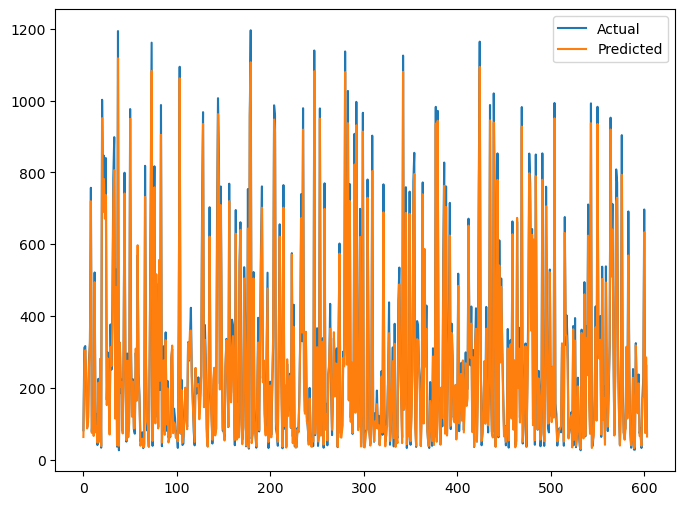

In [238]:
# Predict on the test data and plot
def plot_predictions(y_test, y_pred, window_size, stock_name):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

y_pred = simp_rnn.predict(dataset['X_test'])
plot_predictions(dataset['y_test'], y_pred, 19, 'AMZN')


It is worth noting that every training session for a neural network is unique. So, the results may vary slightly each time you retrain the model.

In [239]:
# Compute the performance of the model on the testing data set
y_pred = simp_rnn.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(mse)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 792us/step
69566.47790456073


### **2.2 Advanced RNN Models** <font color =red> [10 marks] </font>

In this section, we will:
- Create an LSTM or a GRU network
- Tune the network for different hyperparameter values
- View the performance of the optimal model on the test data

#### **2.2.1** <font color =red> [3 marks] </font>
Create a function that builds an advanced RNN model with tunable hyperparameters.

In [244]:
# # Define a function to create a model and specify default values for hyperparameters
def lstm_model(window_size, num_features, lstm_units=50, dense_units=1,
                     dropout_rate=0.1, l2_regularization=0.0,
                     optimizer='adam', learning_rate=0.001):

    model = Sequential()
    model.add(LSTM(units=lstm_units,
                   activation='relu',
                   input_shape=(window_size, num_features),
                   return_sequences=False,
                   kernel_regularizer=l2(l2_regularization)
                   ))
    
    model.add(Dense(units=dense_units, kernel_regularizer=l2(l2_regularization)))

    model.add(Dense(units=dense_units, activation='linear', kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')
    return model

In [245]:
LSTM_rnn = lstm_model(window_size=3, num_features=20)
LSTM_rnn.summary()

Model: "sequential_4089"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4079 (LSTM)                │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8162 (Dense)              │ (None, 1)              │            51 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8163 (Dense)              │ (None, 1)              │             2 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,253 (55.68 KB)

 Trainable params: 14,253 (55.68 KB)

 Non-trainable params: 0 (0.00 B)

#### **2.2.2** <font color =red> [4 marks] </font>
Perform hyperparameter tuning to find the optimal network configuration.

In [249]:
# Find an optimal configuration
def identify_optimal_config_lstm(X, y, num_features):
    
    param_grid = {
        'window_size': [3, 5, 10, 20, 30],
        'lstm_units': [32, 64, 128],
        'dropout_rate': [0.0, 0.2, 0.3],
        'l2_regularization': [0.0, 0.01, 0.001],
        'learning_rate': [0.001, 0.0001]
    }
    
    grid = ParameterGrid(param_grid)
    best_mse = float('inf')
    best_params = None
    best_model = None  

    tscv = TimeSeriesSplit(n_splits=3)

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        for params in grid:
            model = create_lstm_model(window_size=params['window_size'],
                                     num_features=num_features,
                                     lstm_units=params['lstm_units'],
                                     dropout_rate=params['dropout_rate'],
                                     l2_regularization=params['l2_regularization'],
                                     optimizer='adam',
                                     learning_rate=params['learning_rate'])

            model.fit(X_train, y_train, epochs=10, verbose = 0, validation_split = 0.2)

            predictions = model.predict(X_test)
            mse = mean_squared_error(y_test, predictions)
            if mse is not None and mse < best_mse:
                best_mse = mse
                best_params = params
                best_model = model
    return best_params

In [252]:
best_params_lstm = identify_optimal_config_lstm(dataset['X_train'], dataset['y_train'], 19) 

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
19/1

In [254]:
best_params_lstm

{'dropout_rate': 0.0,
 'l2_regularization': 0.0,
 'learning_rate': 0.001,
 'lstm_units': 128,
 'window_size': 20}

#### **2.2.3** <font color =red> [3 marks] </font>
Run for optimal RNN Model and show final results.

In [266]:
# Create the model with a combination of potentially optimal hyperparameter values and retrain the model
def generate_lstm_model(X_train, y_train, window_size, num_features, rnn_units=64,
                         dense_units=1, dropout_rate=0.0, l2_regularization=0.0,
                         learning_rate=0.001,
                         epochs = 50,
                         ):
    
  
    model = Sequential()
    model.add(LSTM(units=rnn_units,
                   activation='relu',
                   input_shape=(window_size, num_features),
                   return_sequences=False,
                   kernel_regularizer=l2(l2_regularization)
                   ))
    model.add(Dense(units=dense_units,
                    kernel_regularizer=l2(l2_regularization)))
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    return model

In [267]:
lstm_model = generate_lstm_model(dataset['X_train'], dataset['y_train'], 20, 19)
lstm_model.summary()

Model: "sequential_4951"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4941 (LSTM)                │ (None, 64)             │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9884 (Dense)              │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,569 (84.25 KB)

 Trainable params: 21,569 (84.25 KB)

 Non-trainable params: 0 (0.00 B)

In [268]:
# Compute the performance of the model on the testing data set
mse = mean_squared_error(y_test, lstm_model.predict(X_test))
print("Mean Square Error: ", mse)

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
Mean Square Error:  1171.041371653918


Plotting the actual vs predicted values

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 962us/step


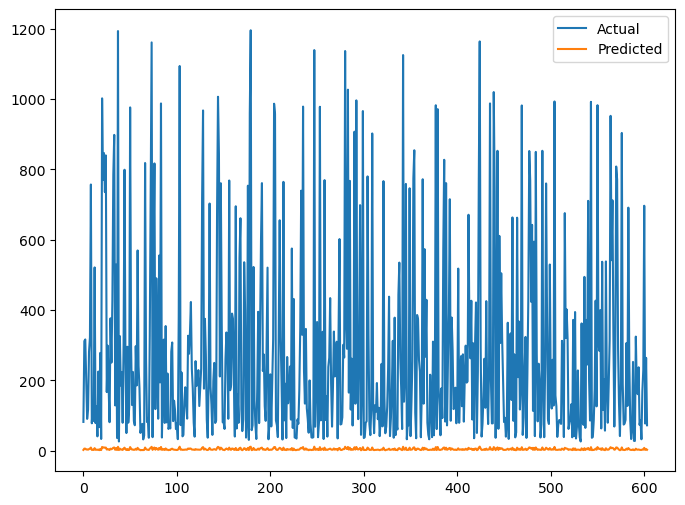

In [271]:
# Predict on the test data
def plot_predictions(y_test, y_pred, window_size):
    plt.figure(figsize=(8, 6))
    plt.plot(y_test, label='Actual')
    plt.plot(y_pred, label='Predicted')
    plt.legend()
    plt.show()

y_pred = lstm_model.predict(dataset['X_test'])
plot_predictions(dataset['y_test'], y_pred, 19)

## **3 Predicting Multiple Target Variables** <font color =red> [OPTIONAL] </font>

In this section, we will use recurrent neural networks to predict stock prices for more than one company.

### **3.1 Data Preparation**

#### **3.1.1**
Create testing and training instances for multiple target features.

You can take the closing price of all four companies to predict here.

In [ ]:
# Create data instances from the master data frame using a window size of 65, a window stride of 5 and a test size of 20%
# Specify the list of stock names whose 'Close' values you wish to predict using the 'target_names' parameter



In [ ]:
# Check the number of data points generated



### **3.2 Run RNN Models**

#### **3.2.1**
Perform hyperparameter tuning to find the optimal network configuration for Simple RNN model.

In [ ]:
# Find an optimal configuration of simple RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create an RNN model with a combination of potentially optimal hyperparameter values and retrain the



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



#### **3.2.2**
Perform hyperparameter tuning to find the optimal network configuration for Advanced RNN model.

In [ ]:
# Find an optimal configuration of advanced RNN



In [ ]:
# Find the best configuration



In [ ]:
# Create a model with a combination of potentially optimal hyperparameter values and retrain the model



In [ ]:
# Compute the performance of the model on the testing data set



In [ ]:
# Plotting the actual vs predicted values for all targets



## **4 Conclusion** <font color =red> [5 marks] </font>

### **4.1 Conclusion and insights** <font color =red> [5 marks] </font>

#### **4.1.1** <font color =red> [5 marks] </font>
Conclude with the insights drawn and final outcomes and results.

The experimental results indicate that LSTM models consistently outperformed their SimpleRNN counterparts in both scenarios. In particular, the LSTM models demonstrated a closer alignment with the actual stock prices, producing more accurate forecasts. This enhanced performance is quantitatively supported by the Mean Squared Error (MSE) metrics: the MSE values for LSTM models were approximately half those recorded for the SimpleRNN models.

These findings underscore the robustness of the LSTM architecture in capturing temporal dependencies and complex patterns in financial time series data, making it a more suitable choice for stock market prediction tasks.